In [2]:
import gym
import gym_sokoban
import numpy as np
import random
import copy
from collections import deque
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation, InputLayer
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from IPython.display import clear_output

from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

Couldn't import dot_parser, loading of dot files will not be possible.


In [21]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
#     plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    clear_output(wait=True)
    display(plt.gcf())


def display_frames_as_gif(frames, show_anim=True, save=True, name="anim"):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    
    if show_anim:
        display(display_animation(anim, default_mode='loop'))
    
    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='euzinho'), bitrate=1800)
        anim.save(name + '.mp4', writer=writer)
        
    plt.close()

def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, [110,84])
    
    return preprocessed_frame # 110x84x1 frame

In [5]:
env = gym.make("SpaceInvaders-v0")

In [6]:
tf.reset_default_graph()

In [7]:
## PARAMETERS
frame_buffer_size = 4

hidden_neurons = [64, 64]

input_size = frame_buffer_size
for i in range(len(env.observation_space.shape)):
    input_size *= env.observation_space.shape[i]

print(env.observation_space.shape)
    
action_size = env.action_space.n

## HYPER PARAMETERS
learning_rate = 0.00025


(210, 160, 3)


In [8]:
# Create Buffer
memory_max_size = 10000

class Memory():
    e = 0.01
    a = 0.7
    b = 0.3
    b_inc = 0.001
    
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
        self.weights = deque(maxlen = max_size)
    
    def add(self, experience, weight=1):
        self.buffer.append(experience)
        self.weights.append(np.power(np.abs(weight)+self.e, self.a))
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        
        self.b = np.min([1.0, self.b+self.b_inc])
        
        s=sum(self.weights)
        density = [e/s for e in self.weights]
        
        max_density = min(density)
        max_density = np.power(batch_size * max_density, -self.b)
        
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = True, 
                                p=density)
        
        batch = [self.buffer[i] for i in index]
        ISWeights_ = [np.power(density[i]*batch_size, -self.b)/max_density for i in index]
        
        return batch, np.array(ISWeights_).reshape((batch_size,1))

memory = Memory(memory_max_size)

In [9]:
stacked_frames  =  deque([np.zeros((110,84), dtype=np.int) for i in range(frame_buffer_size)], maxlen=frame_buffer_size)
def StackFrame(stack, frame):
    stack.append(frame)
def ClearStack(stack):
    stack  =  deque([np.zeros((110,84), dtype=np.int) for i in range(frame_buffer_size)], maxlen=frame_buffer_size)

In [10]:
s = env.reset()

ClearStack(stacked_frames)

gray_frame = preprocess_frame(s)
for k in range(frame_buffer_size):
    StackFrame(stacked_frames, gray_frame)

#The Q-Network
for i in range(memory_max_size):

    #copy stacked frames
    c_stacked_frames = copy.deepcopy(stacked_frames)

    state = np.stack(c_stacked_frames,axis=2)
    
    a = env.action_space.sample()

    #Get new state and reward from environment
    s1,r,d,_ = env.step(a)

    #stack new frame
    gray_frame = preprocess_frame(s1)
    StackFrame(stacked_frames, gray_frame)


    if d == True:
        next_state = np.stack(stacked_frames,axis=2)
        last_action = True
        
        s = env.reset()

        ClearStack(stacked_frames)

        gray_frame = preprocess_frame(s)
        for k in range(frame_buffer_size):
            StackFrame(stacked_frames, gray_frame)
            
    else:
        next_state = np.stack(stacked_frames,axis=2)

        last_action = False
        
    memory.add((state, r, next_state, last_action))


/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [11]:
class DQNetwork():
    def __init__(self, input_size, action_size, learning_rate=0.01, name=""):
        
        self.learning_rate = learning_rate
        self.input_size = input_size
        self.action_size = action_size
        self.name = name
        
        with tf.variable_scope(self.name):
            self.inputs_ = tf.placeholder(shape=[None, *input_size],dtype=tf.float32)

            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None, self.action_size], name="target")
            
            self.ISWeights_ = tf.placeholder(tf.float32, [None, 1], name="ISWeights")

            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                             filters = 32,
                                             kernel_size = [8,8],
                                             strides = [4,4],
                                             padding = "VALID",
                                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                             name = "conv1")

            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm1')

            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")

            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                     filters = 64,
                                     kernel_size = [4,4],
                                     strides = [2,2],
                                     padding = "VALID",
                                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                     name = "conv2")

            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')

            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
            ## --> [9, 9, 64]

            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 128,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")

            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm3')

            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")
            ## --> [3, 3, 128]

            self.flatten = tf.layers.flatten(self.conv3_out)

            self.value_fc1 = tf.layers.dense(inputs = self.flatten,
                                 units = 512,
                                 activation = tf.nn.relu,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                 name="value_fc1")

            self.advantage_fc1 = tf.layers.dense(inputs = self.flatten,
                                 units = 512,
                                 activation = tf.nn.relu,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                 name="advantage_fc1")

            self.value = tf.layers.dense(inputs = self.value_fc1, 
                                     kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                     units = 1, 
                                     activation=None)

            self.advantage = tf.layers.dense(inputs = self.advantage_fc1, 
                                     kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                     units = self.action_size, 
                                     activation=None)

            self.output = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True))


            # Q is our predicted Q values.
            self.Q = tf.argmax(self.output, 1)

            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(self.ISWeights_ * tf.square(self.target_Q - self.output))

            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

            self.correct_prediction = tf.equal(tf.argmax(self.output, 1), tf.argmax(self.target_Q, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

In [12]:
def update_target_graph(name_from, name_to):
    
    # Get the parameters of our DQNNetwork
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name_from)
    
    # Get the parameters of our Target_network
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name_to)

    op_holder = []
    
    # Update our target_network parameters with DQNNetwork parameters
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

In [13]:
tf.reset_default_graph()
action_network = DQNetwork([110,84,frame_buffer_size], action_size, learning_rate=0.00025, name="action_network")
target_network = DQNetwork([110,84,frame_buffer_size], action_size, learning_rate=0.00025, name="target_network")

# Setup TensorBoard Writer
writer = tf.summary.FileWriter("tensorboard/dqn/1")

## Losses
tf.summary.scalar("Loss_Action_Network", action_network.loss)
tf.summary.scalar("Loss_Target_Network", target_network.loss)

write_op = tf.summary.merge_all()

saver = tf.train.Saver()

In [19]:
# Set training ID for reference
import time
training_id = int(round(time.time() * 1000))

# Set learning parameters
y = 0.99
num_episodes = 10000
batch_size = 64

show_game = False

continue_training = True
max_steps = 50000

decay_rate = 0.000000001
e = 0.85
ef = 0.01

max_tau = 10000
tau = 0

model_name = "model_spaceinvaders_2"

with tf.device("/gpu:0"):
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:

        if continue_training:
            saver.restore(sess, "./models/" + model_name + ".ckpt")
        else:
            init = tf.global_variables_initializer()
            sess.run(init)

        consecutive_rewards = []
        decay_step = 0
        for episode in range(num_episodes):
            #Reset environment and get first new observation
            s = env.reset()
            rAll = 0
            d = False
            num_actions = 0
            frames = []
            total_reward = 0
            
            ClearStack(stacked_frames)

            gray_frame = preprocess_frame(s)
            for k in range(frame_buffer_size):
                StackFrame(stacked_frames, gray_frame)

            #The Q-Network
            while num_actions < max_steps:
                num_actions+=1
                decay_step+=1
                
                tau += 1

                if show_game:
                    show_state(env)

                #copy stacked frames
                c_stacked_frames = copy.deepcopy(stacked_frames)

                #allQ = model.predict(np.vstack(c_stacked_frames).flatten())
                
                state = np.stack(c_stacked_frames,axis=2)
                allQ = sess.run(action_network.output,
                                feed_dict={action_network.inputs_:state.reshape((1,*state.shape))})
                if np.random.rand(1) < e:
                    a = env.action_space.sample()
                else:
                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    a = np.argmax(allQ)
                
                e = ef + (e - ef) * np.exp(-decay_rate * decay_step)

                #Get new state and reward from environment
                s1,r,d,_ = env.step(a)

                total_reward += r

                #stack new frame
                gray_frame = preprocess_frame(s1)
                StackFrame(stacked_frames, gray_frame)
                
                next_state = np.stack(stacked_frames,axis=2)
                
                if episode%100 == 0:
                    frames.append(gray_frame)



                if d == True:
                    num_actions = max_steps
                    last_action = True
                else:
                    
                    last_action = False

                memory.add((state, r, next_state, last_action))

                # BATCH LEARNING
                batch, ISWeights_ = memory.sample(batch_size)

                states = np.array([each[0] for each in batch],ndmin=3)
                rewards = np.array([each[1] for each in batch])
                next_states = np.array([each[2] for each in batch],ndmin=3)
                last_actions = np.array([each[3] for each in batch])
#                 targets = np.squeeze(np.array([each[1] for each in batch]), axis=1)

                targets = []
    
                result_next_states = sess.run(target_network.output,
                                              feed_dict={target_network.inputs_:next_states})
                actions_next_states = sess.run(action_network.output,
                                               feed_dict={action_network.inputs_:next_states})
            
                result_states = sess.run(target_network.output,
                                              feed_dict={target_network.inputs_:states})
    
                for i in range(len(batch)):
                    last_action = last_actions[i]
                    
                    act = np.argmax(actions_next_states[i])
                    targetQ = result_states[i]
                    if last_action:
                        targetQ[a] = rewards[i]
                    else:
                        targetQ[a] = rewards[i] + y*result_states[i][act]
                    targets.append(targetQ)
                
                targets = np.array([each for each in targets])
                    

                loss,  _ = sess.run([target_network.loss,target_network.optimizer],
                                  feed_dict={target_network.inputs_:states,
                                             target_network.target_Q:targets,
                                             target_network.ISWeights_:ISWeights_})
                s = s1
                
                if tau > max_tau:
                    # Update the parameters of our TargetNetwork with DQN_weights
                    update_target = update_target_graph(action_network.name, target_network.name)
                    sess.run(update_target)
                    tau = 0
                    print("Model updated")


            print("Episode " + str(episode) + " ended." + 
                      "\n\t Loss = " + str(loss) + 
                      "\n\t Total Reward = " + str(total_reward) +
                      "\n\t Explore Prob = " + str(e))

            if episode % 5 == 0:
                save_path = saver.save(sess,  "./models/" + model_name + ".ckpt")
                print("Model Saved")
            if episode%100 == 0:
                display_frames_as_gif(frames, 
                                      name= str(training_id) + "_spaceinvaders_ep" + str(episode) + "_r" + str(total_reward))

INFO:tensorflow:Restoring parameters from ./models/model_spaceinvaders_2.ckpt


/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from ./models/model_spaceinvaders_2.ckpt


/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Episode 0 ended.
	 Total Reward = 460.0



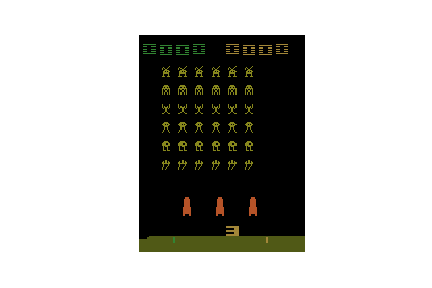
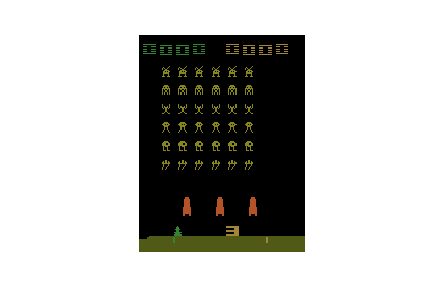
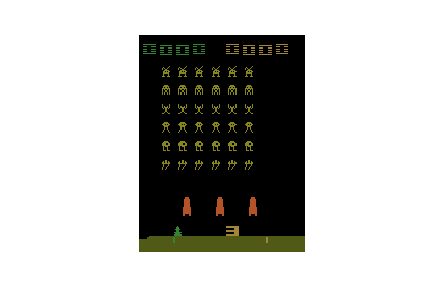
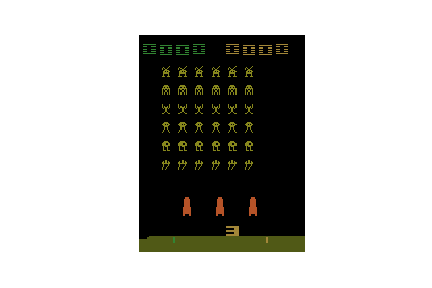
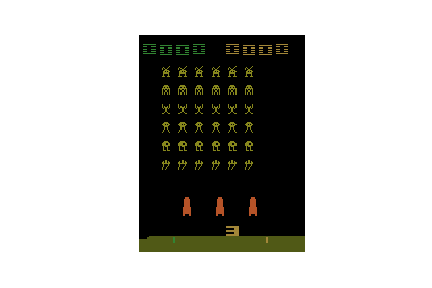
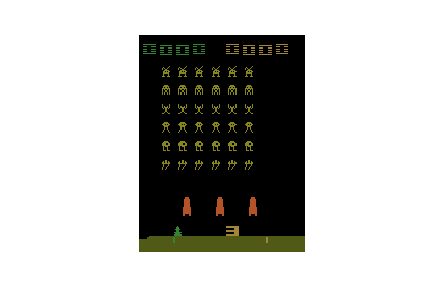
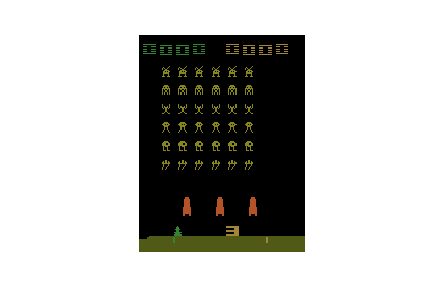
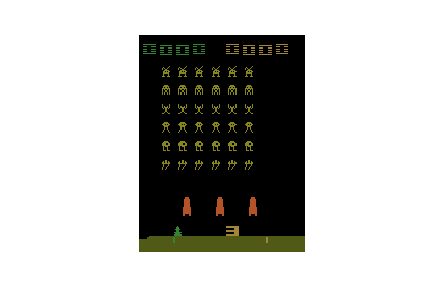
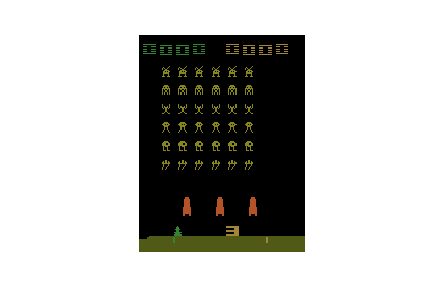
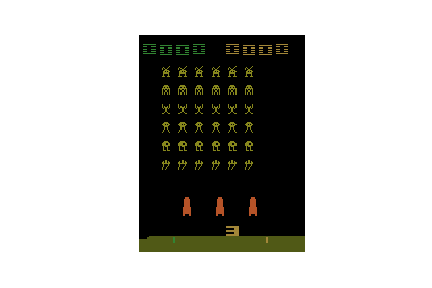
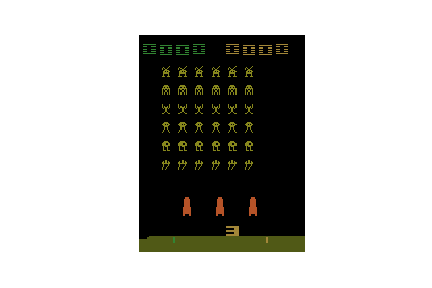
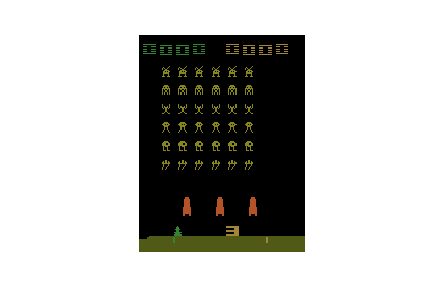
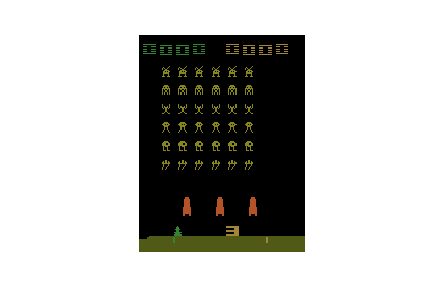
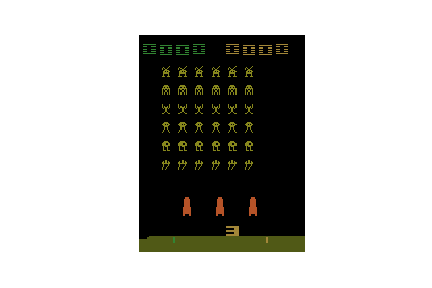
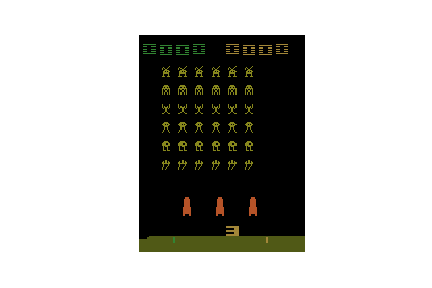
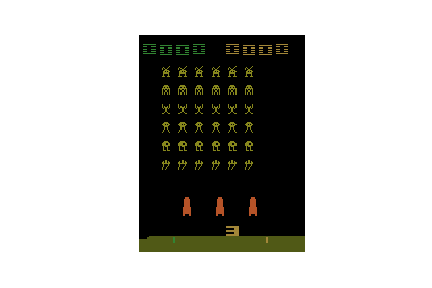
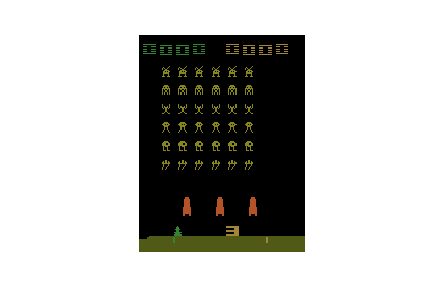
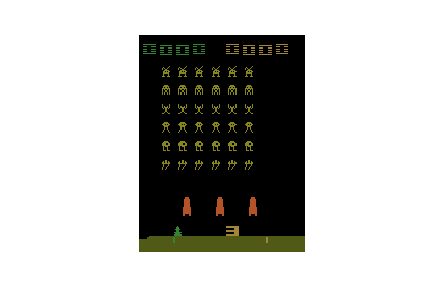
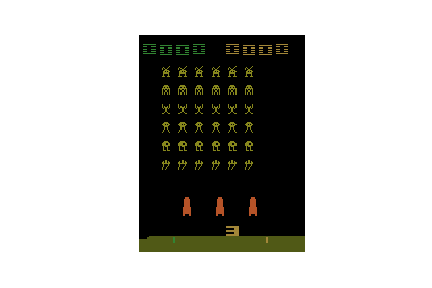
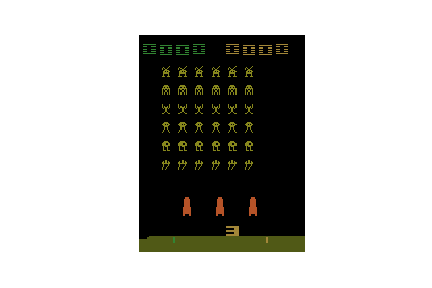
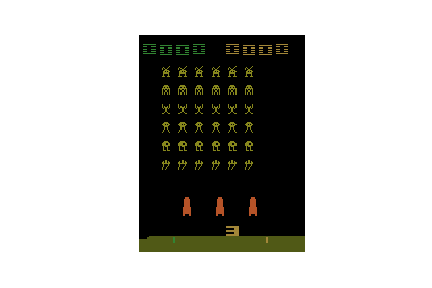
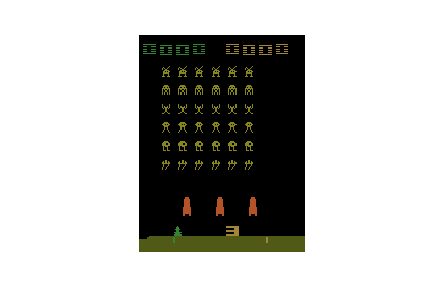
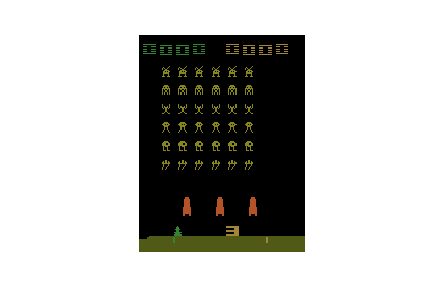
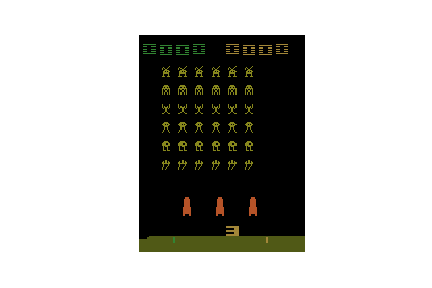
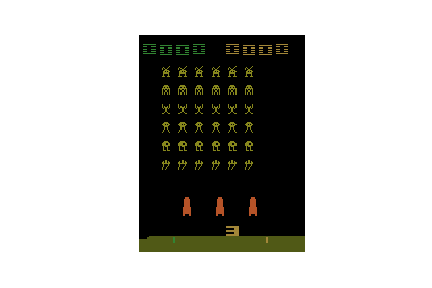
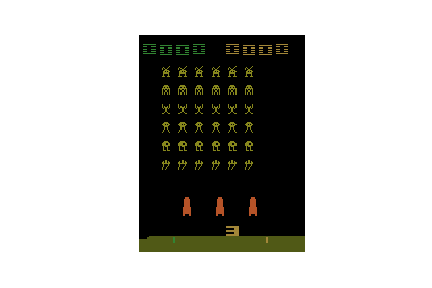
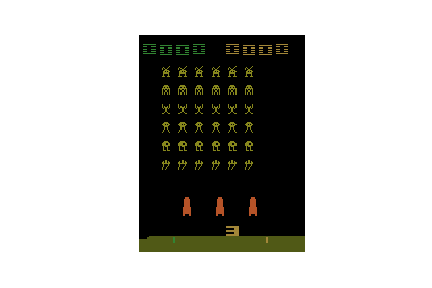
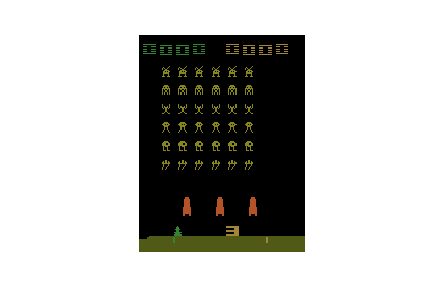
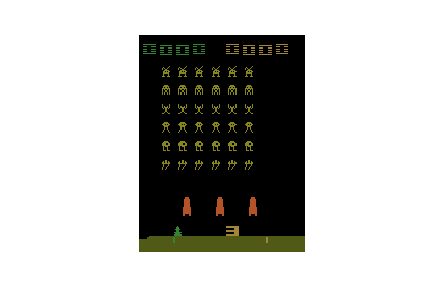
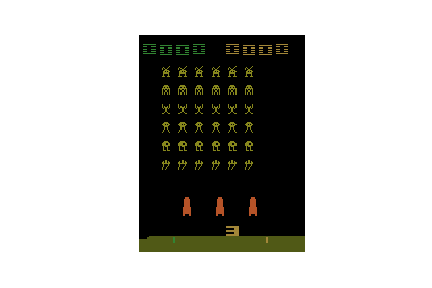
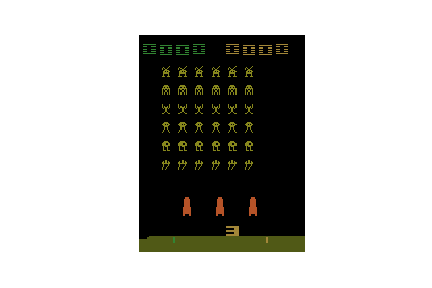
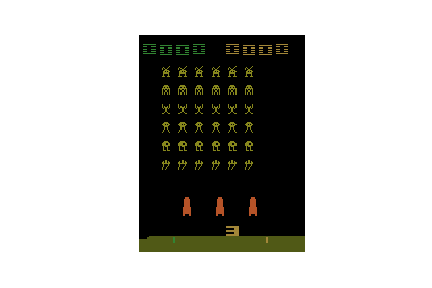
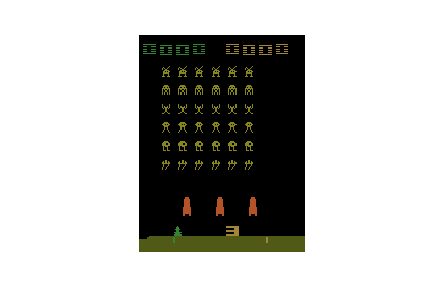
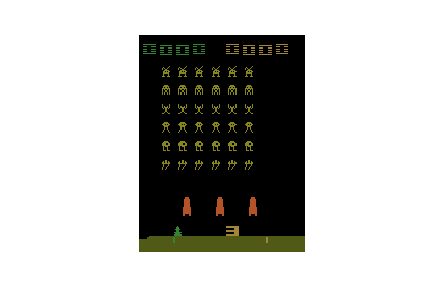
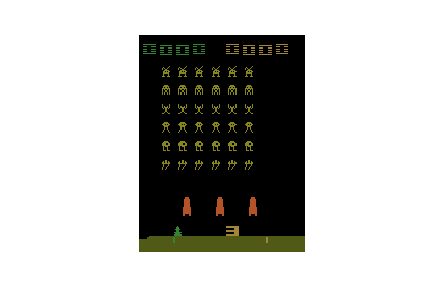
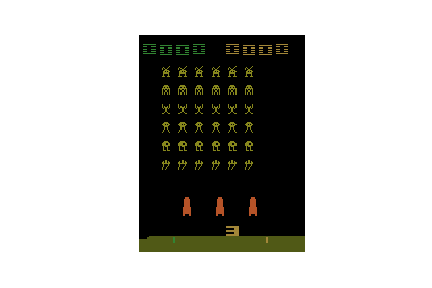
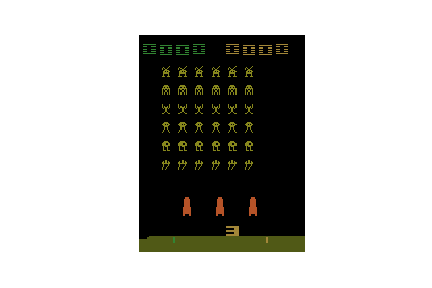
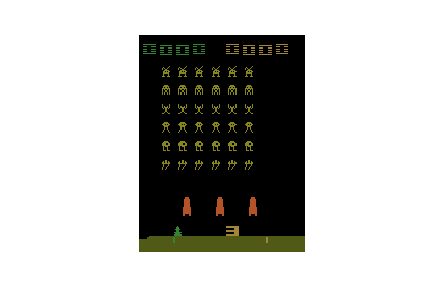
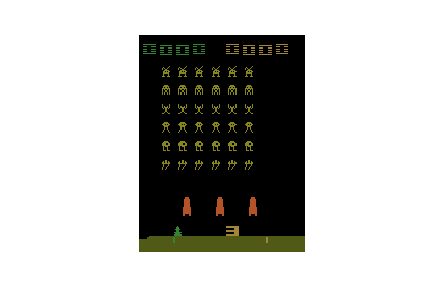
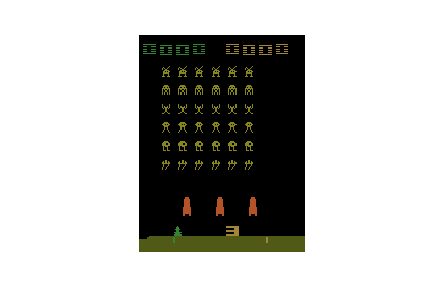
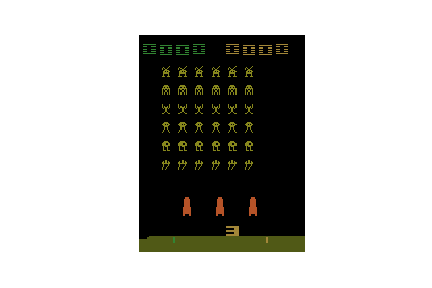
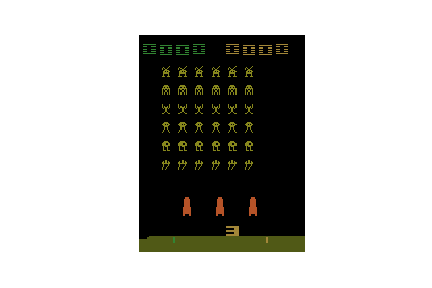
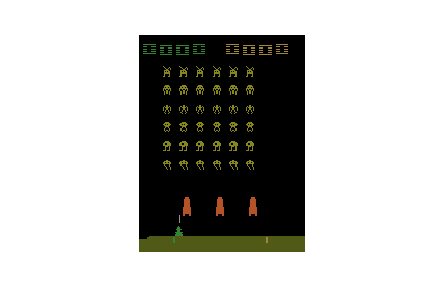
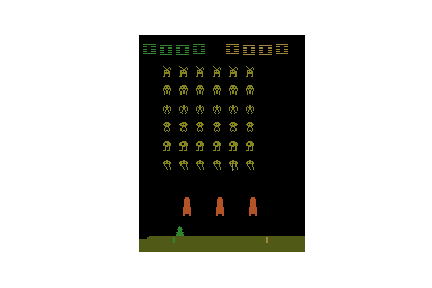
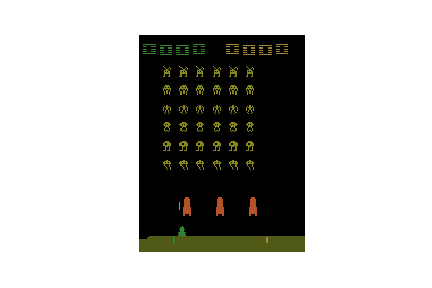
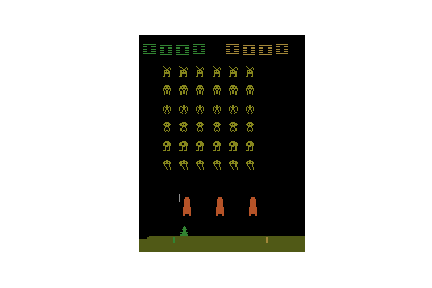
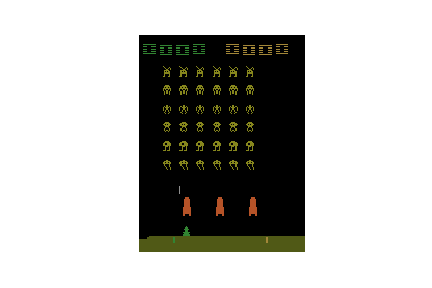
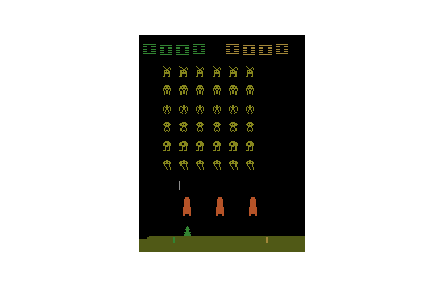
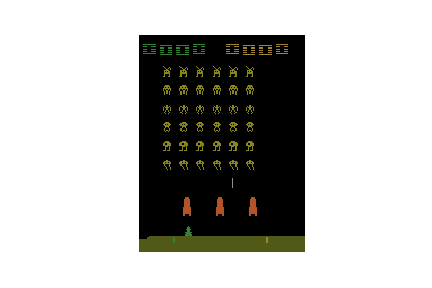
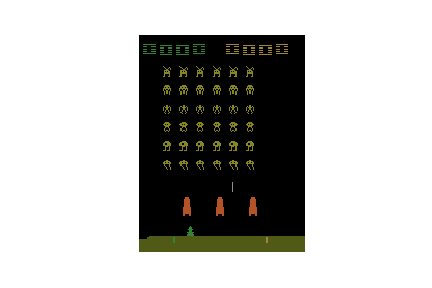
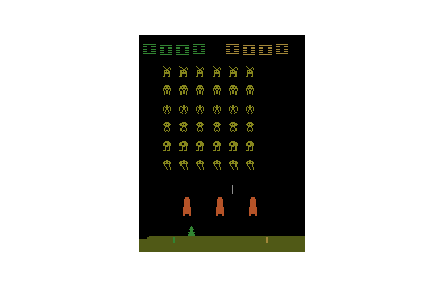
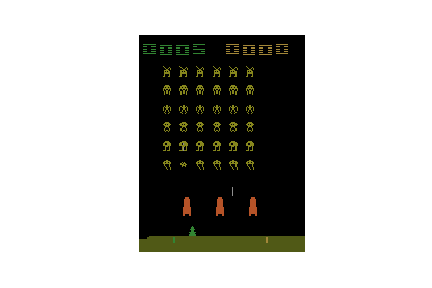
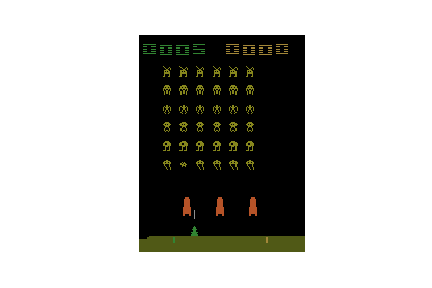
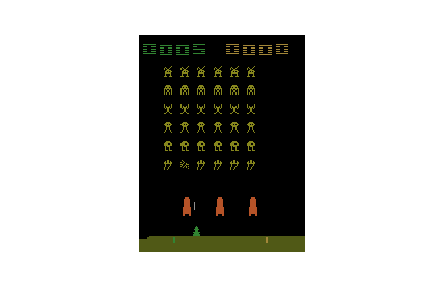
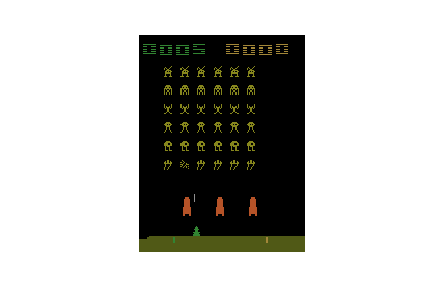
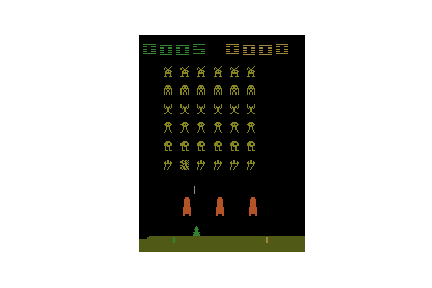
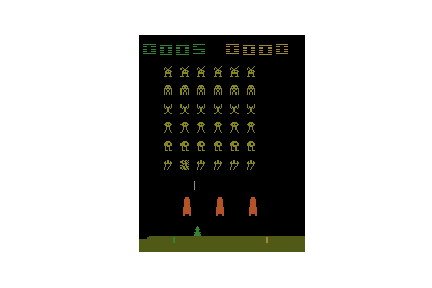
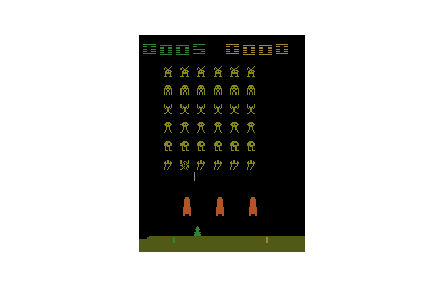
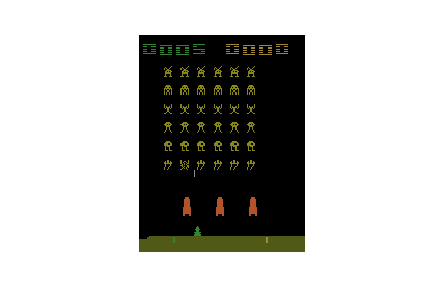
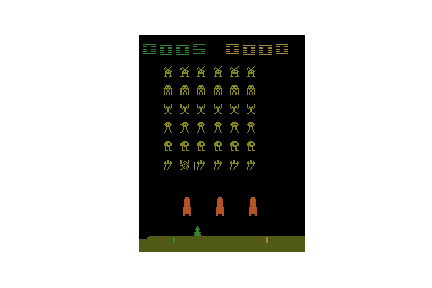
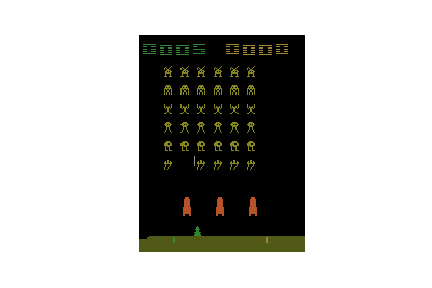
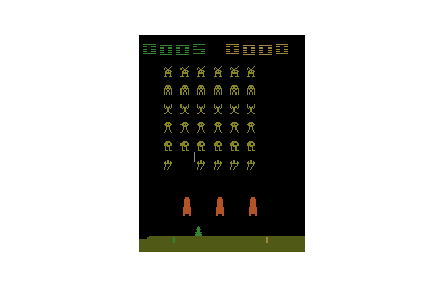
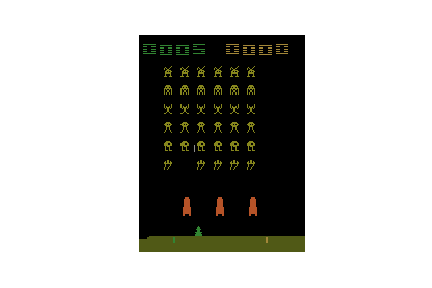
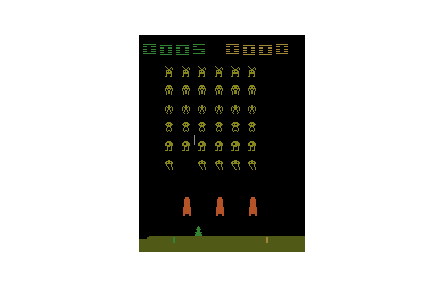
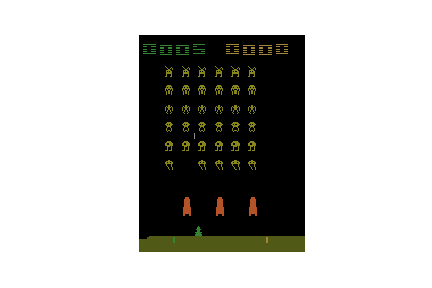
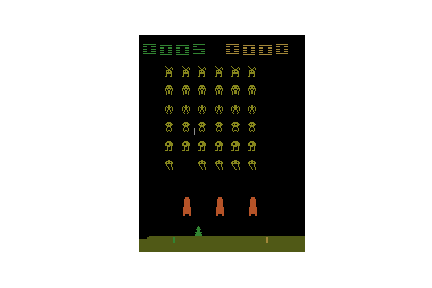
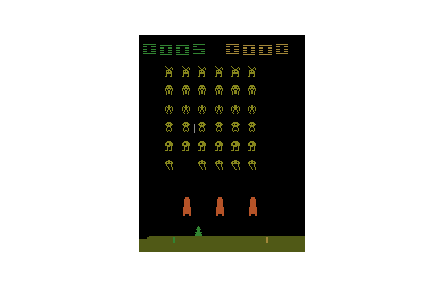
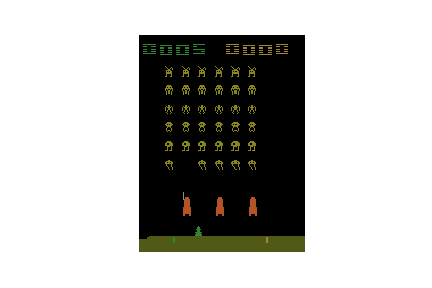
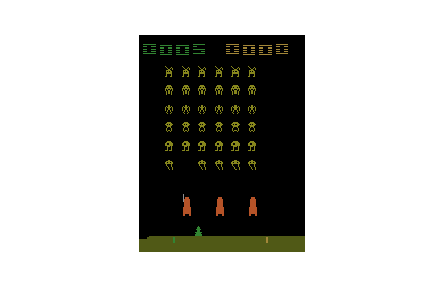
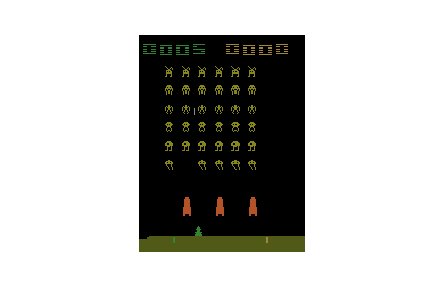
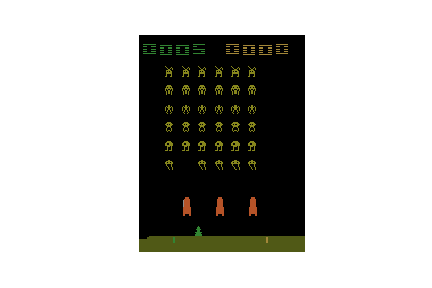
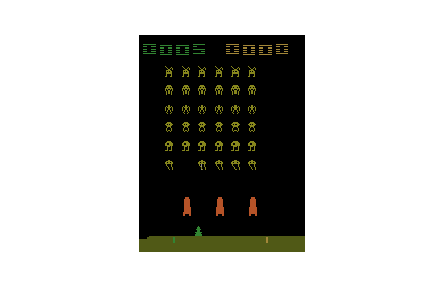
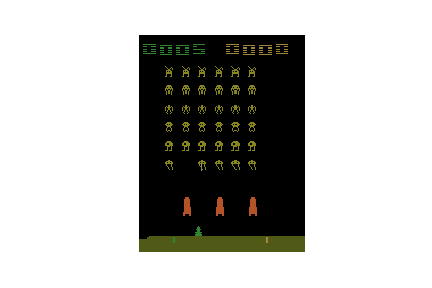
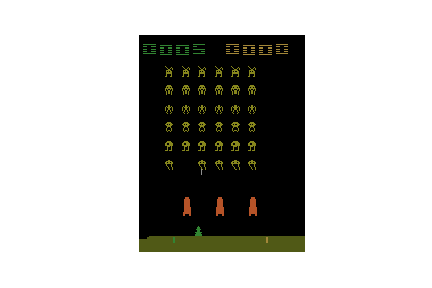
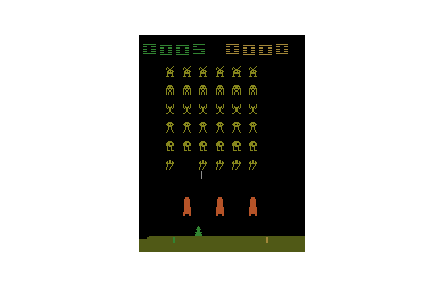
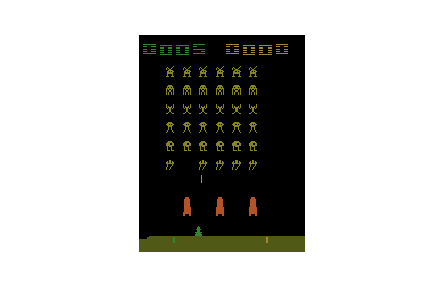
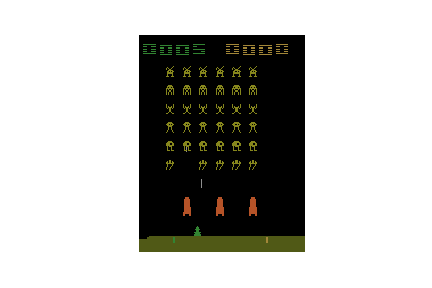
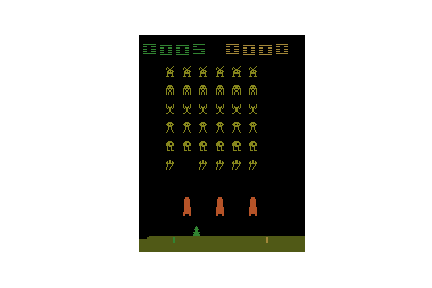
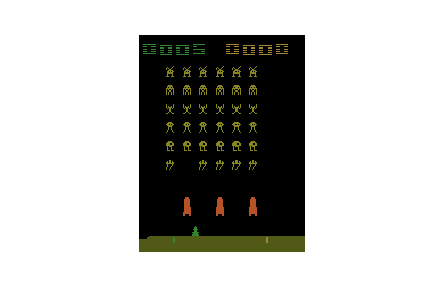
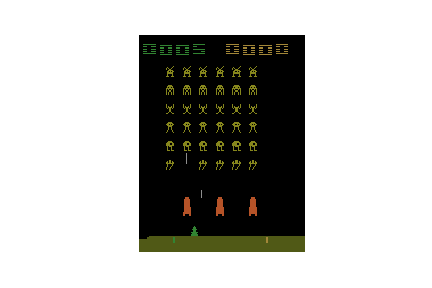
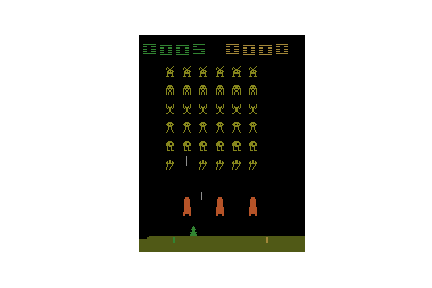
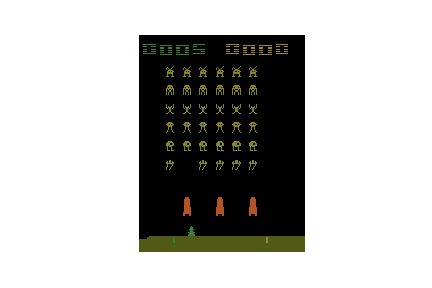
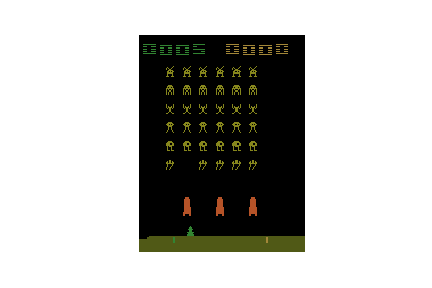
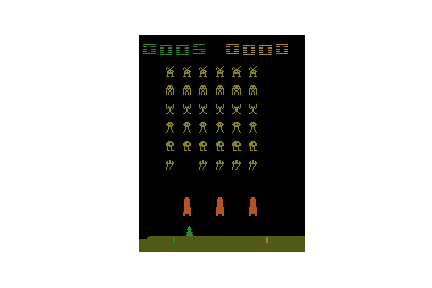
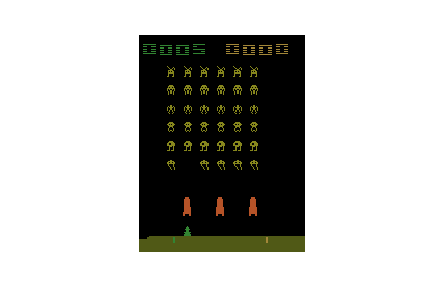
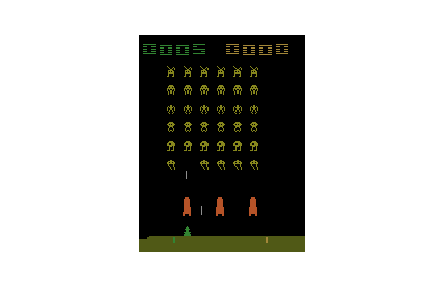
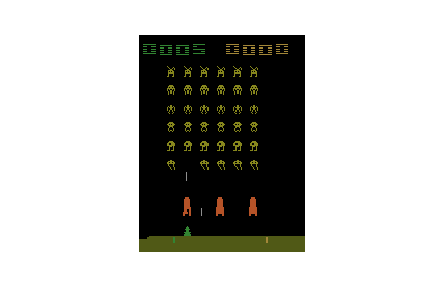
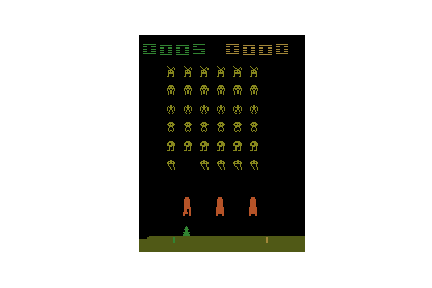
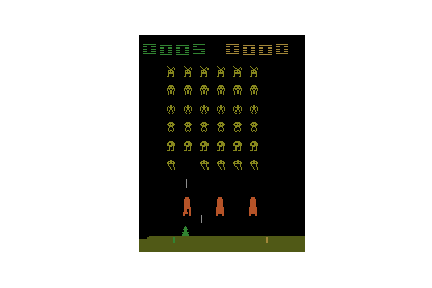
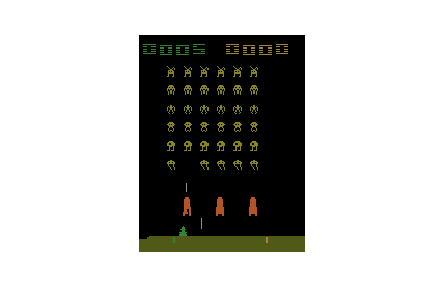
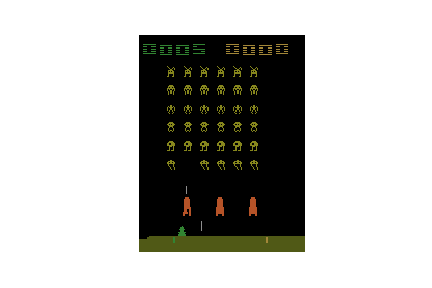
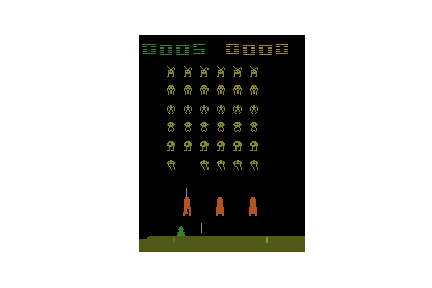
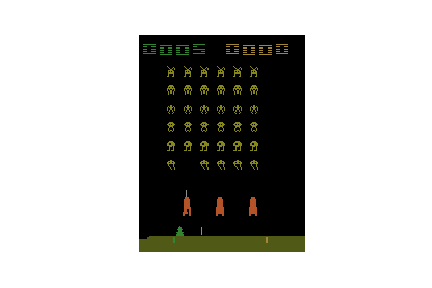
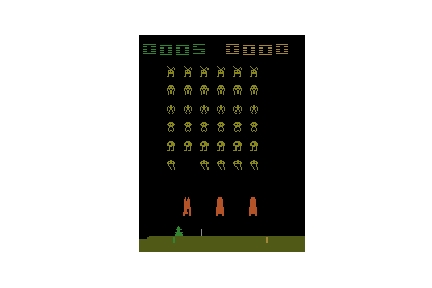
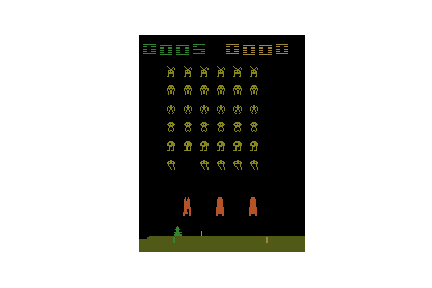
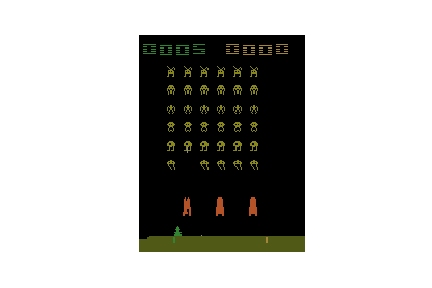
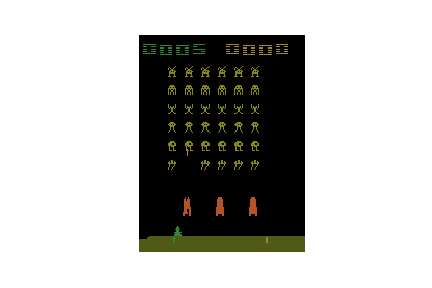
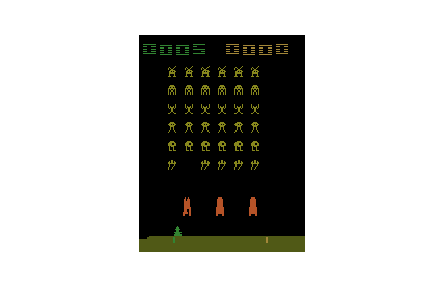
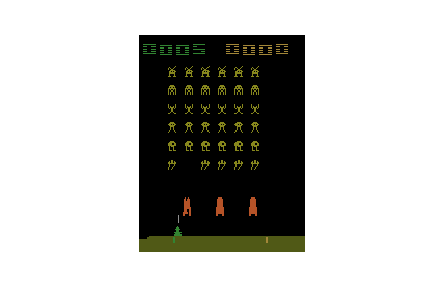
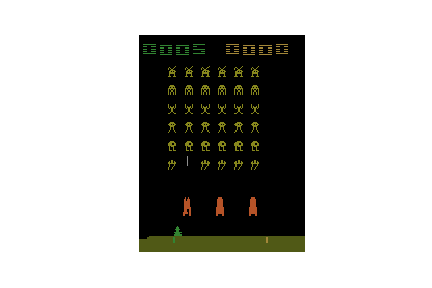
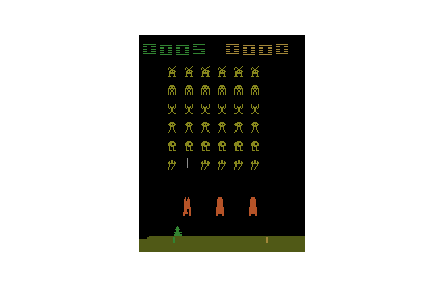
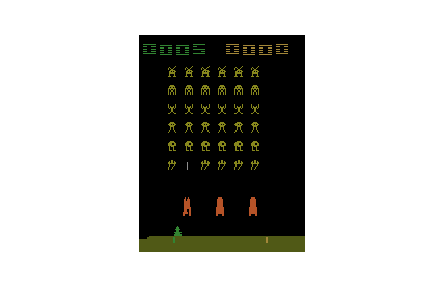
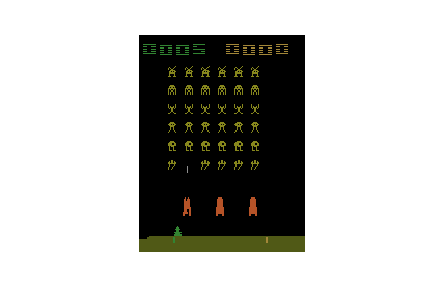
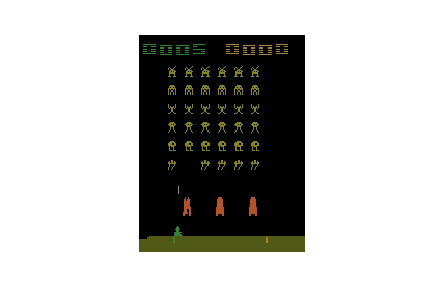
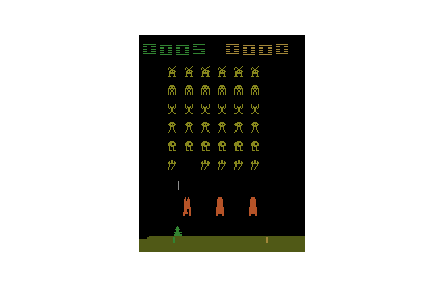
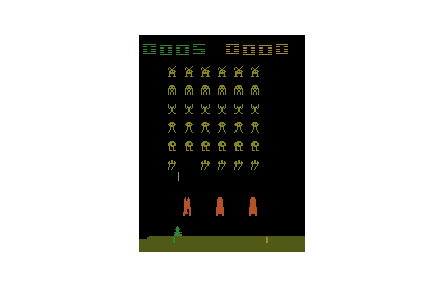
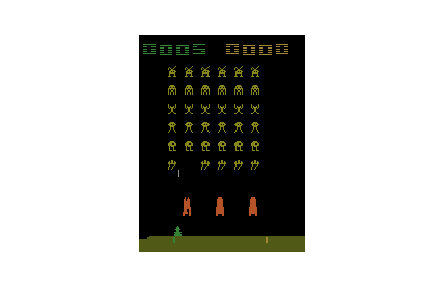
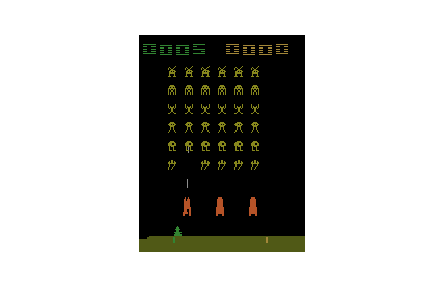
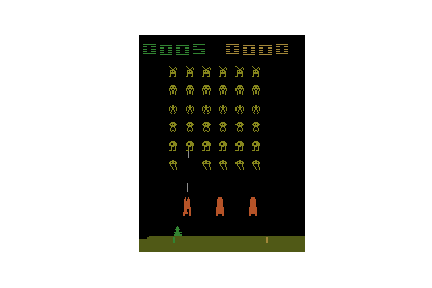
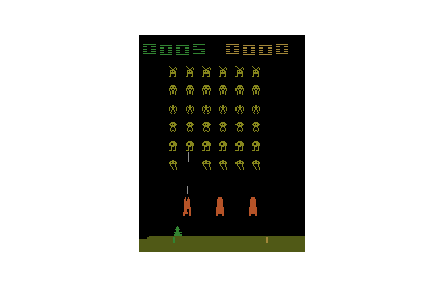
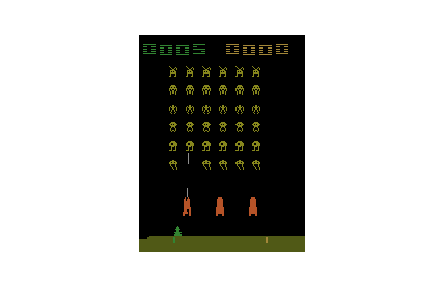
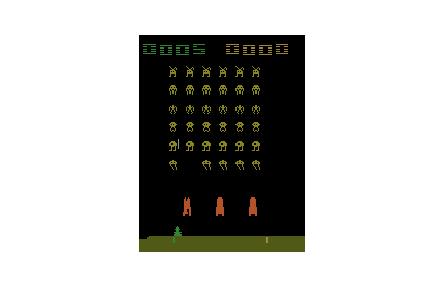
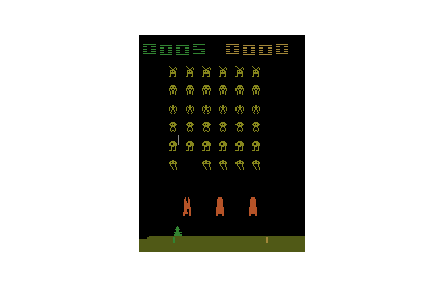
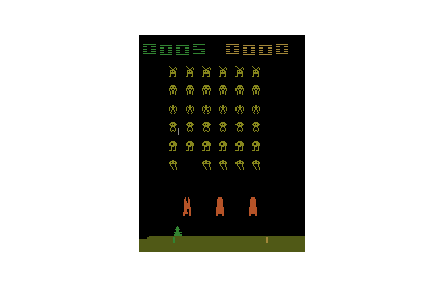
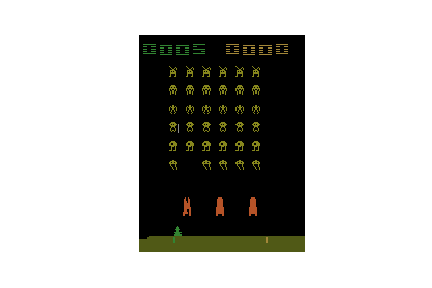
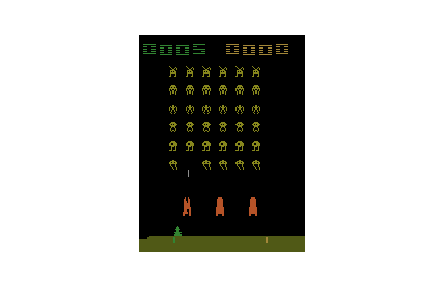
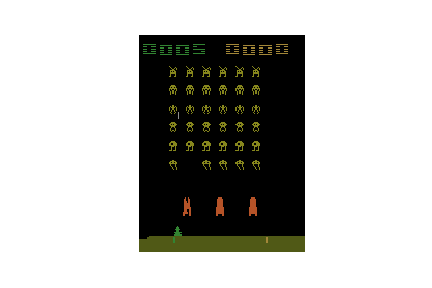
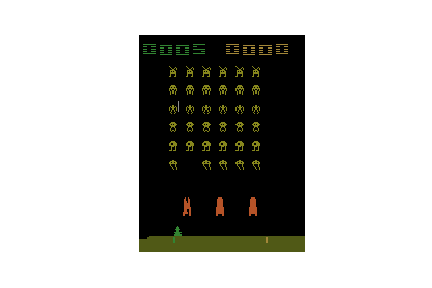
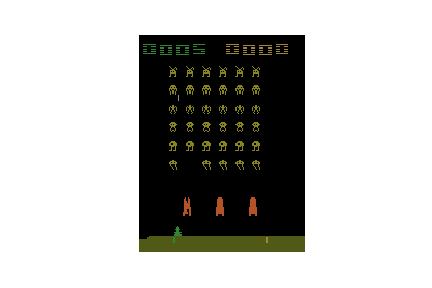
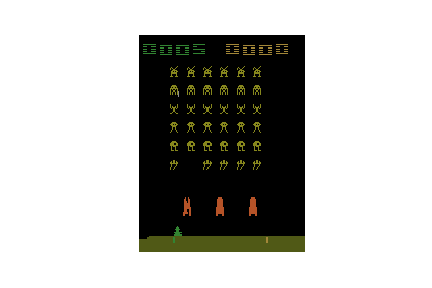
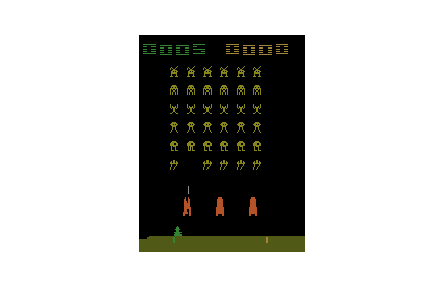
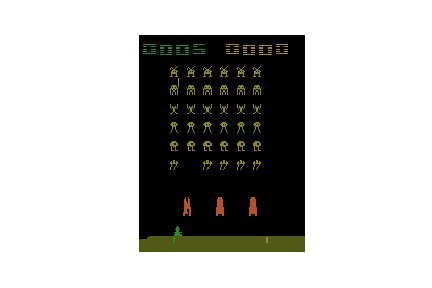
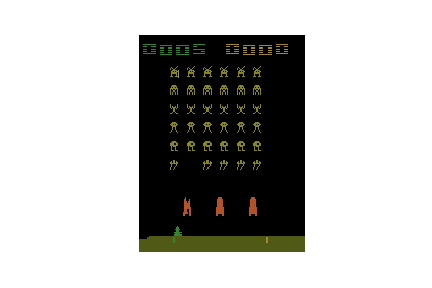
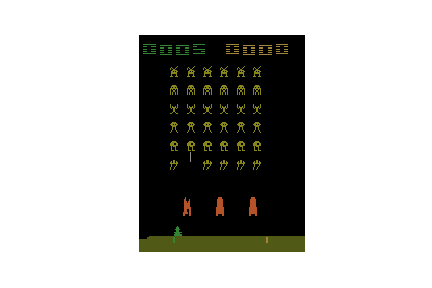
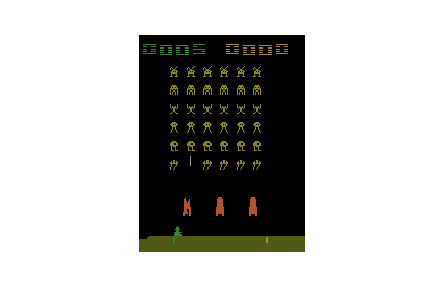
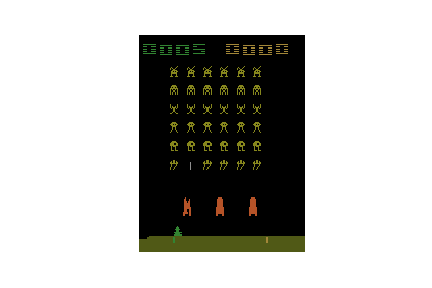
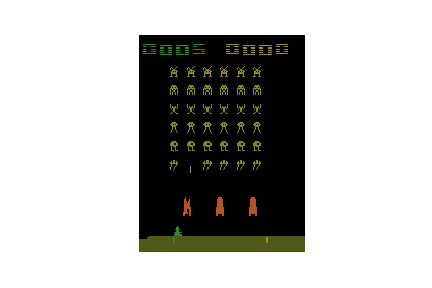
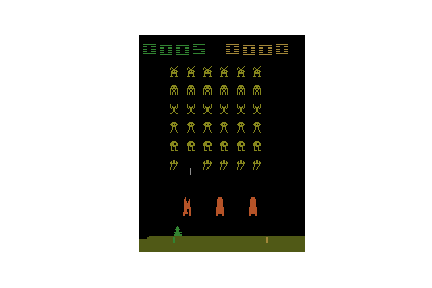
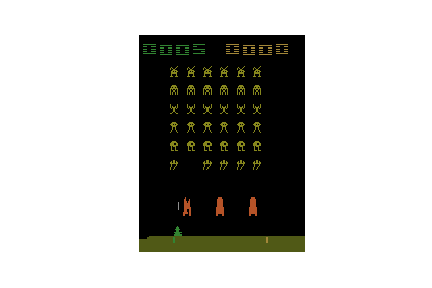
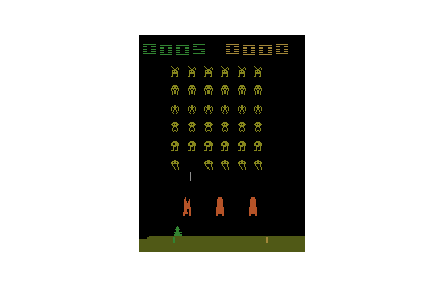
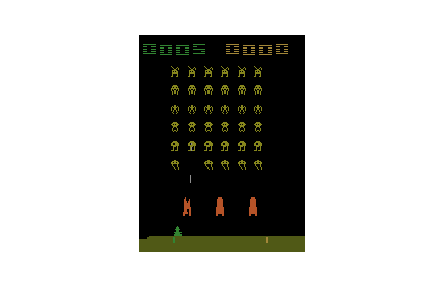
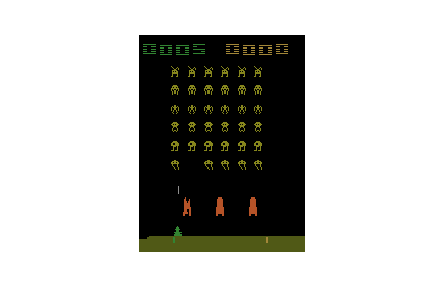
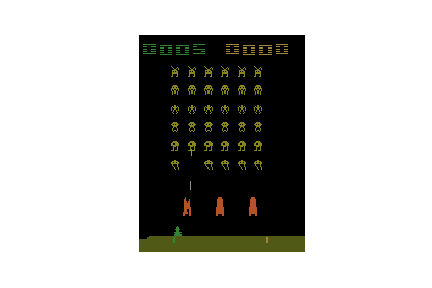
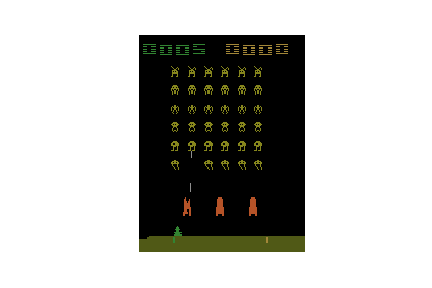
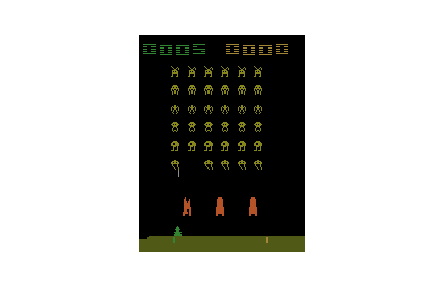
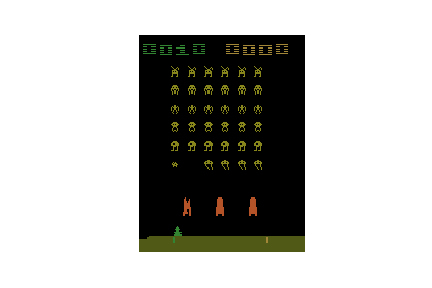
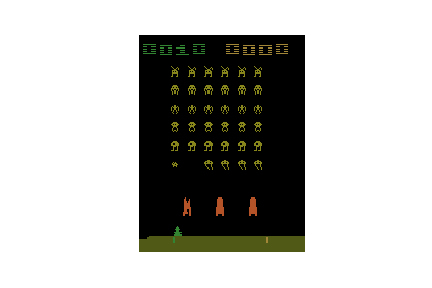
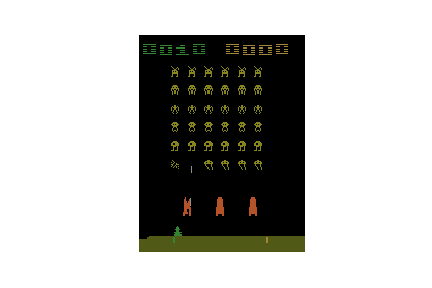
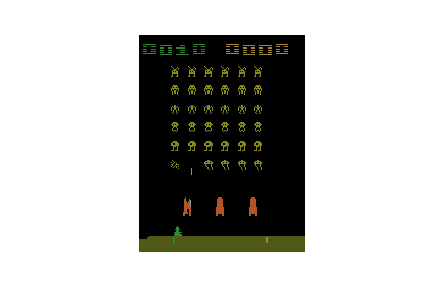
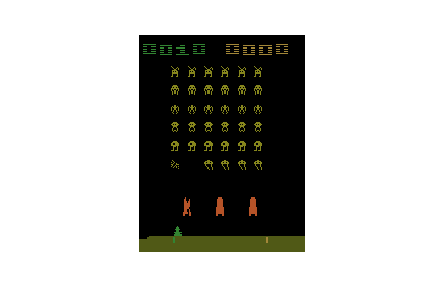
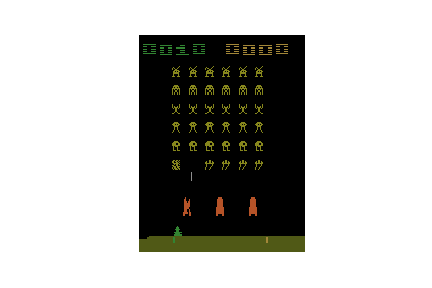
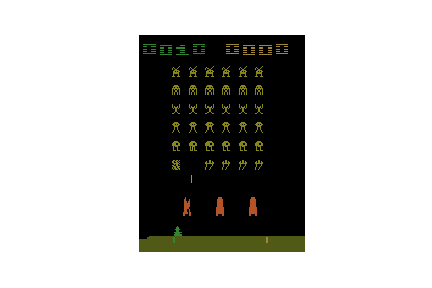
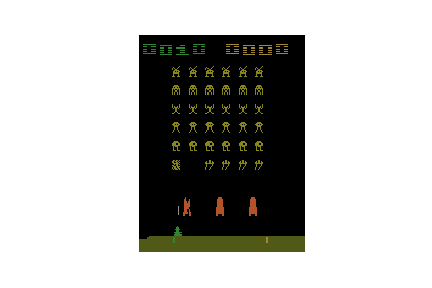
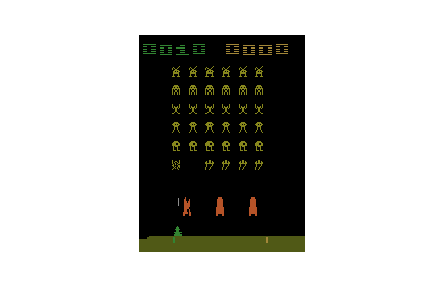
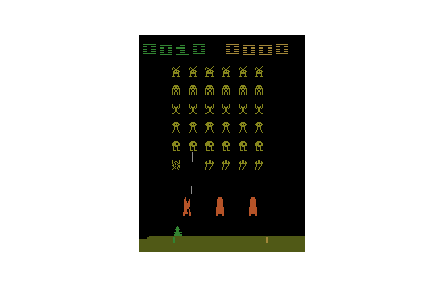
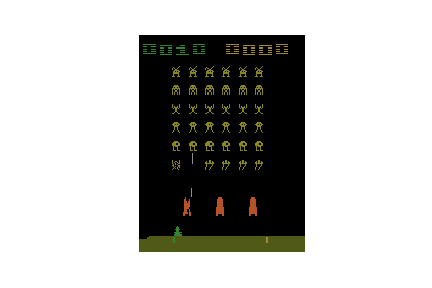
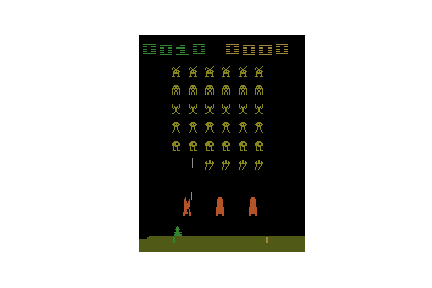
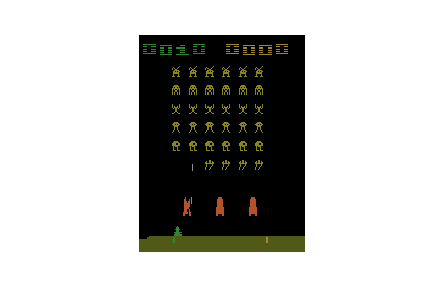
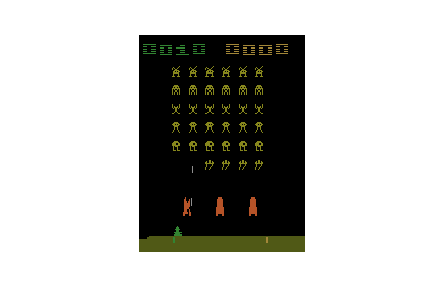
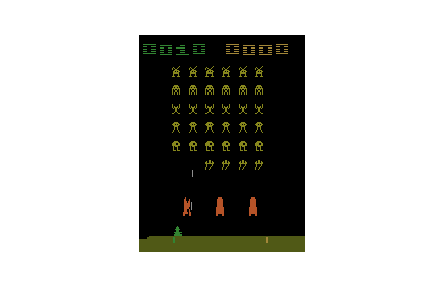
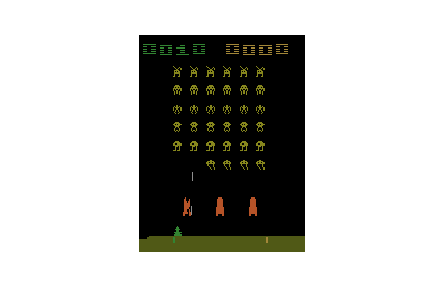
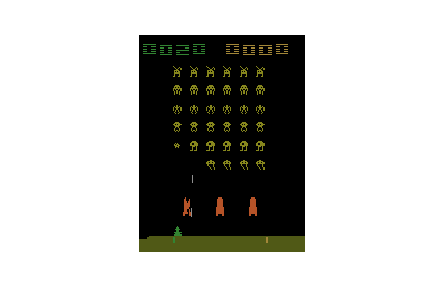
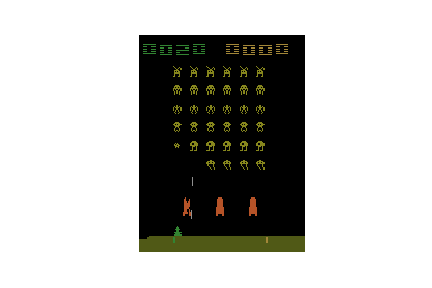
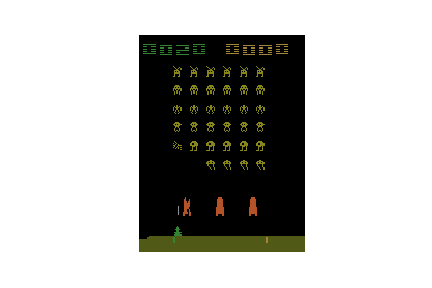
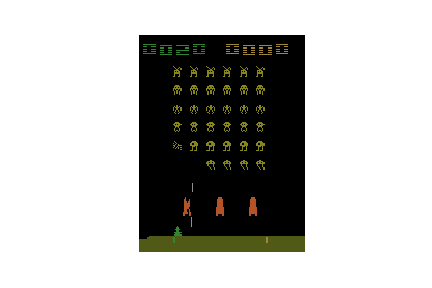
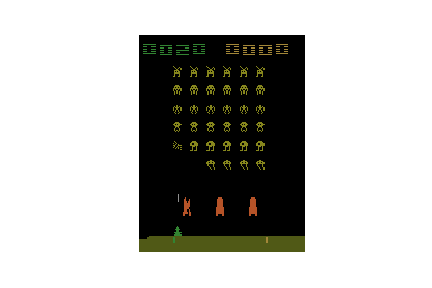
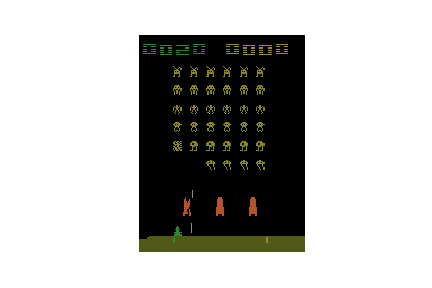
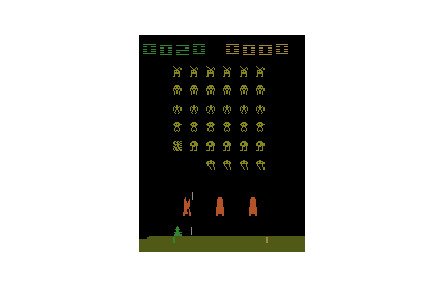
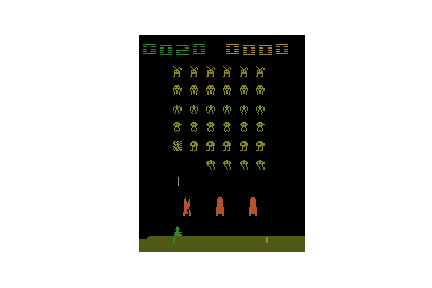
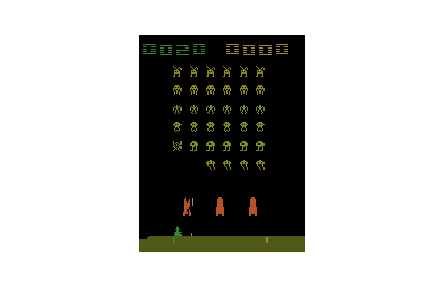
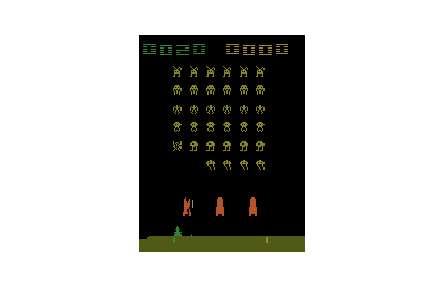
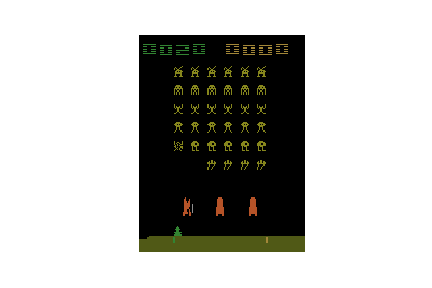
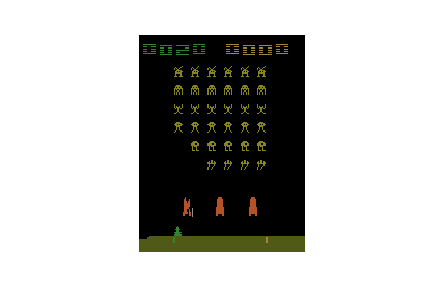
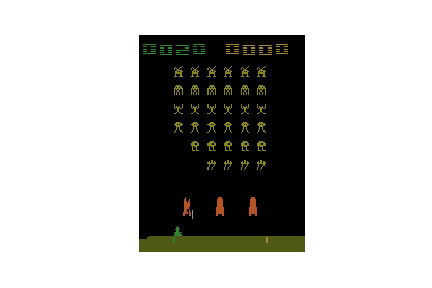
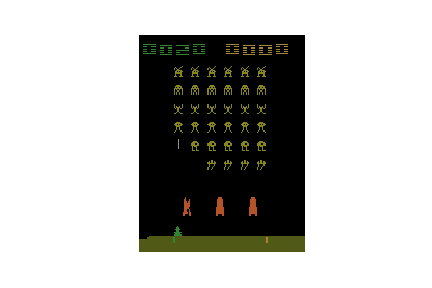
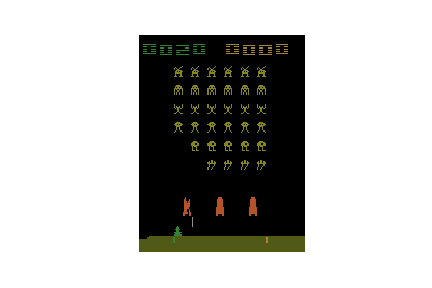
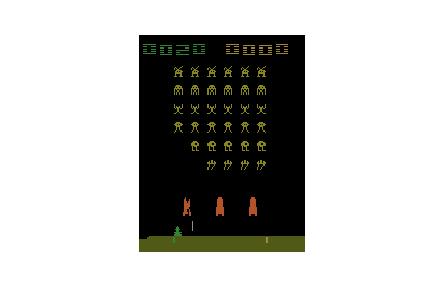
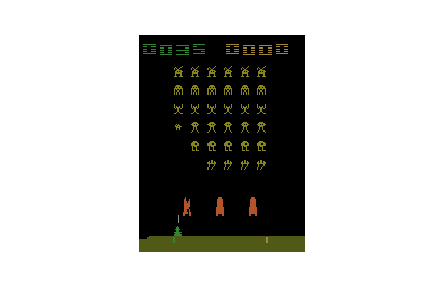
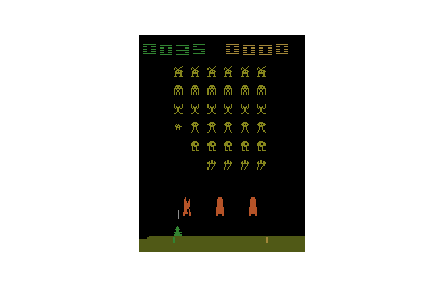
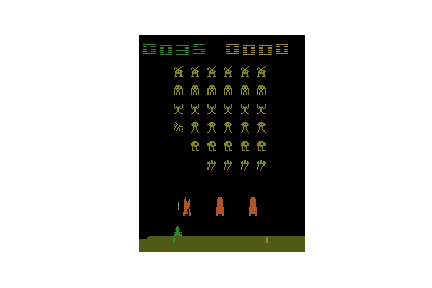
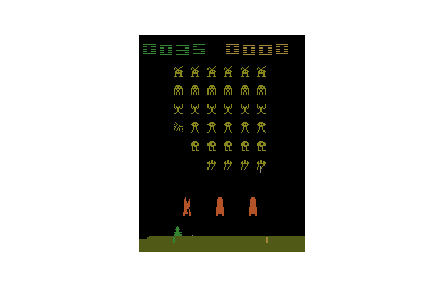
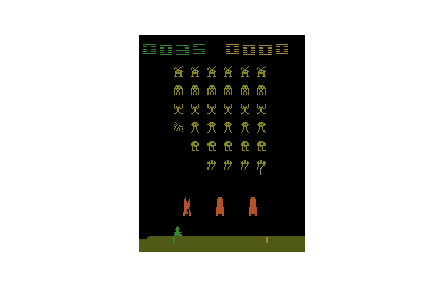
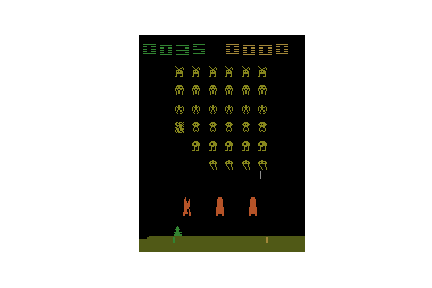
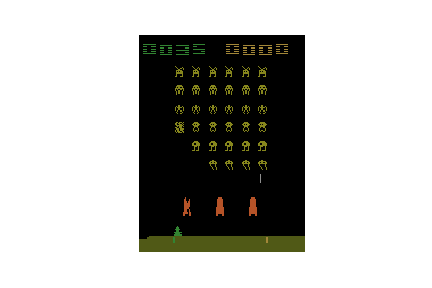
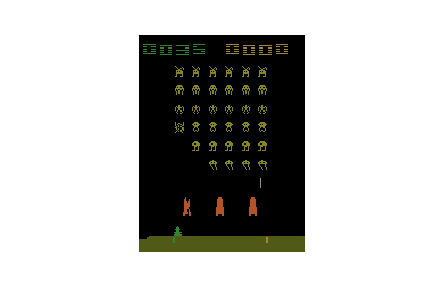
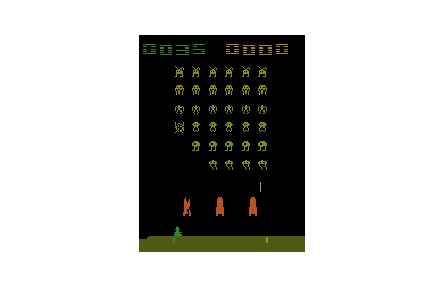
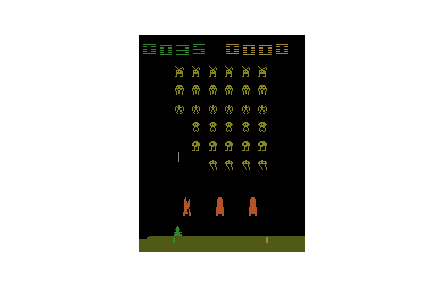
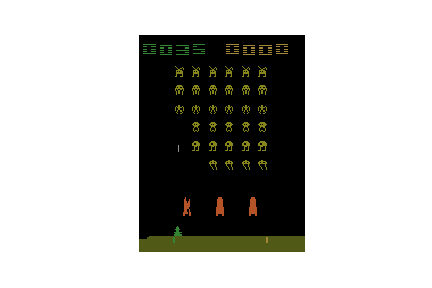
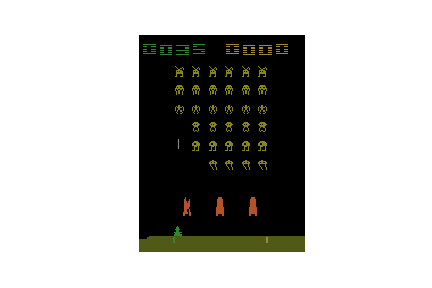
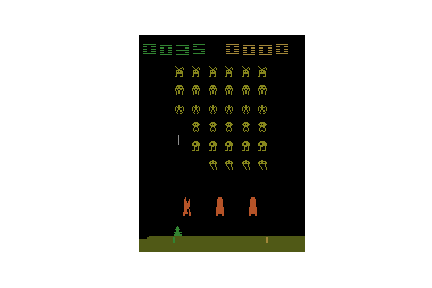
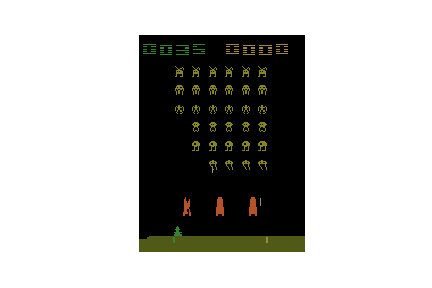
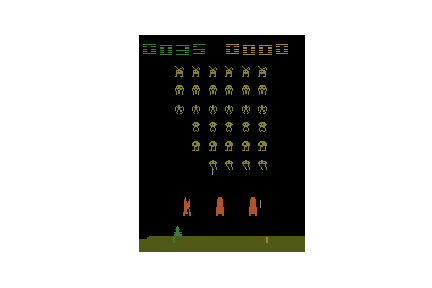
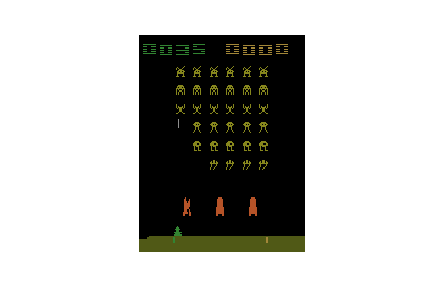
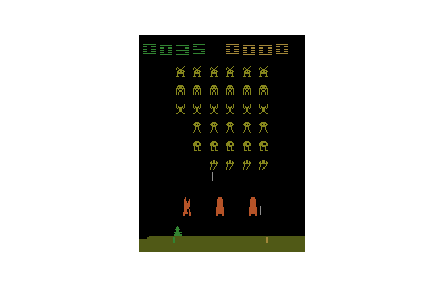
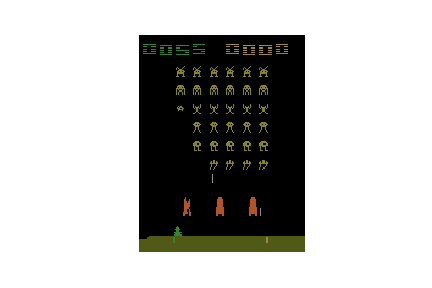
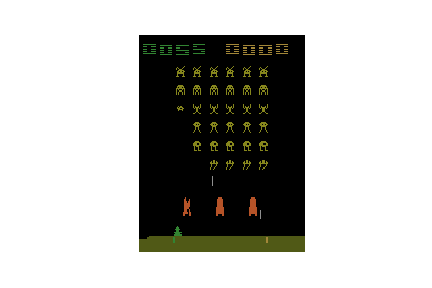
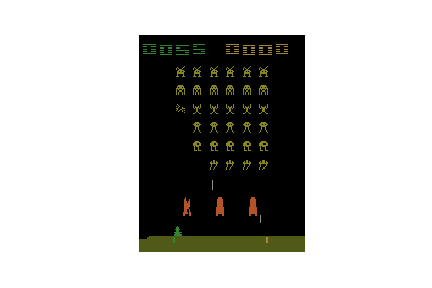
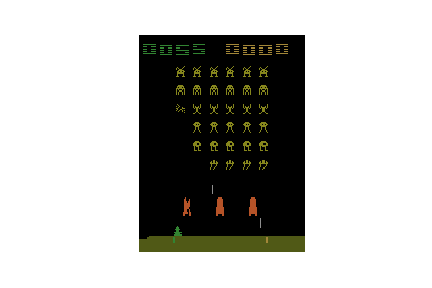
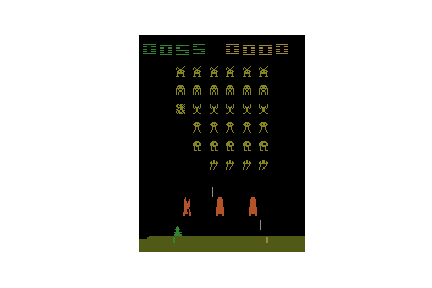
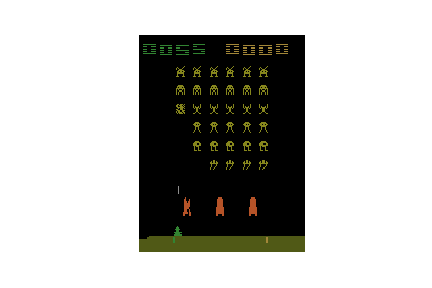
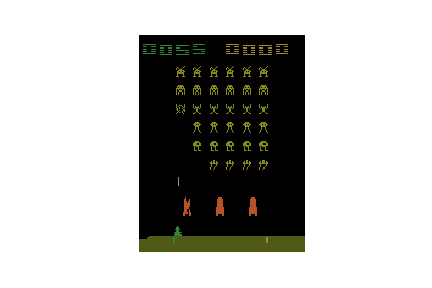
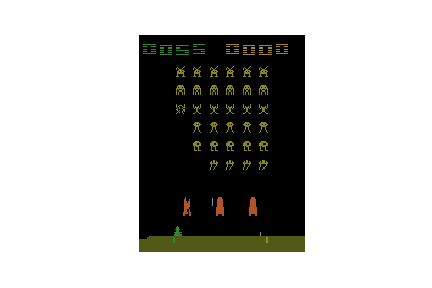
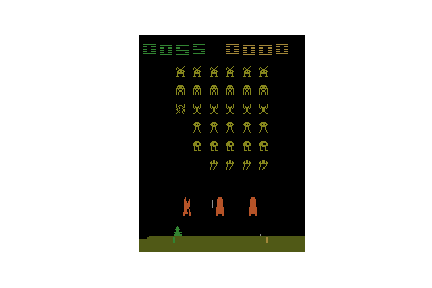
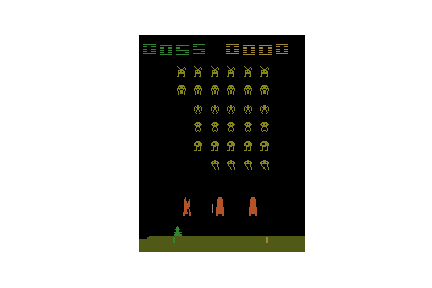
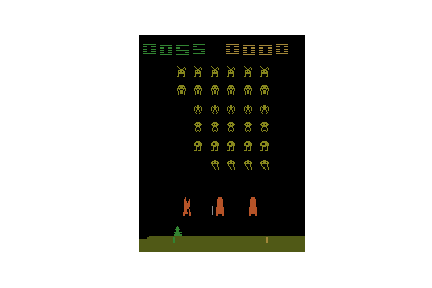
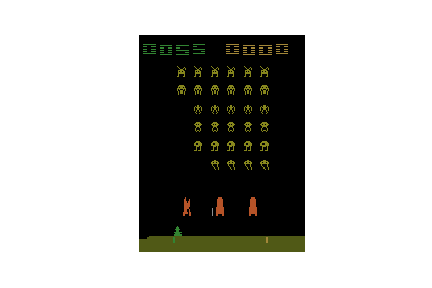
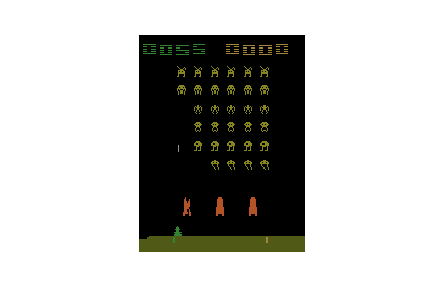
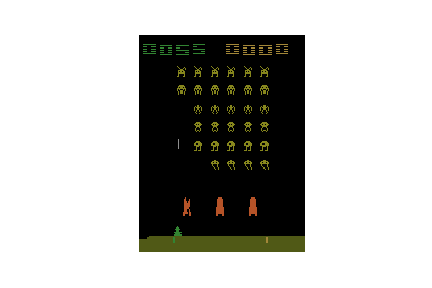
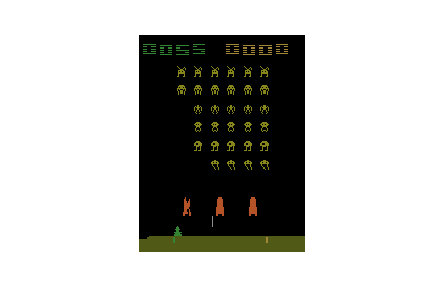
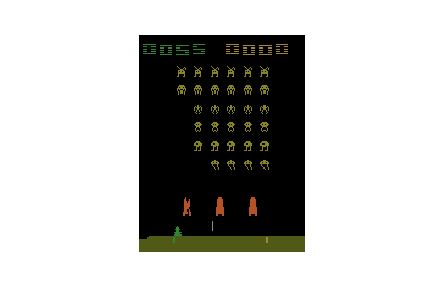
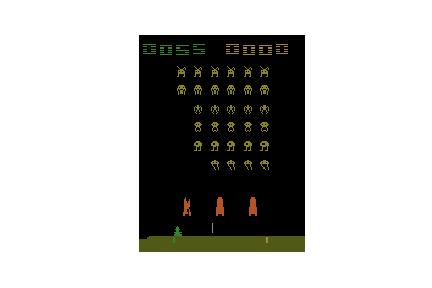
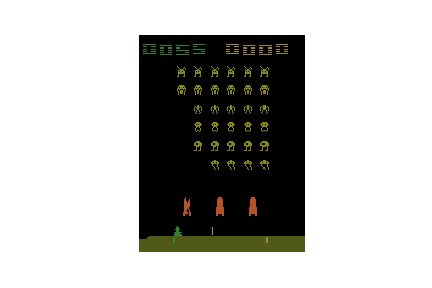
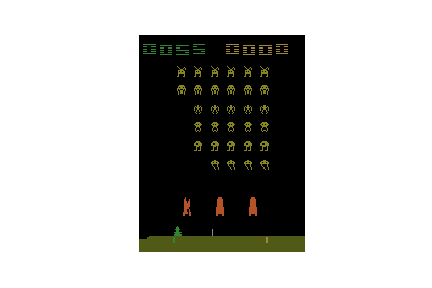
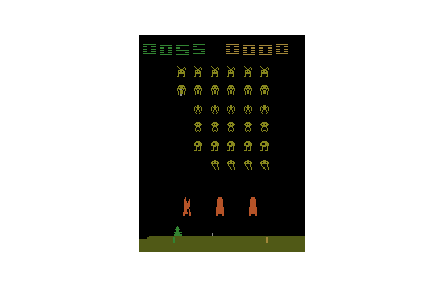
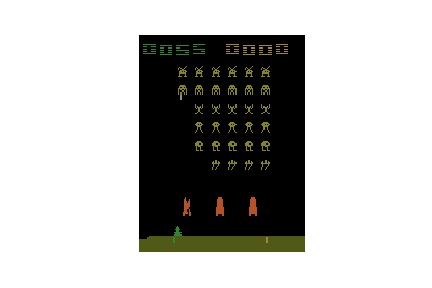
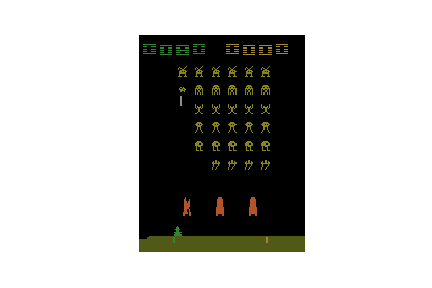
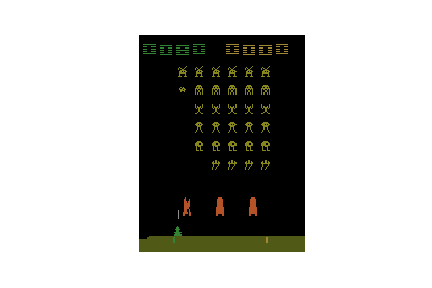
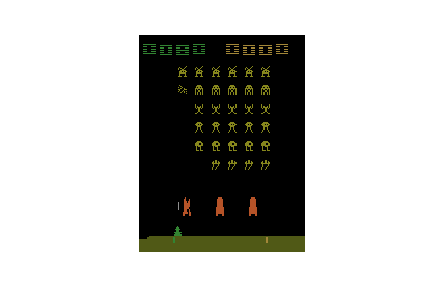
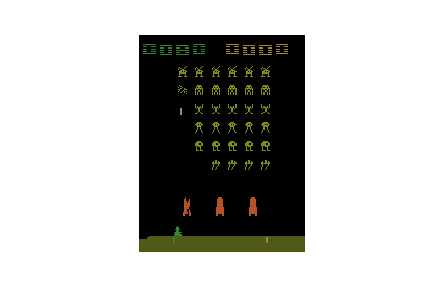
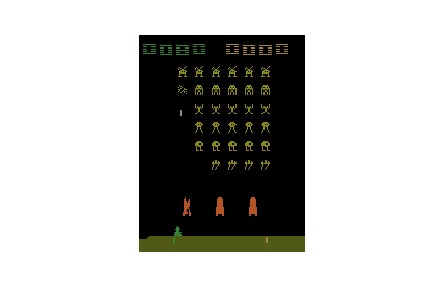
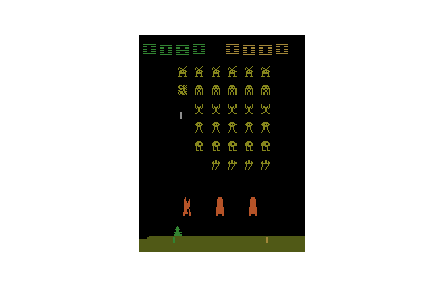
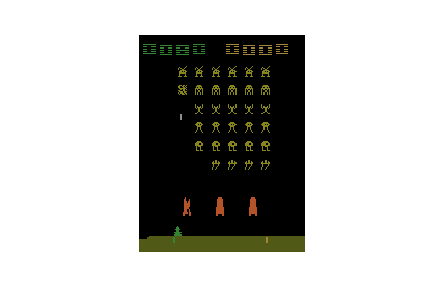
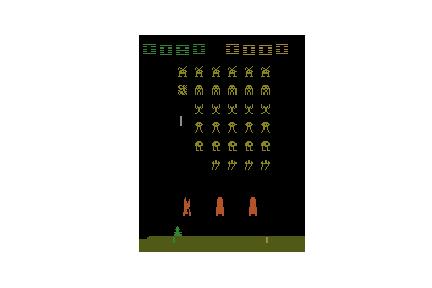
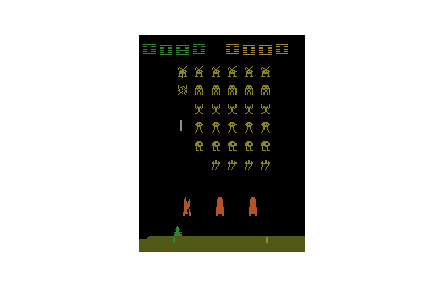
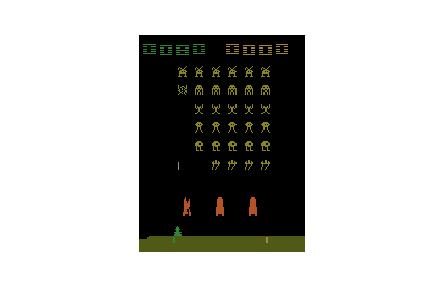
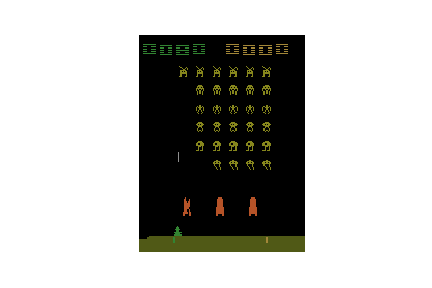
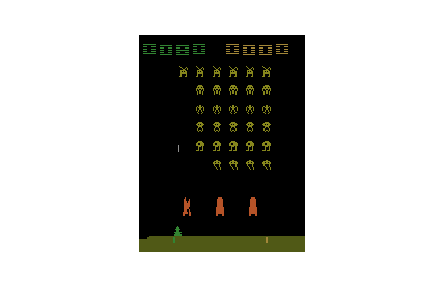
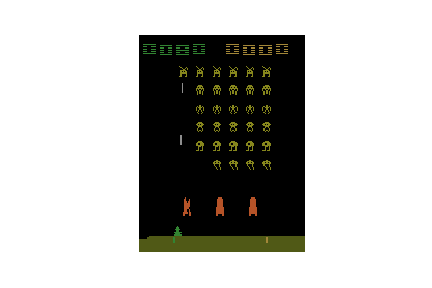
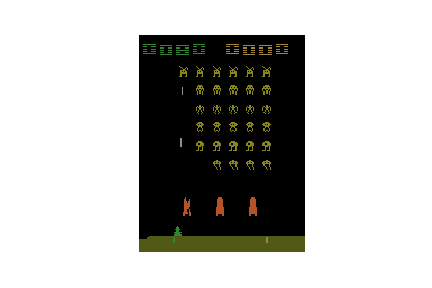
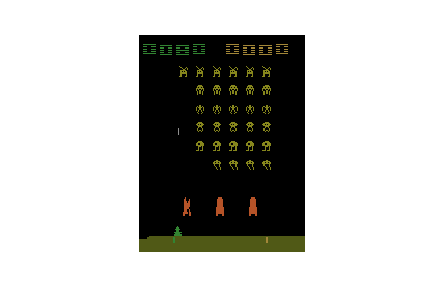
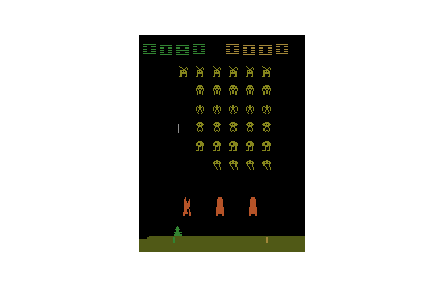
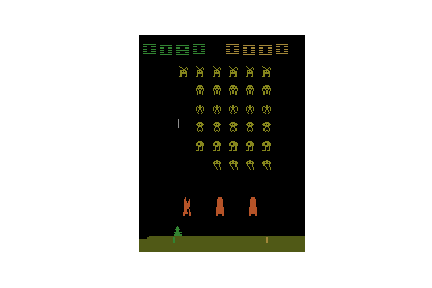
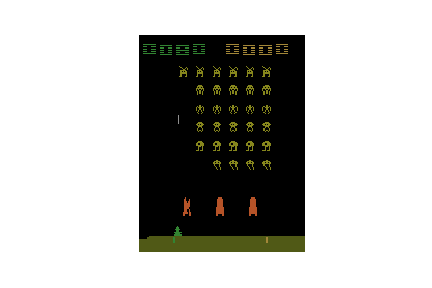
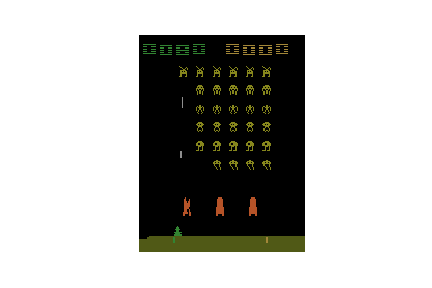
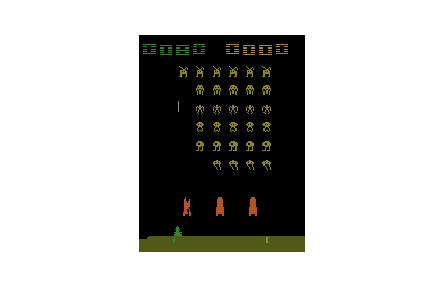
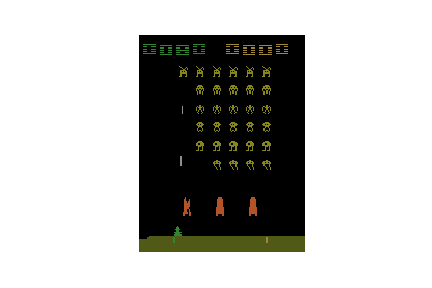
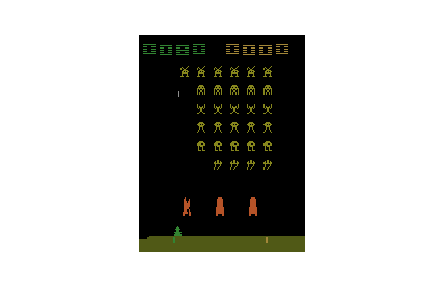
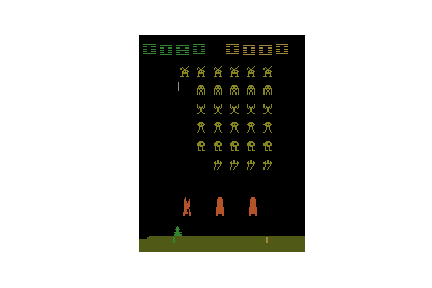
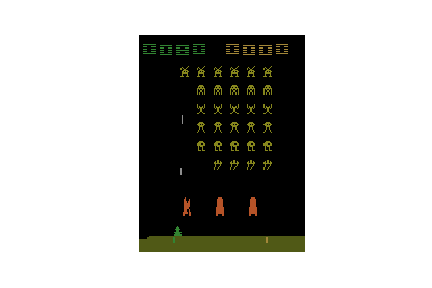
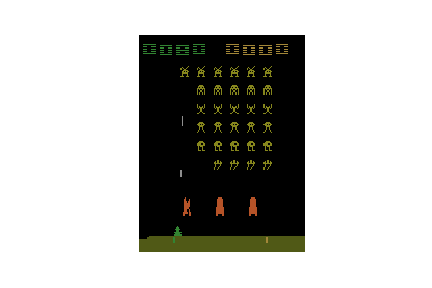
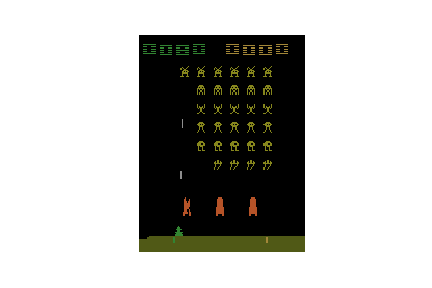
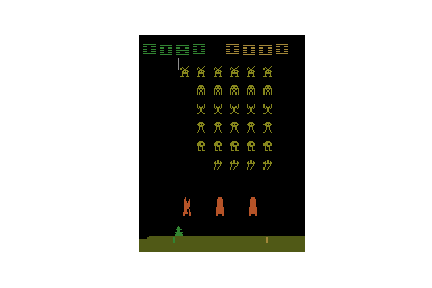
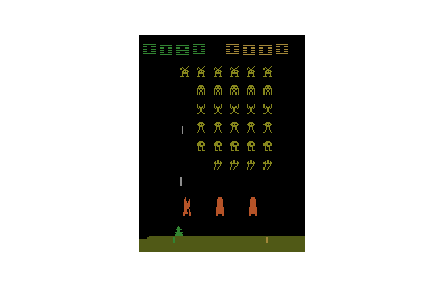
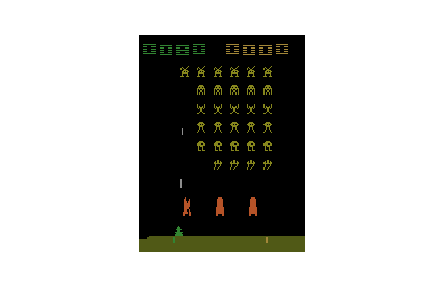
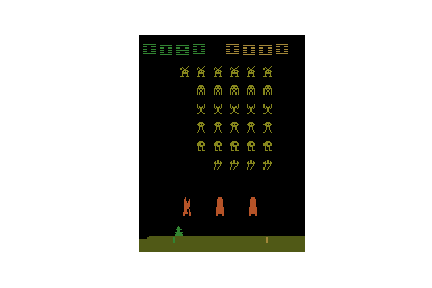
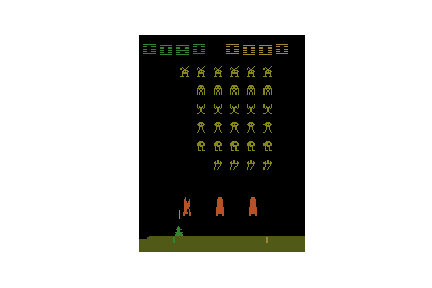
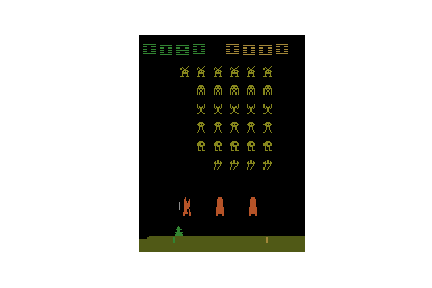
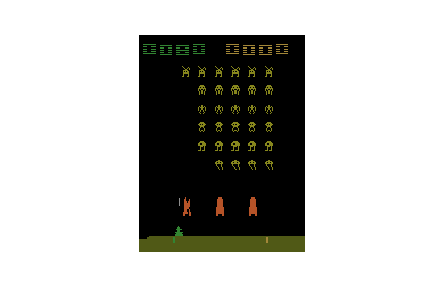
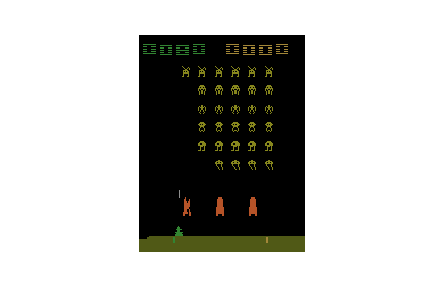
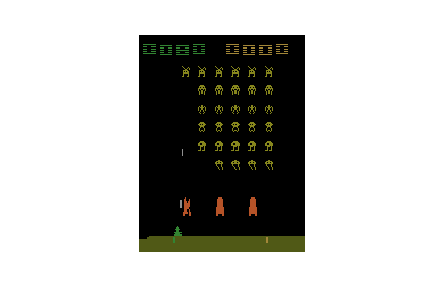
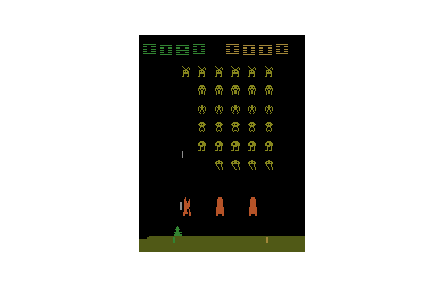
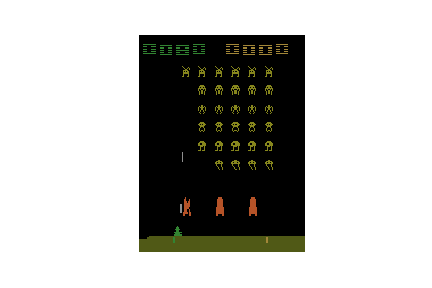
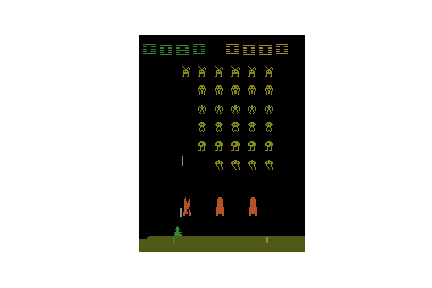
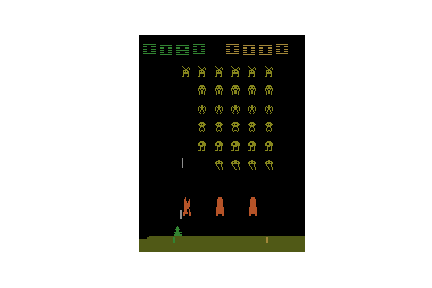
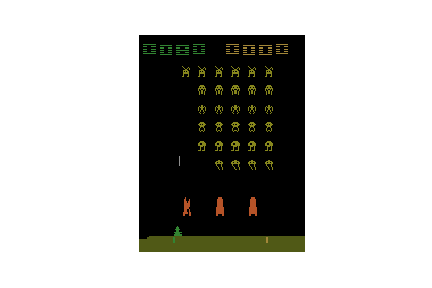
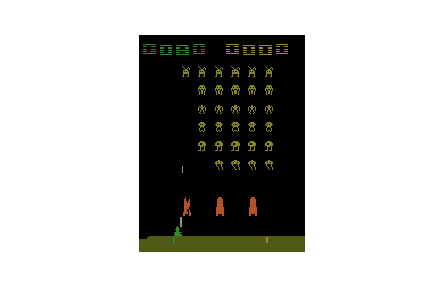
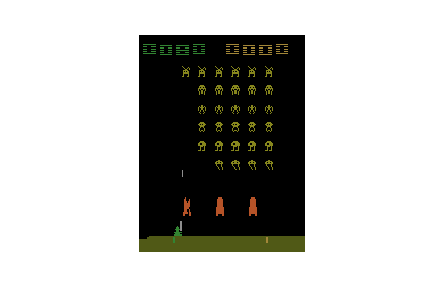
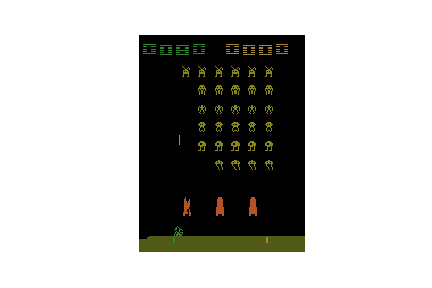
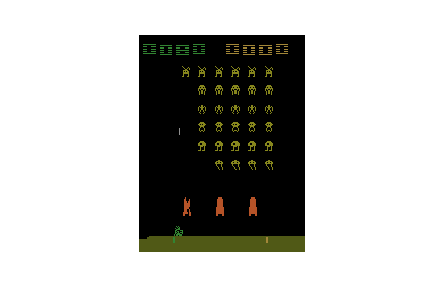
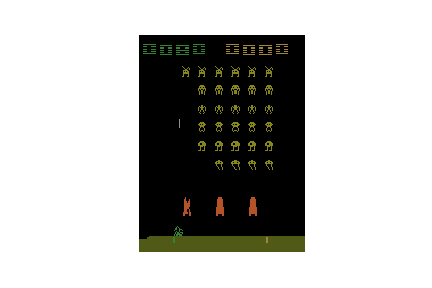
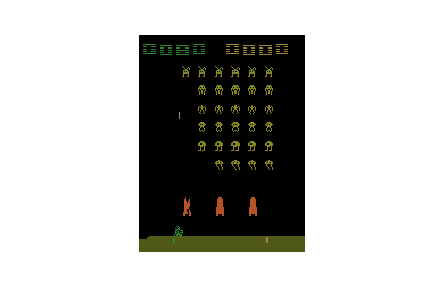
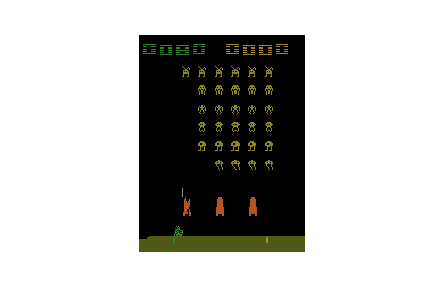
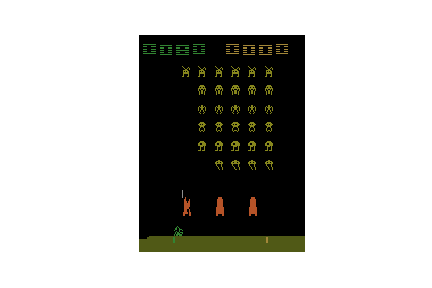
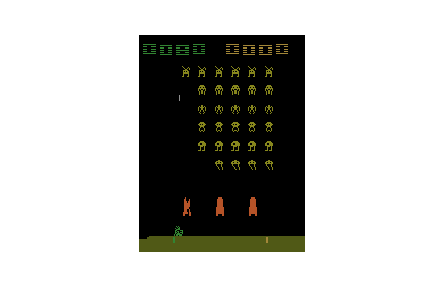
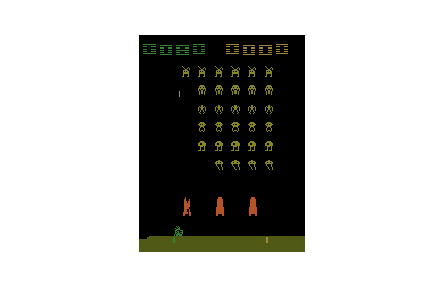
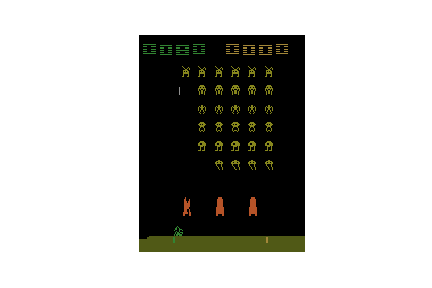
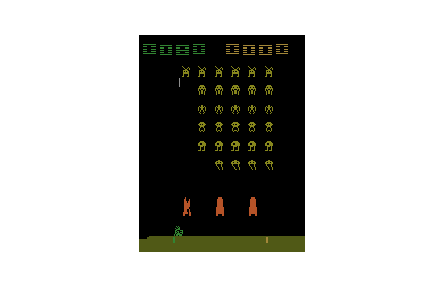
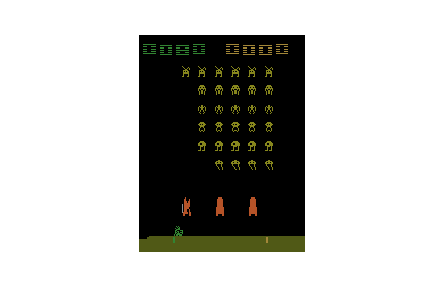
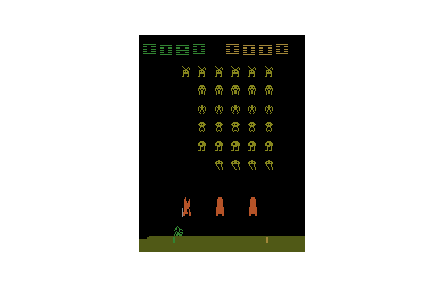
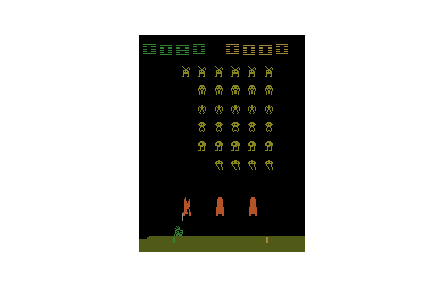
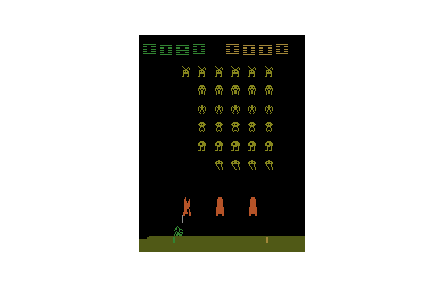
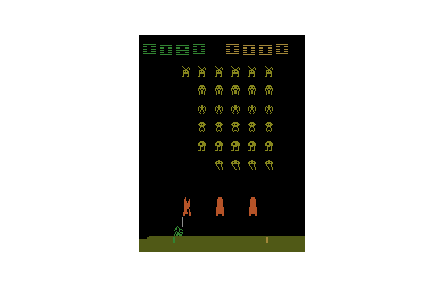
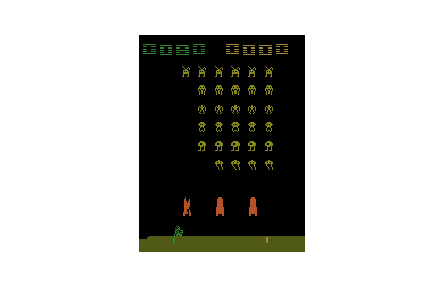
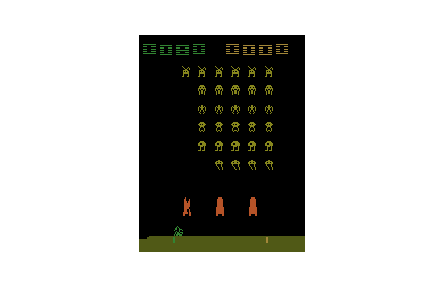
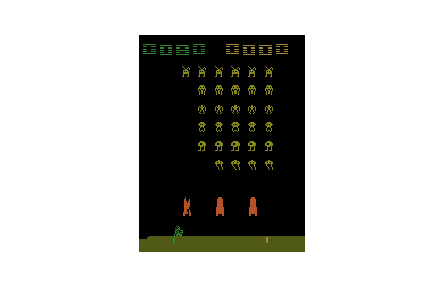
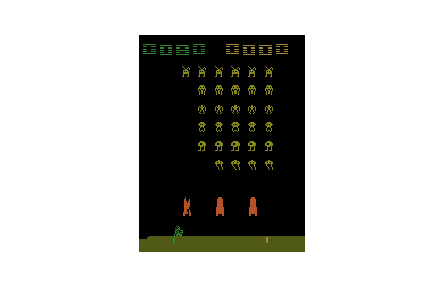
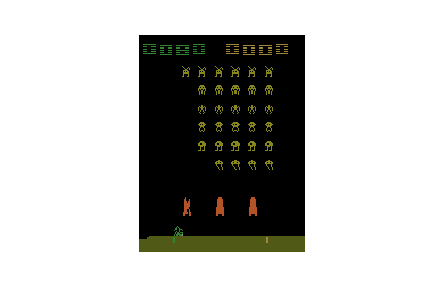
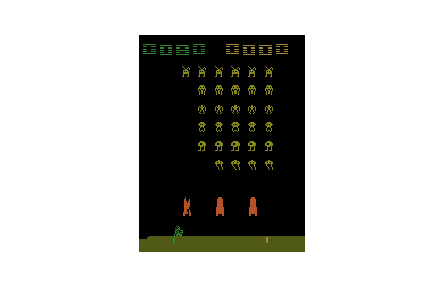
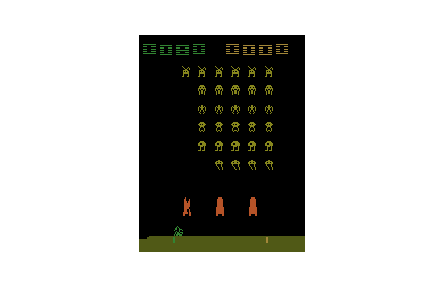
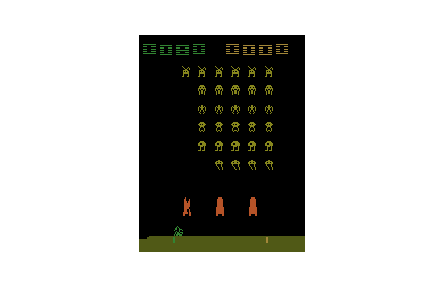
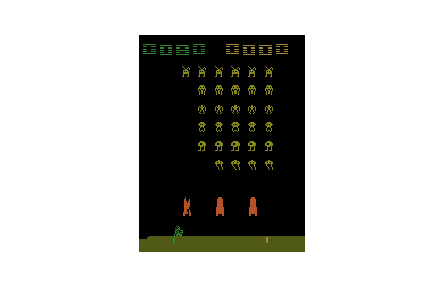
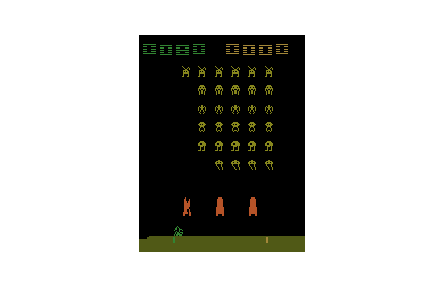
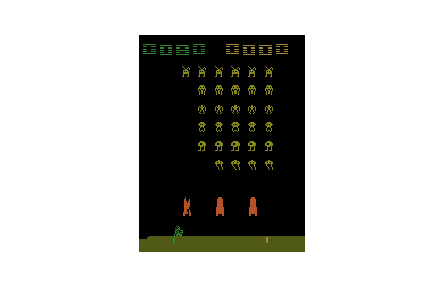
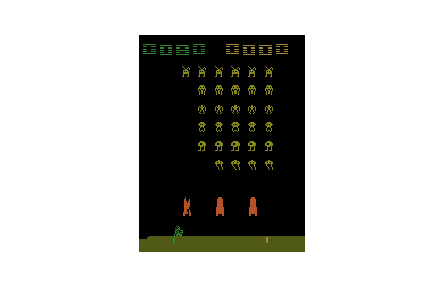
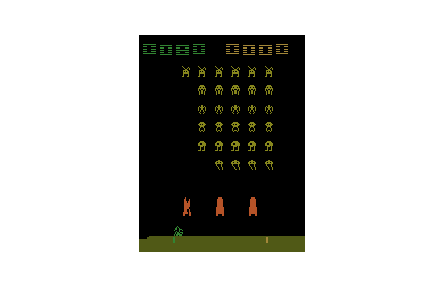
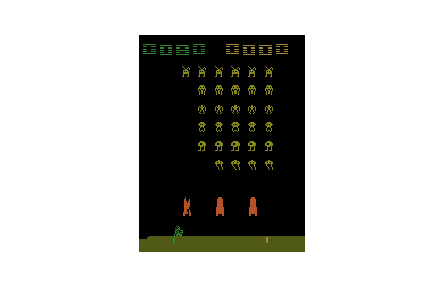
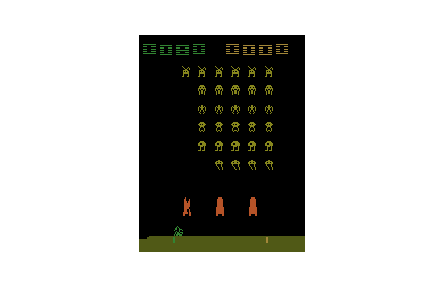
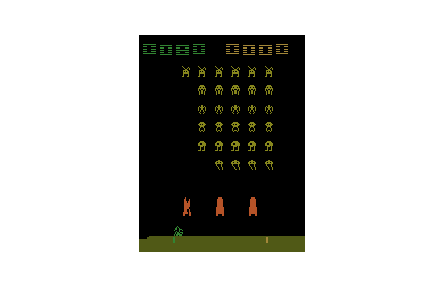
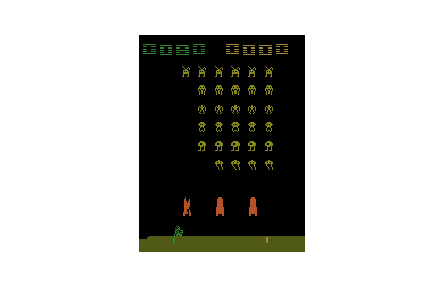
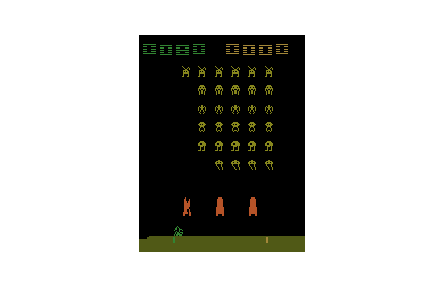
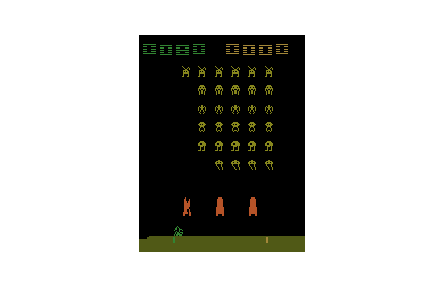
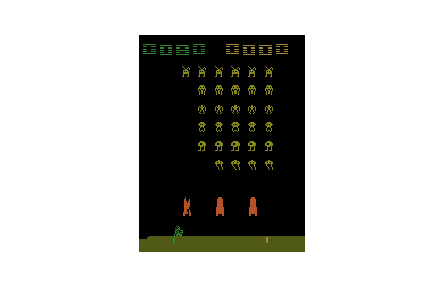
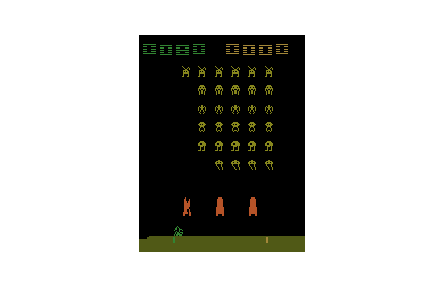
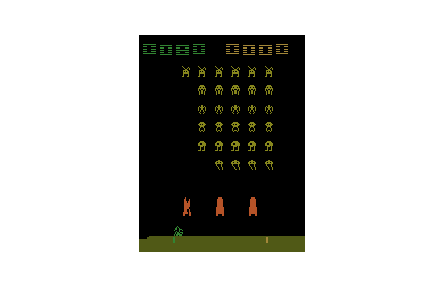
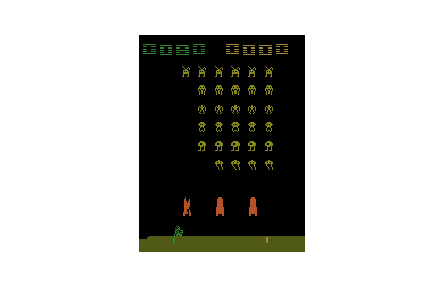
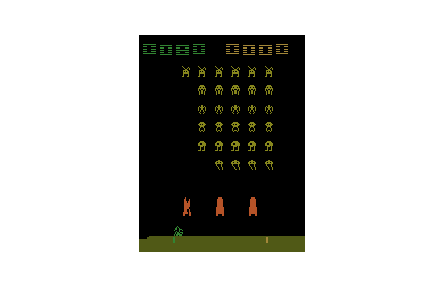
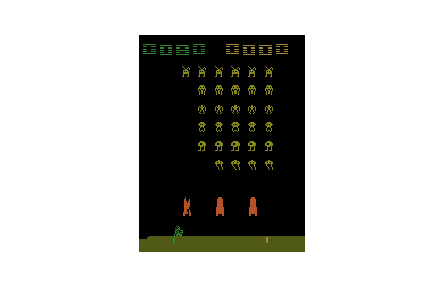
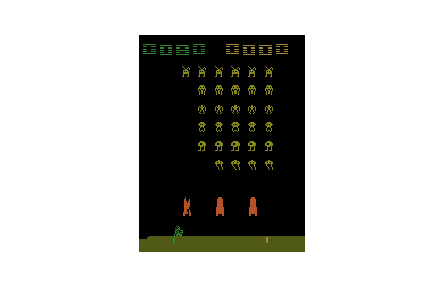
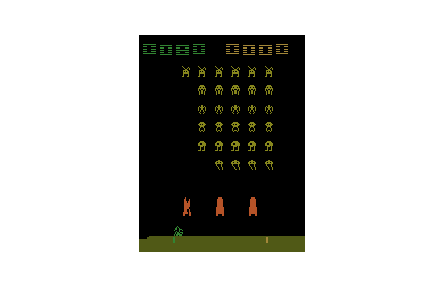
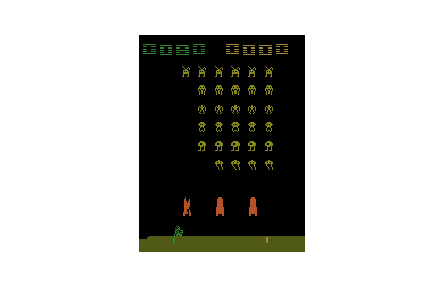
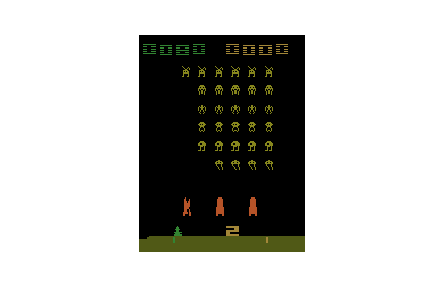
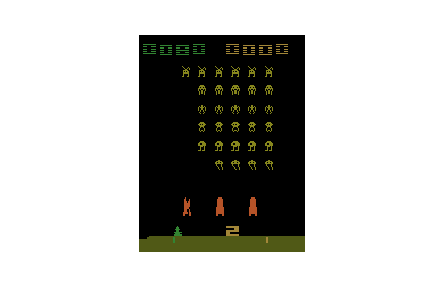
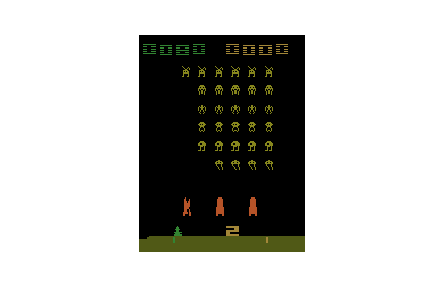
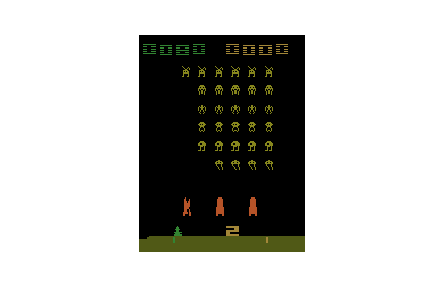
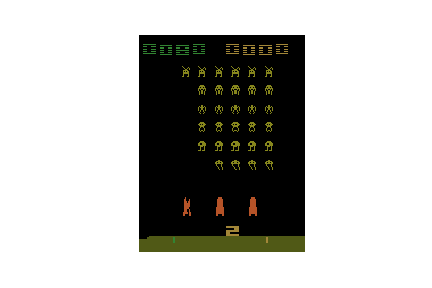
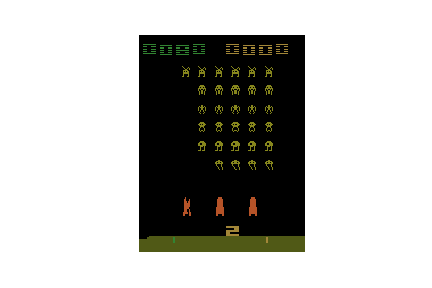
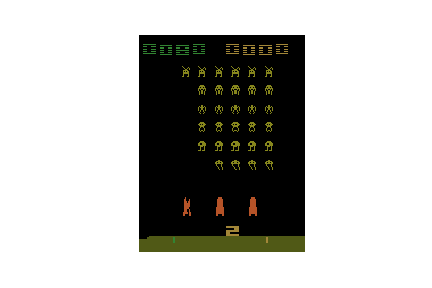
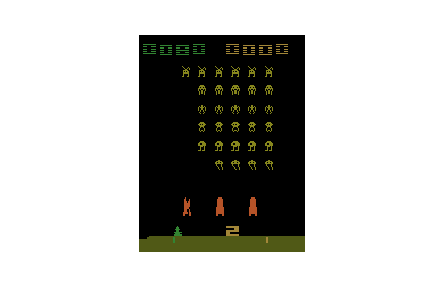
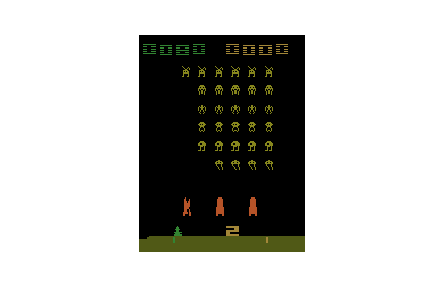
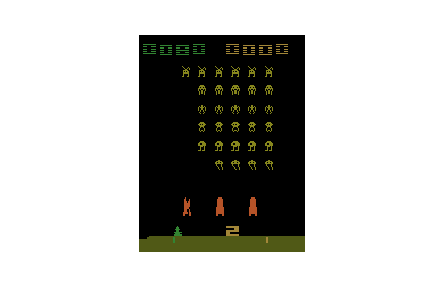
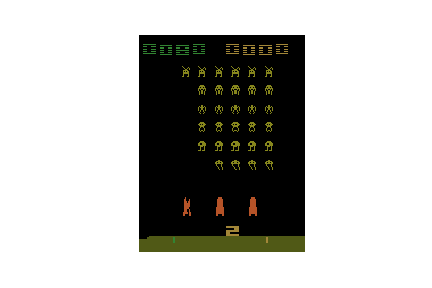
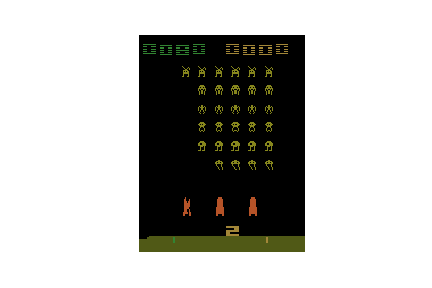
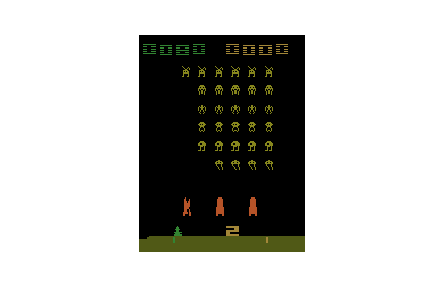
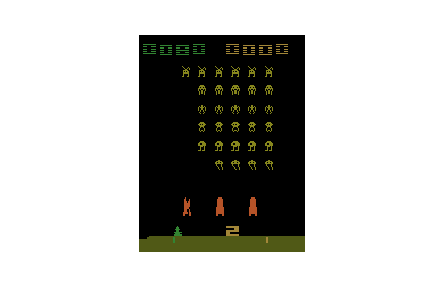
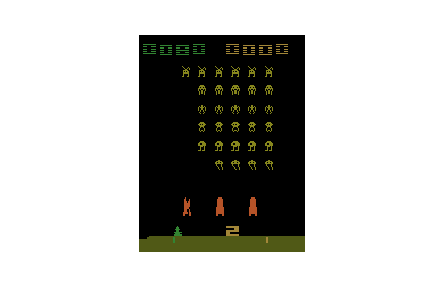
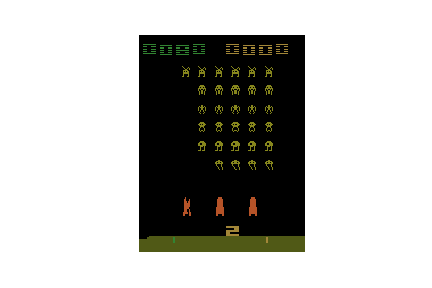
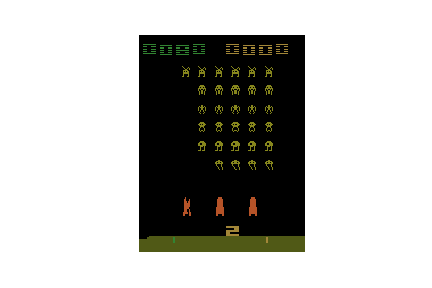
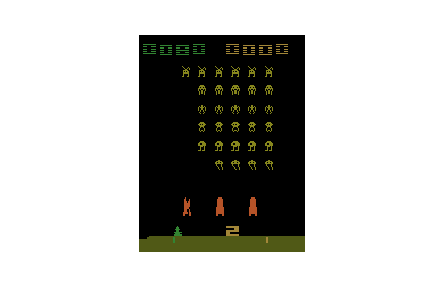
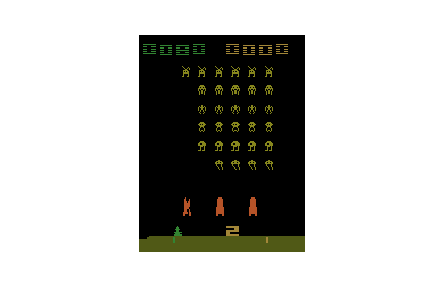
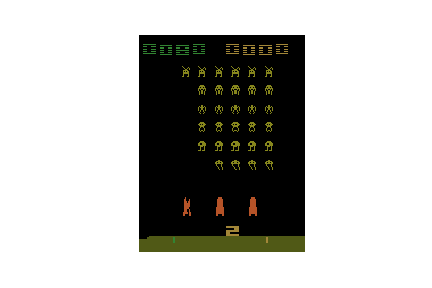
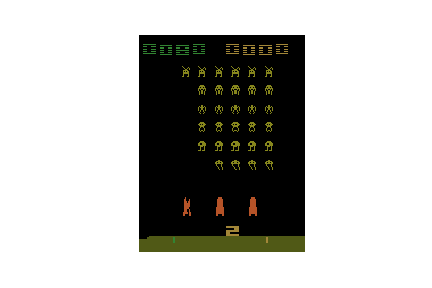
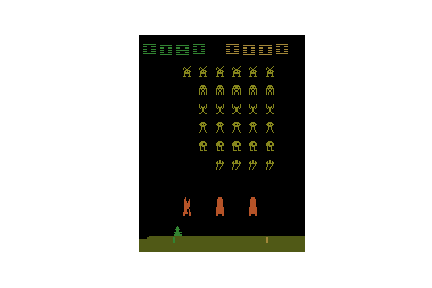
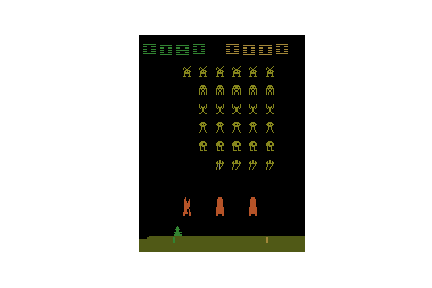
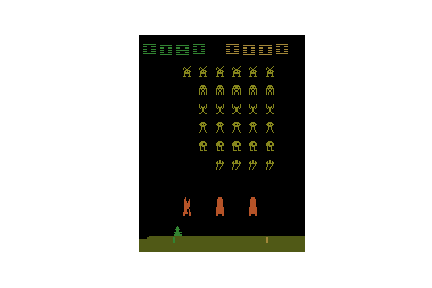
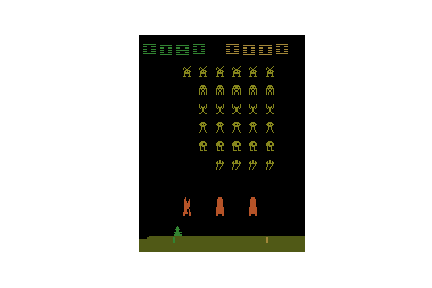
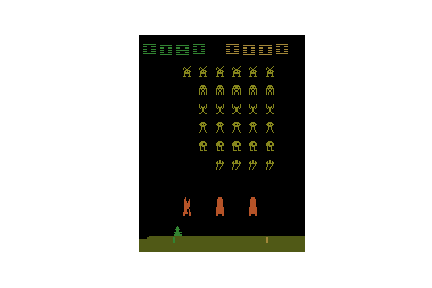
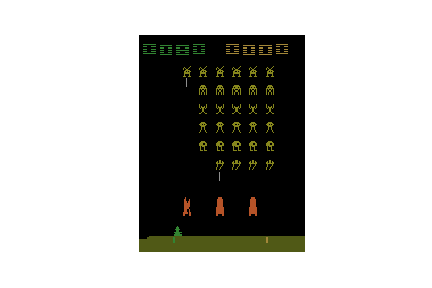
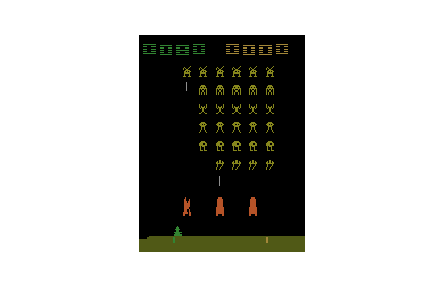
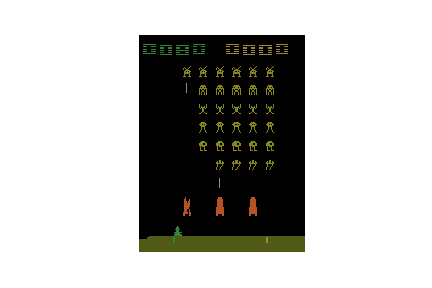
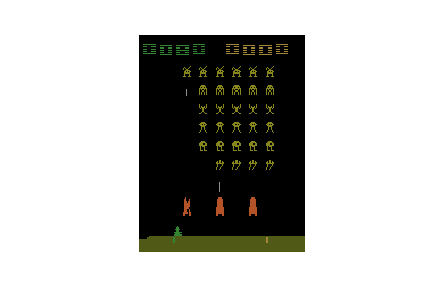
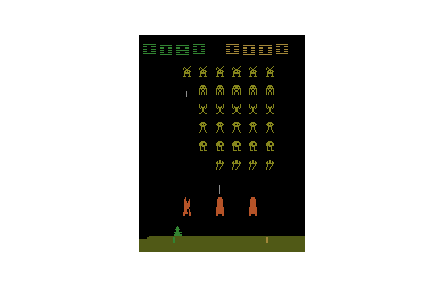
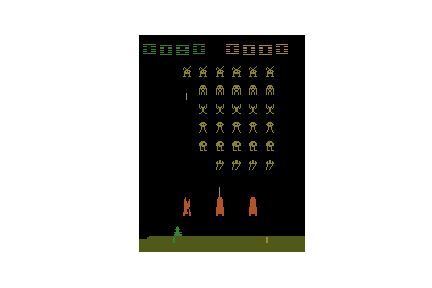
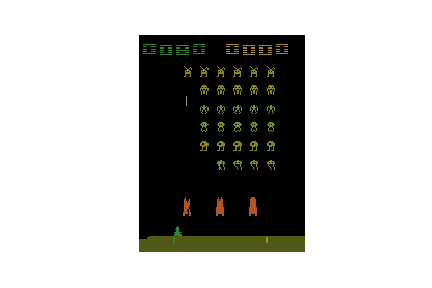
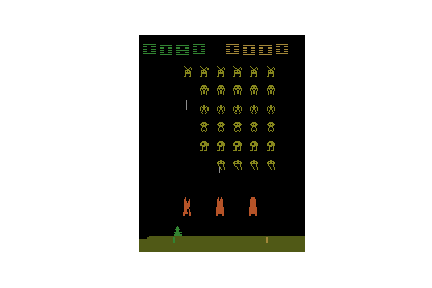
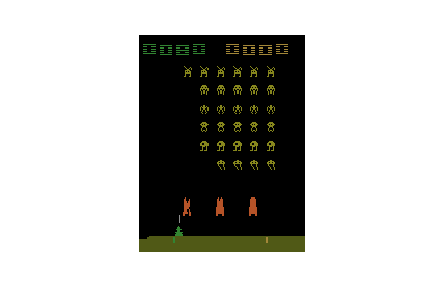
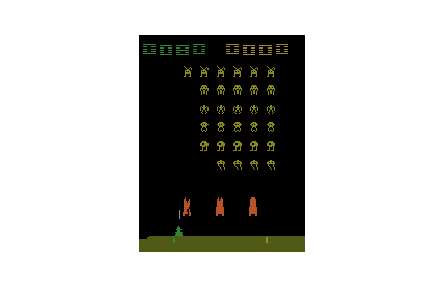
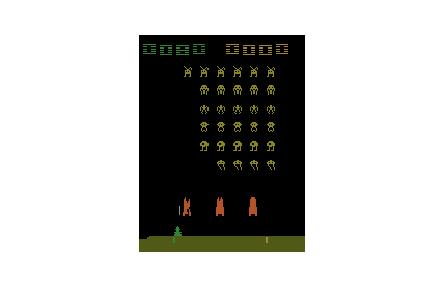
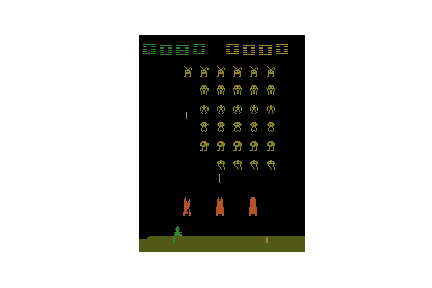
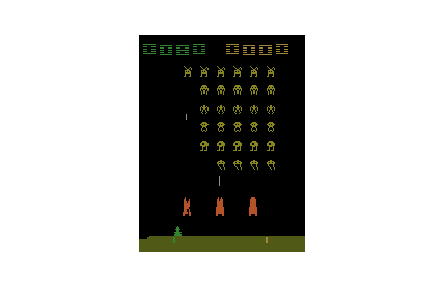
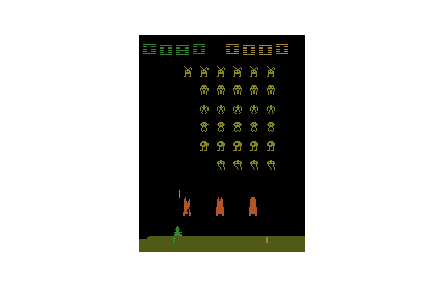
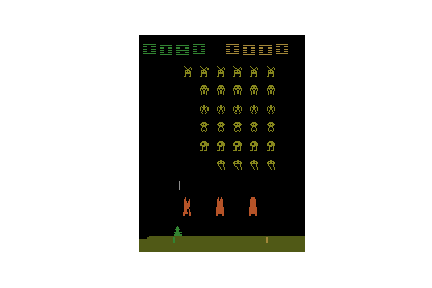
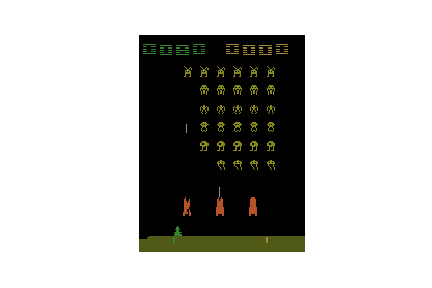
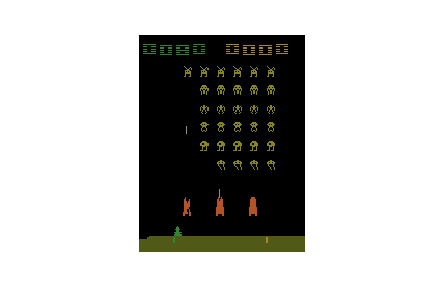
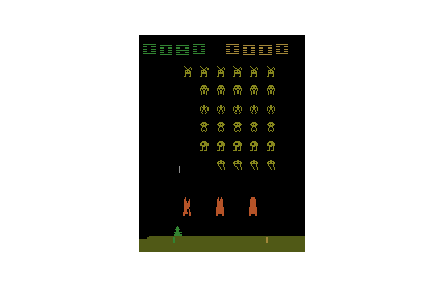
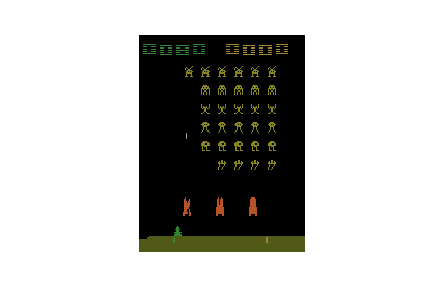
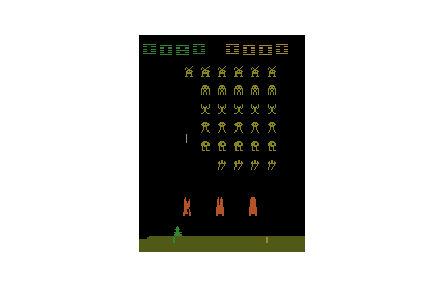
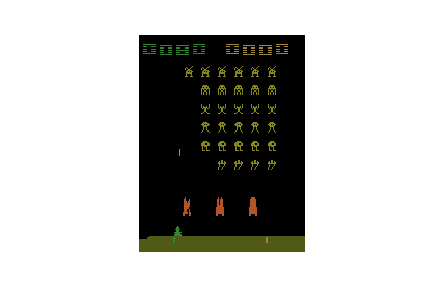
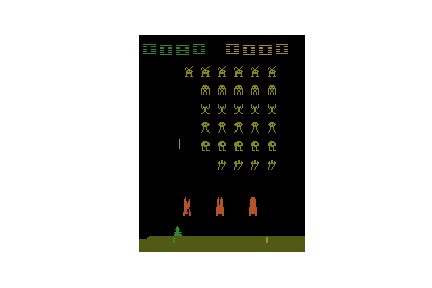
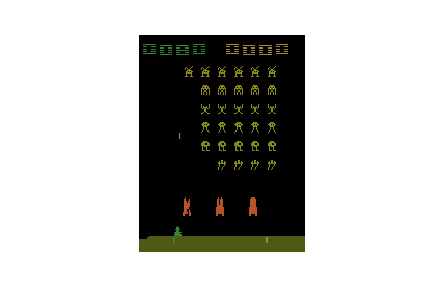
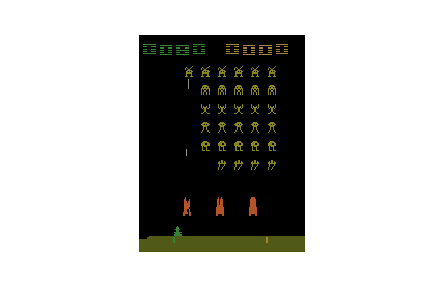
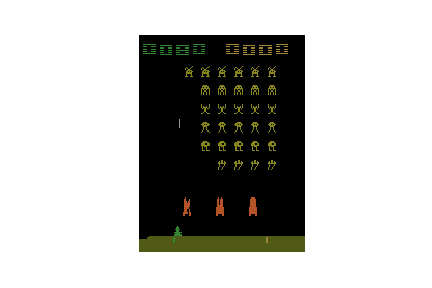
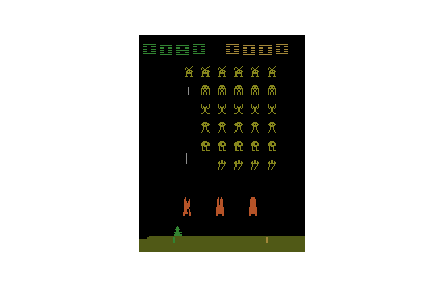
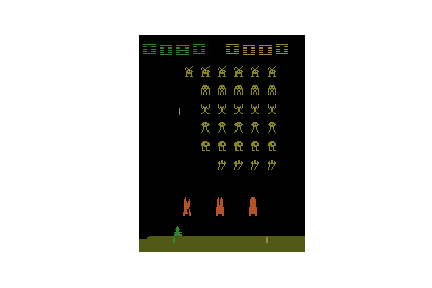
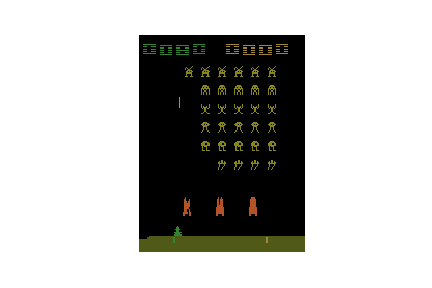
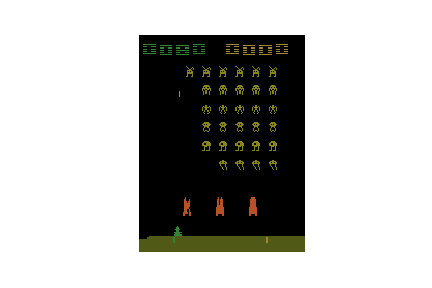
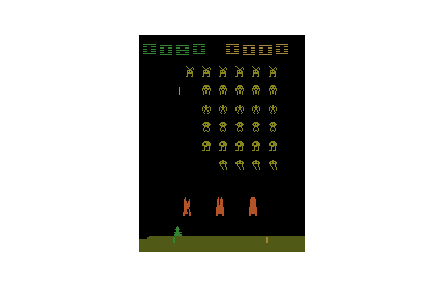
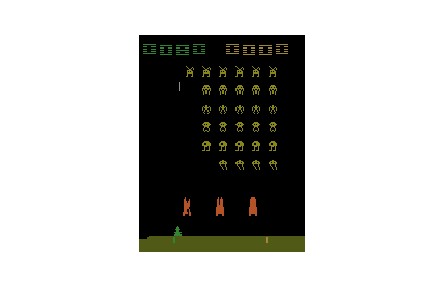
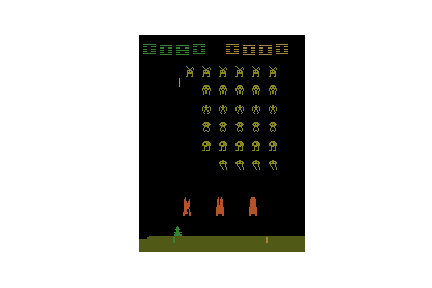
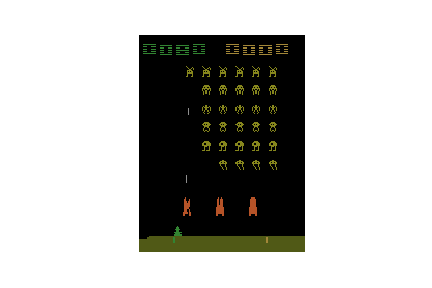
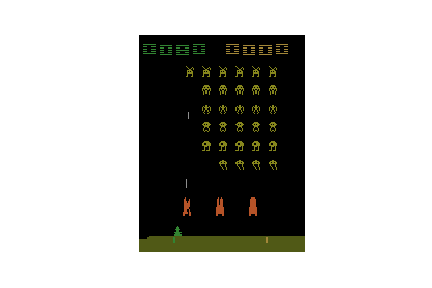
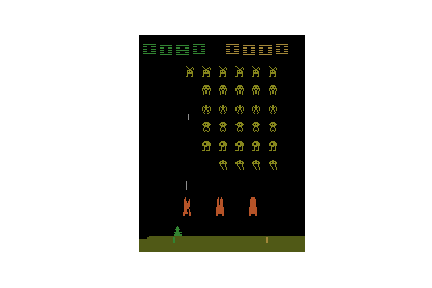
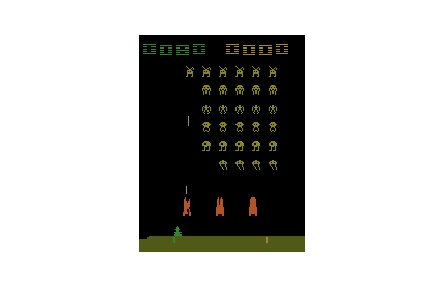
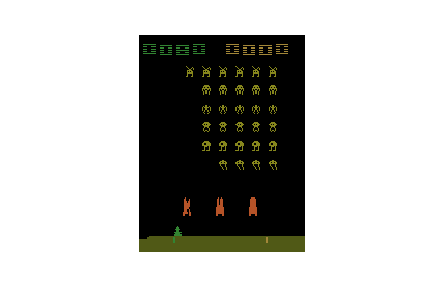
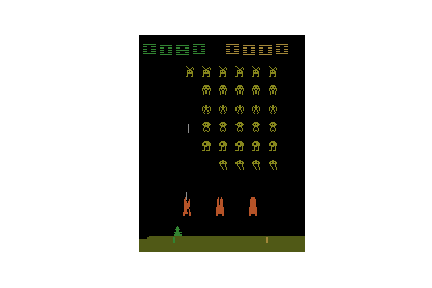
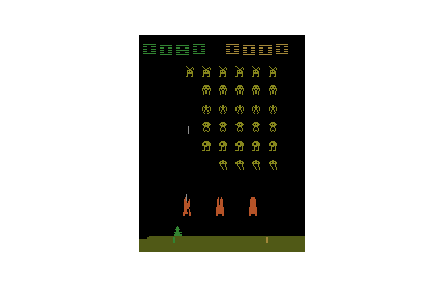
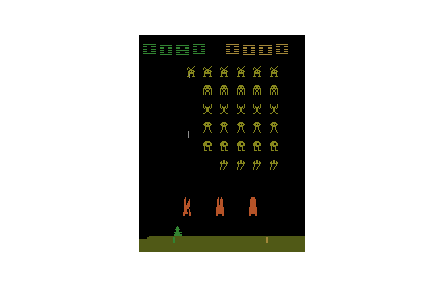
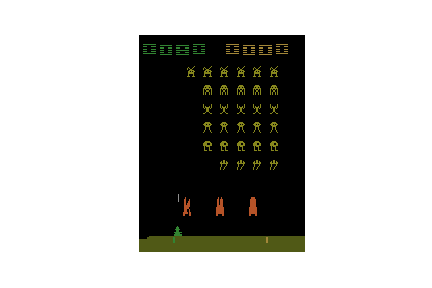
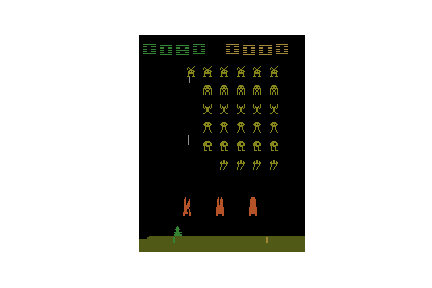
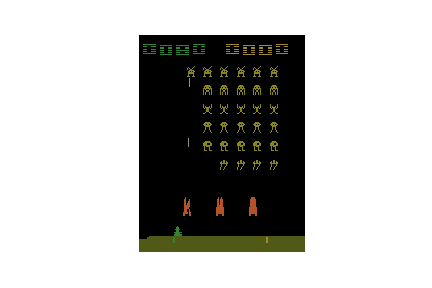
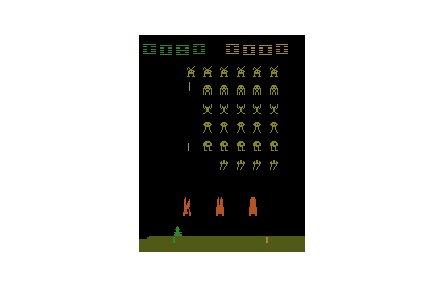
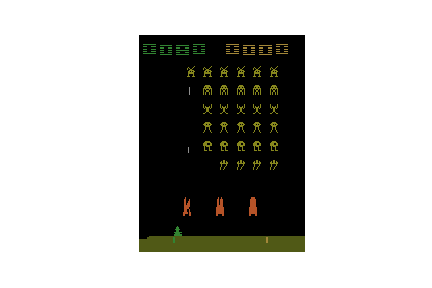
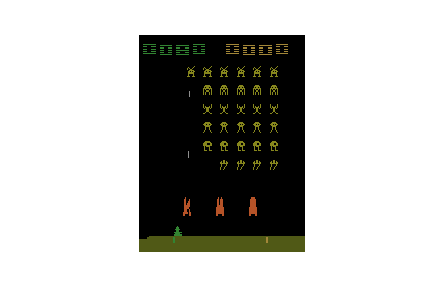
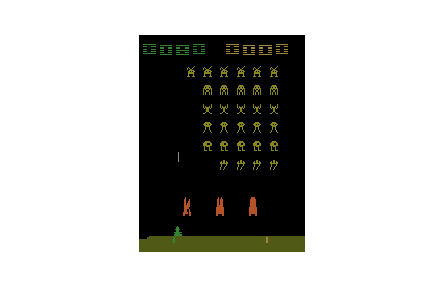
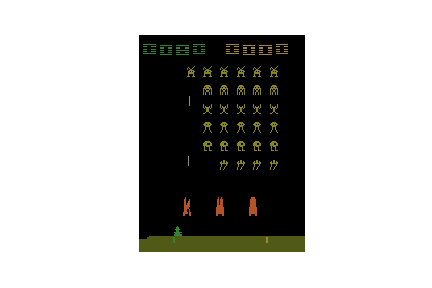
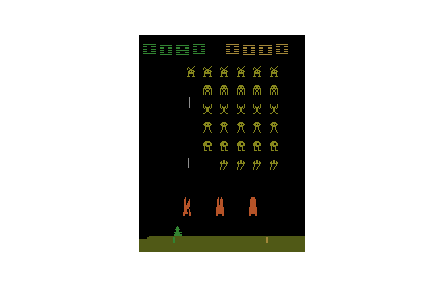
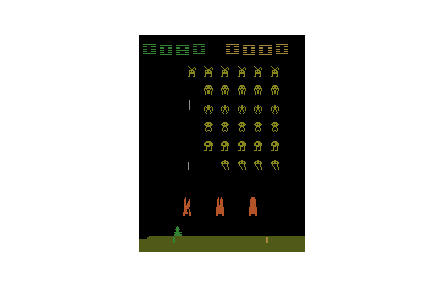
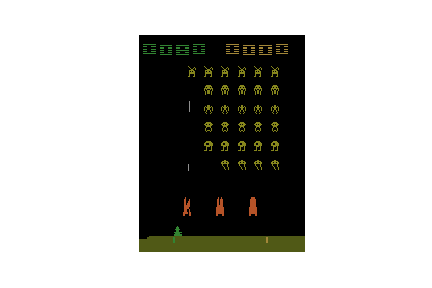
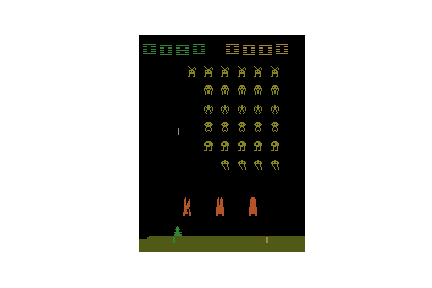
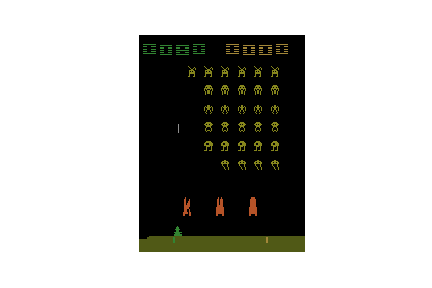
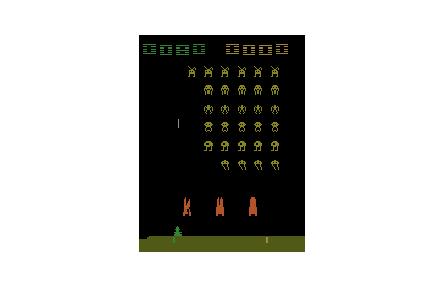
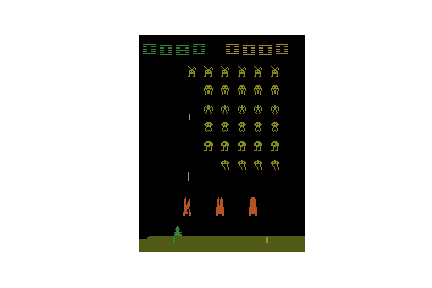
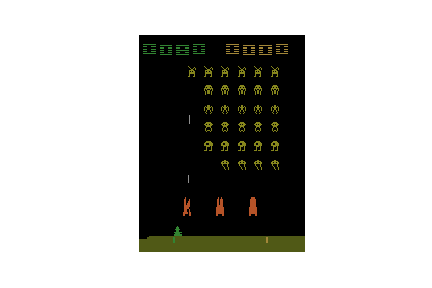
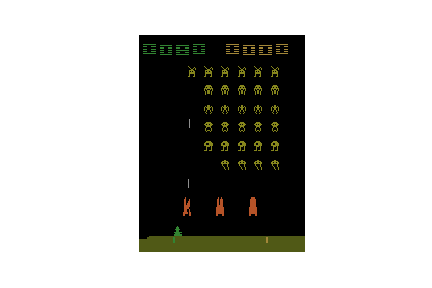
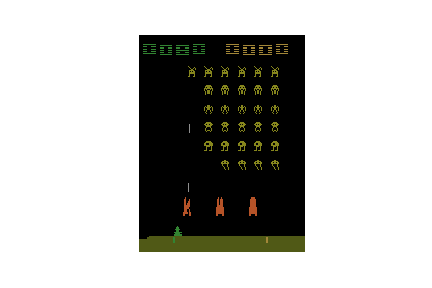
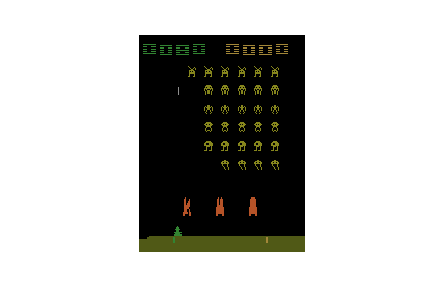
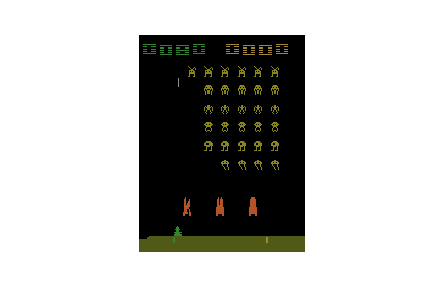
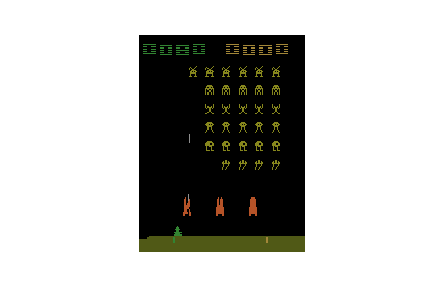
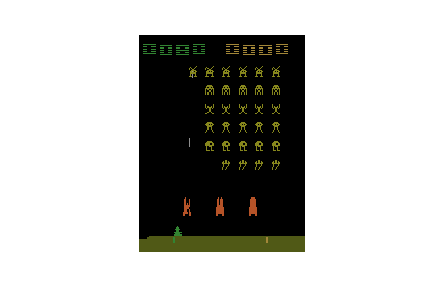
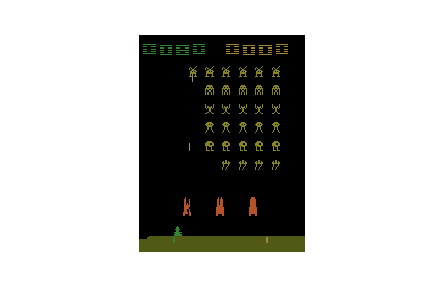
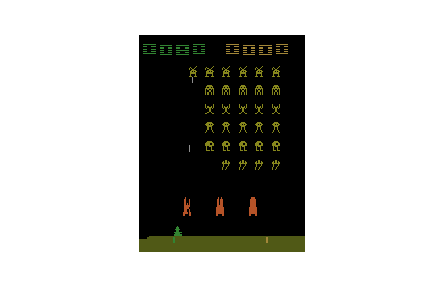
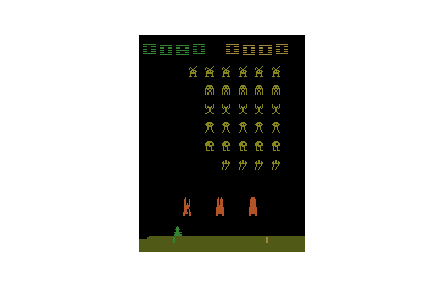
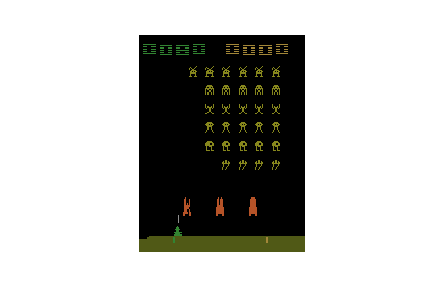
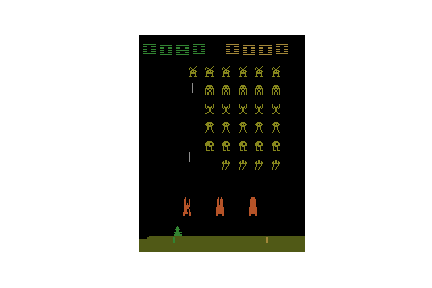
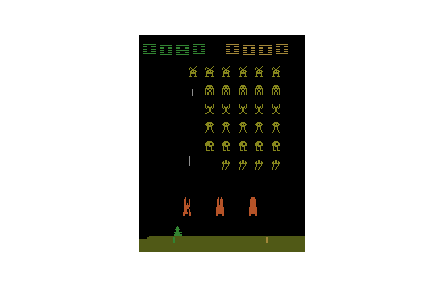
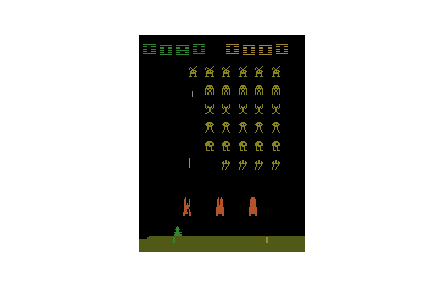
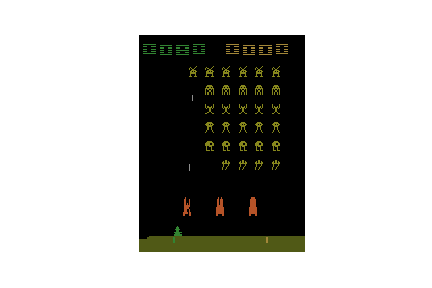
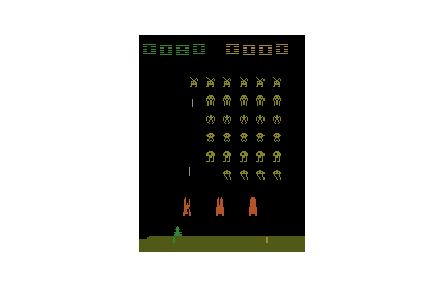
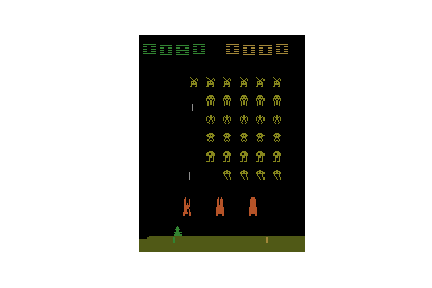
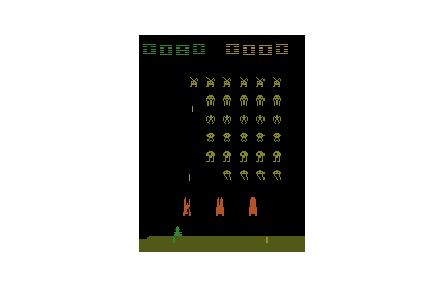
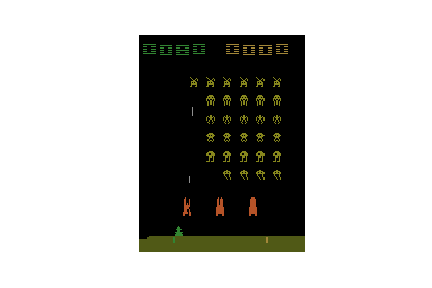
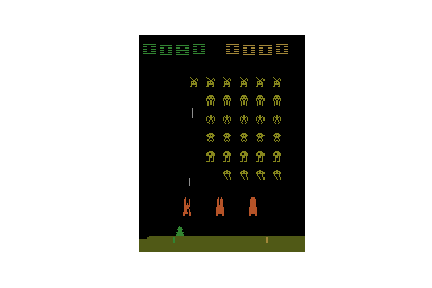
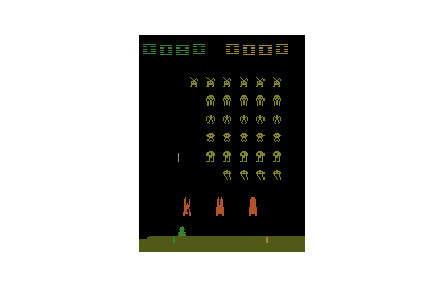
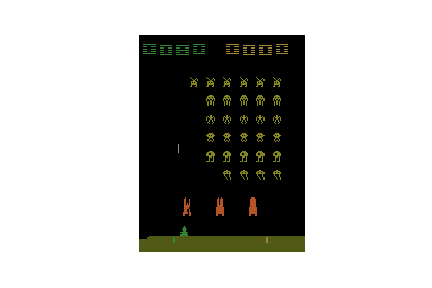
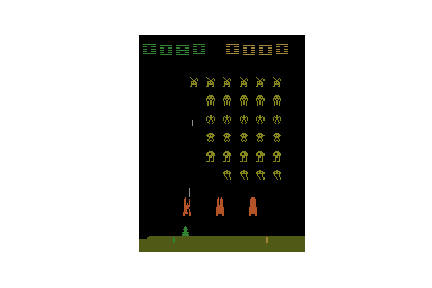
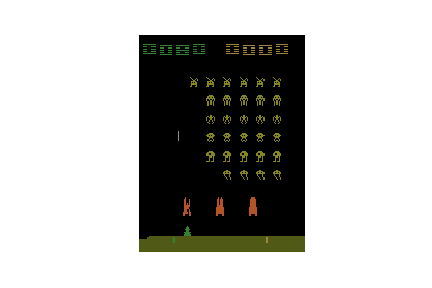
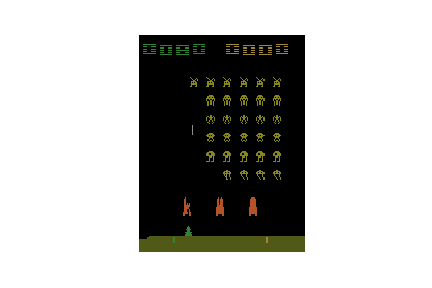
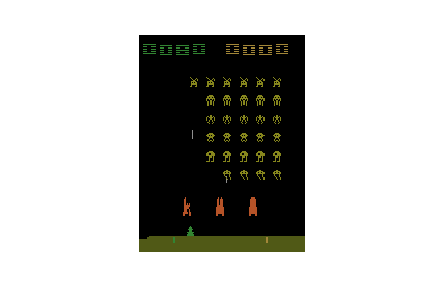
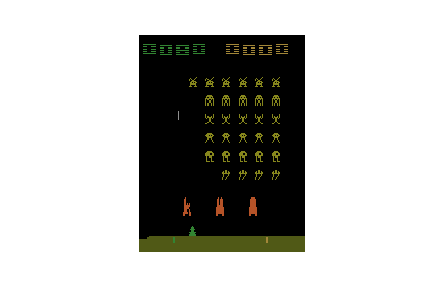
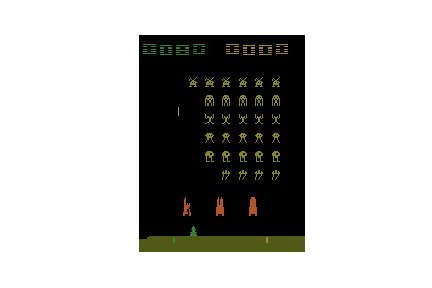
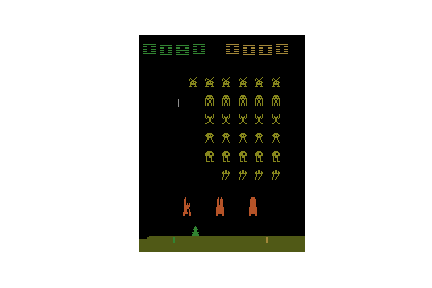
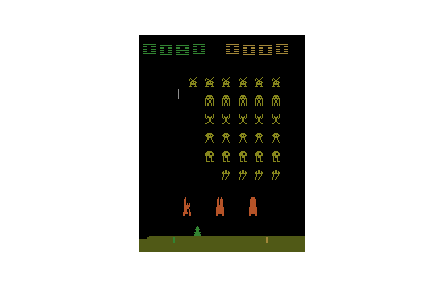
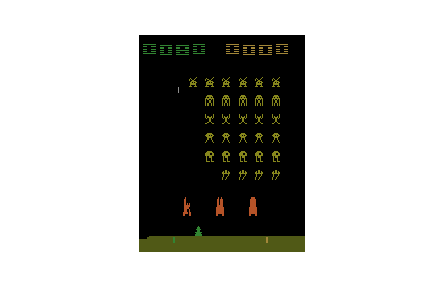
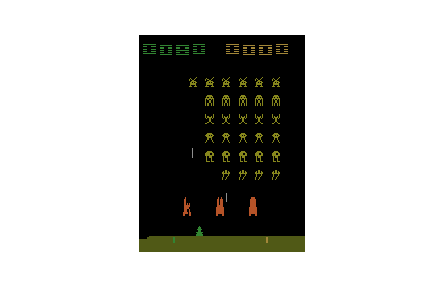
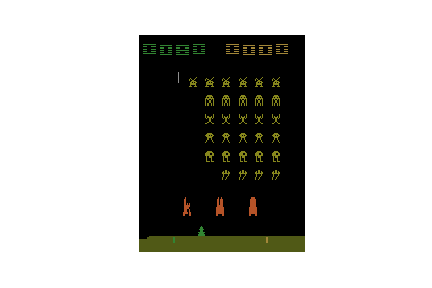
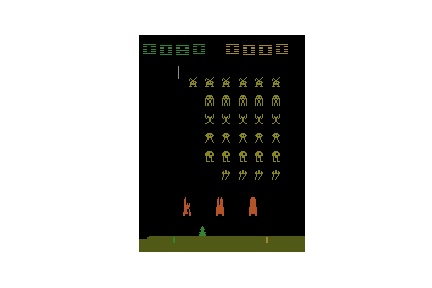
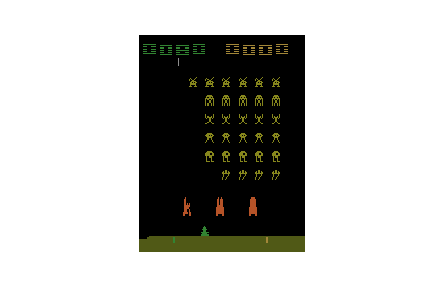
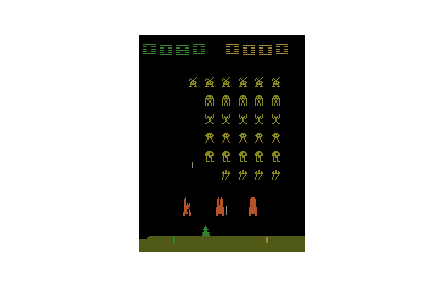
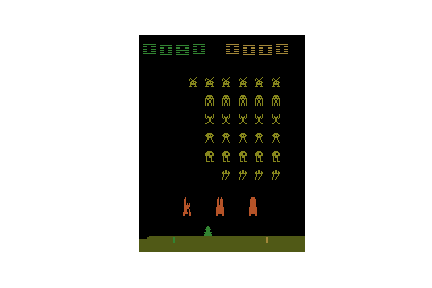
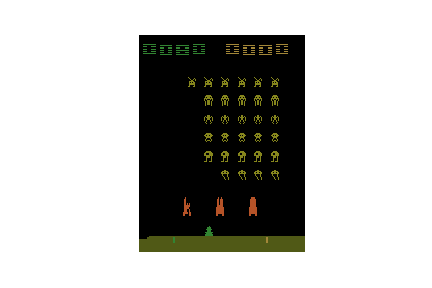
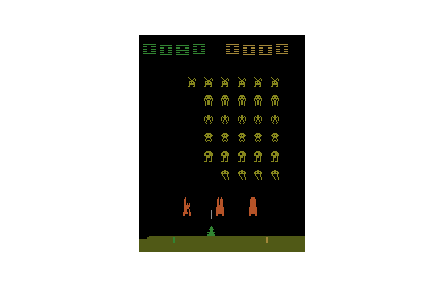
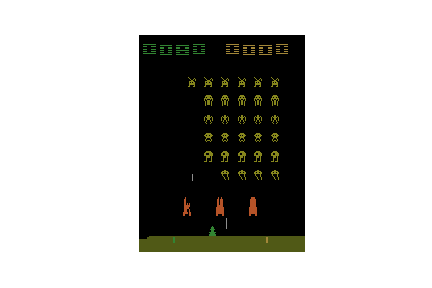
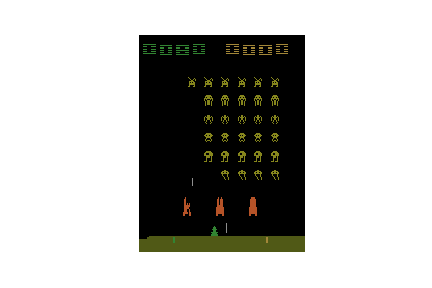
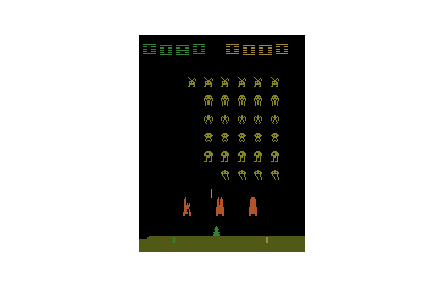
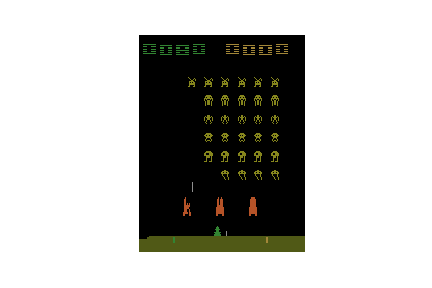
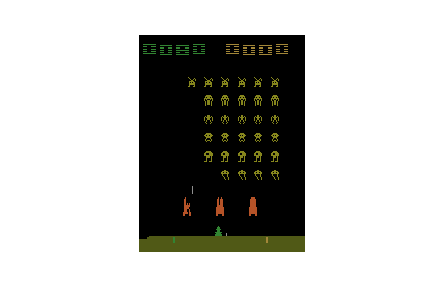
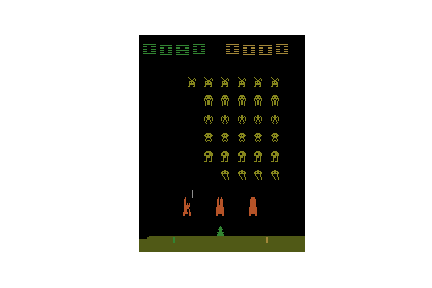
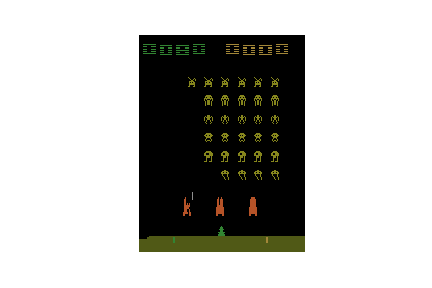
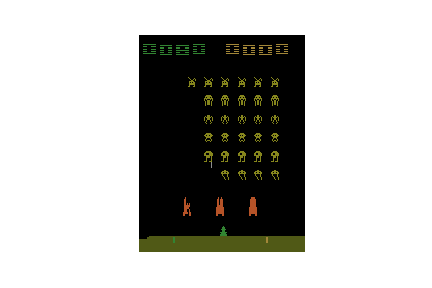
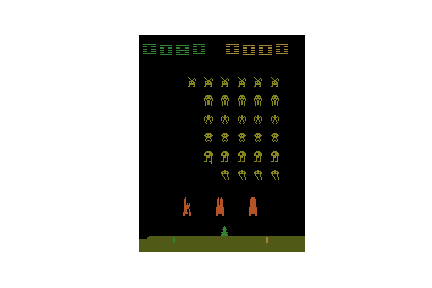
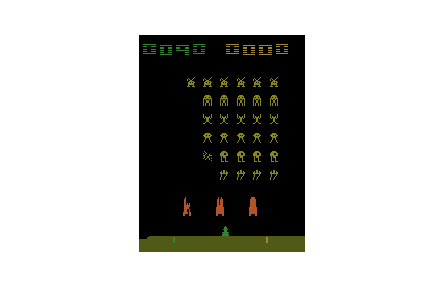
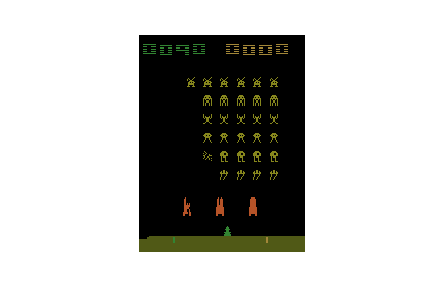
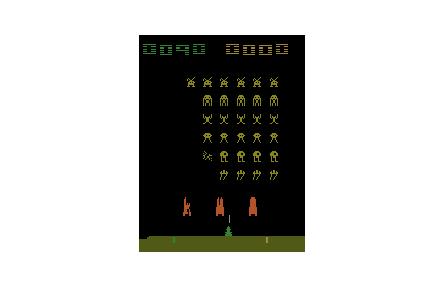
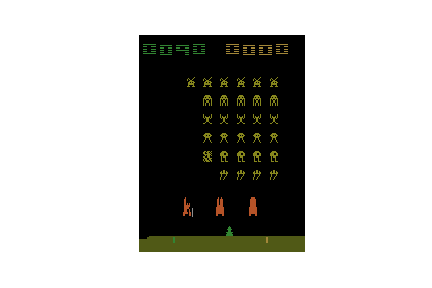
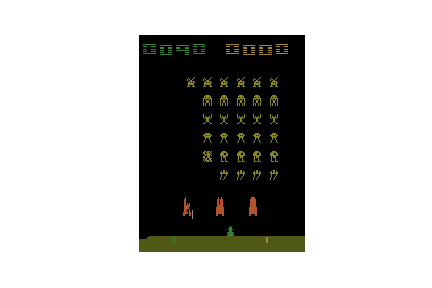
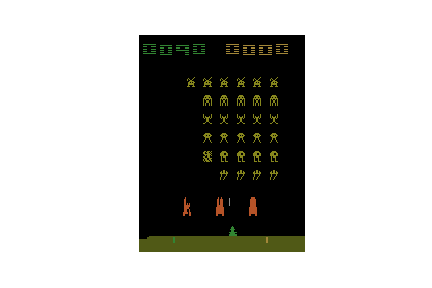
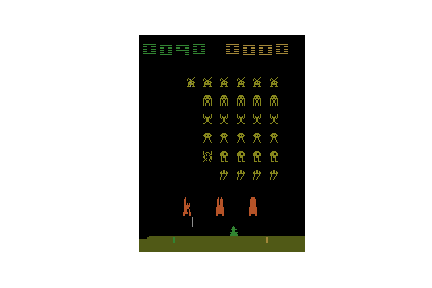
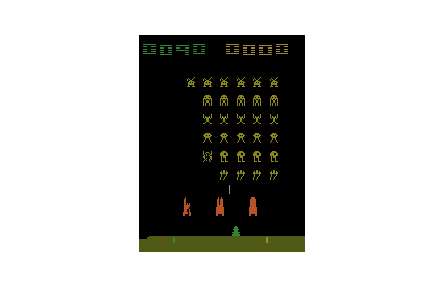
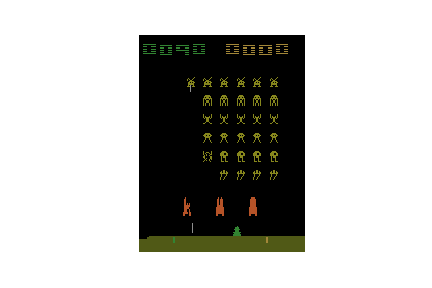
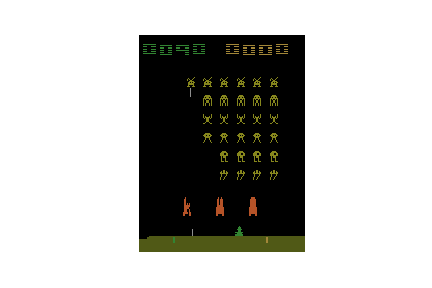
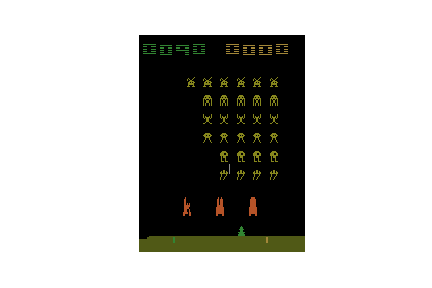
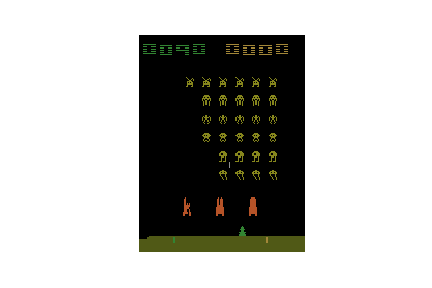
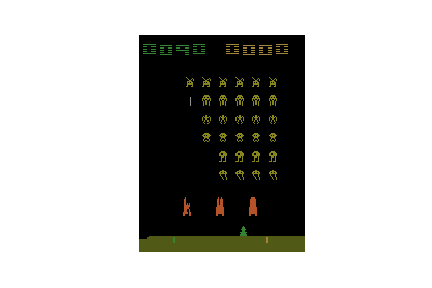
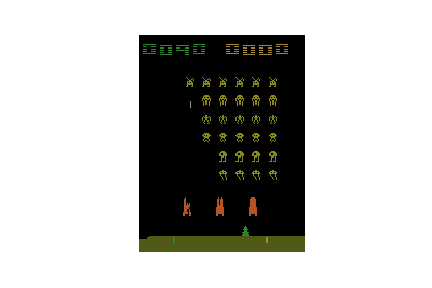
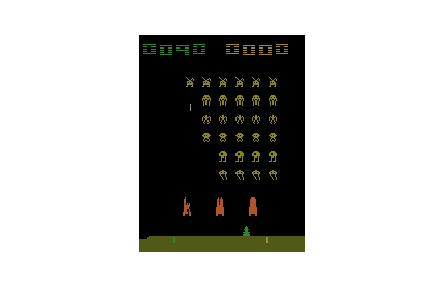
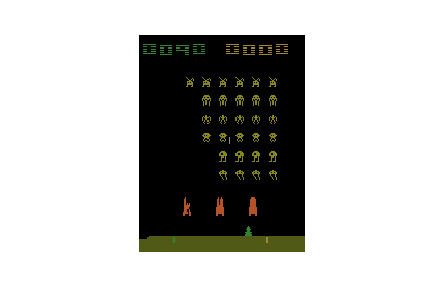
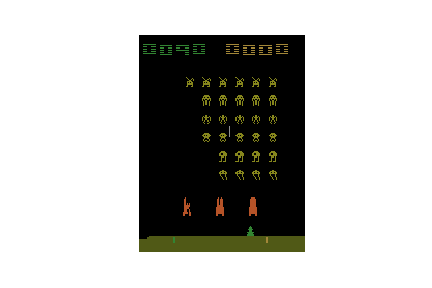
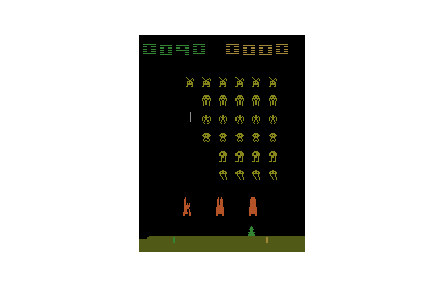
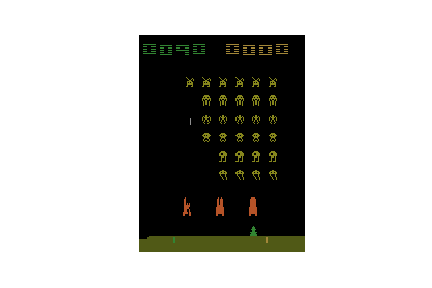
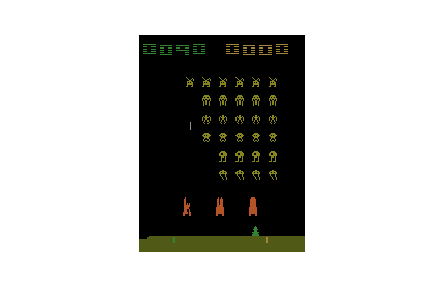
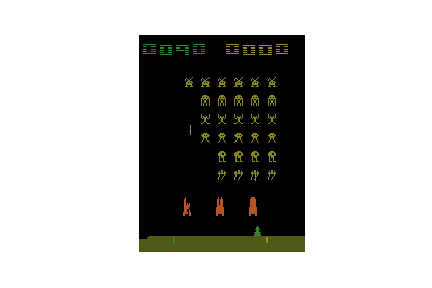
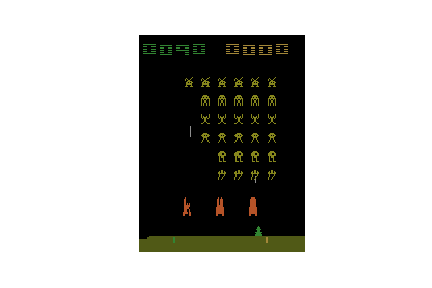
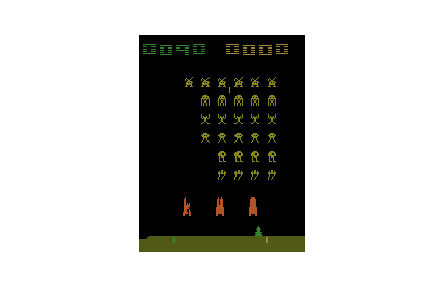
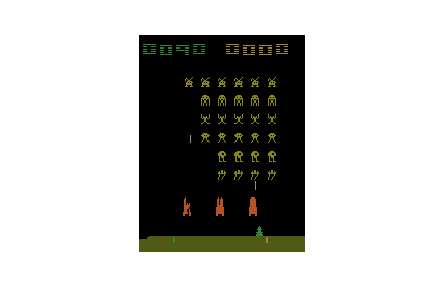
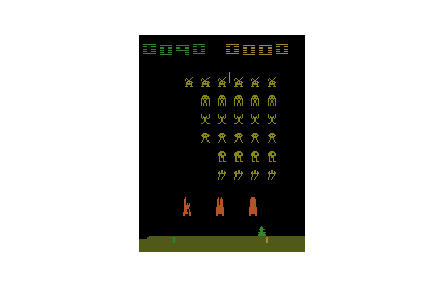
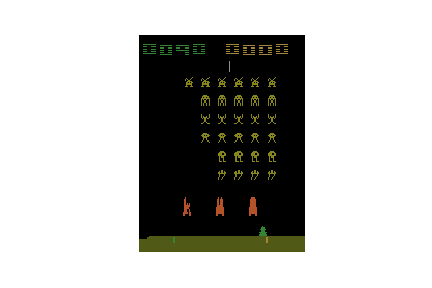
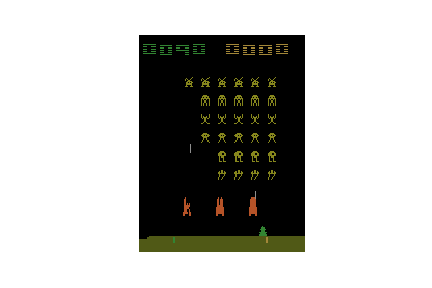
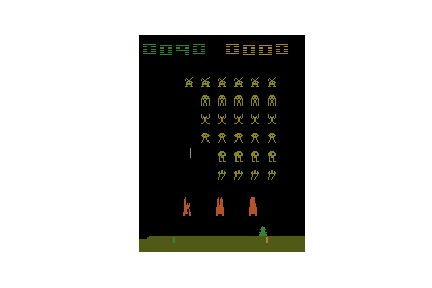
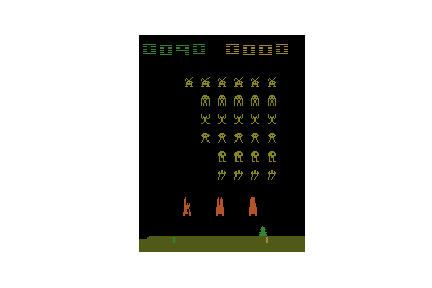
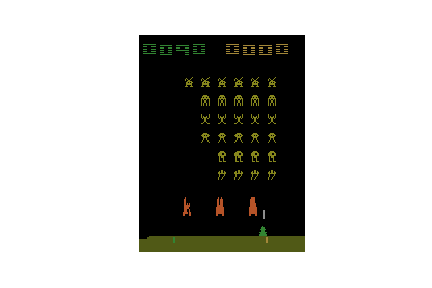
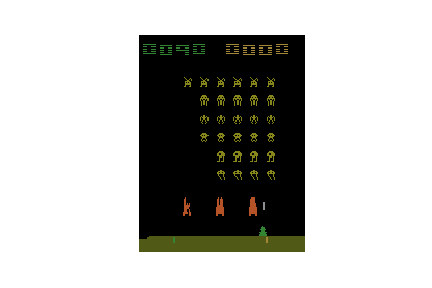
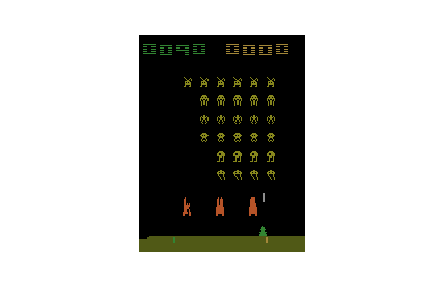
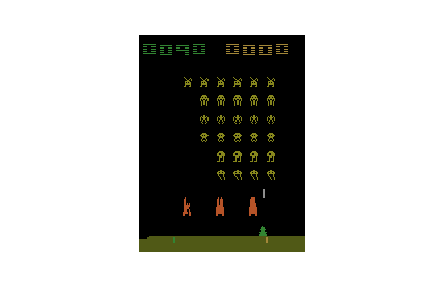
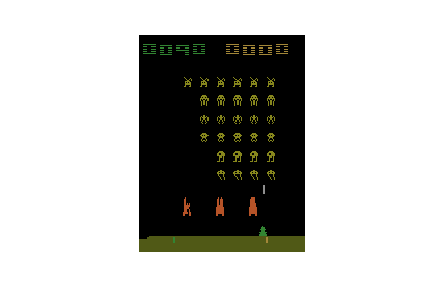
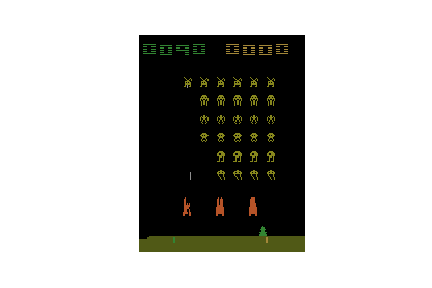
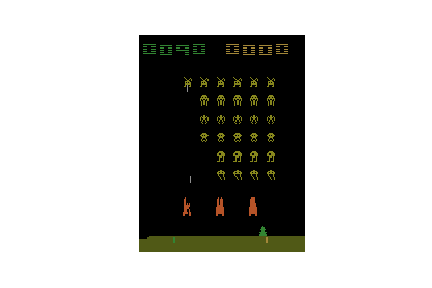
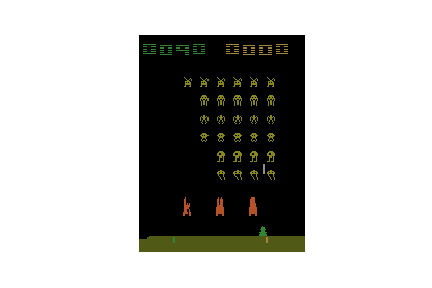
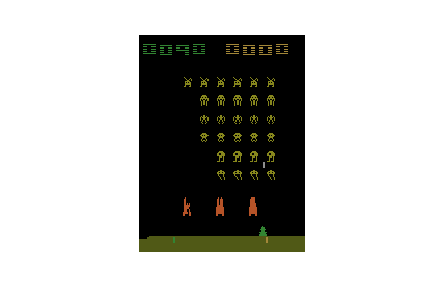
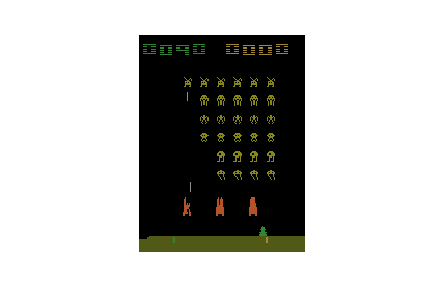
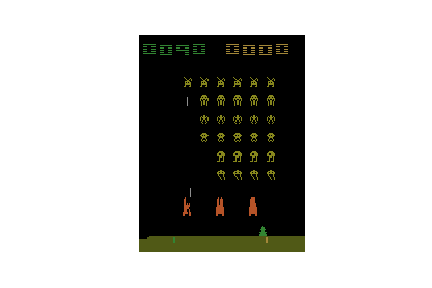
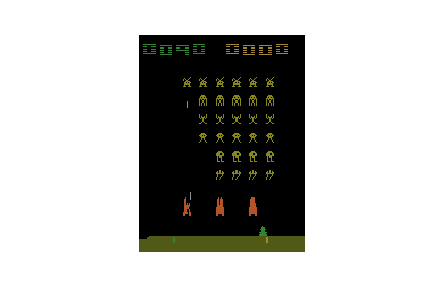
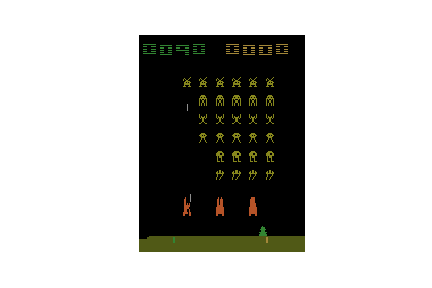
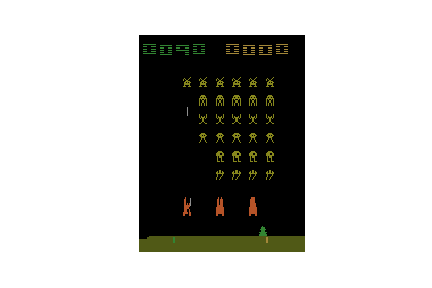
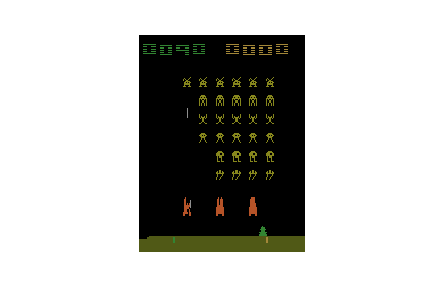
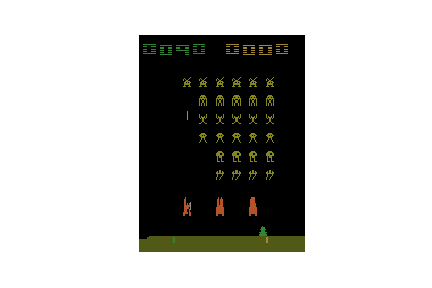
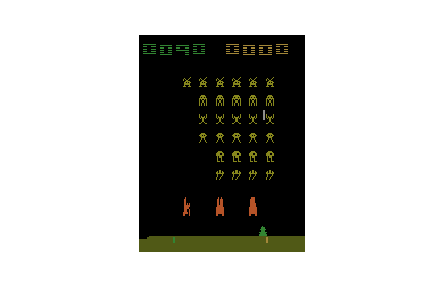
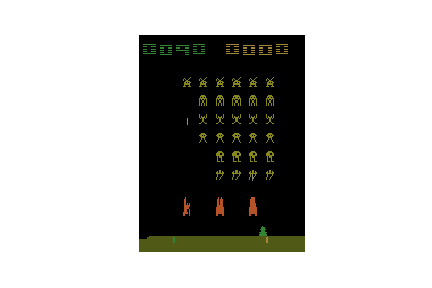
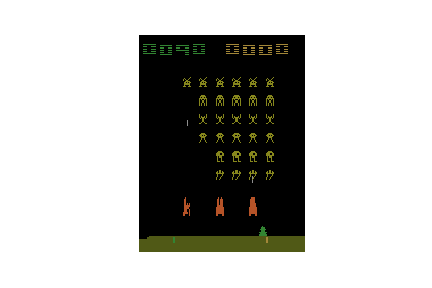
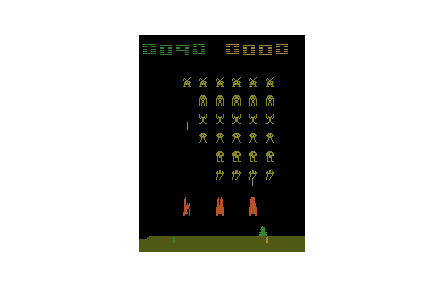
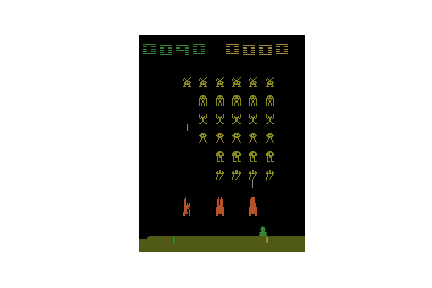
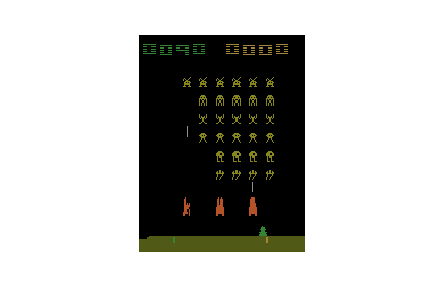
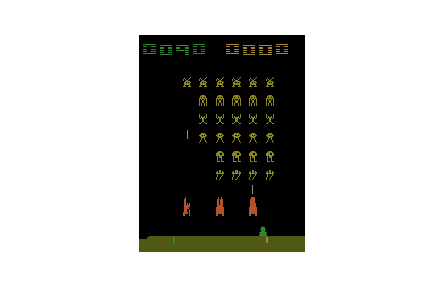
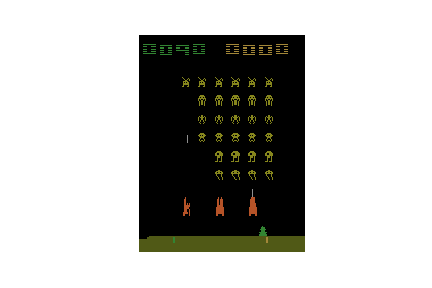
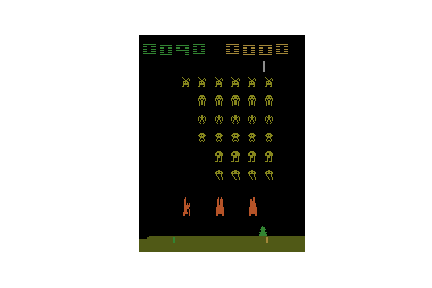
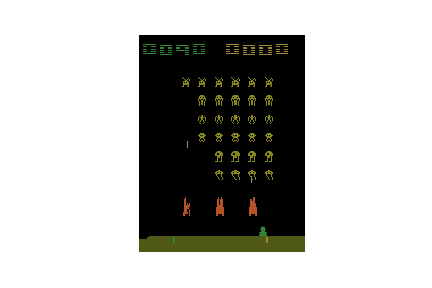
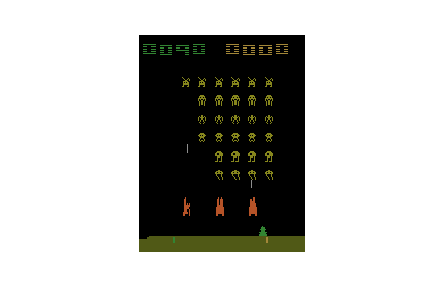
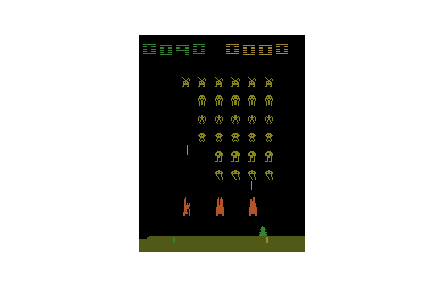
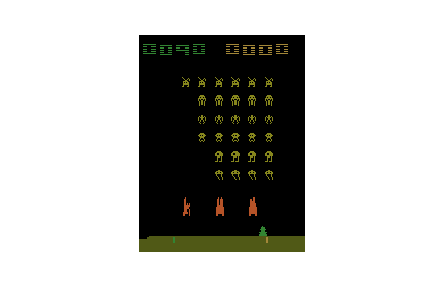
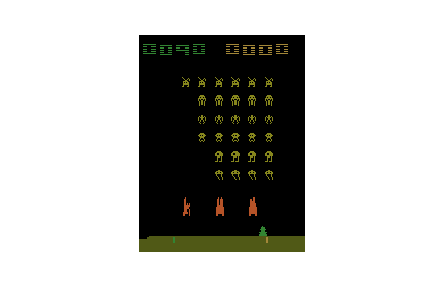
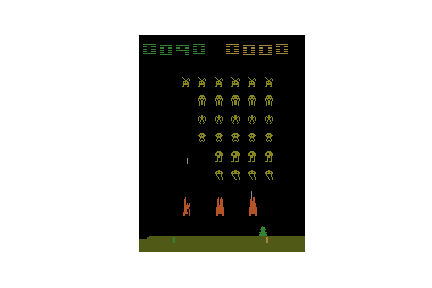
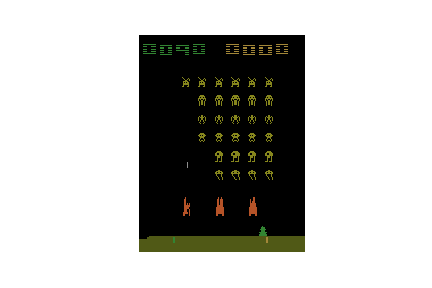
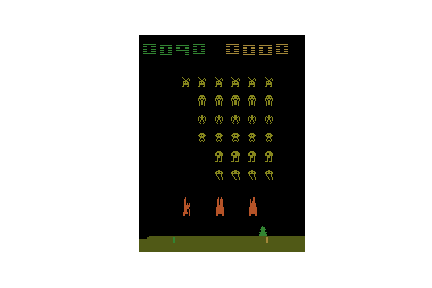
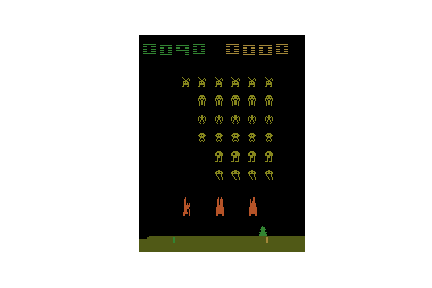
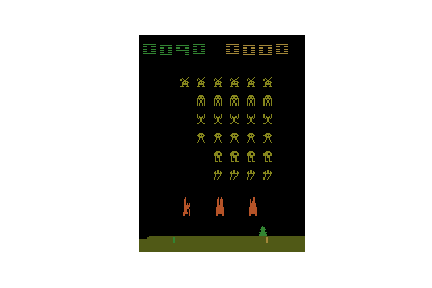
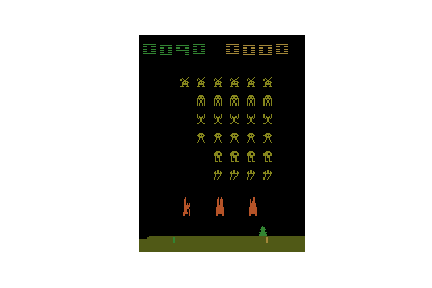
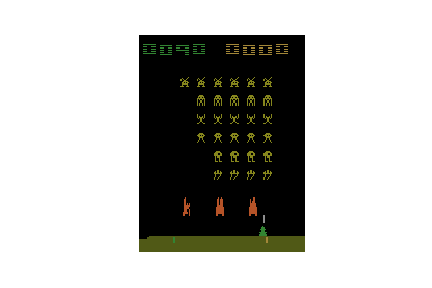
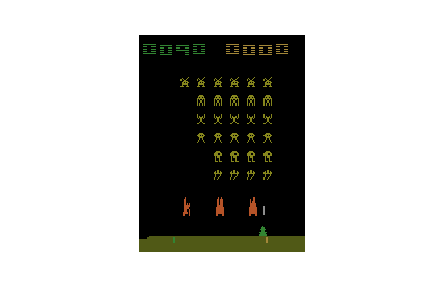
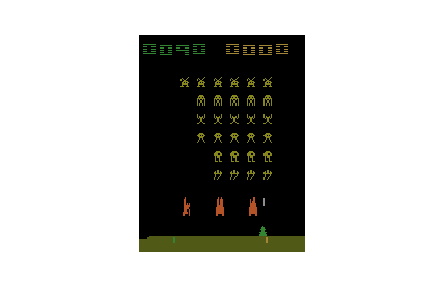
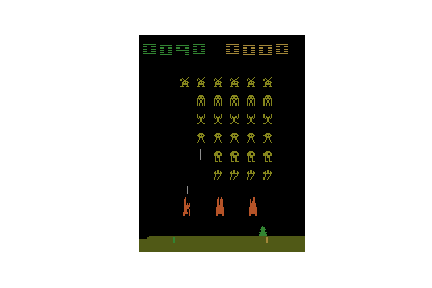
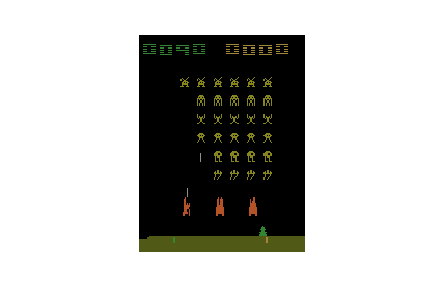
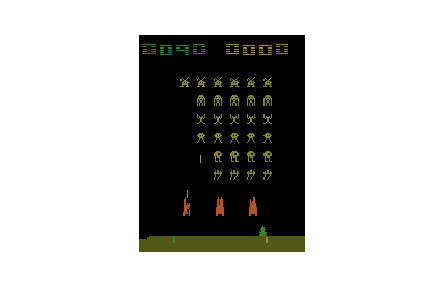
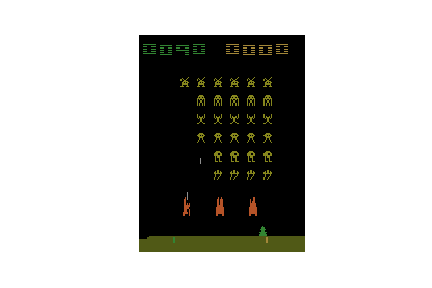
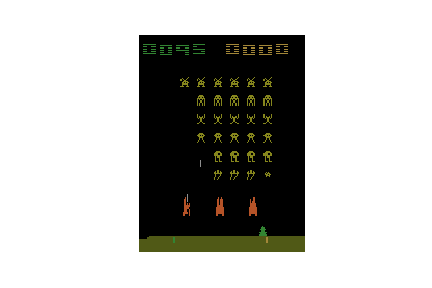
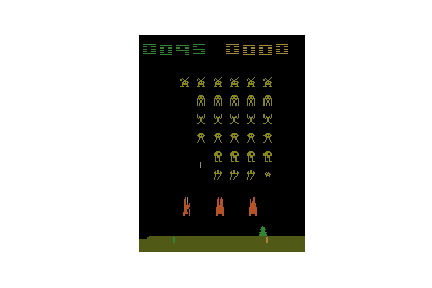
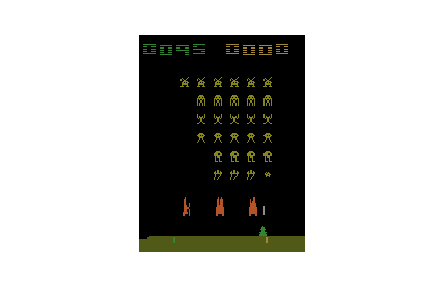
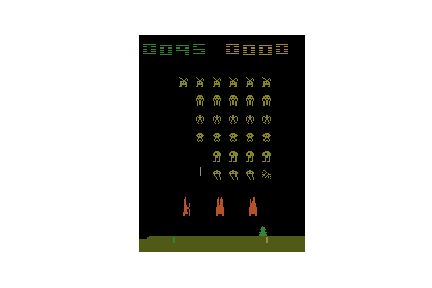
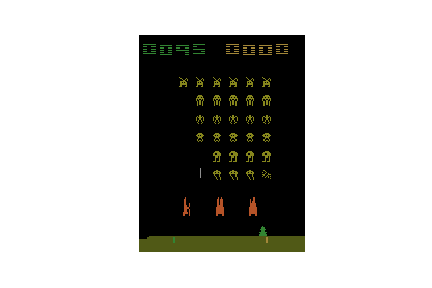
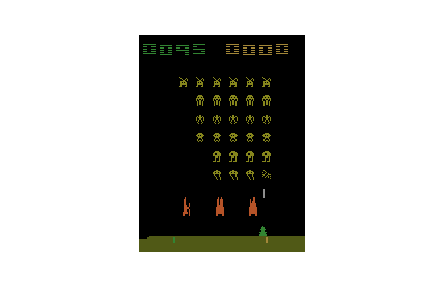
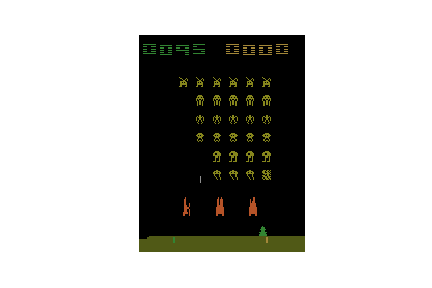
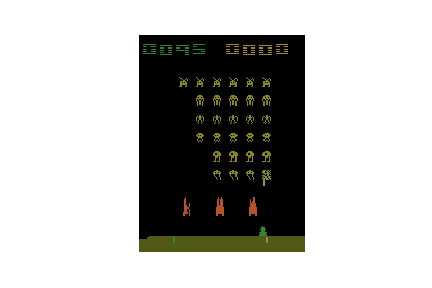
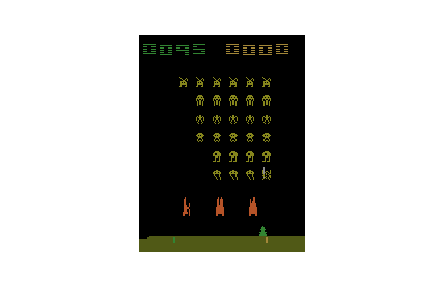
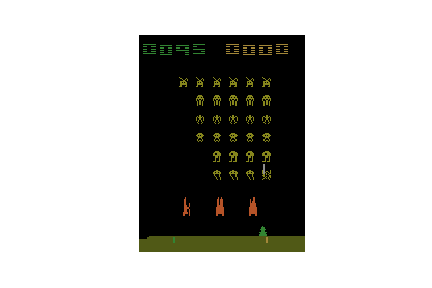
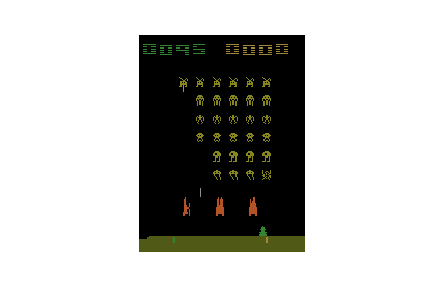
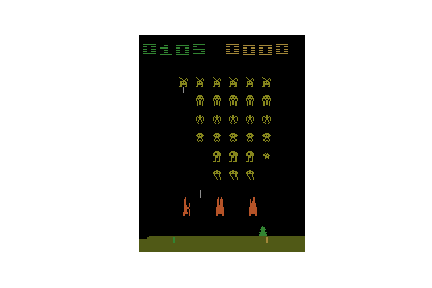
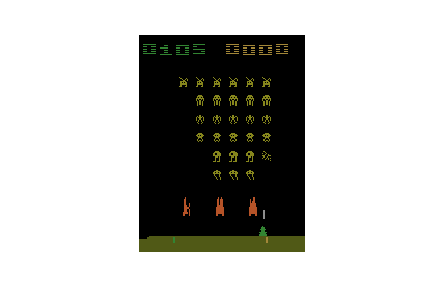
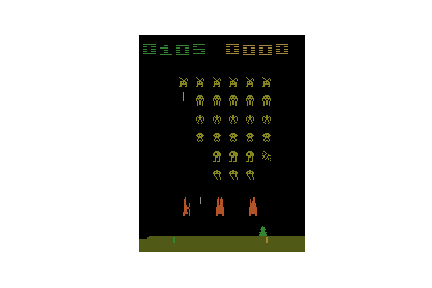
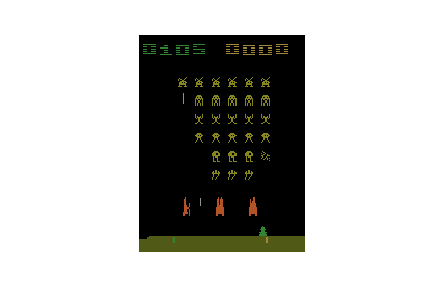
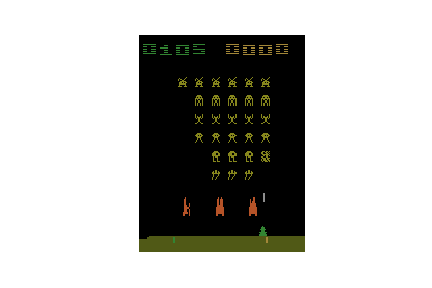
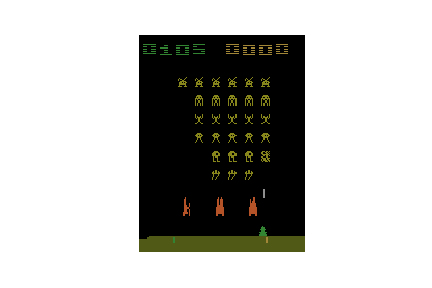
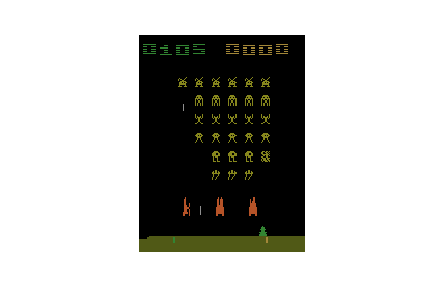
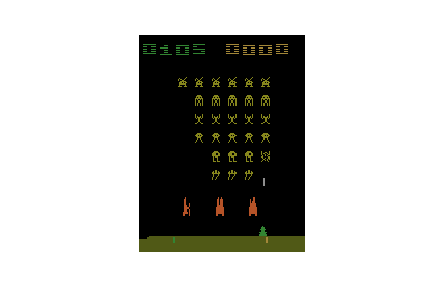
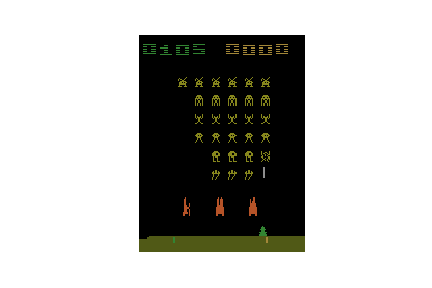
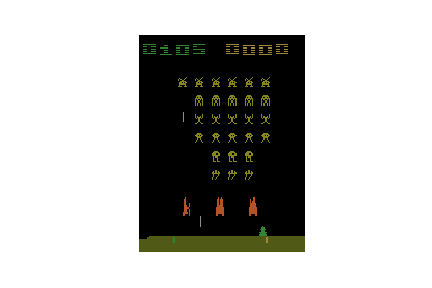
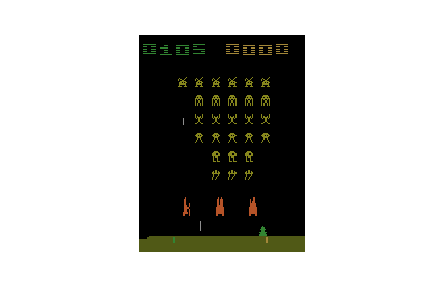
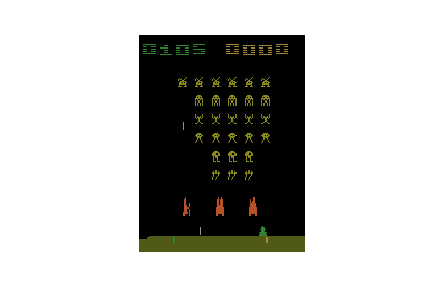
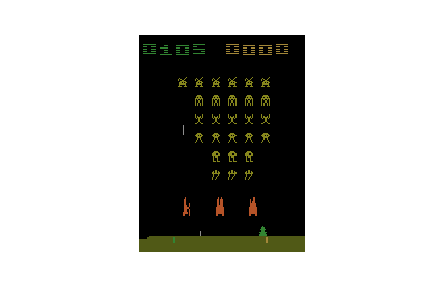
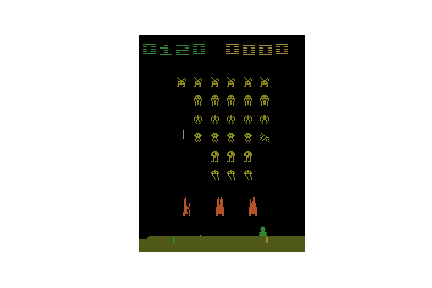
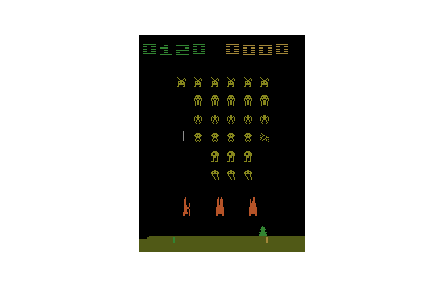
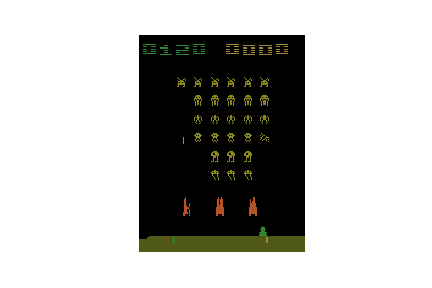
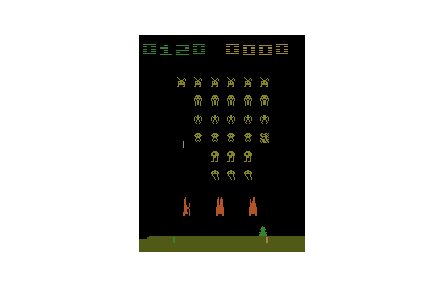
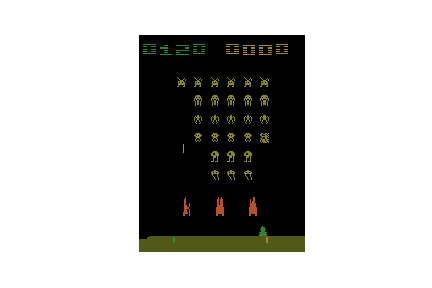
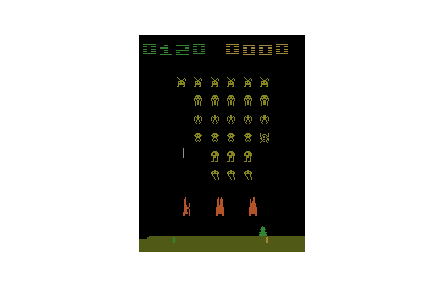
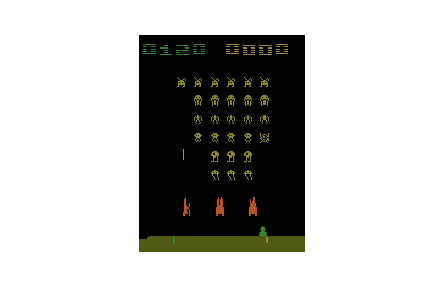
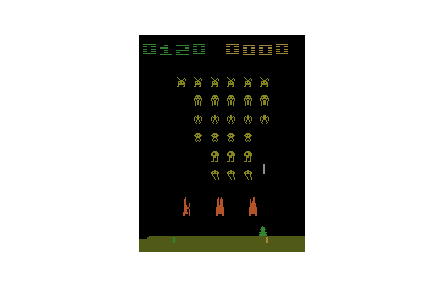
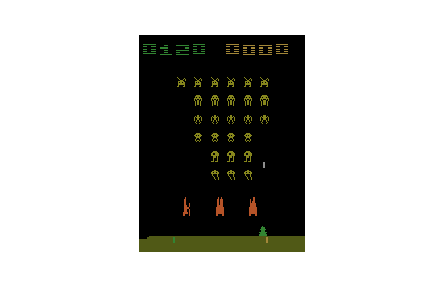
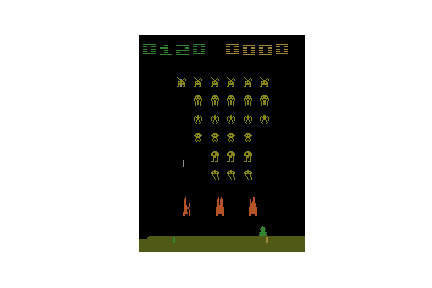
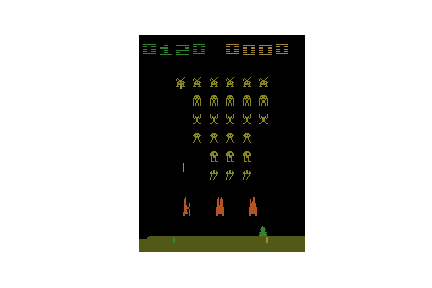
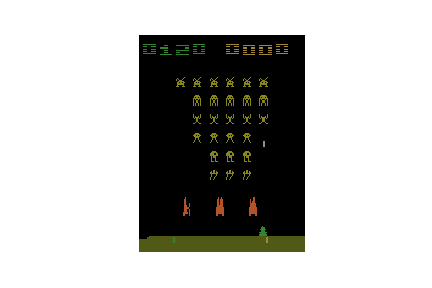
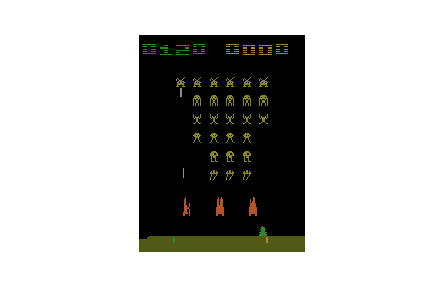
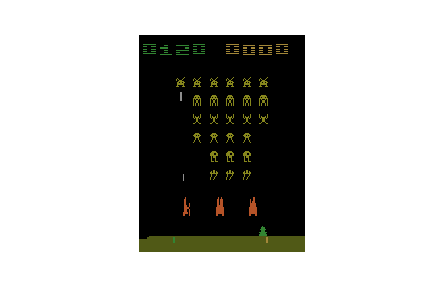
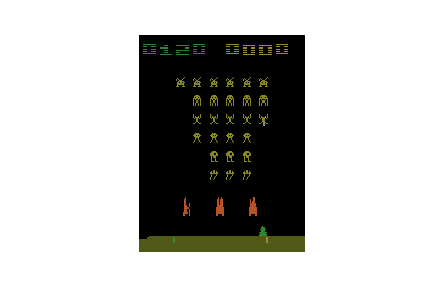
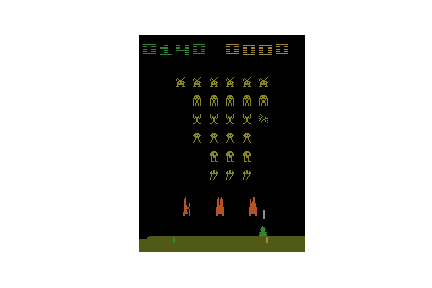
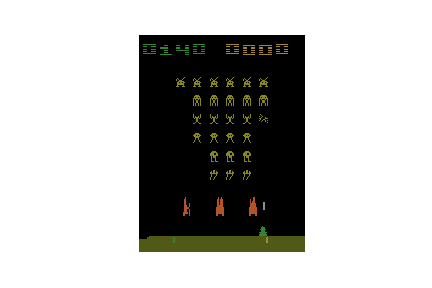
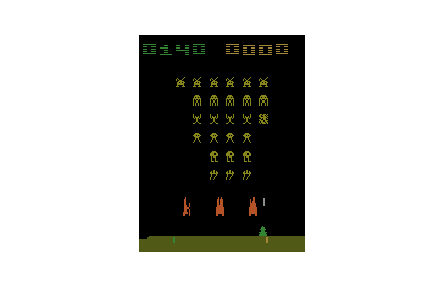
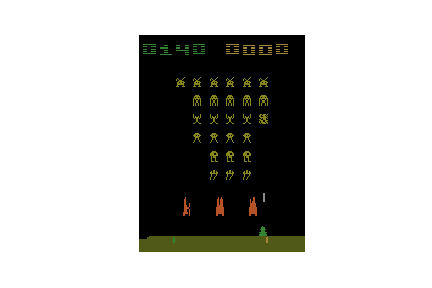
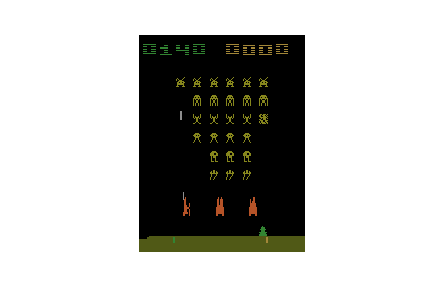
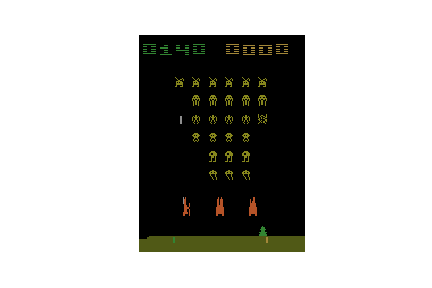
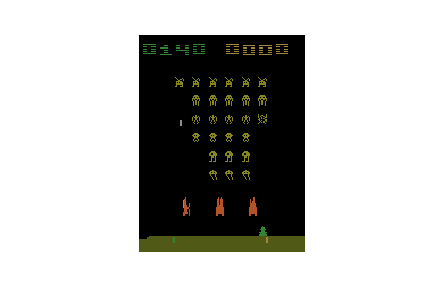
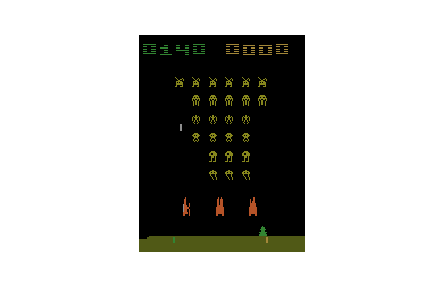
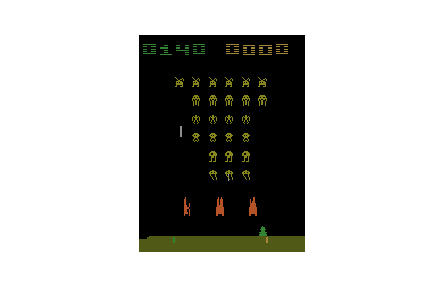
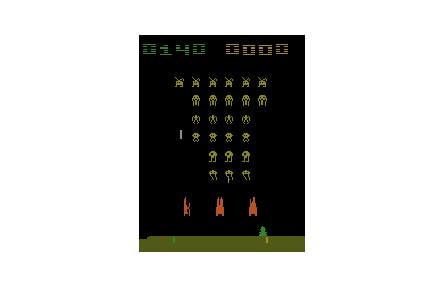
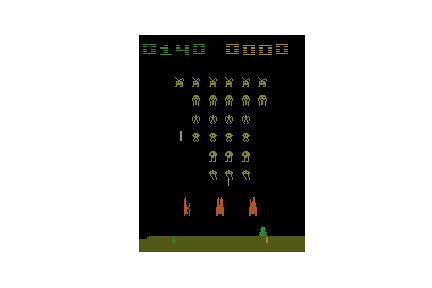
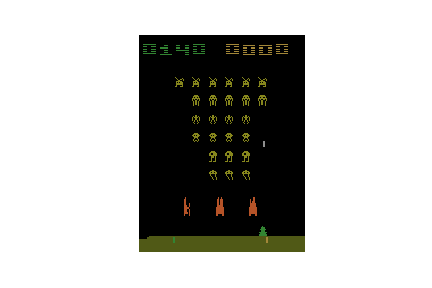
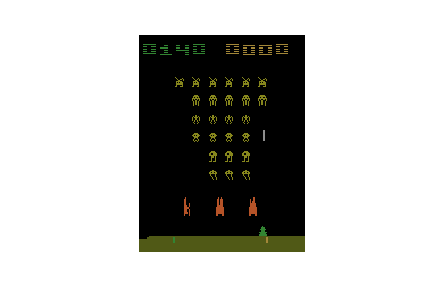
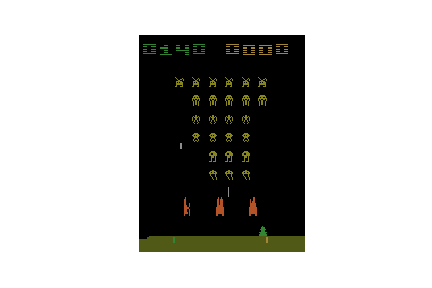
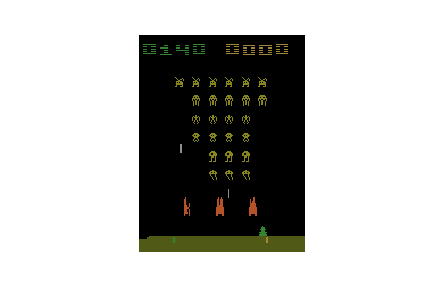
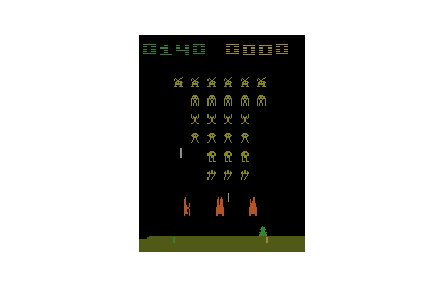
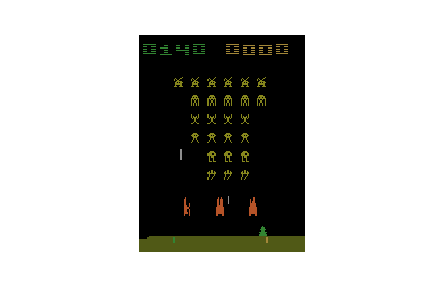
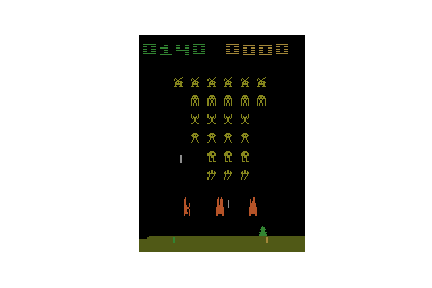
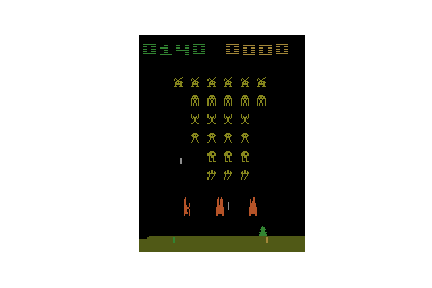
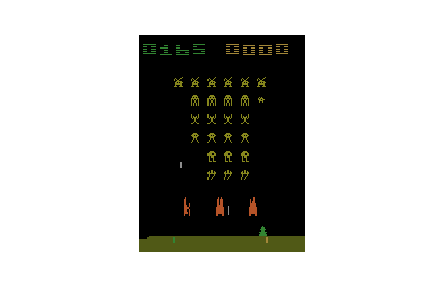
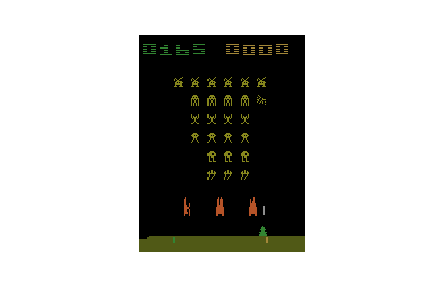
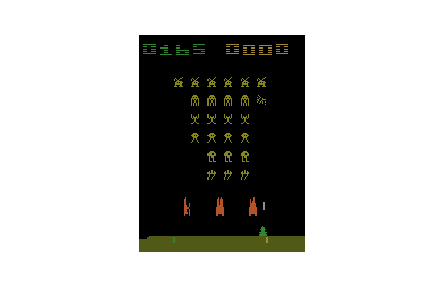
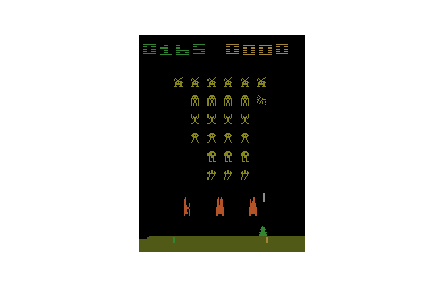
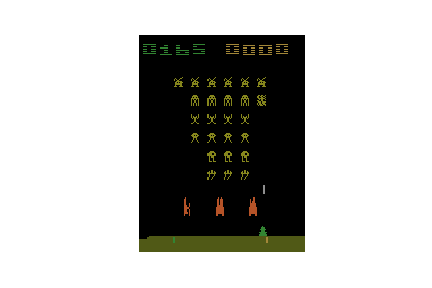
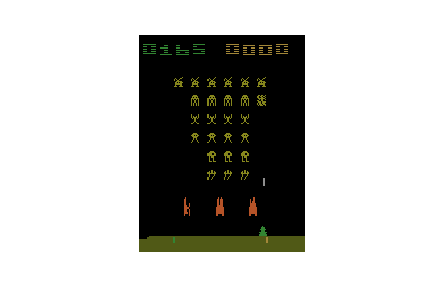
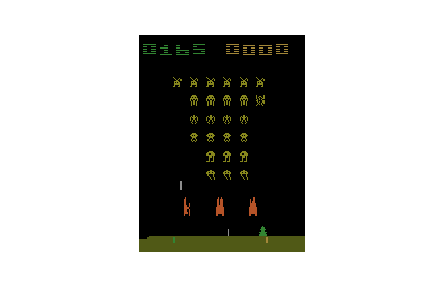
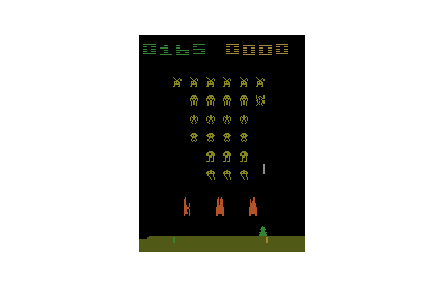
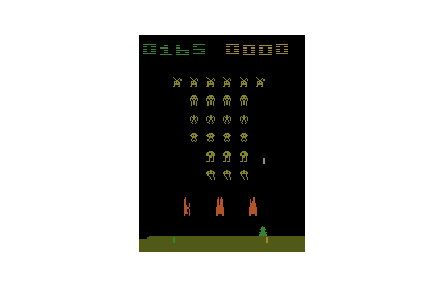
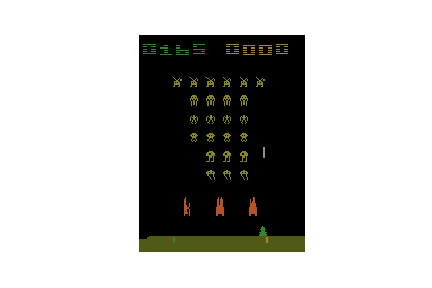
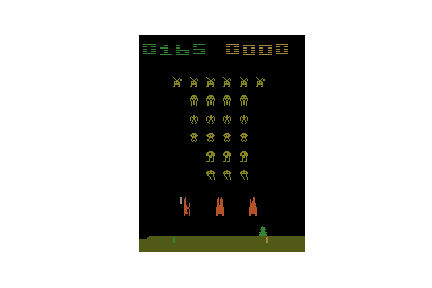
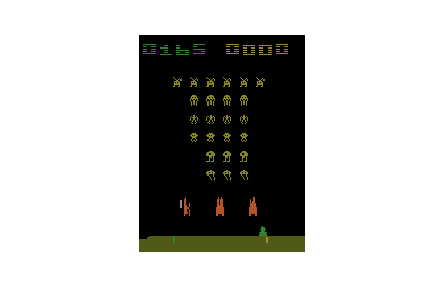
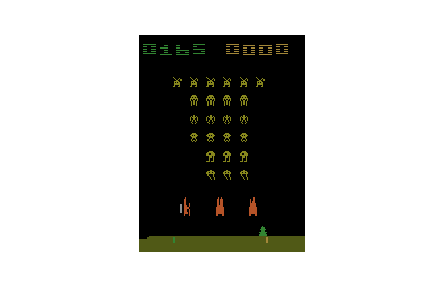
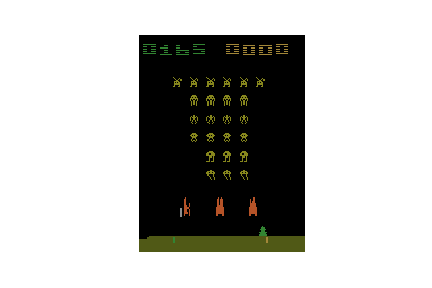
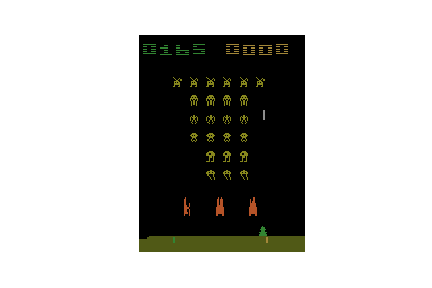
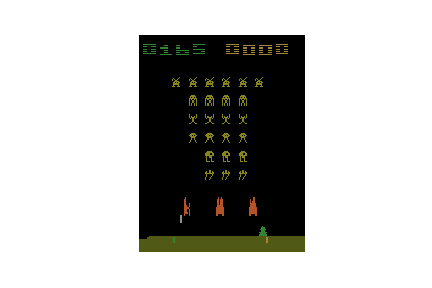
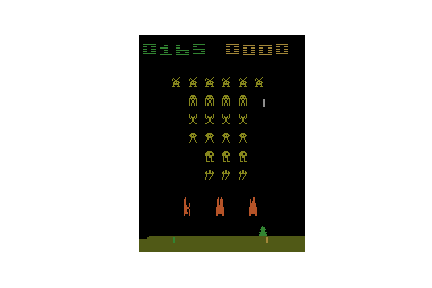
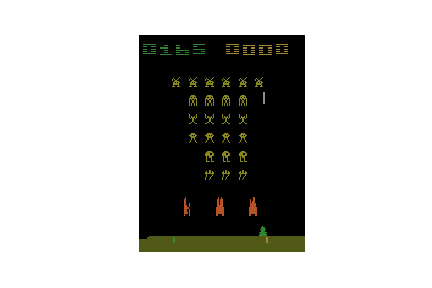
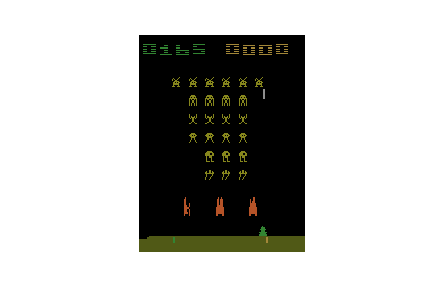
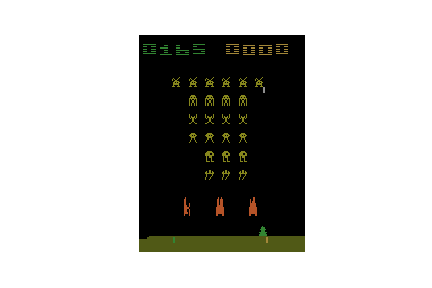
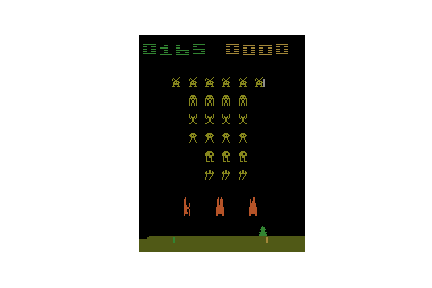
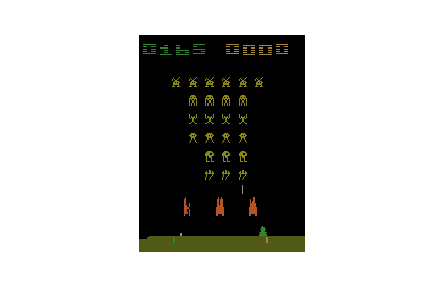
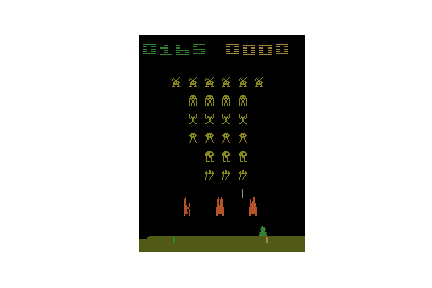
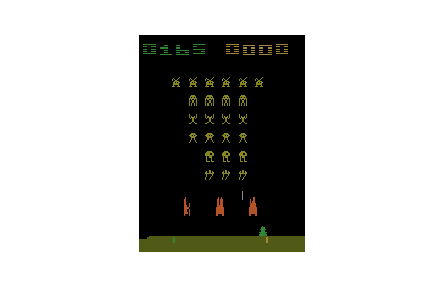
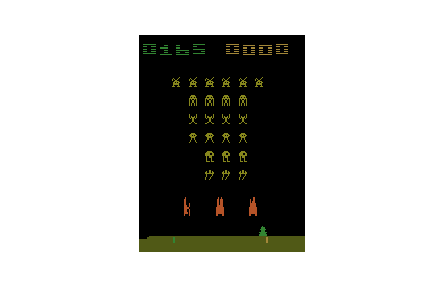
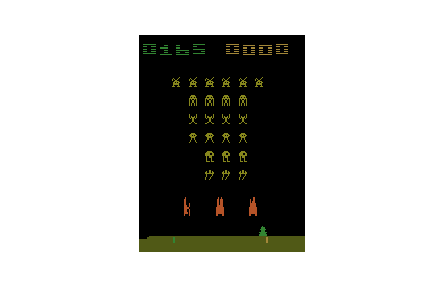
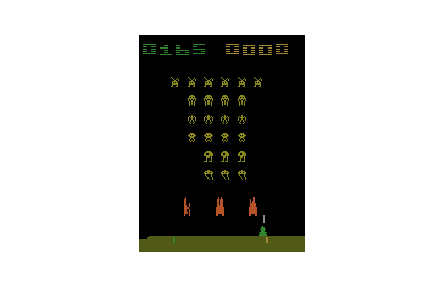
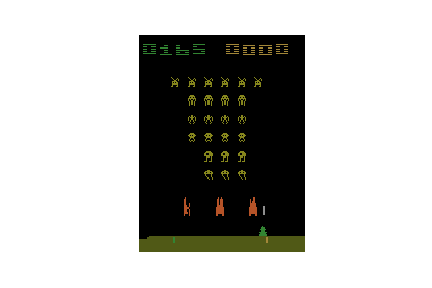
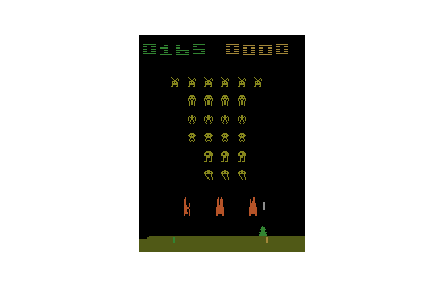
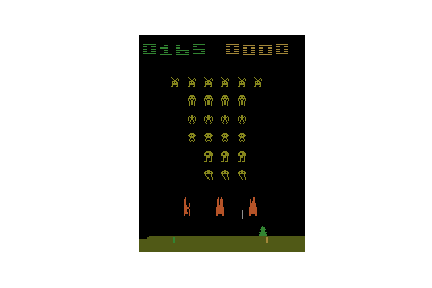
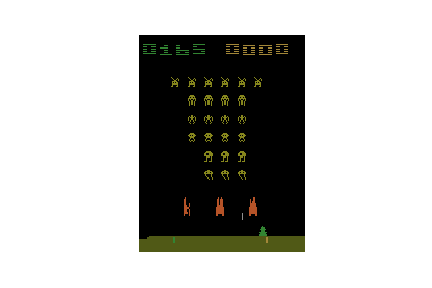
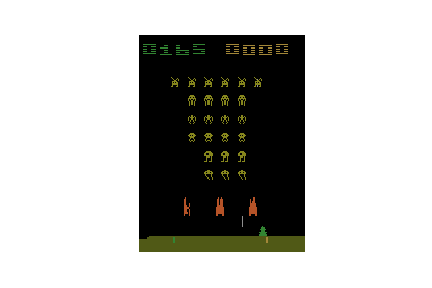
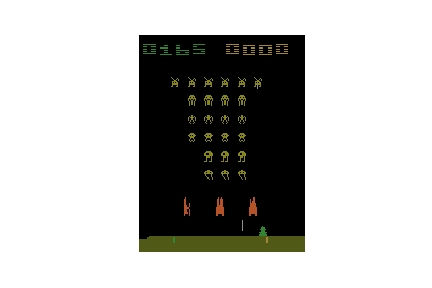
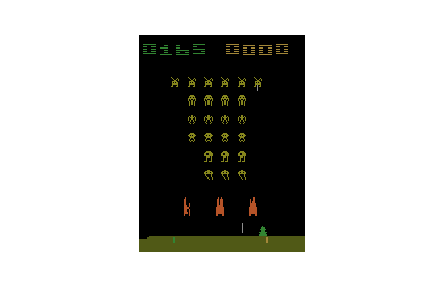
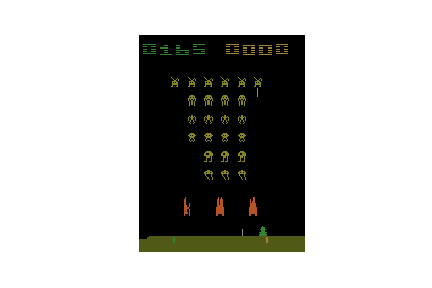
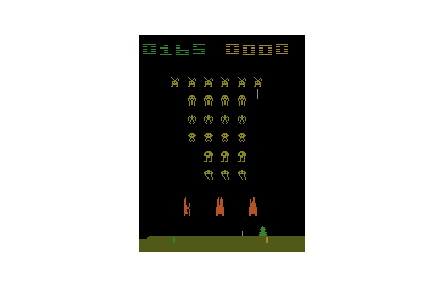
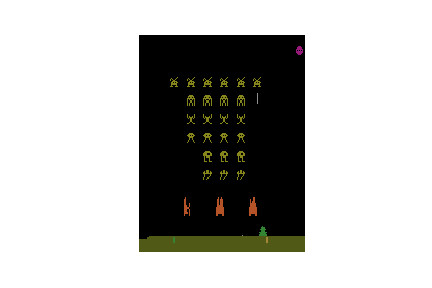
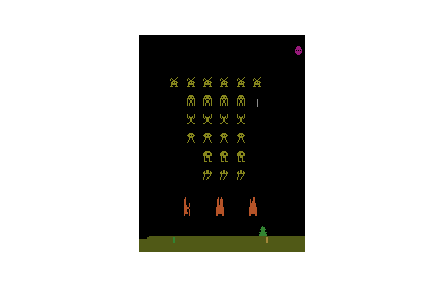
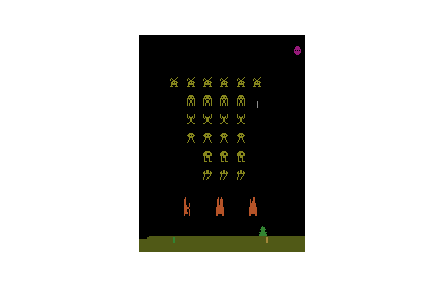
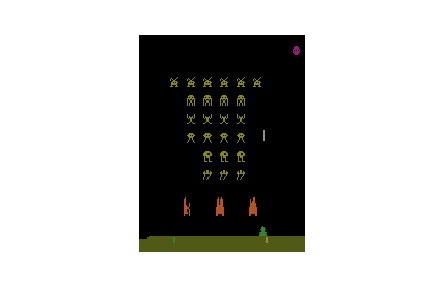
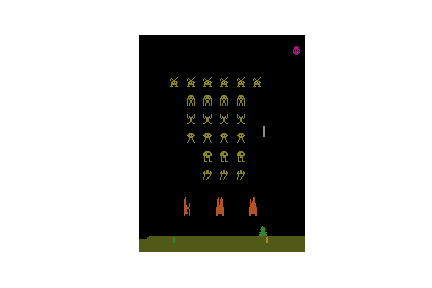
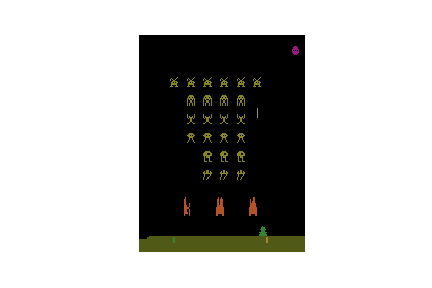
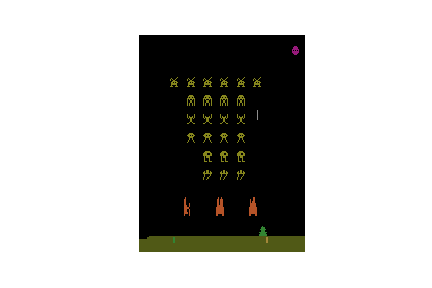
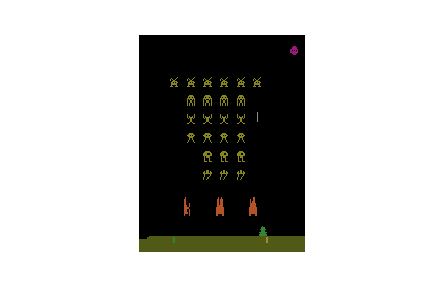
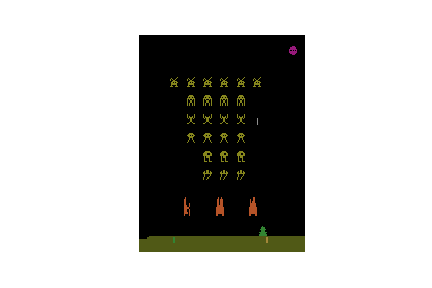
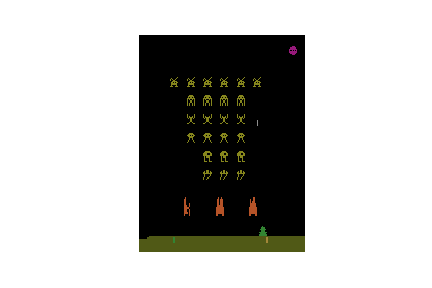
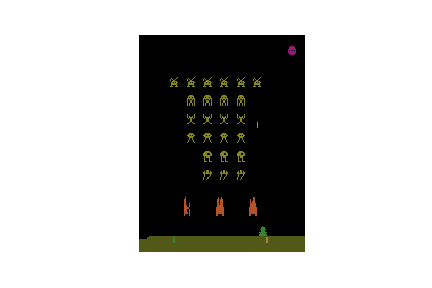
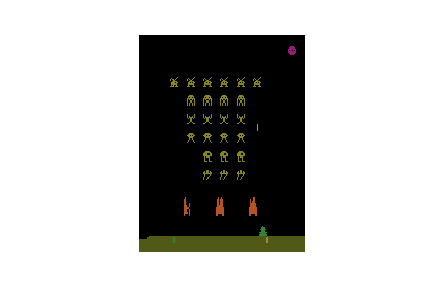
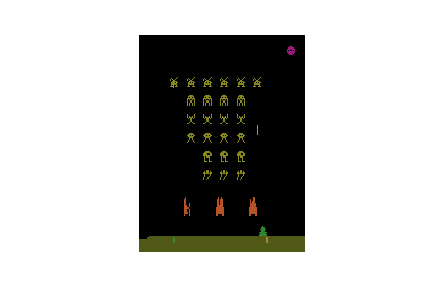
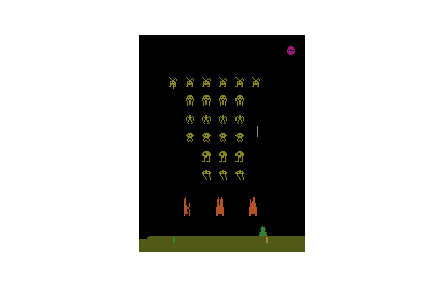
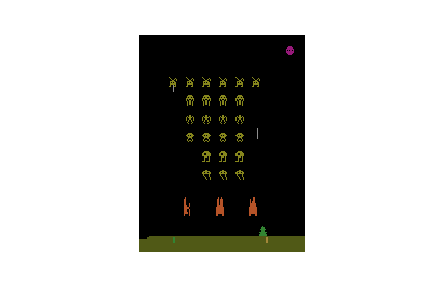
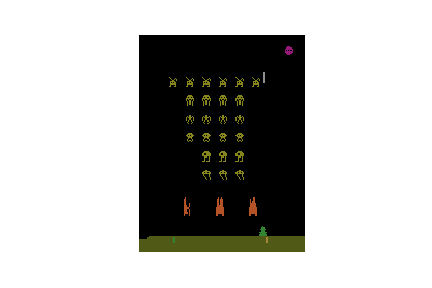
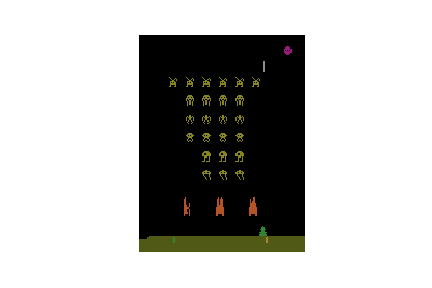
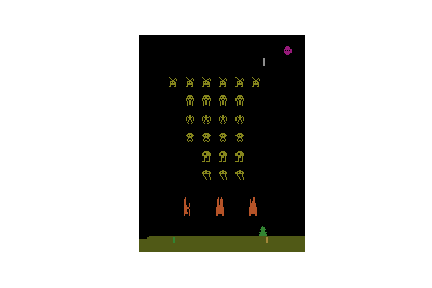
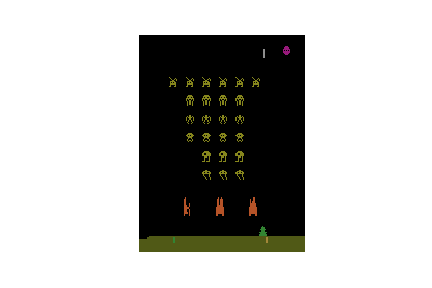
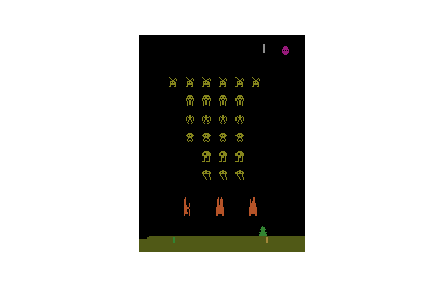
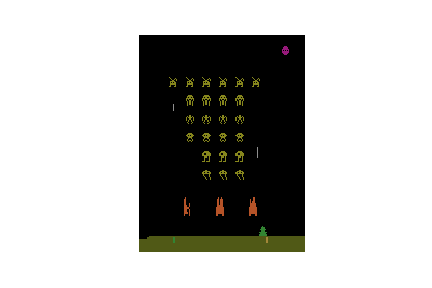
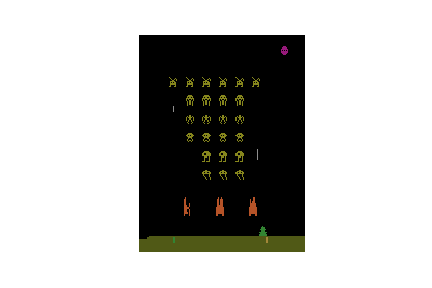
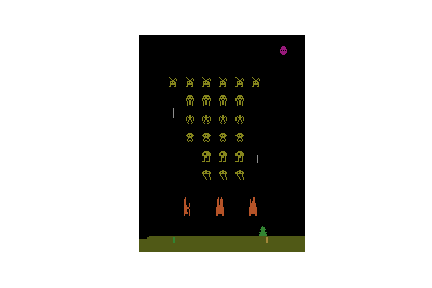
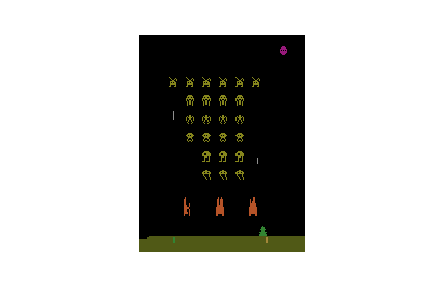
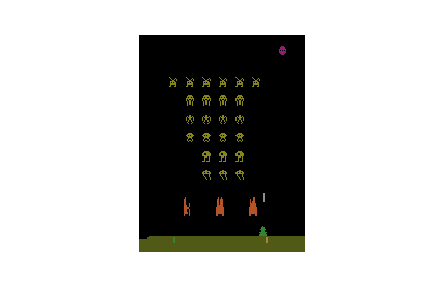
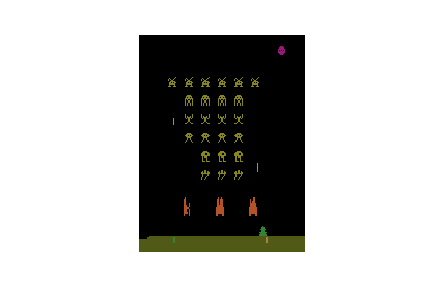
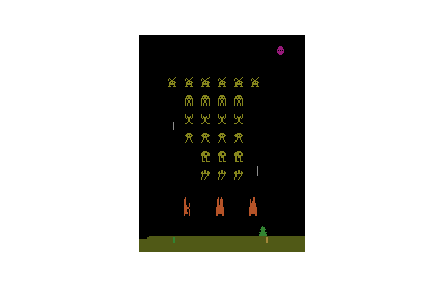
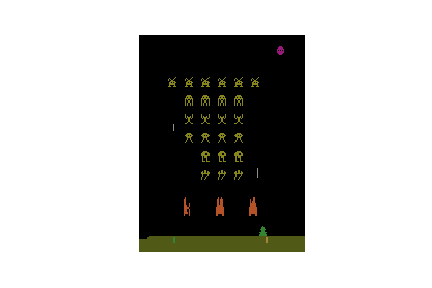
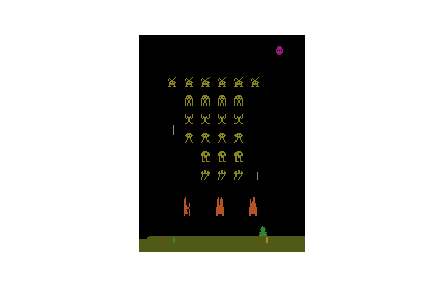
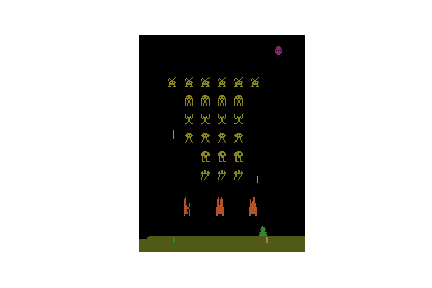
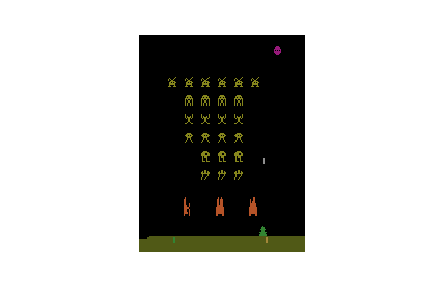
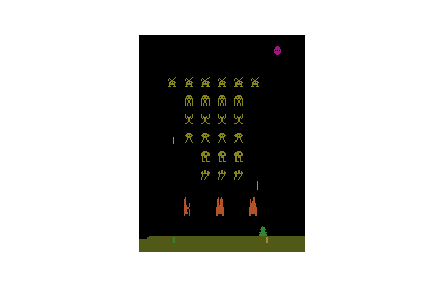
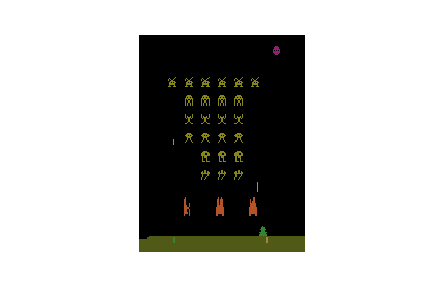
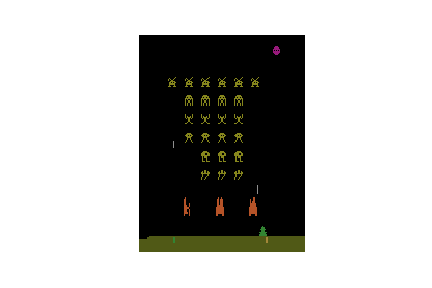
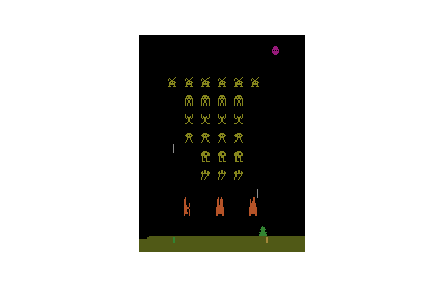
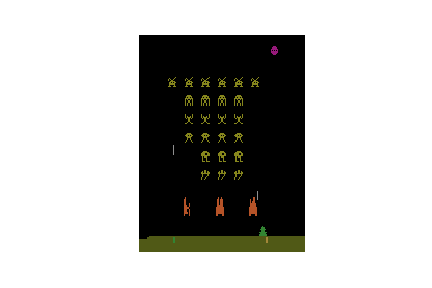
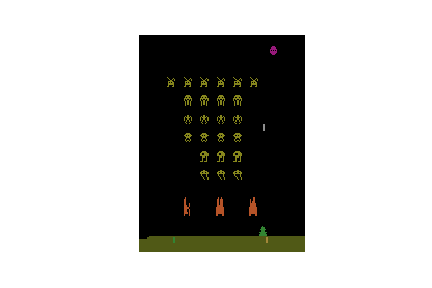
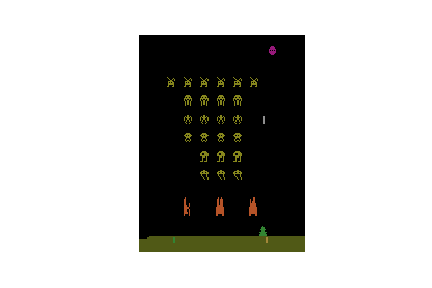
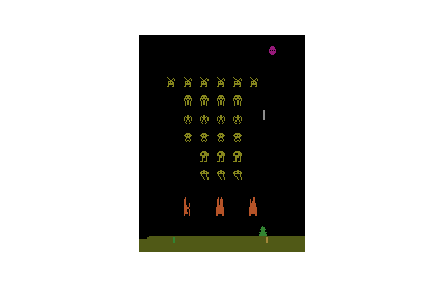
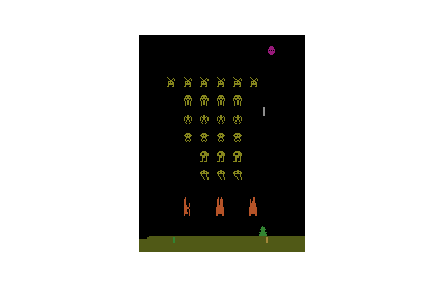
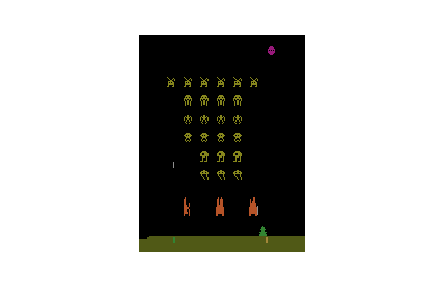
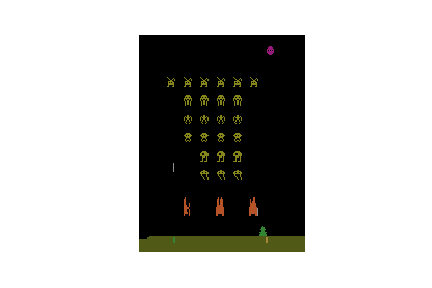
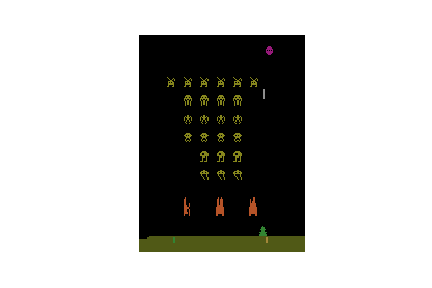
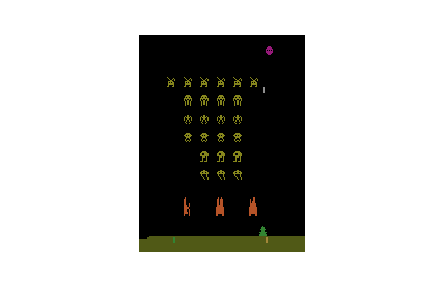
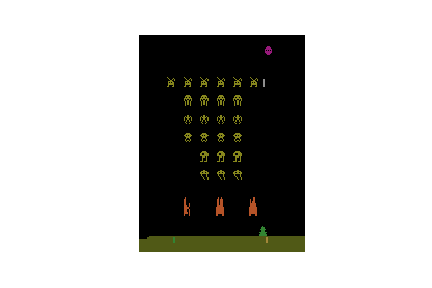
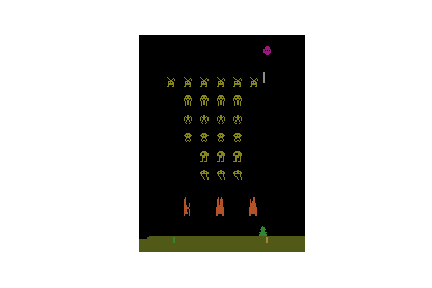
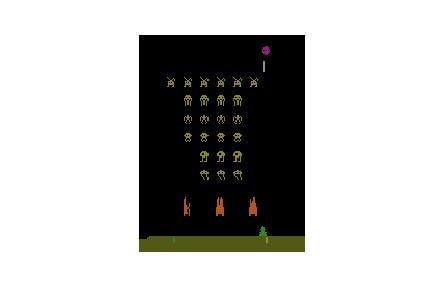
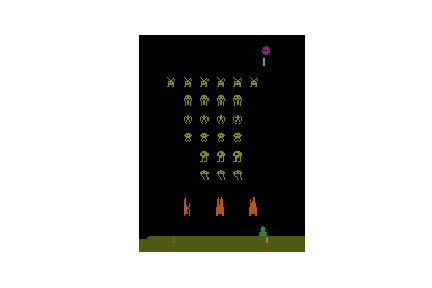
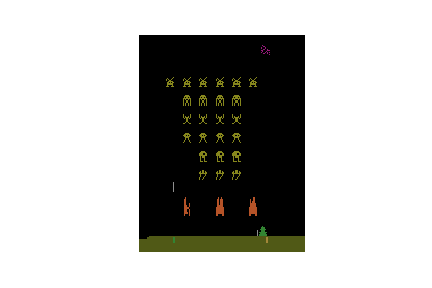
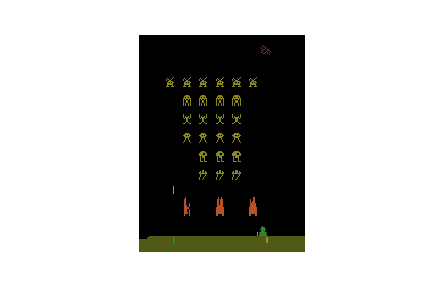
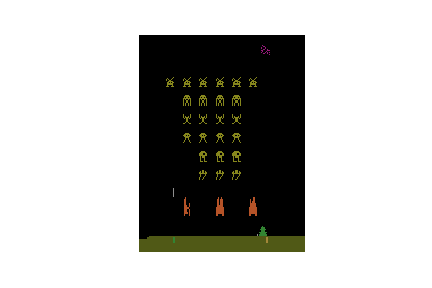
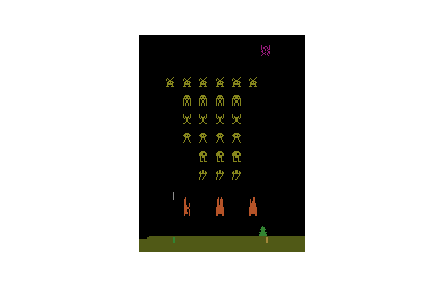
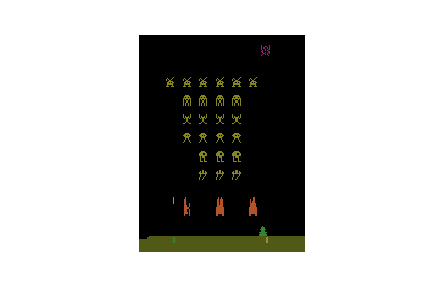
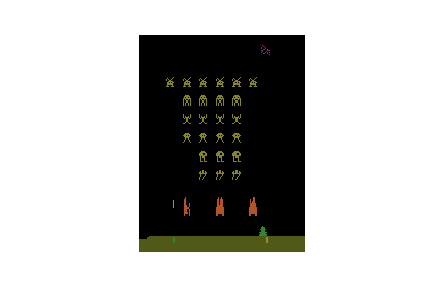
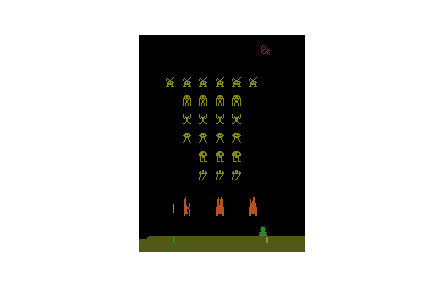
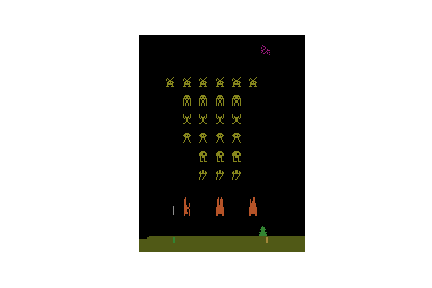
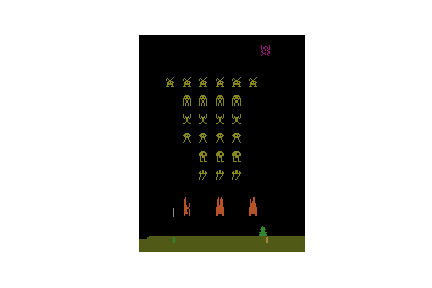
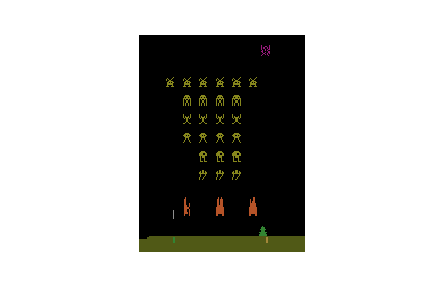
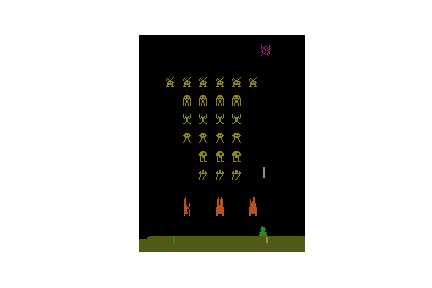
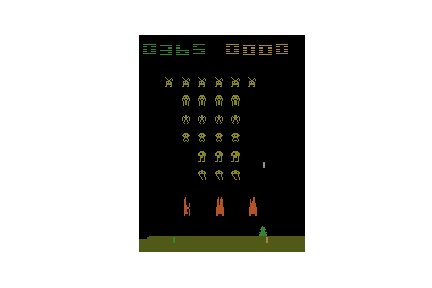
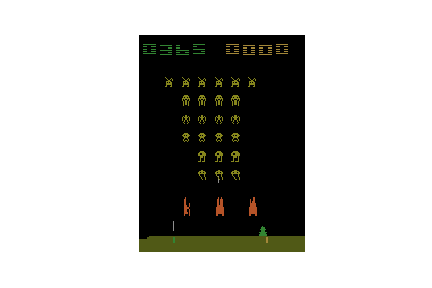
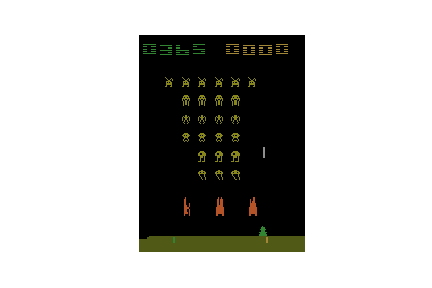
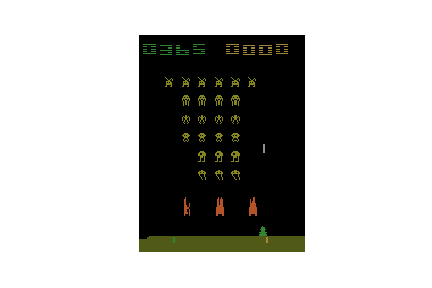
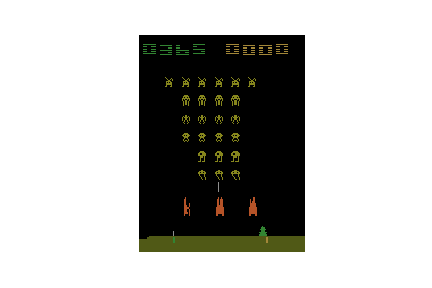
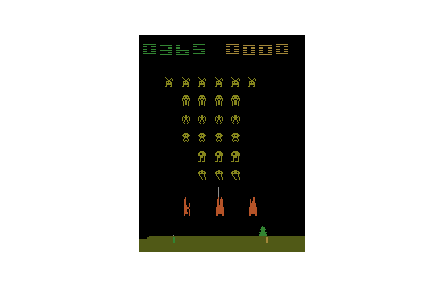
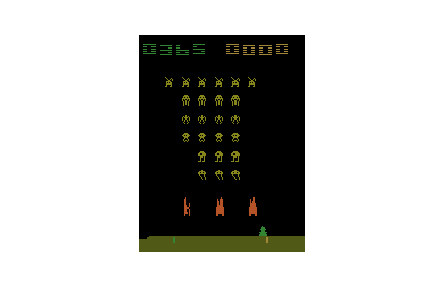
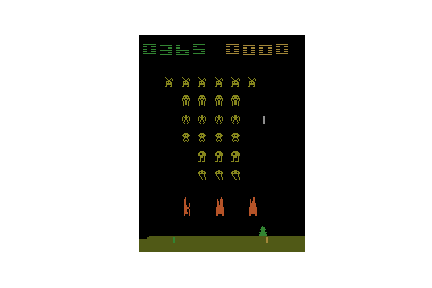
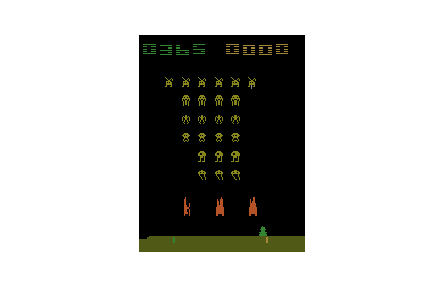
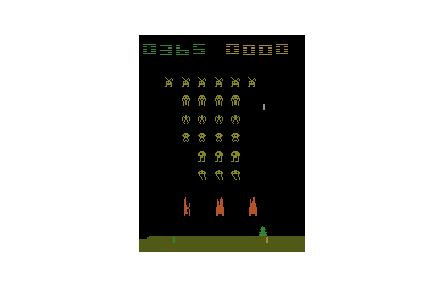
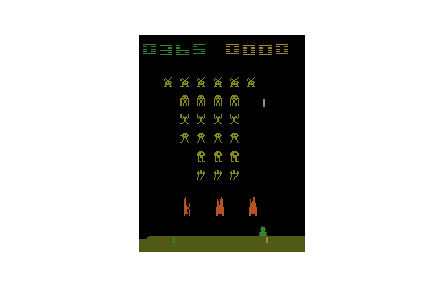
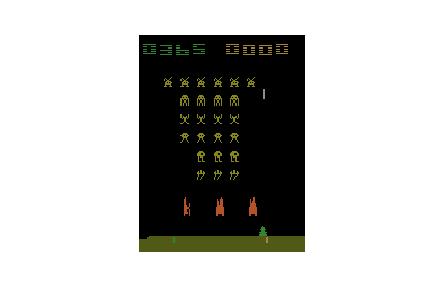
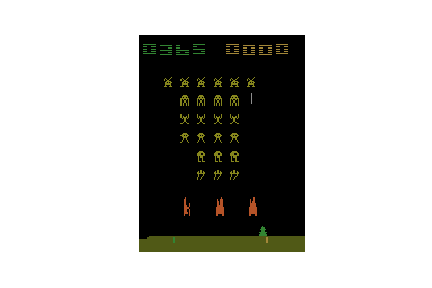
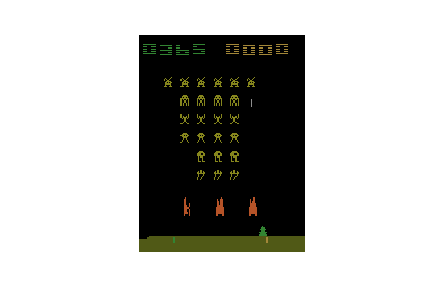
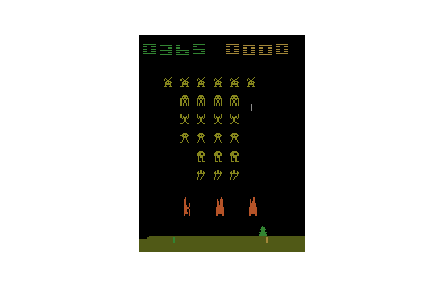
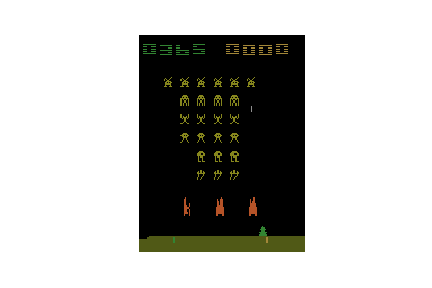
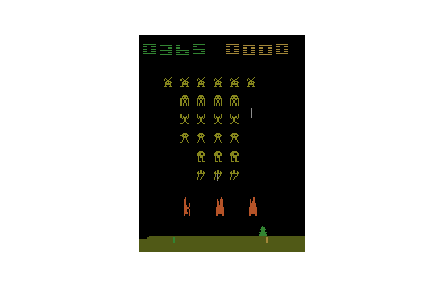
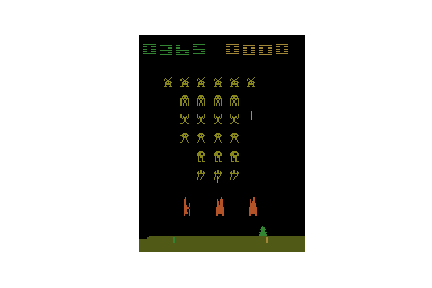
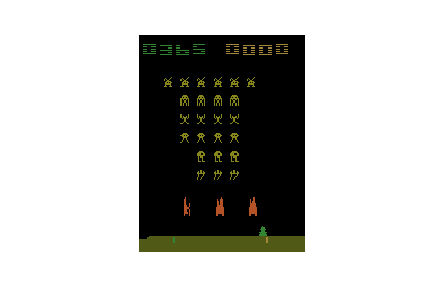
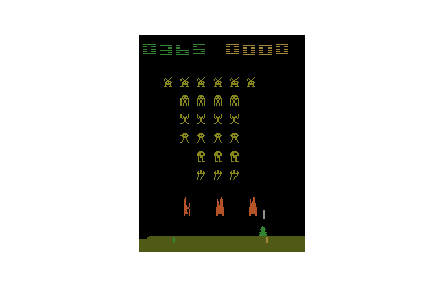
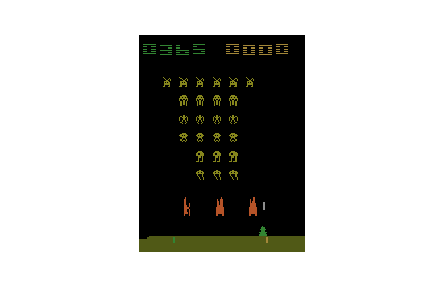
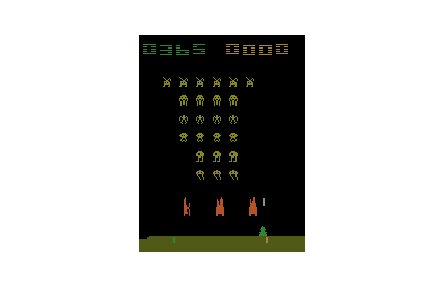
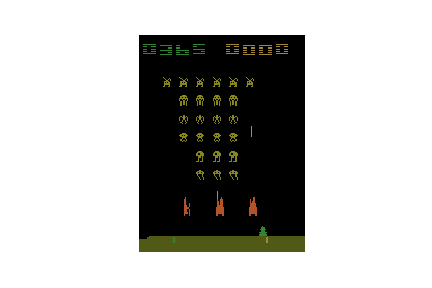
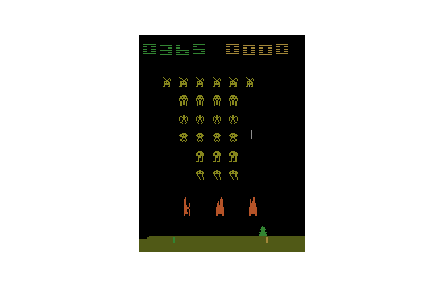
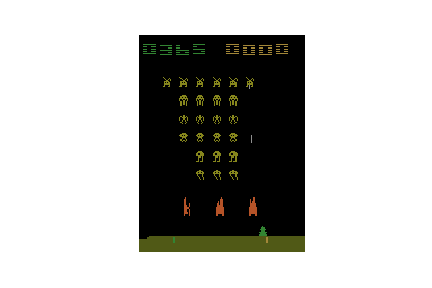
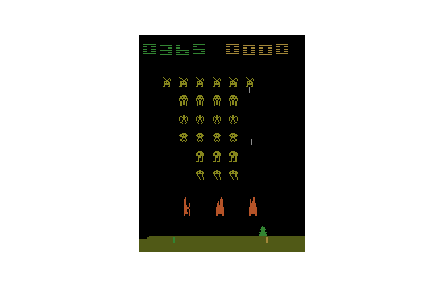
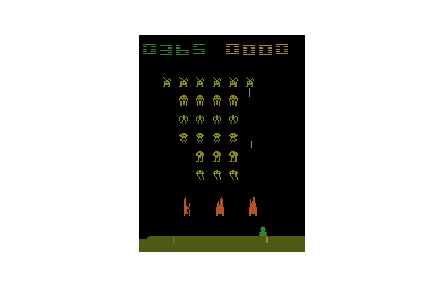
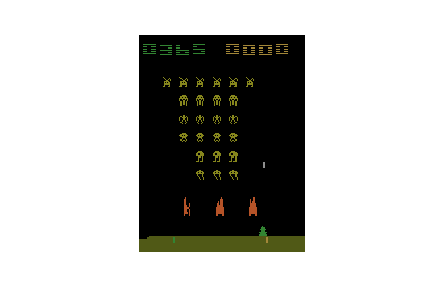
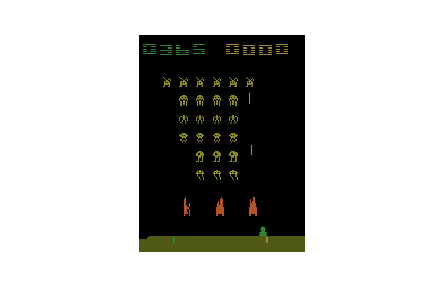
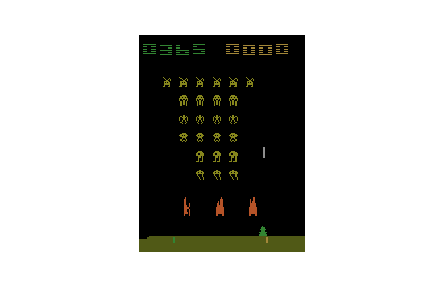
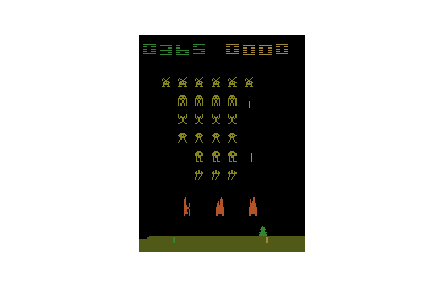
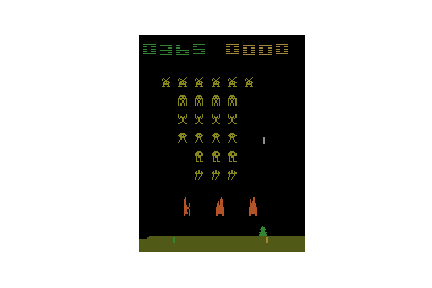
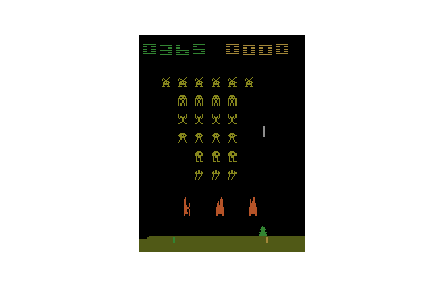
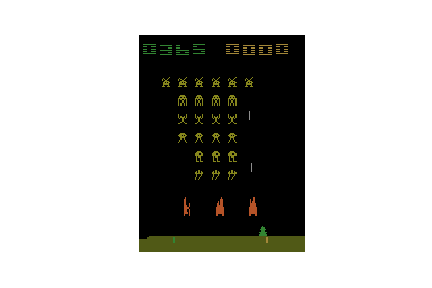
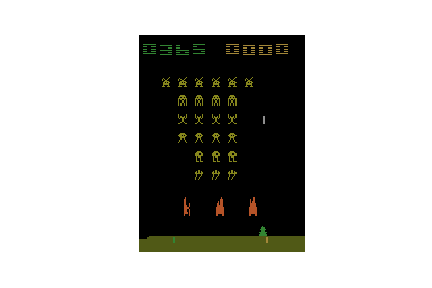
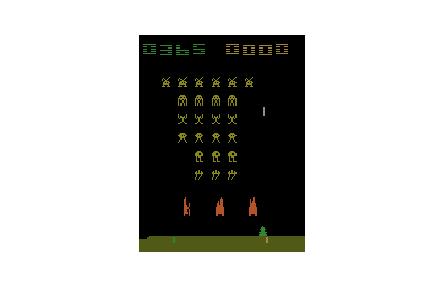
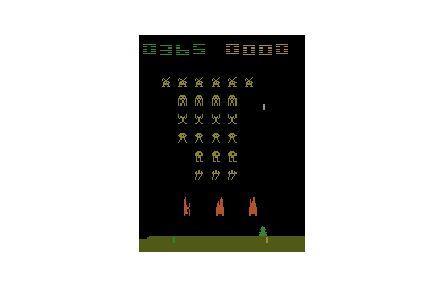
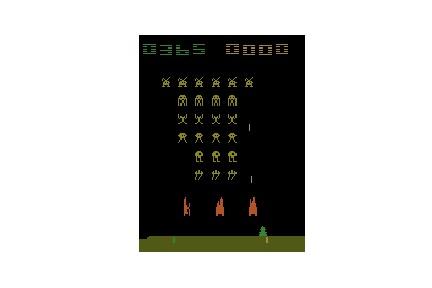
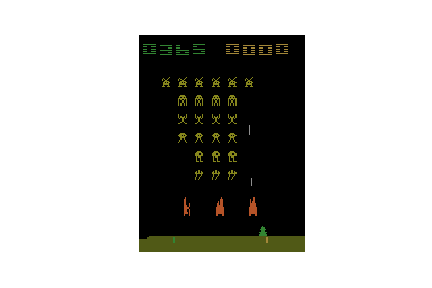
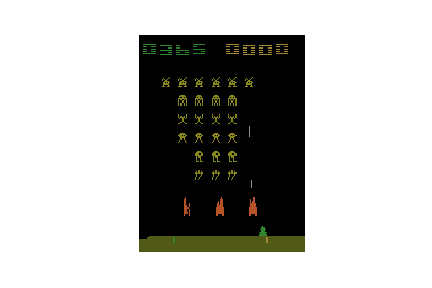
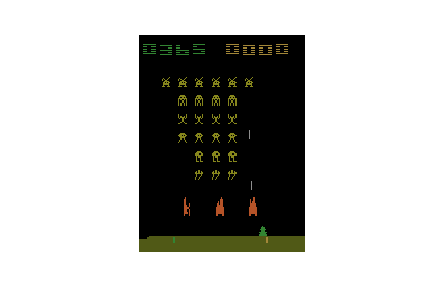
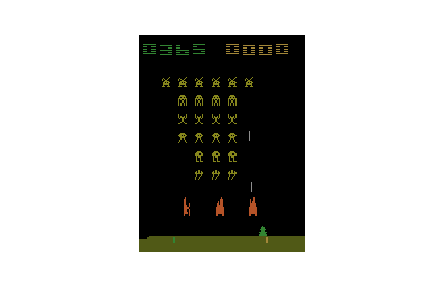
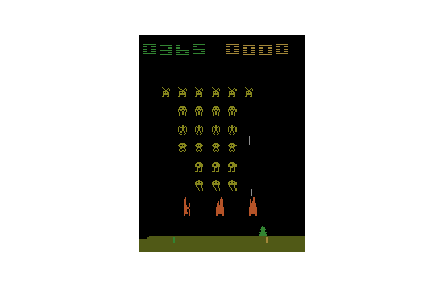
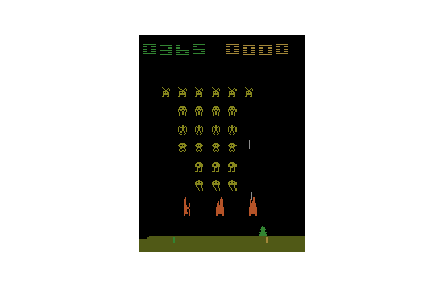
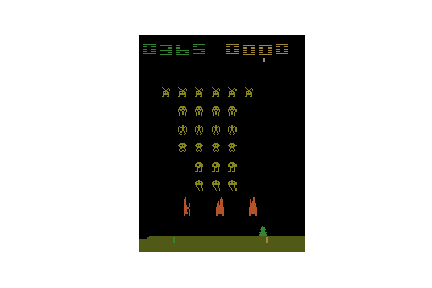
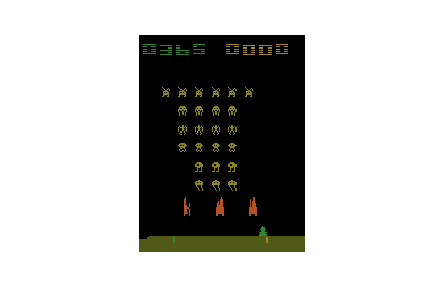
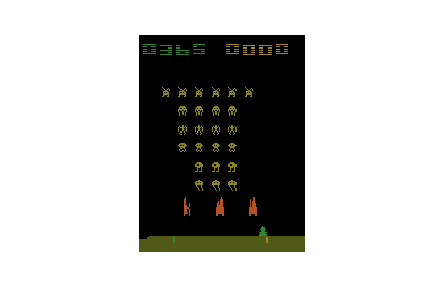
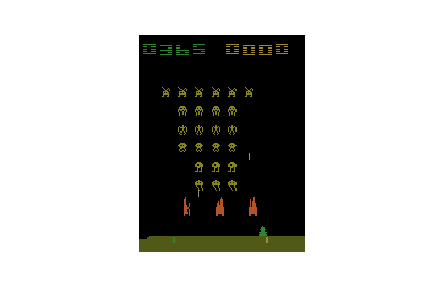
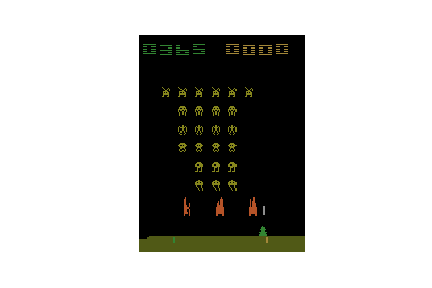
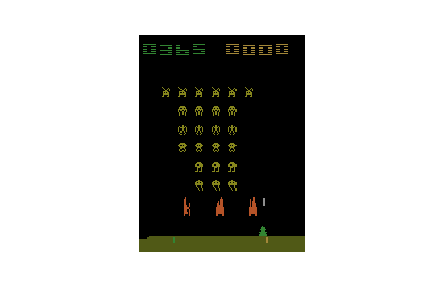
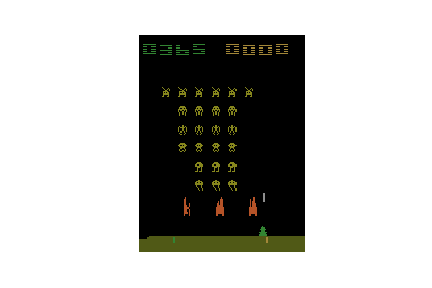
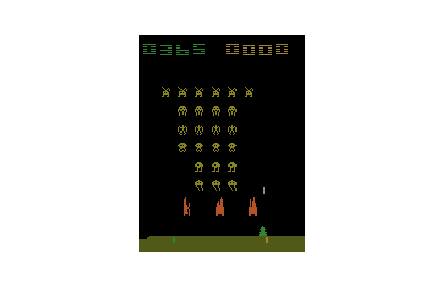
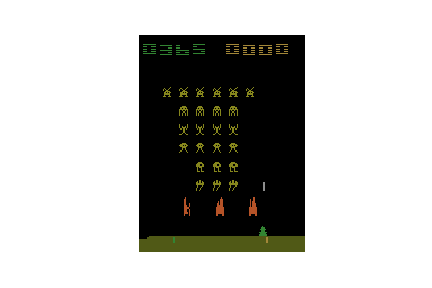
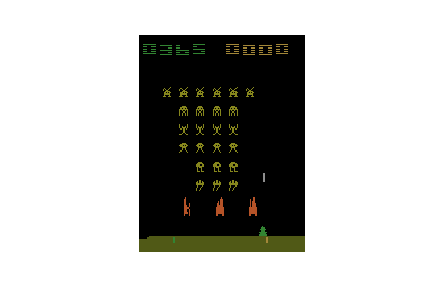
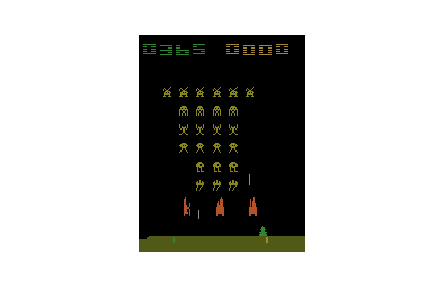
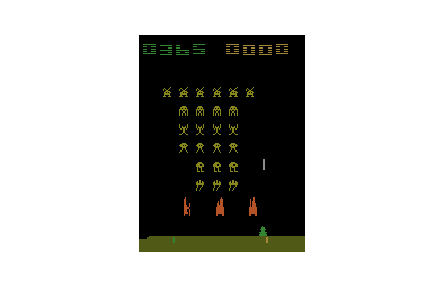
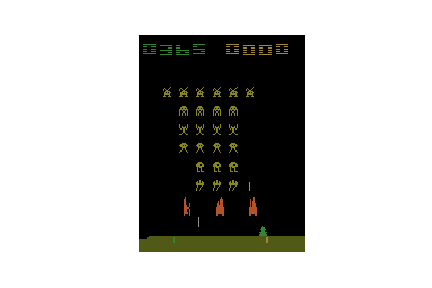
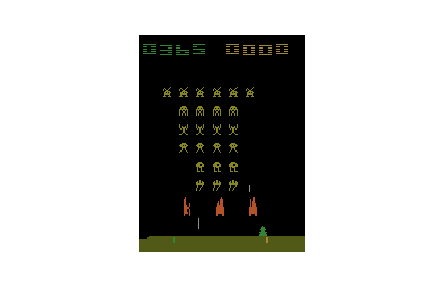
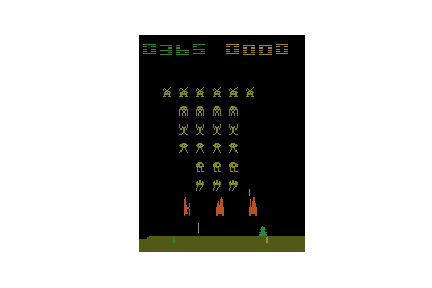
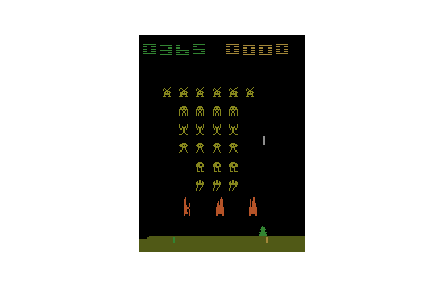
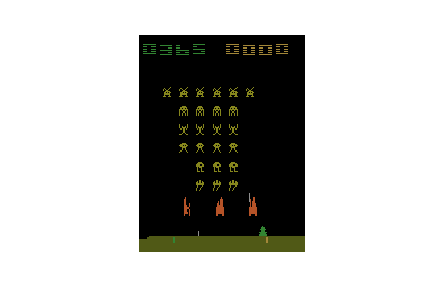
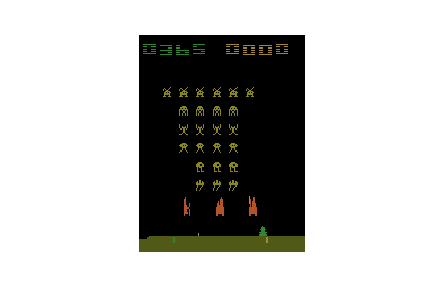
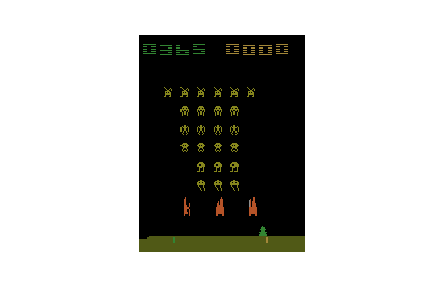
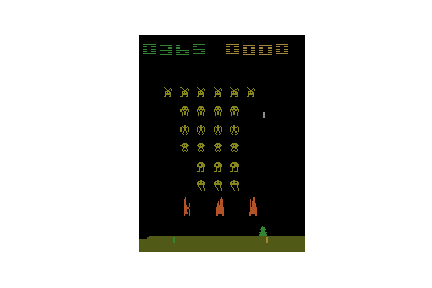
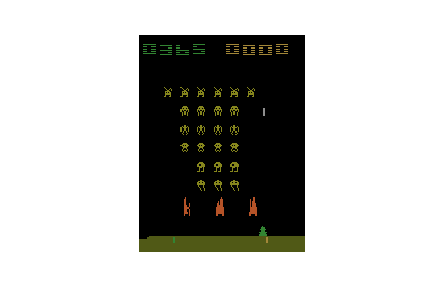
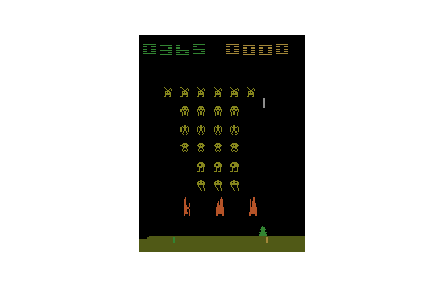
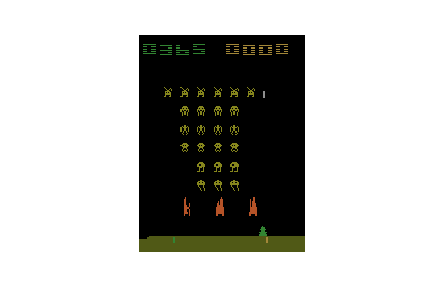
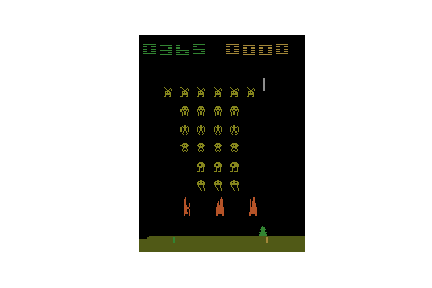
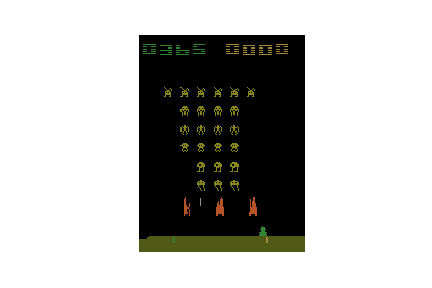
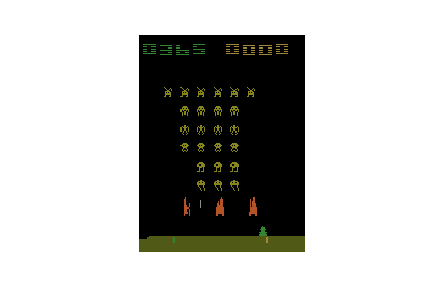
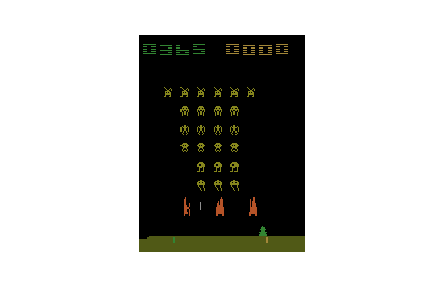
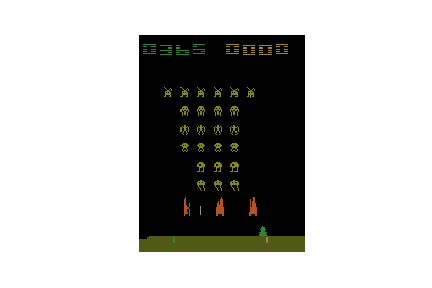
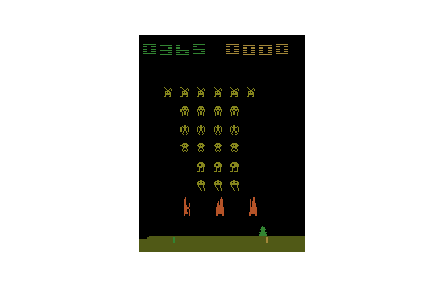
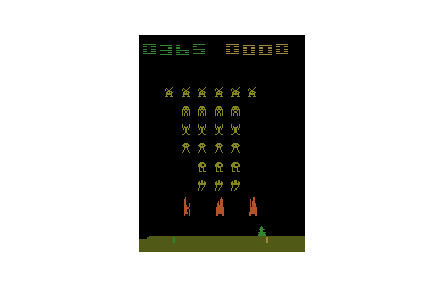
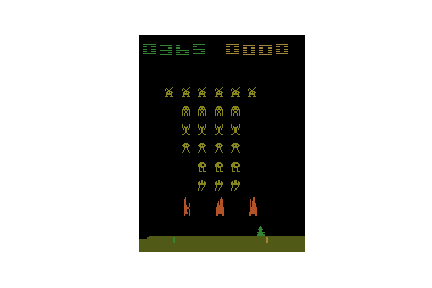
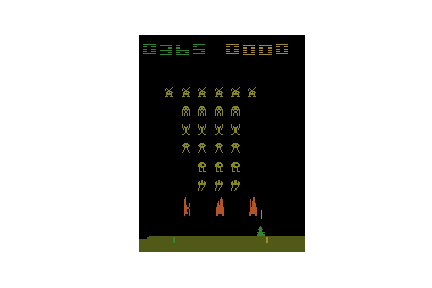
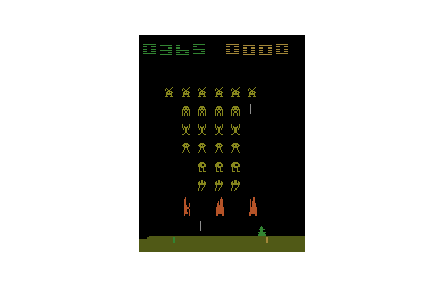
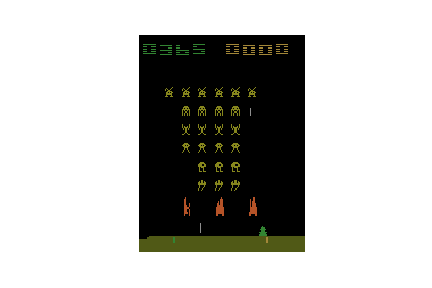
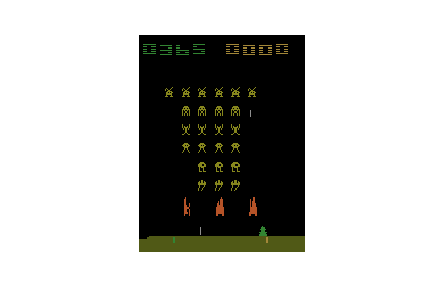
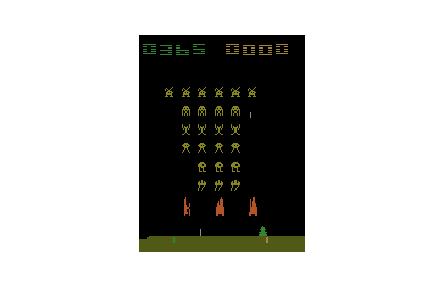
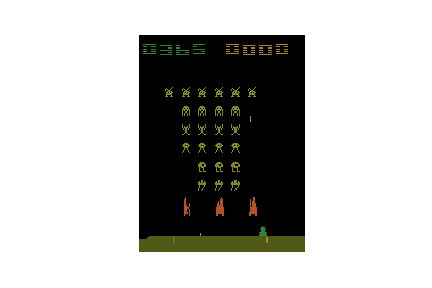
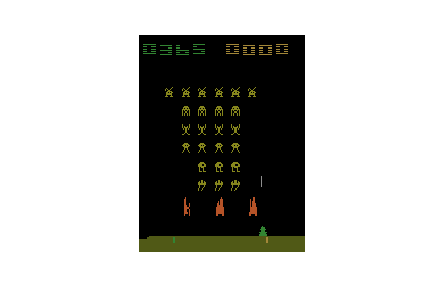
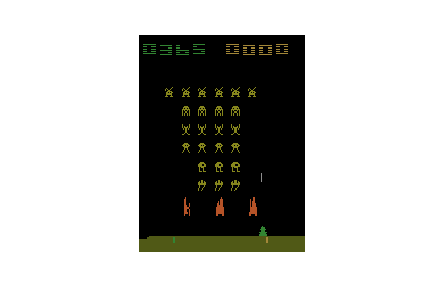
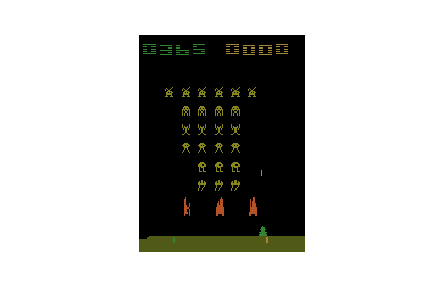
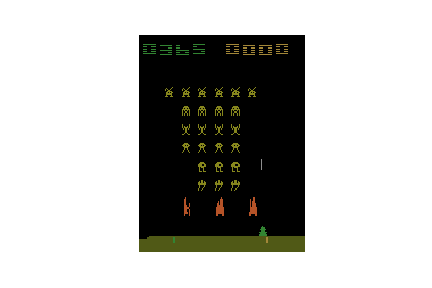
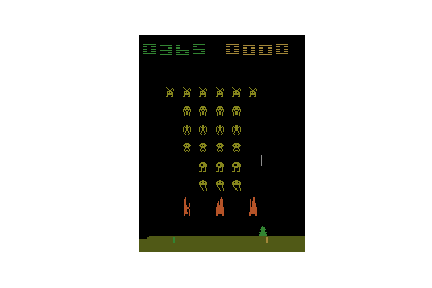
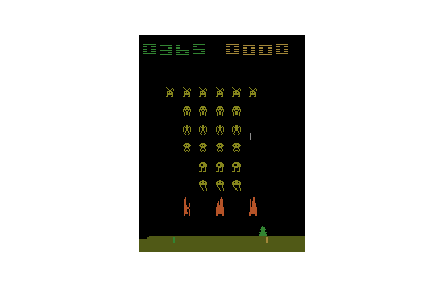
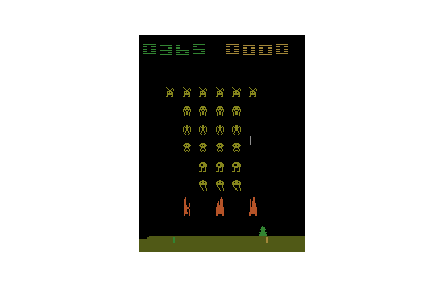
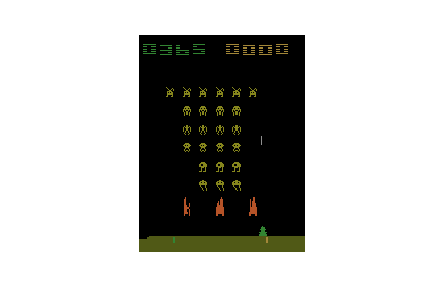
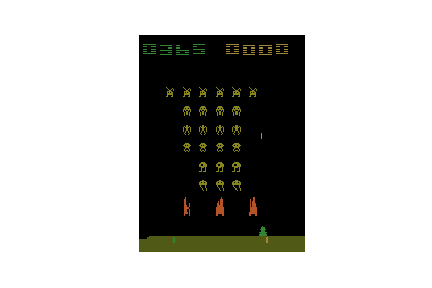
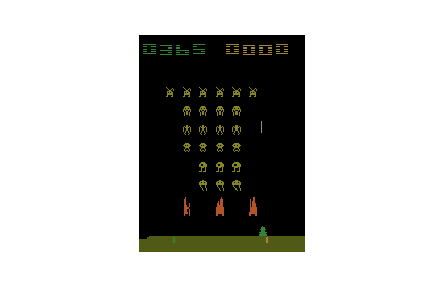
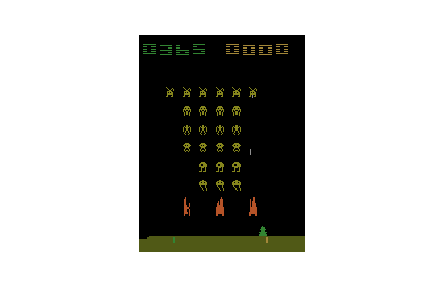
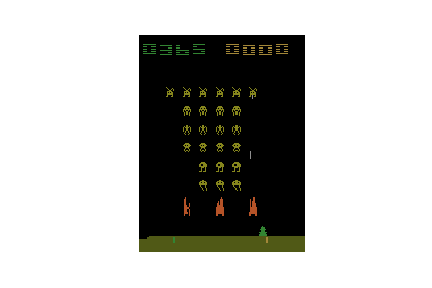
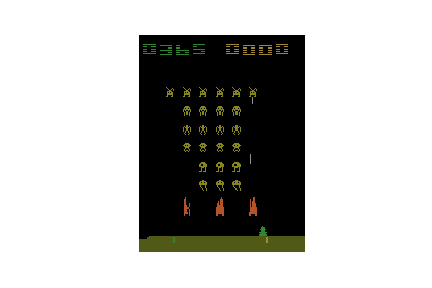
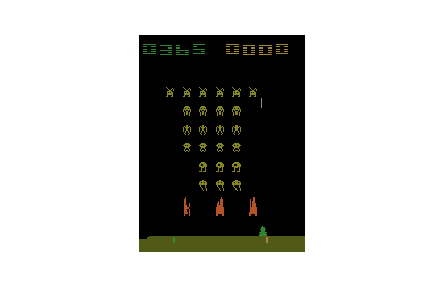
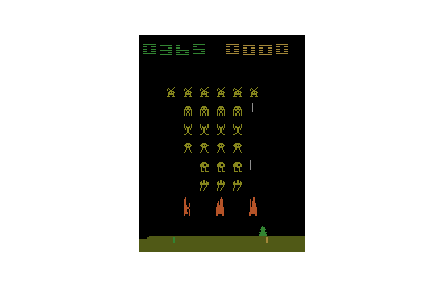
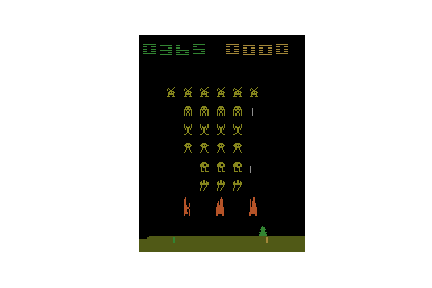
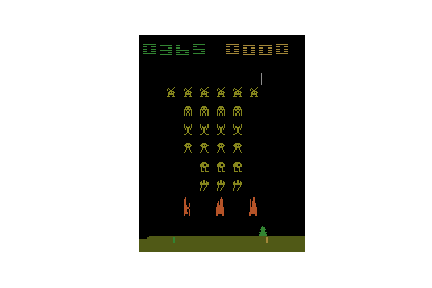
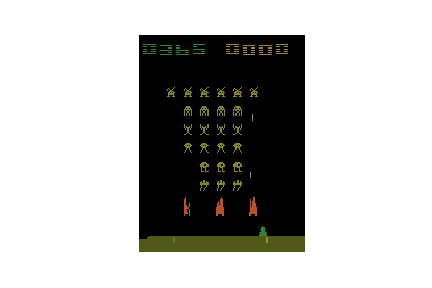
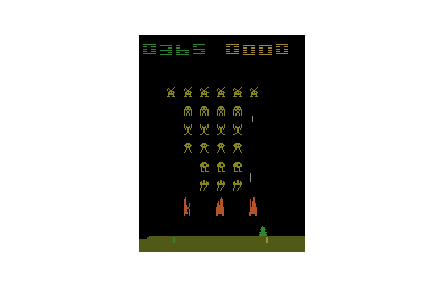
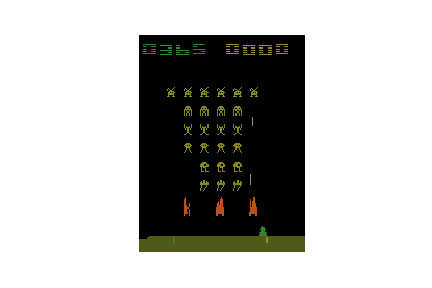
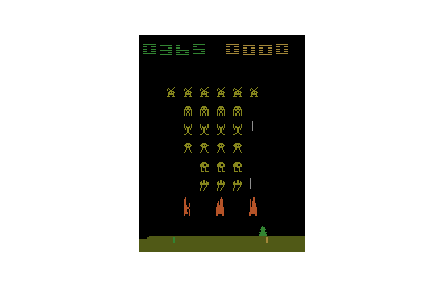
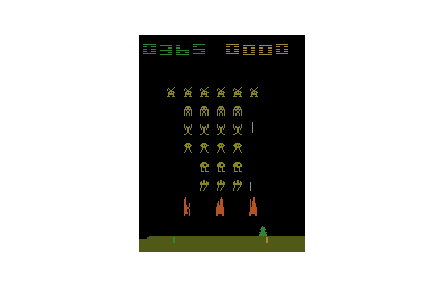
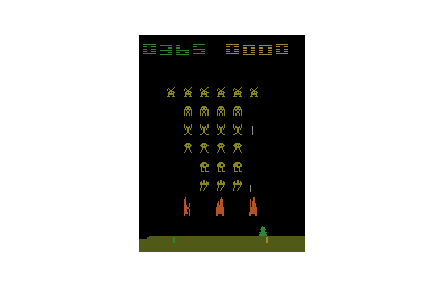
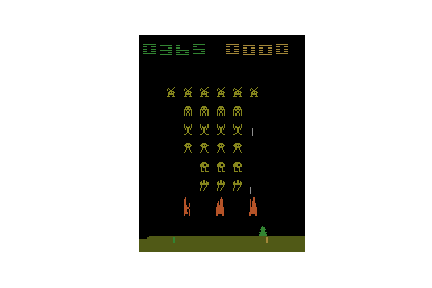
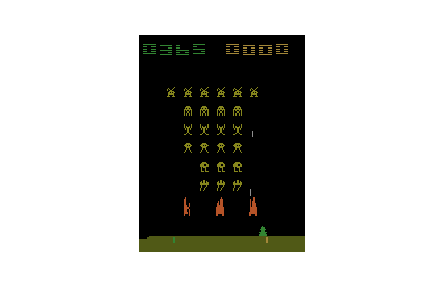
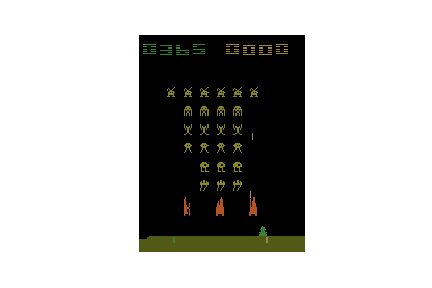
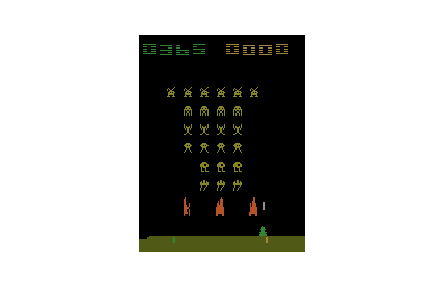
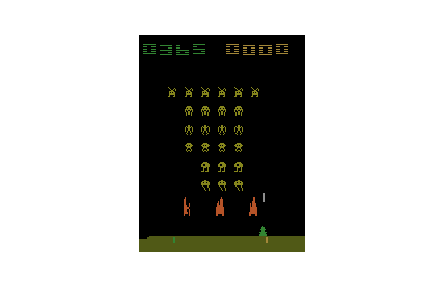
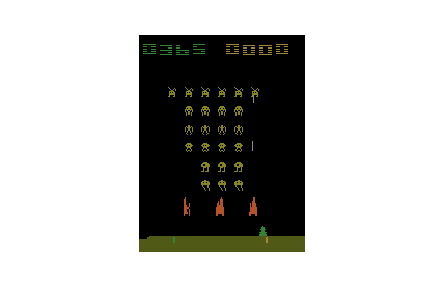
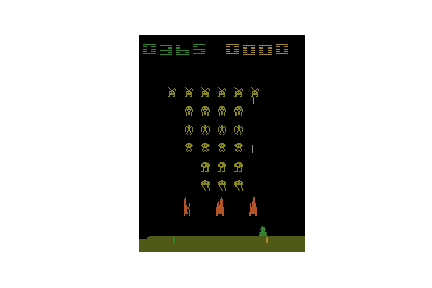
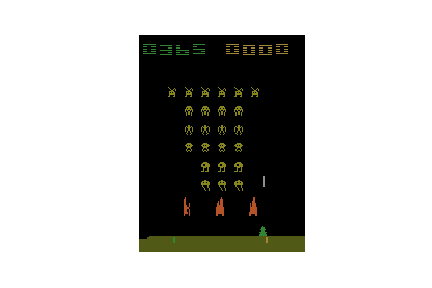
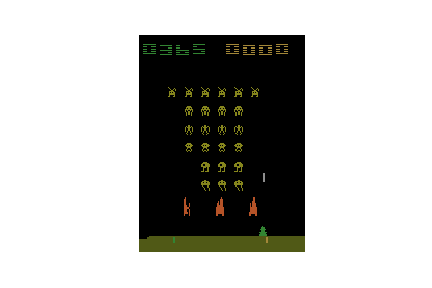
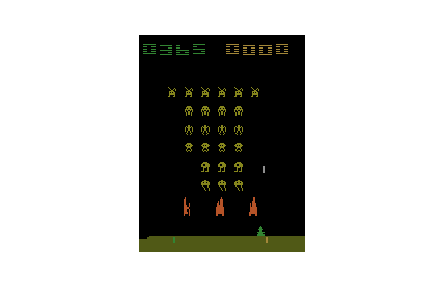
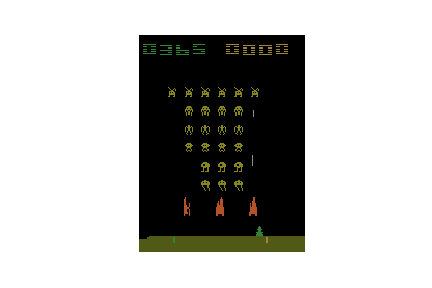
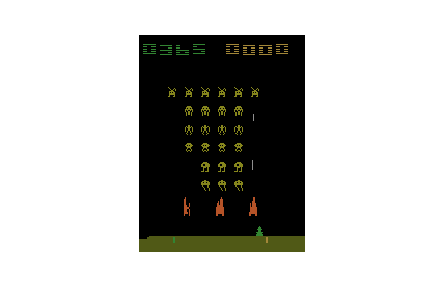
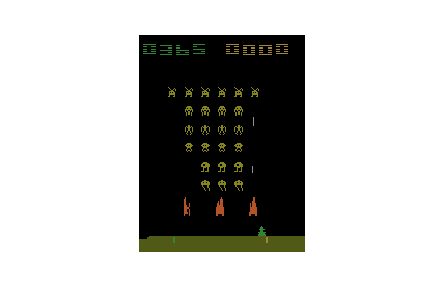
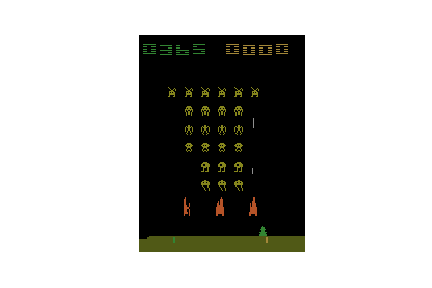
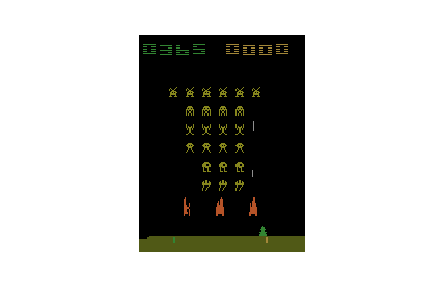
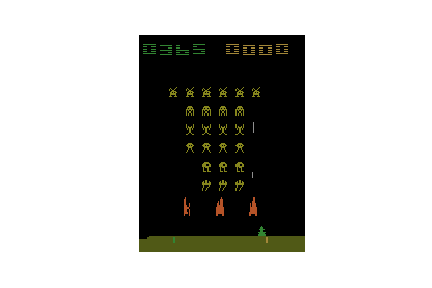
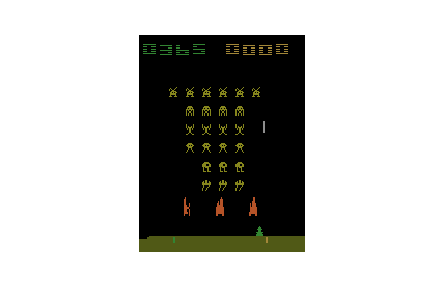
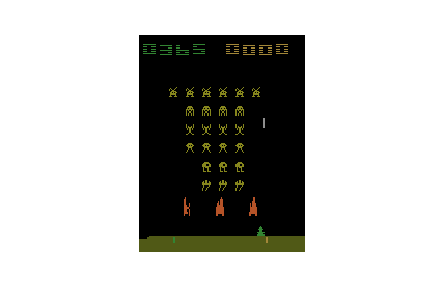
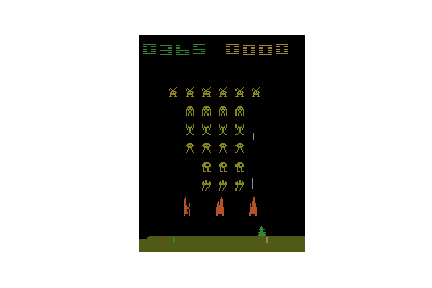
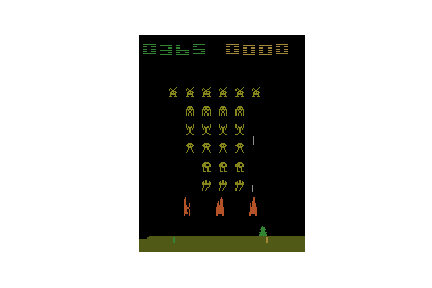
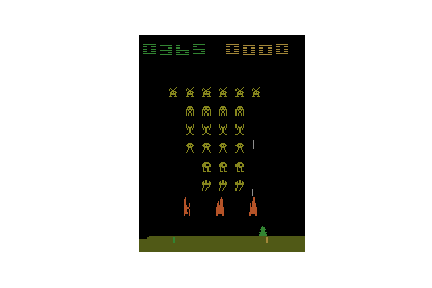
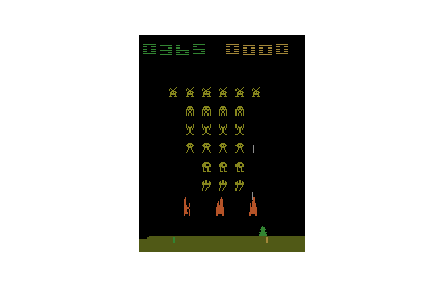
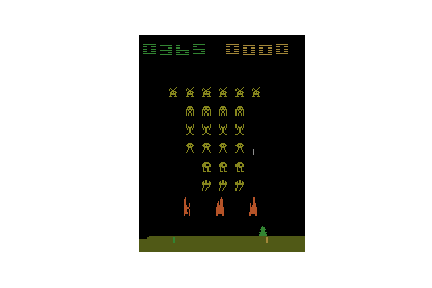
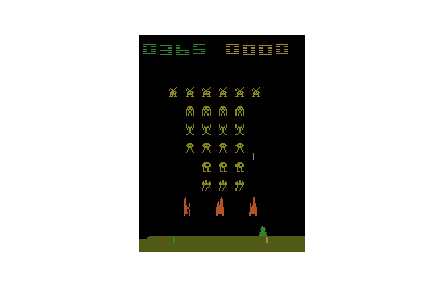
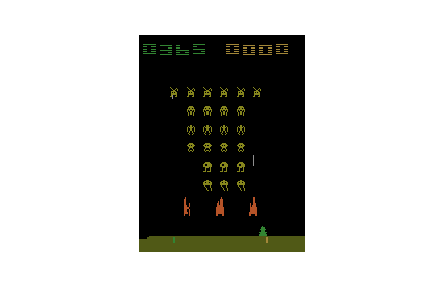
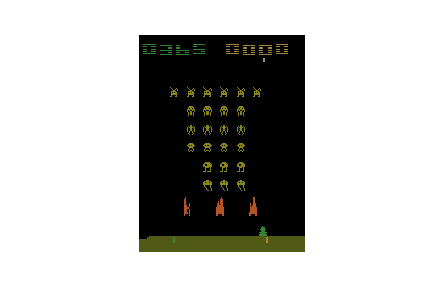
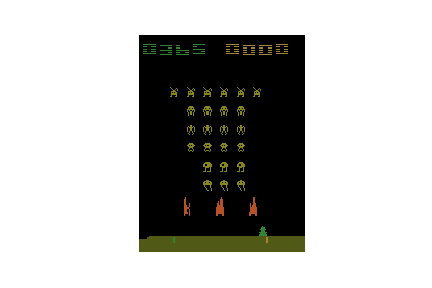
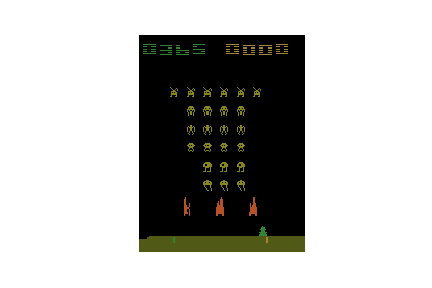
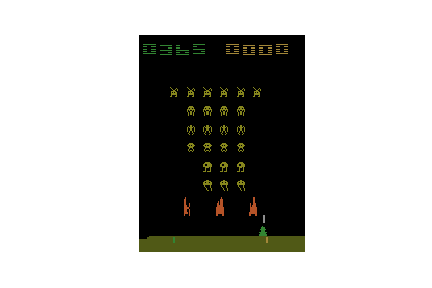
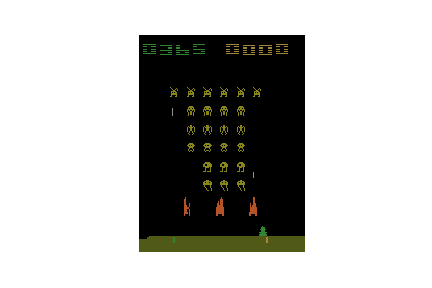
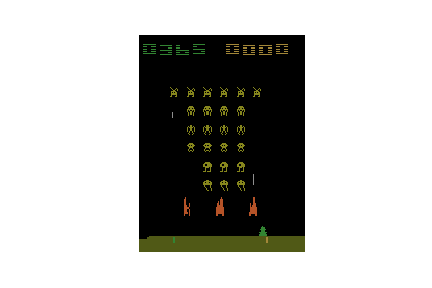
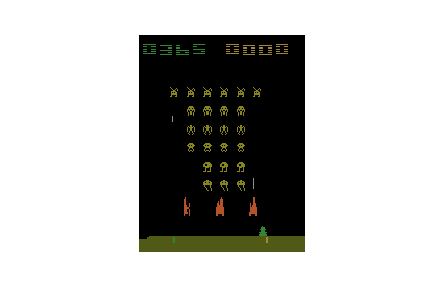
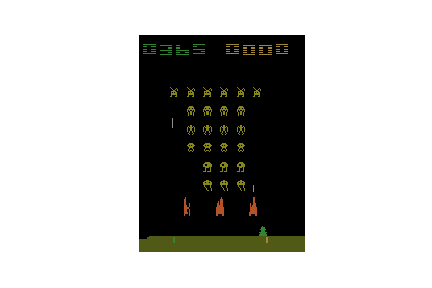
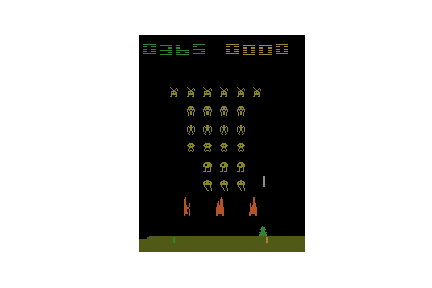
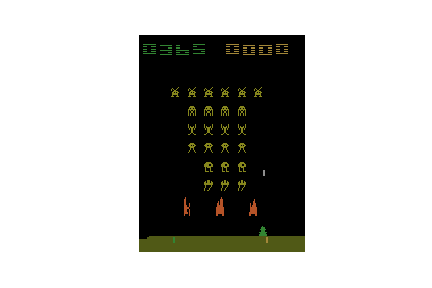
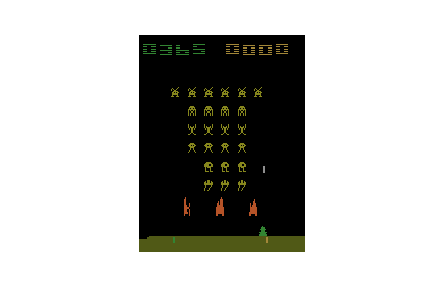
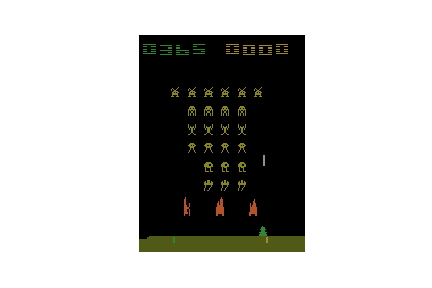
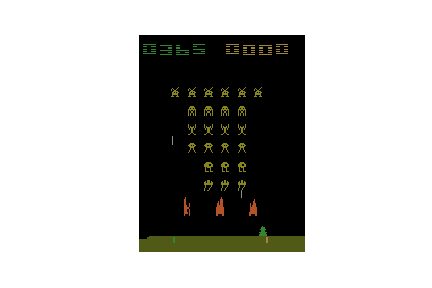
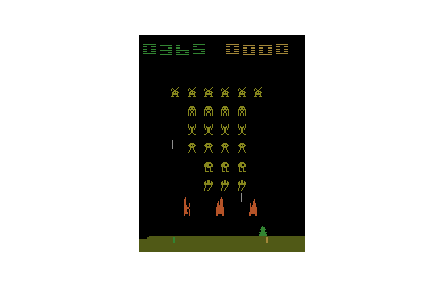
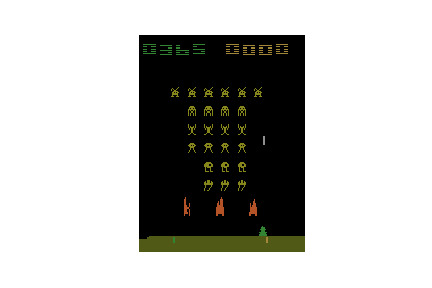
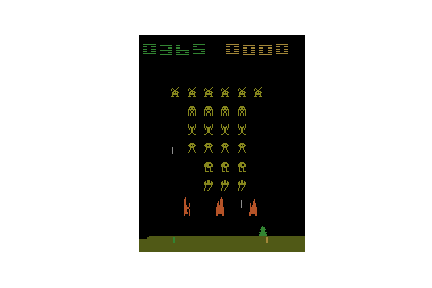
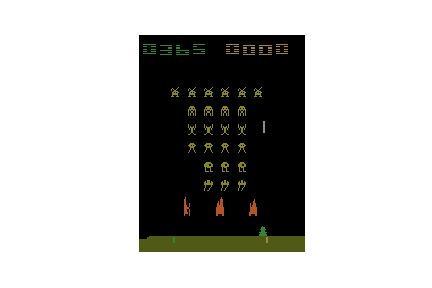
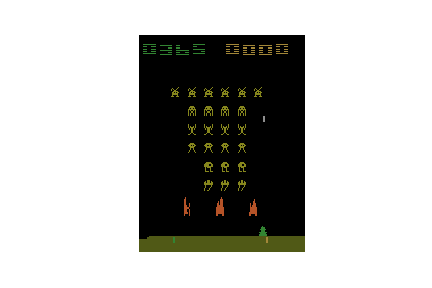
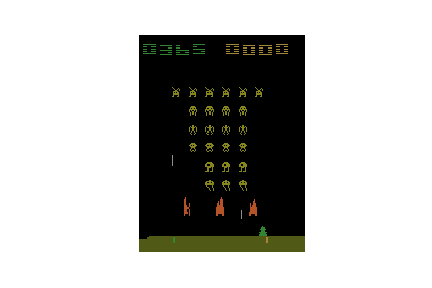
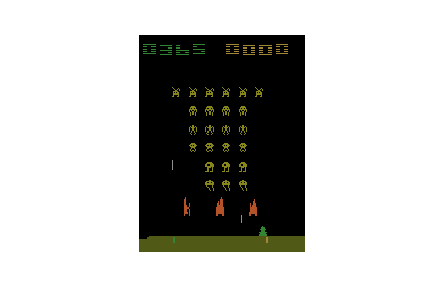
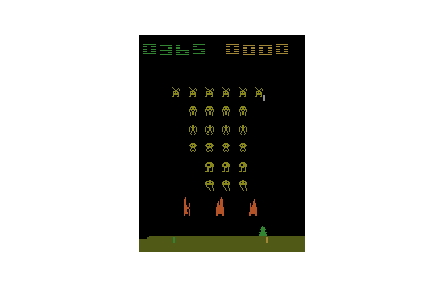
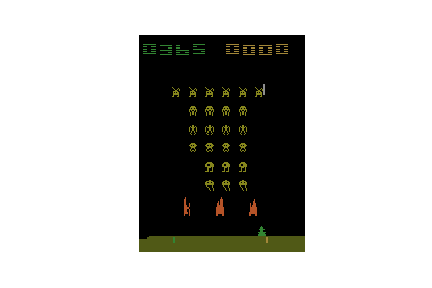
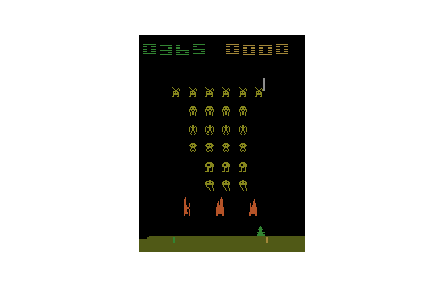
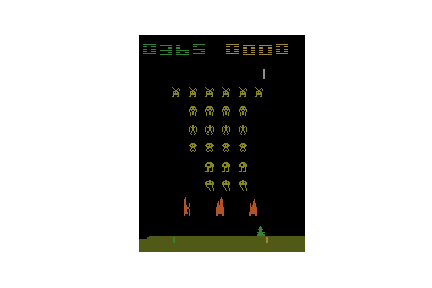
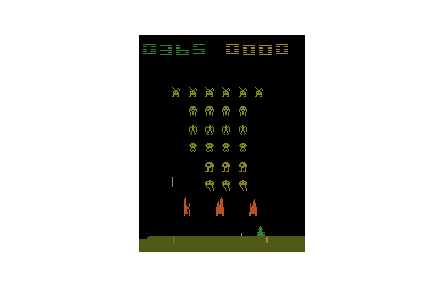
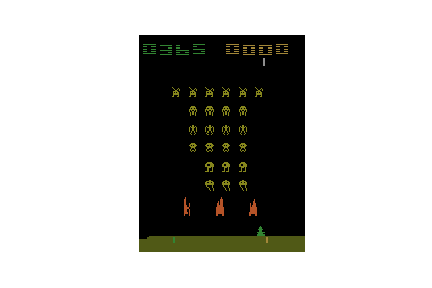
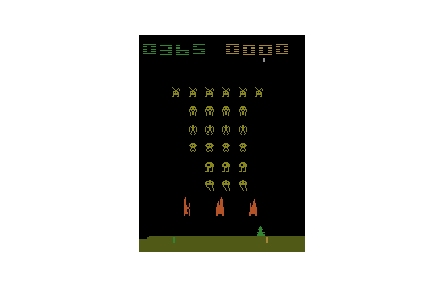
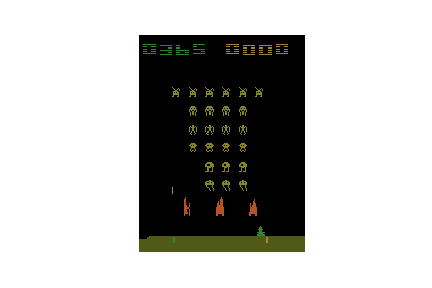
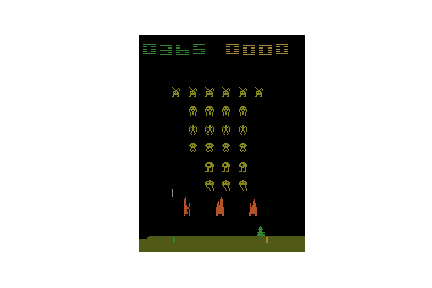
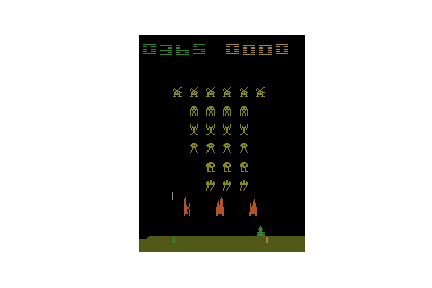
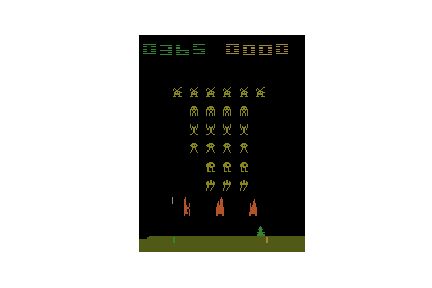
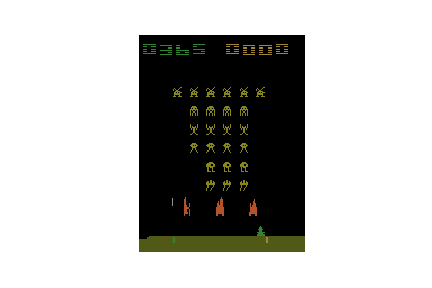
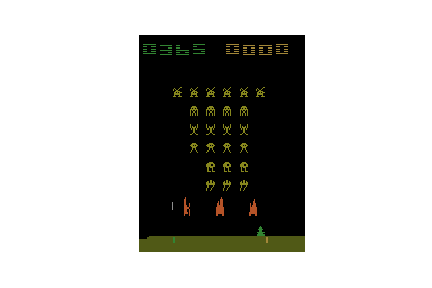
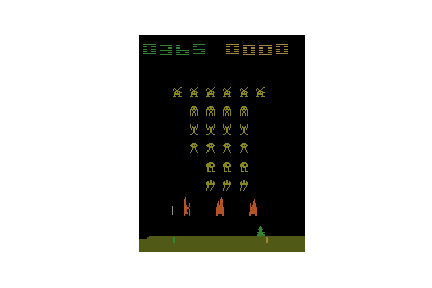
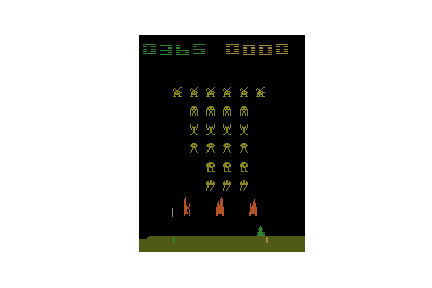
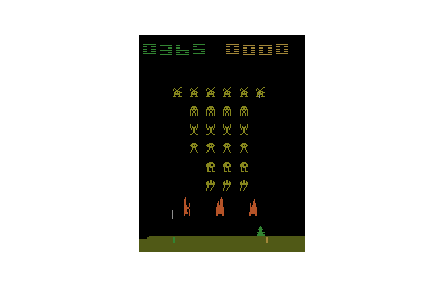
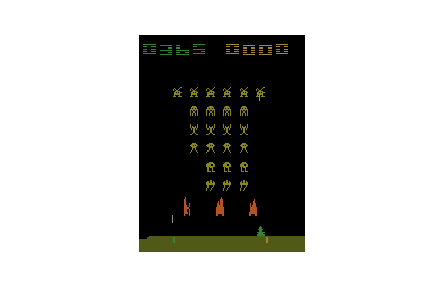
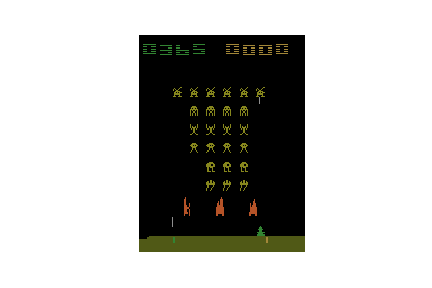
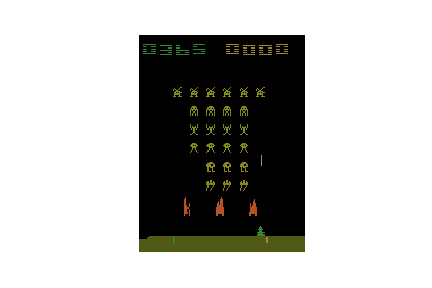
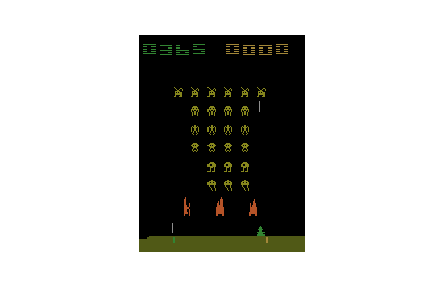
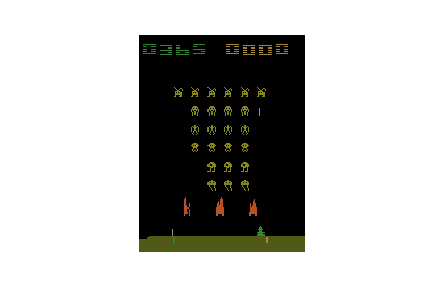
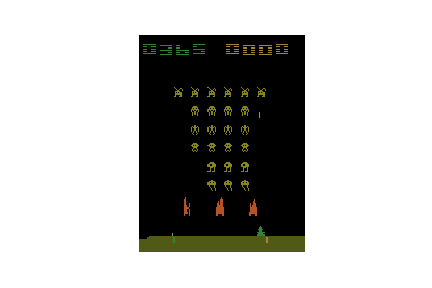
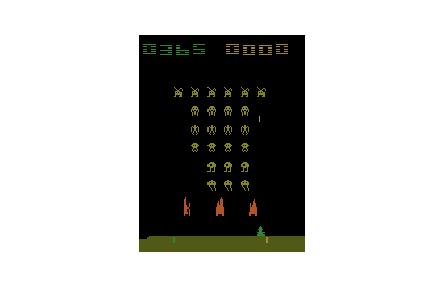
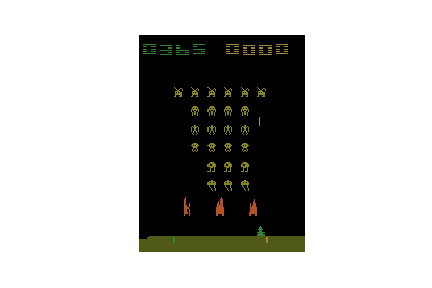
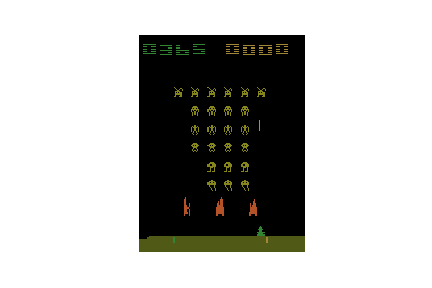
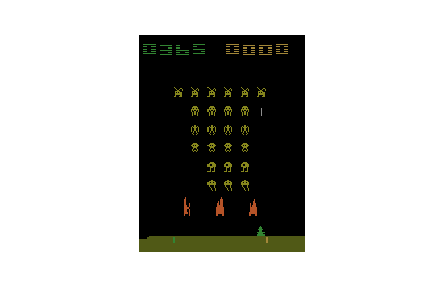
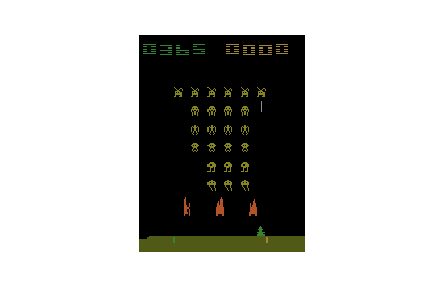
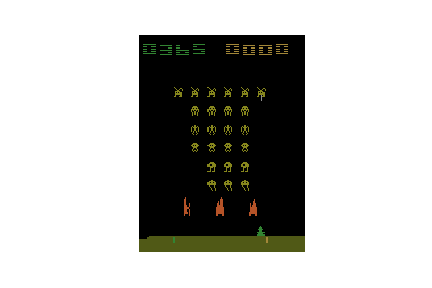
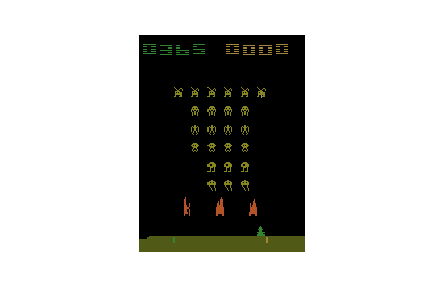
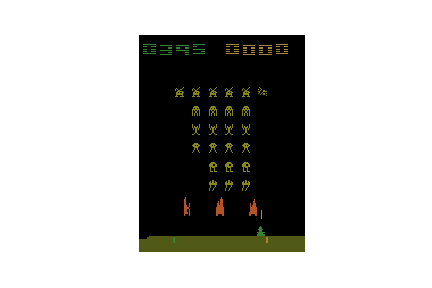
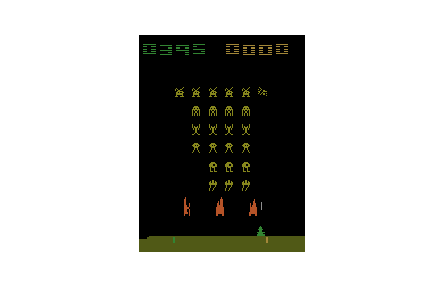
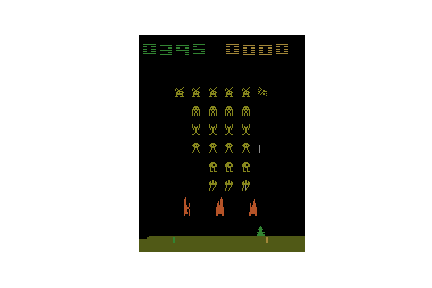
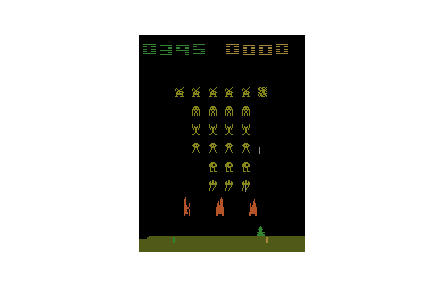
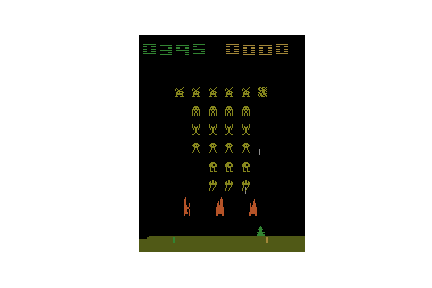
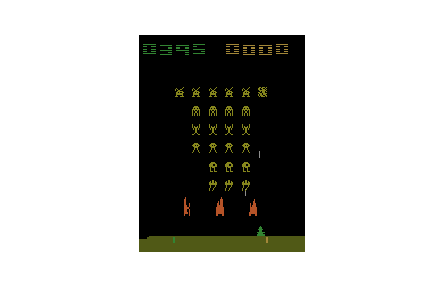
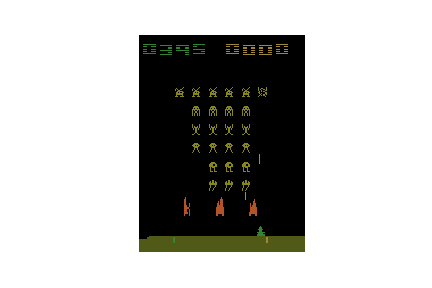
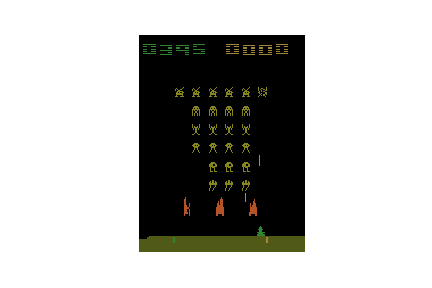
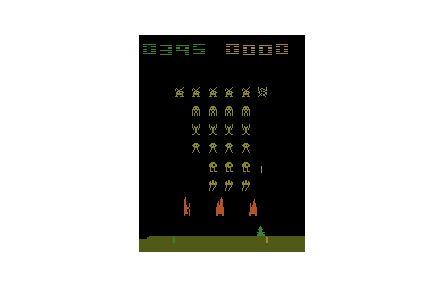
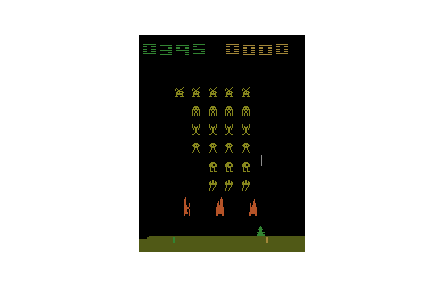
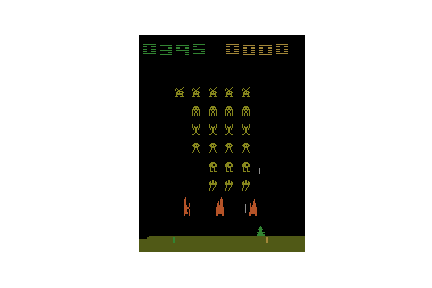
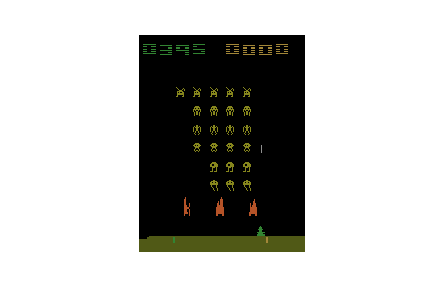
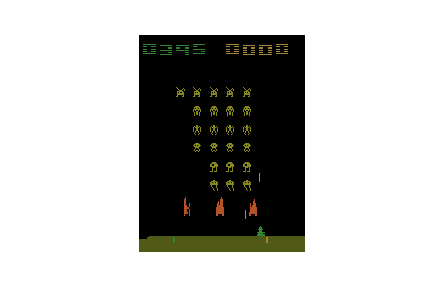
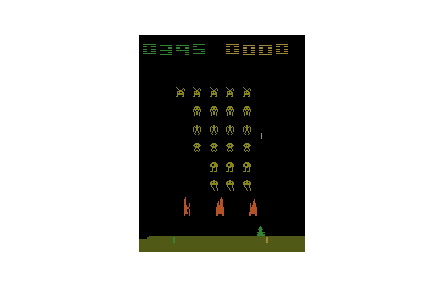
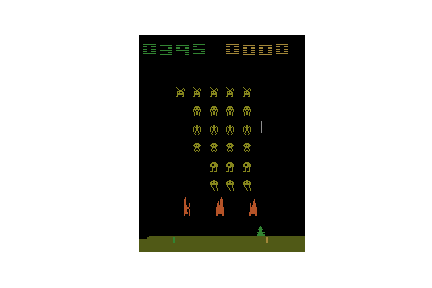
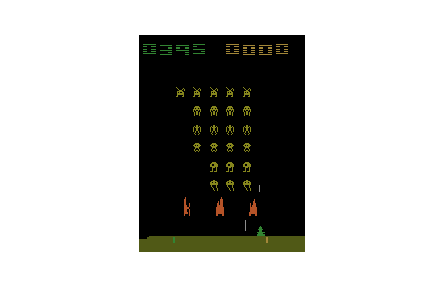
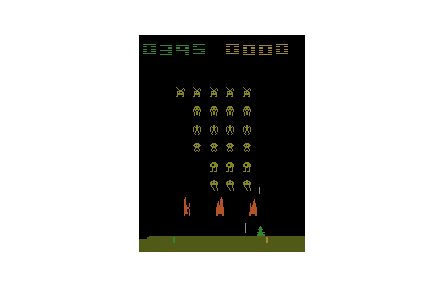
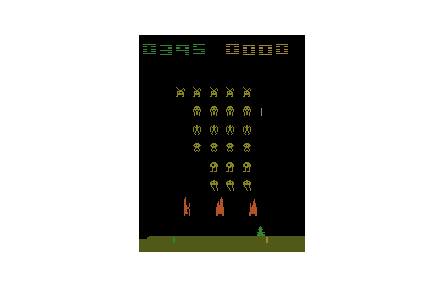
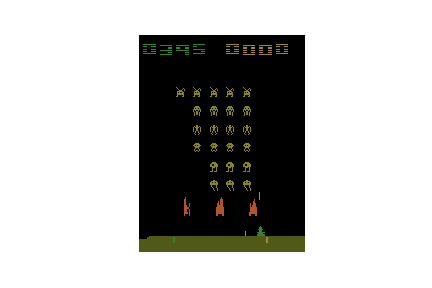
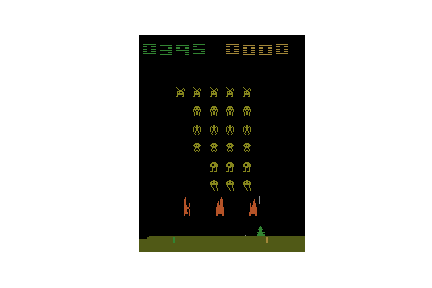
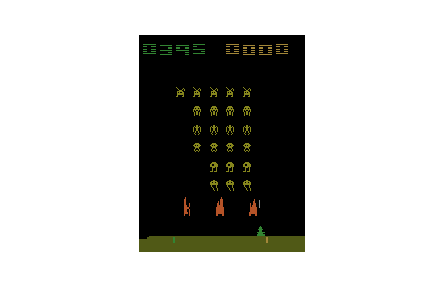
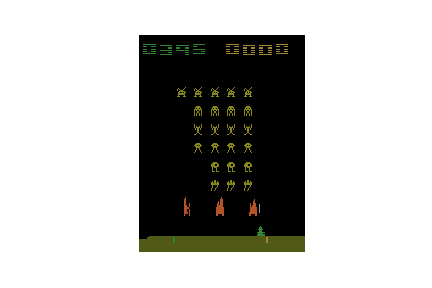
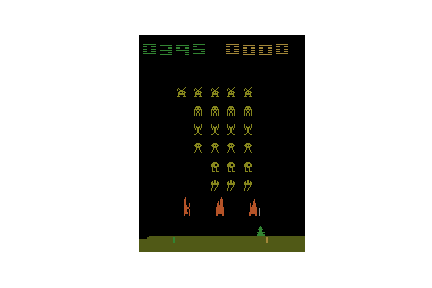
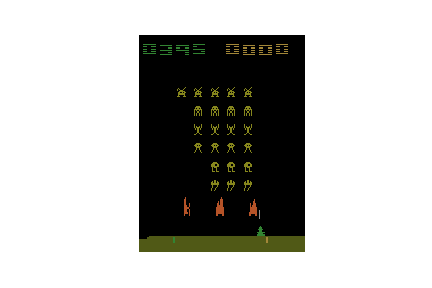
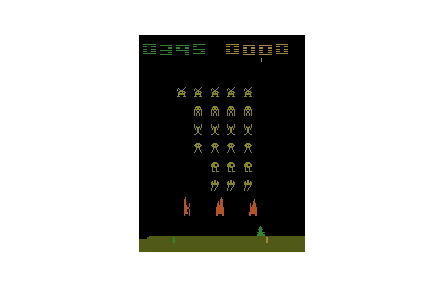
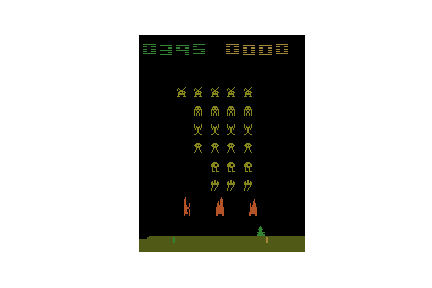
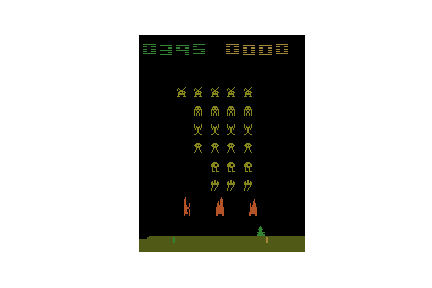
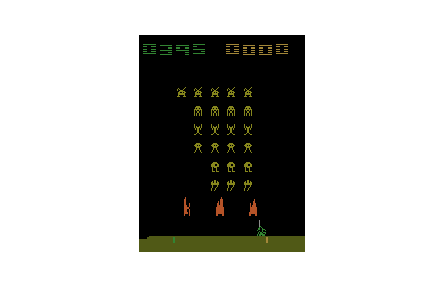
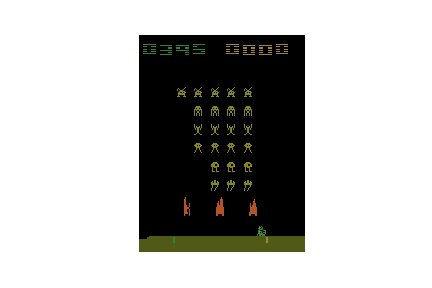
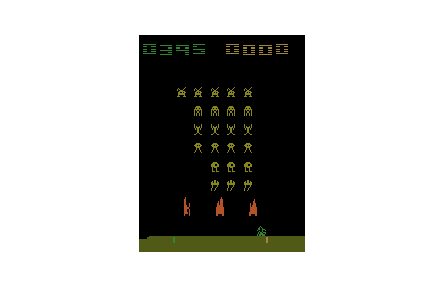
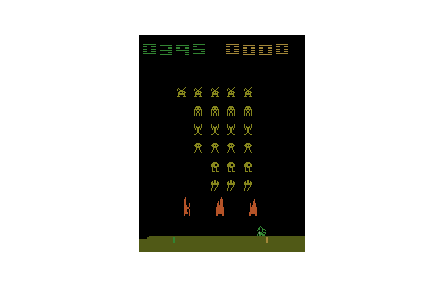
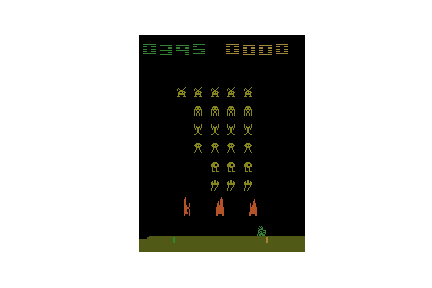
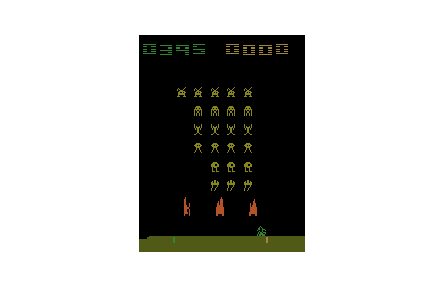
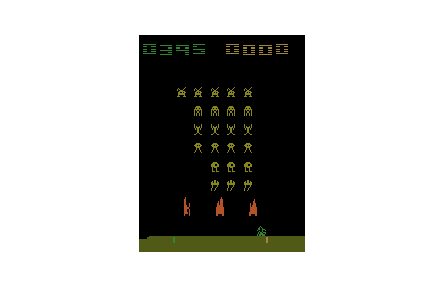
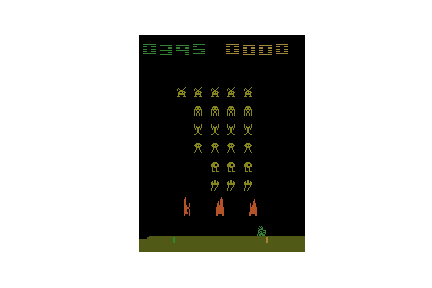
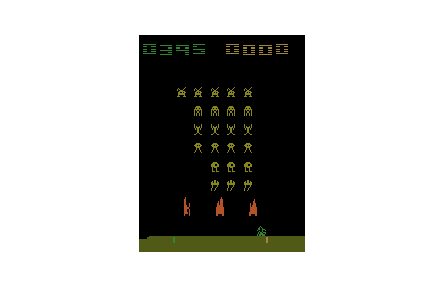
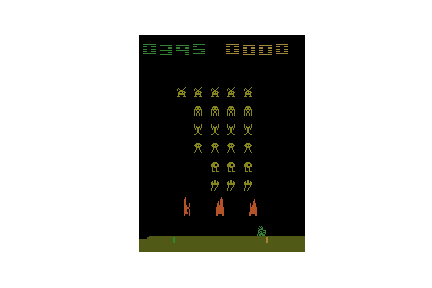
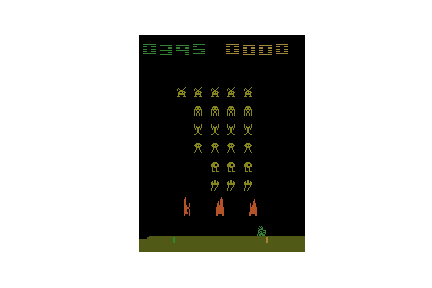
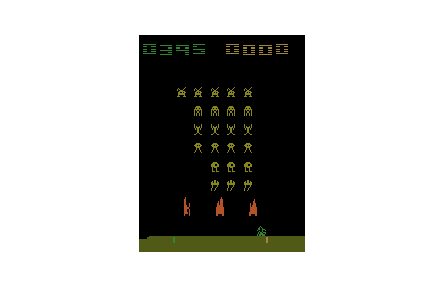
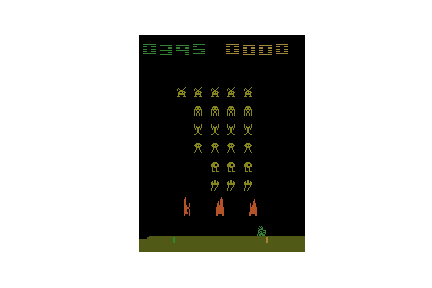
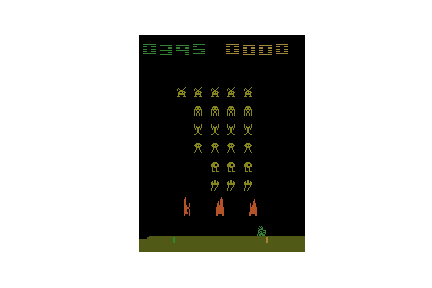
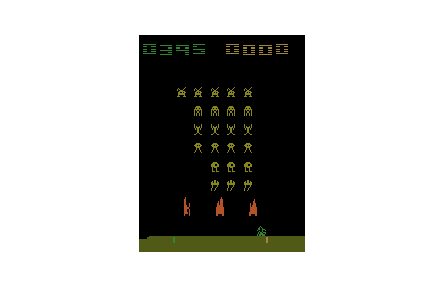
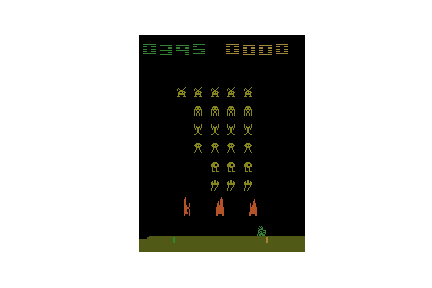
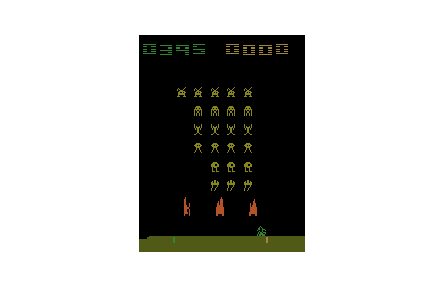
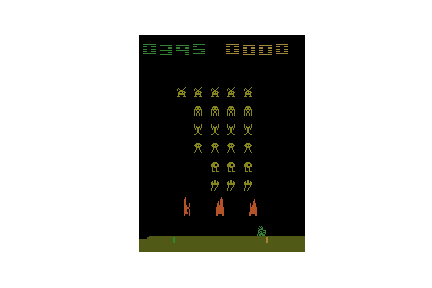
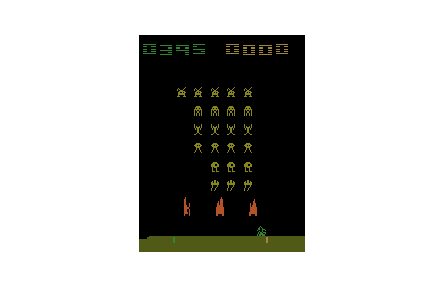
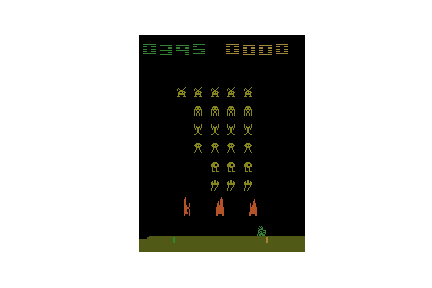
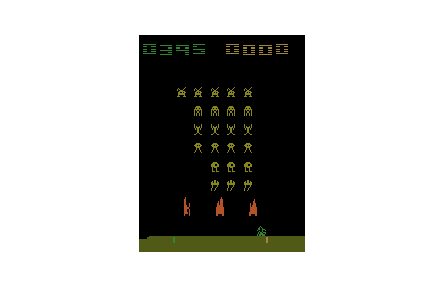
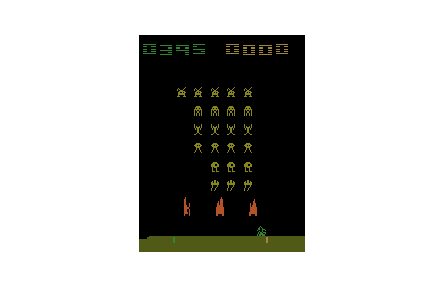
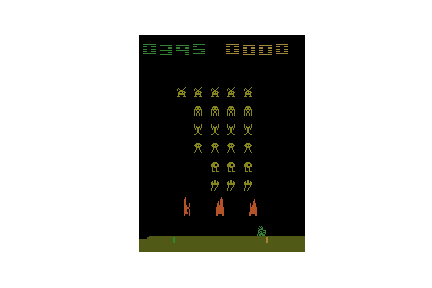
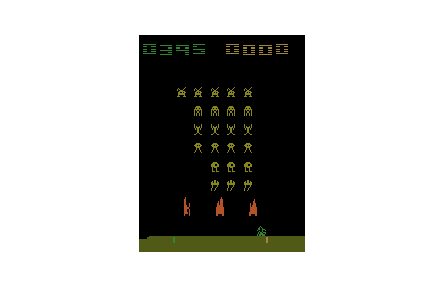
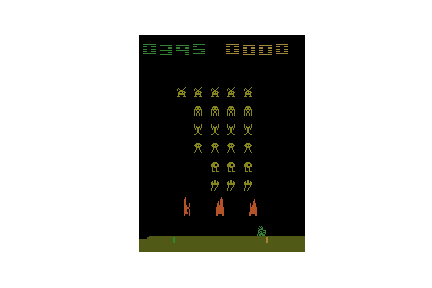
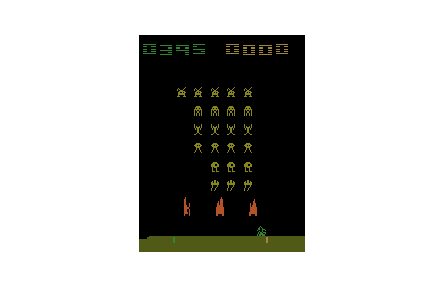
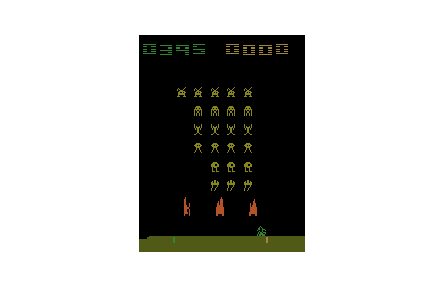
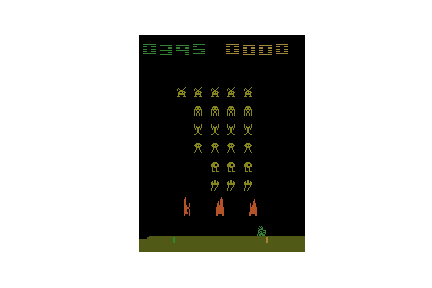
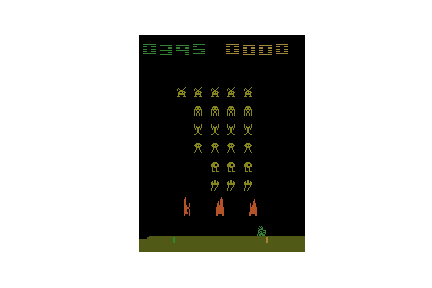
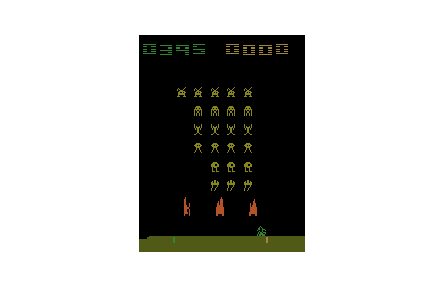
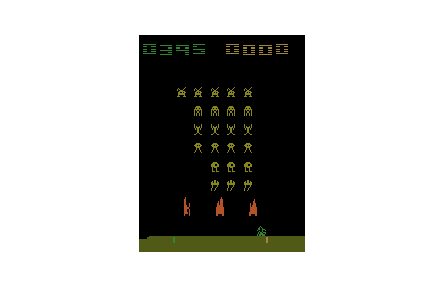
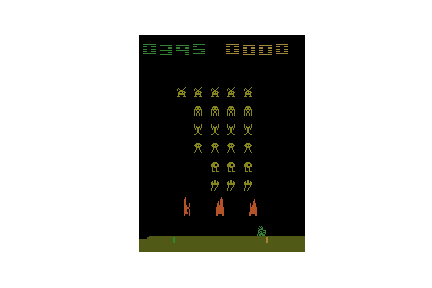
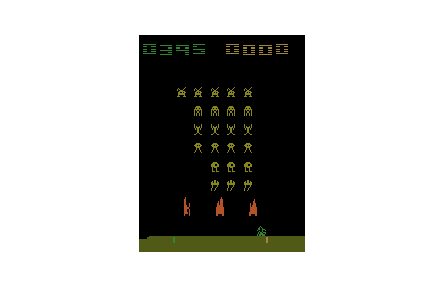
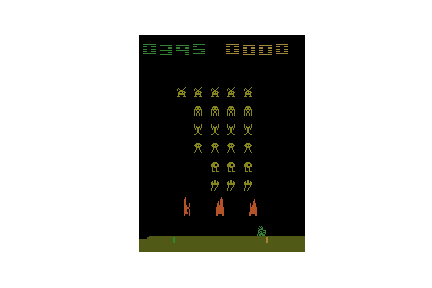
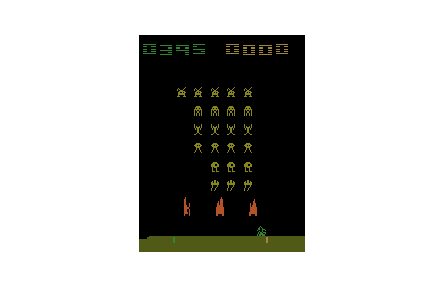
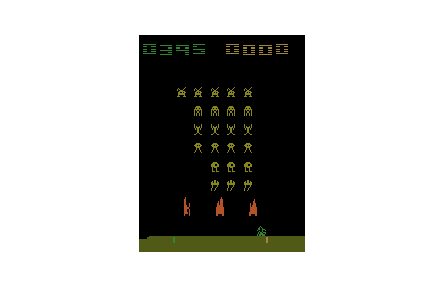
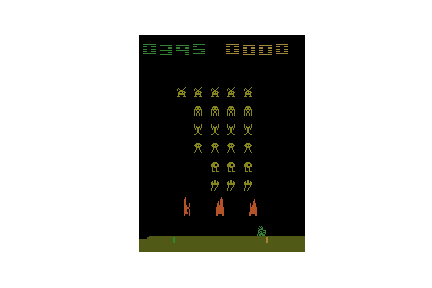
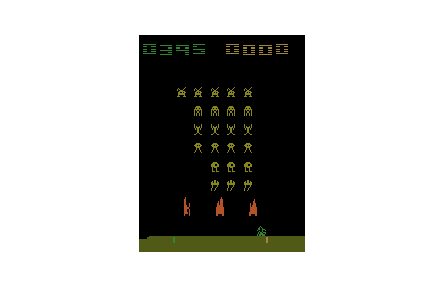
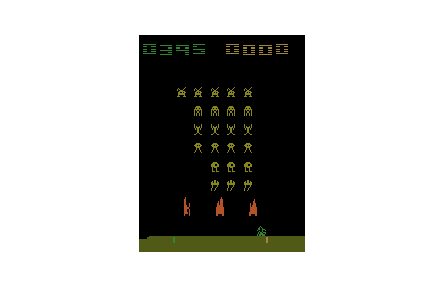
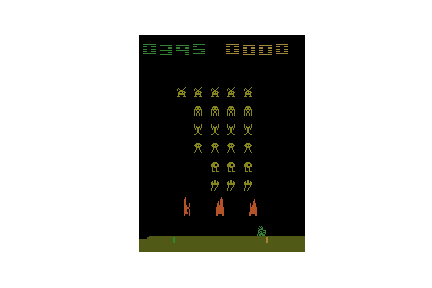
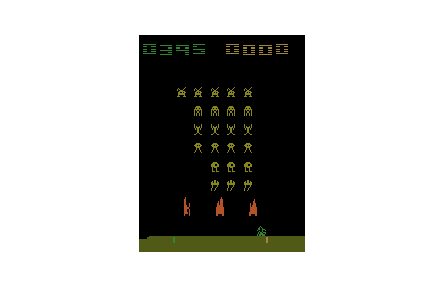
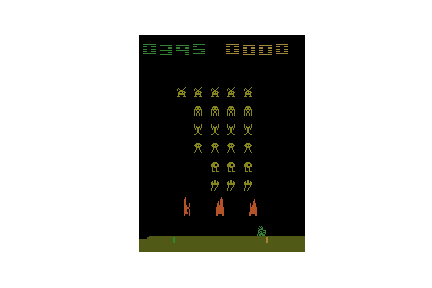
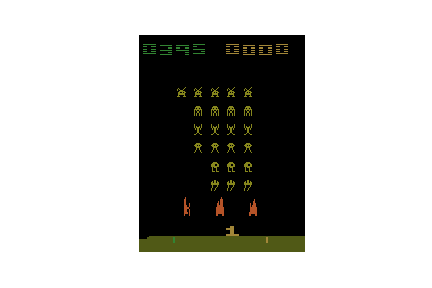
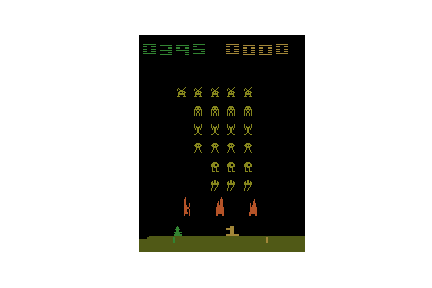
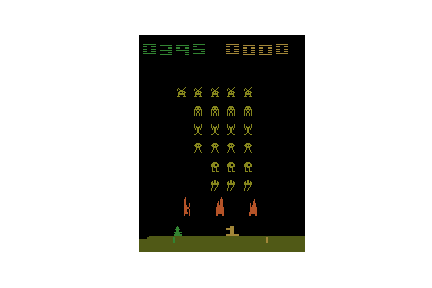
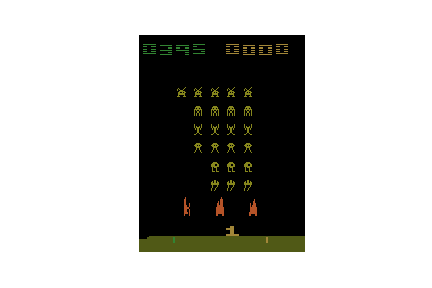
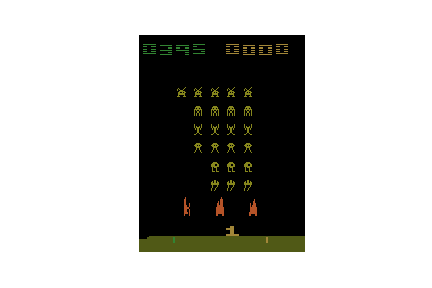
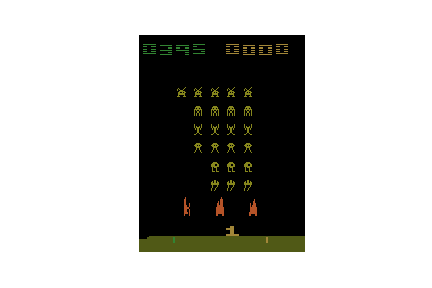
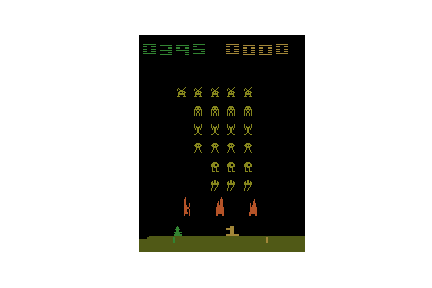
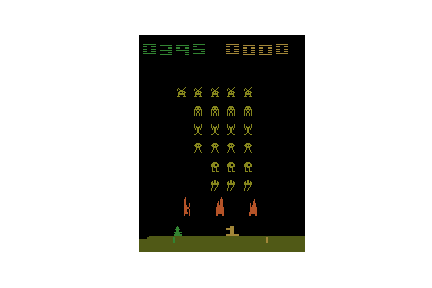
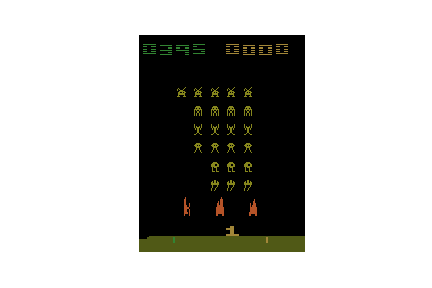
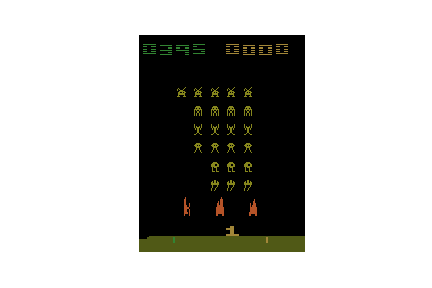
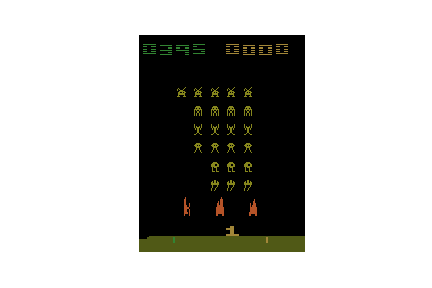
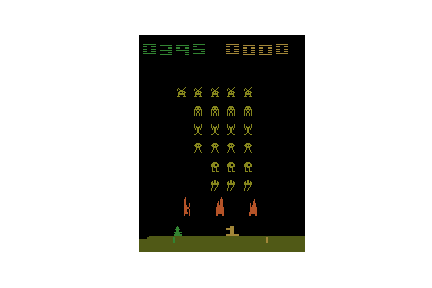
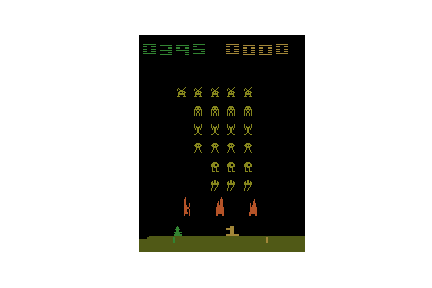
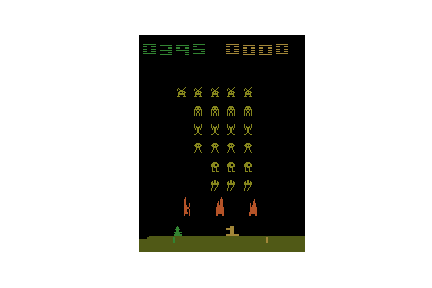
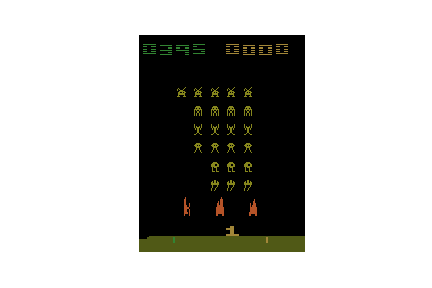
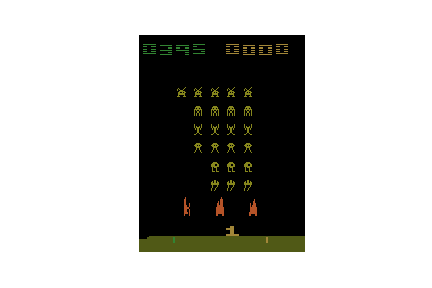
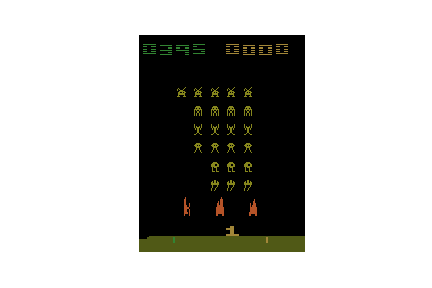
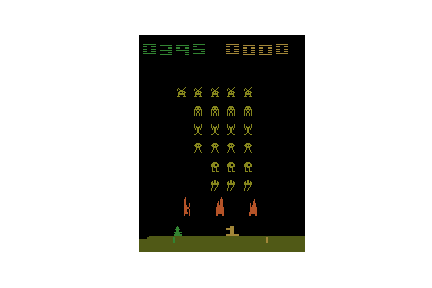
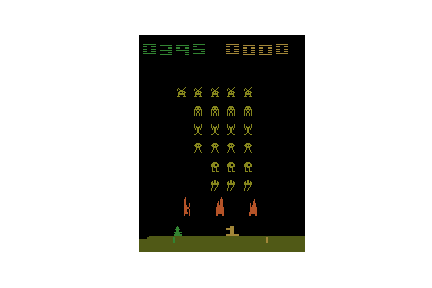
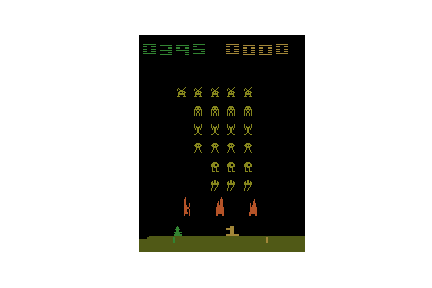
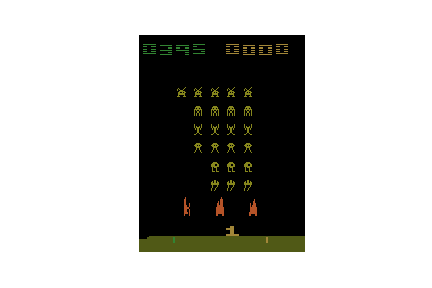
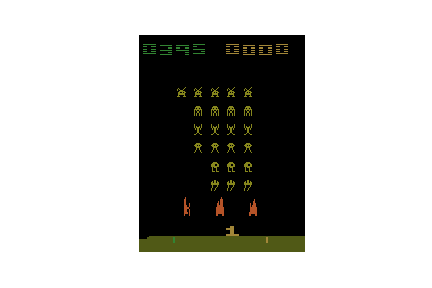
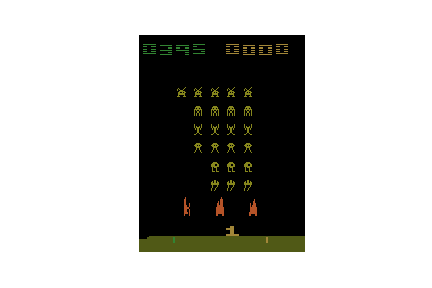
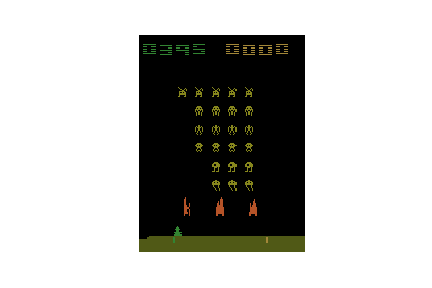
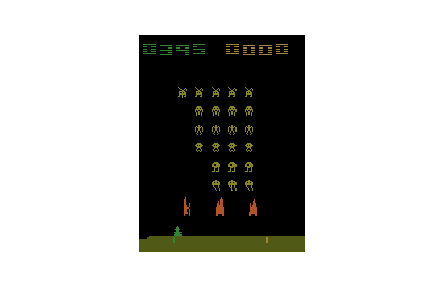
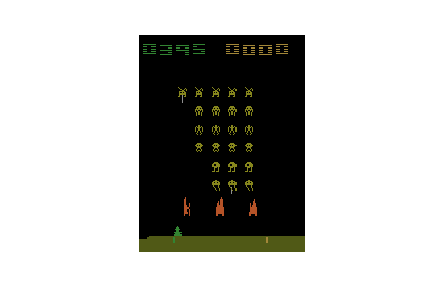
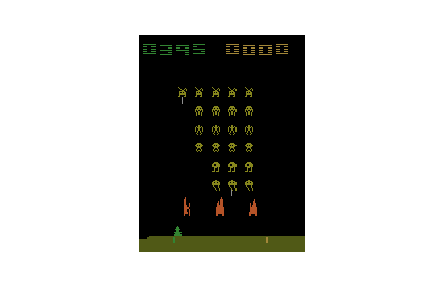
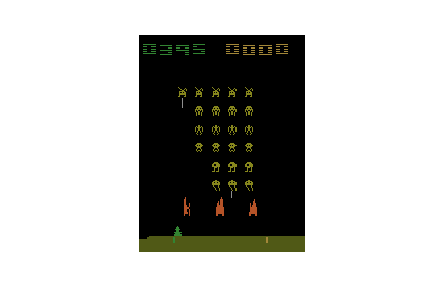
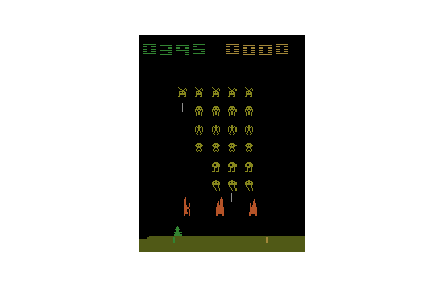
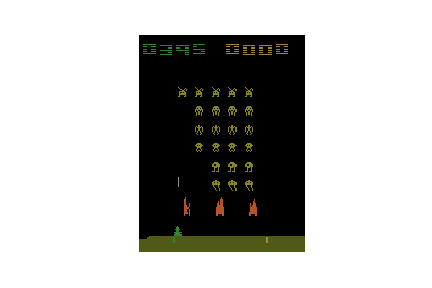
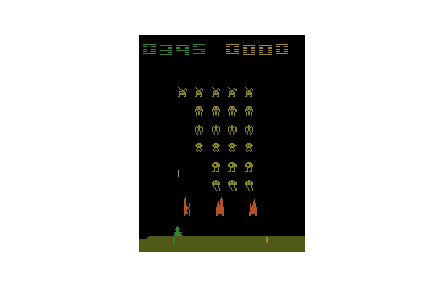
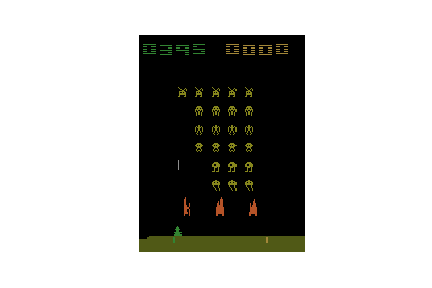
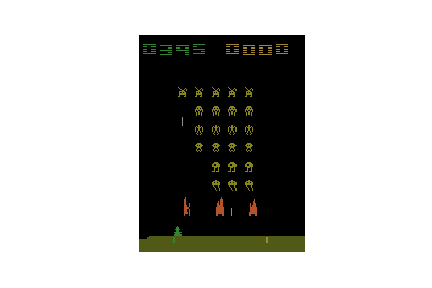
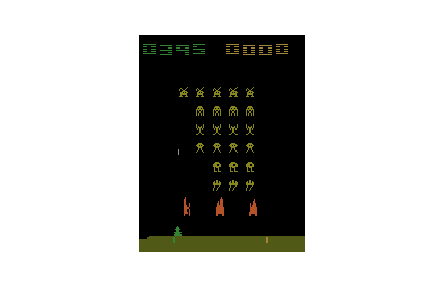
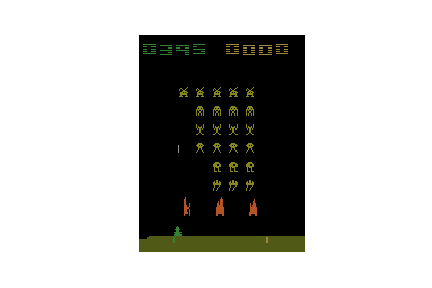
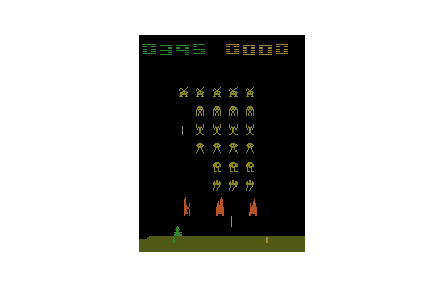
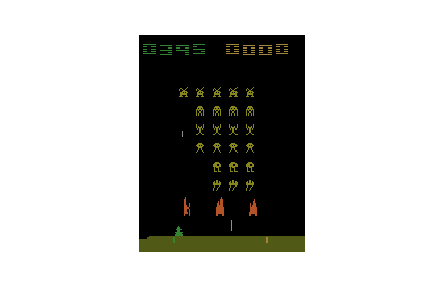
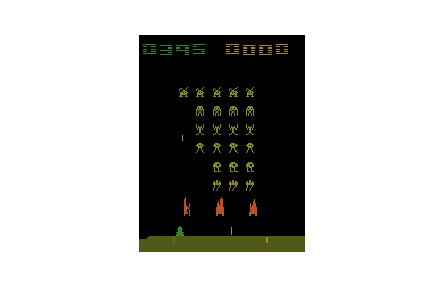
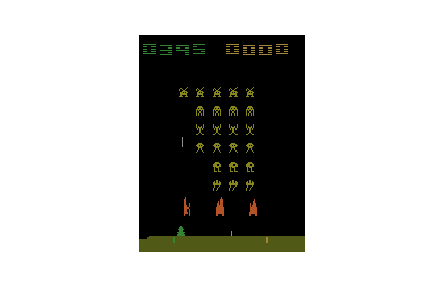
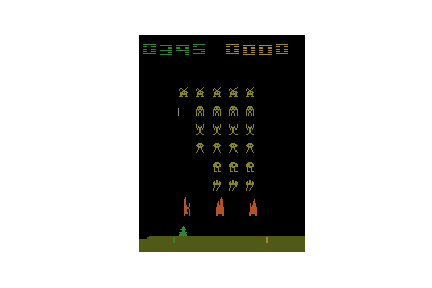
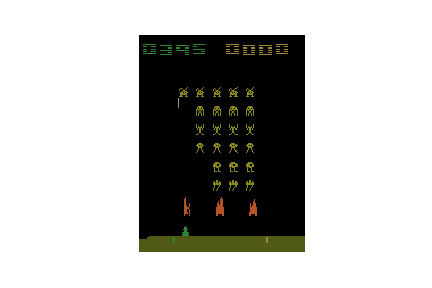
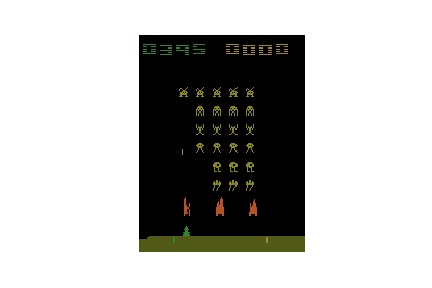
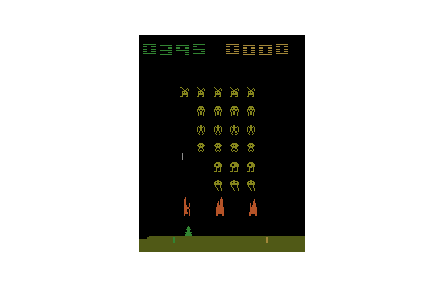
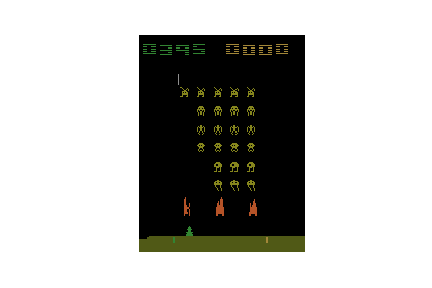
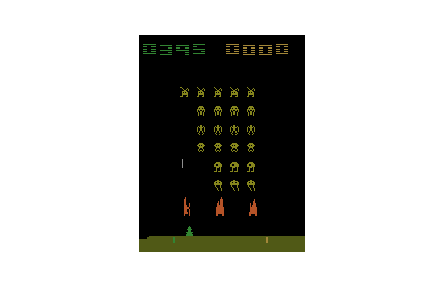
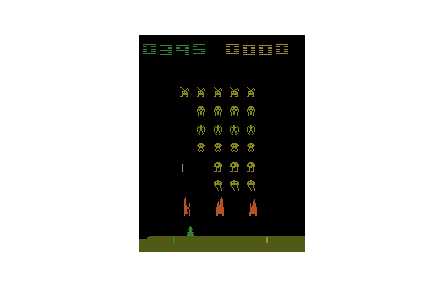
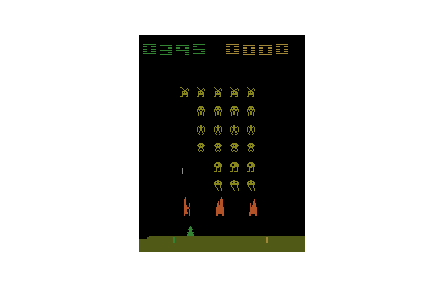
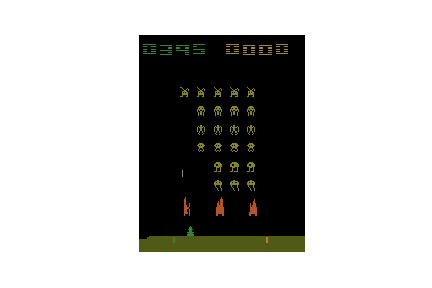
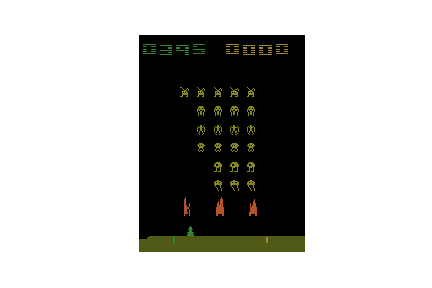
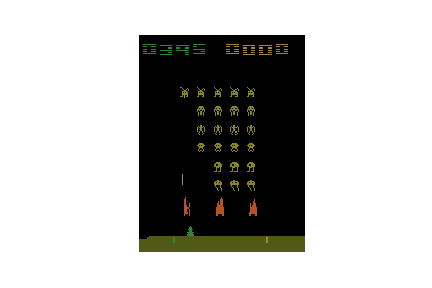
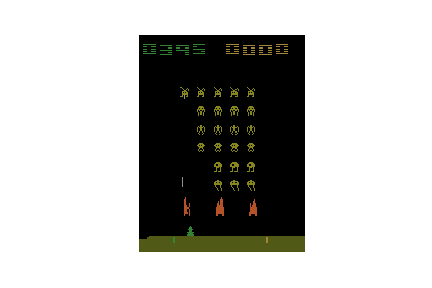
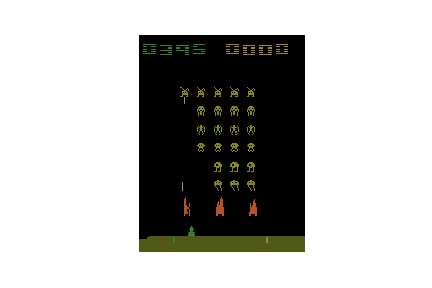
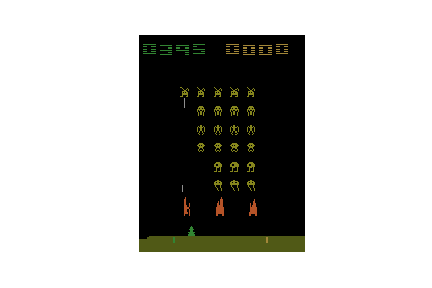
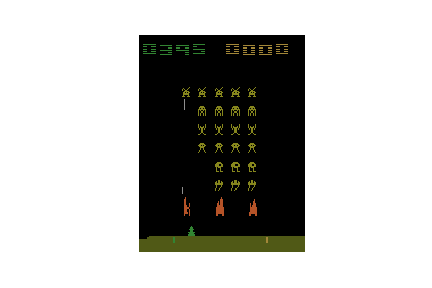
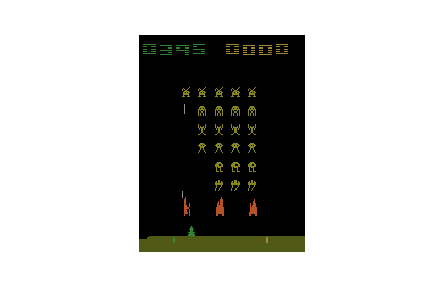
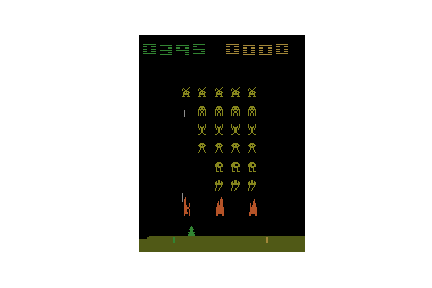
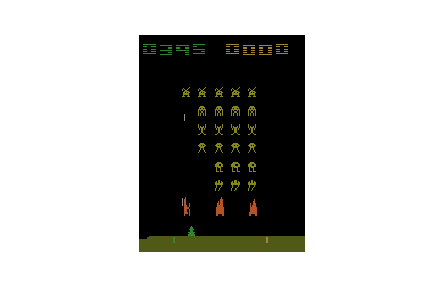
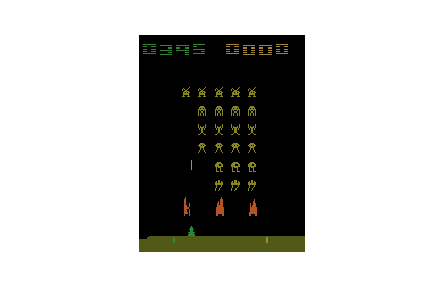
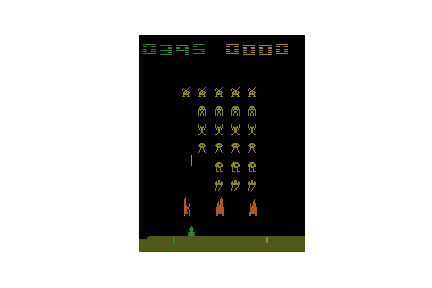
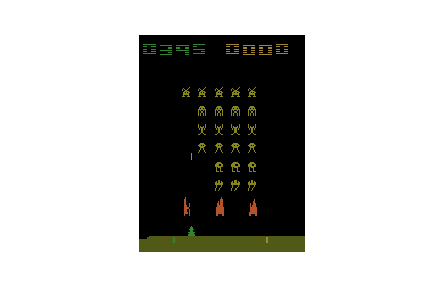
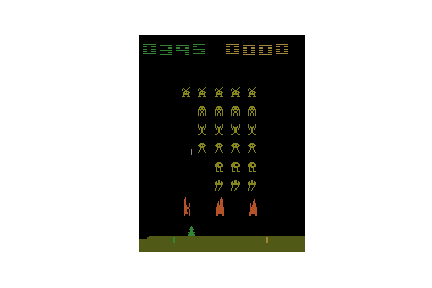
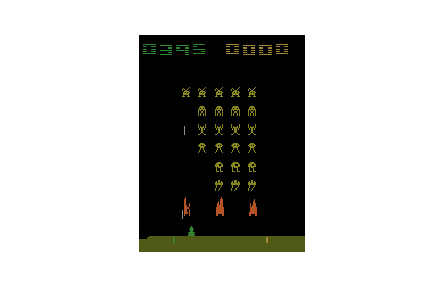
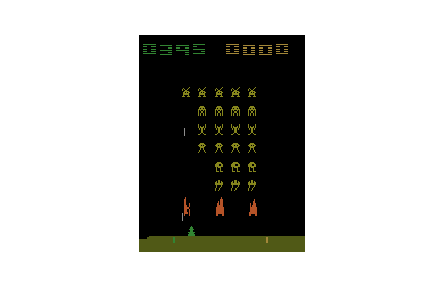
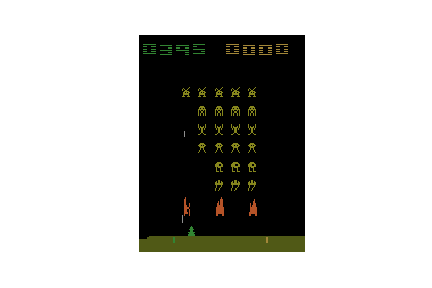
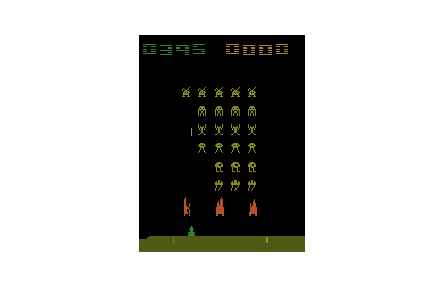
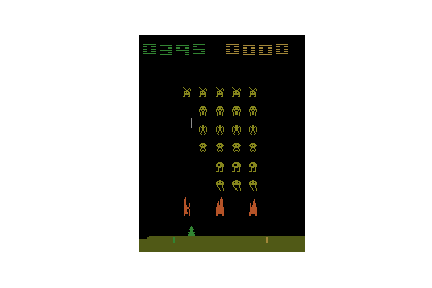
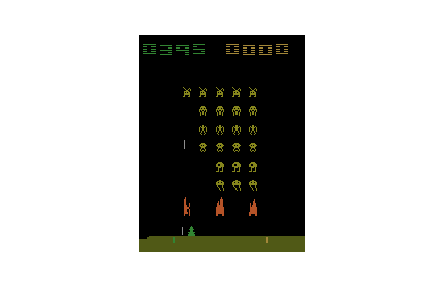
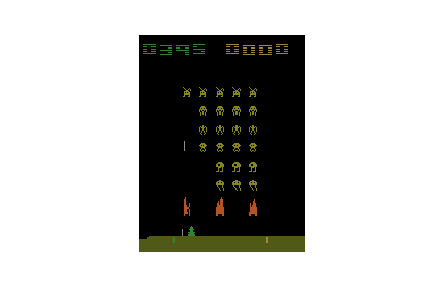
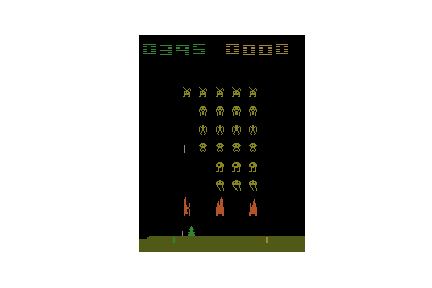
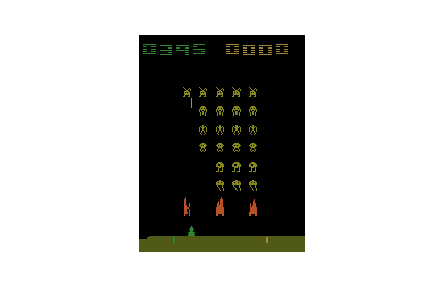
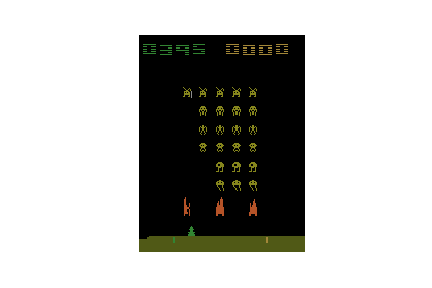
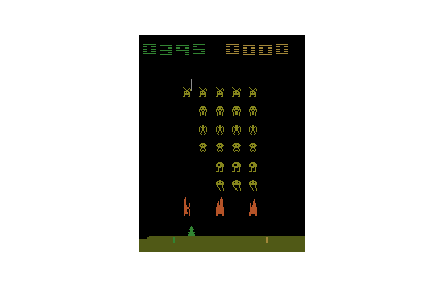
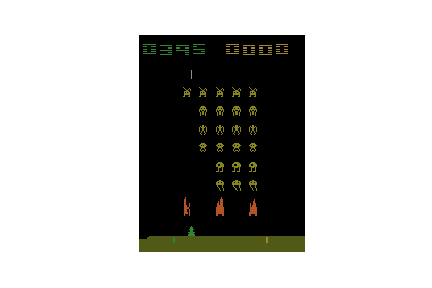
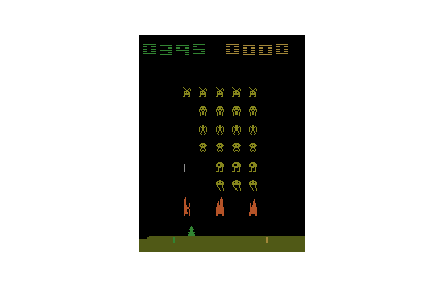
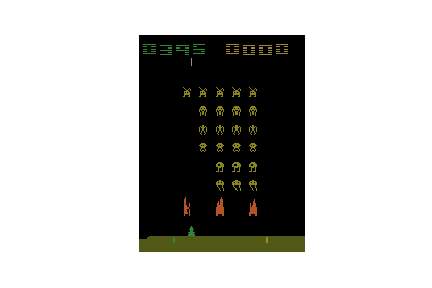
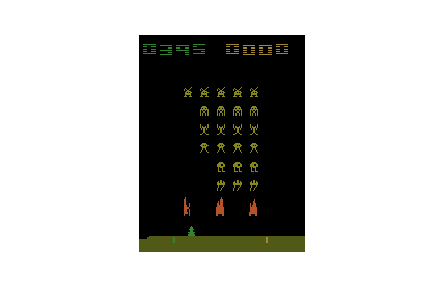
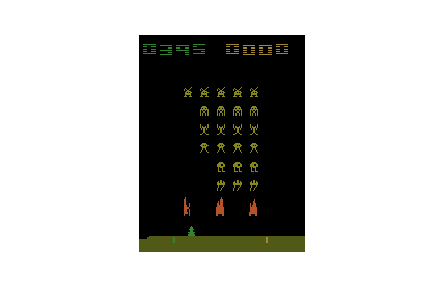
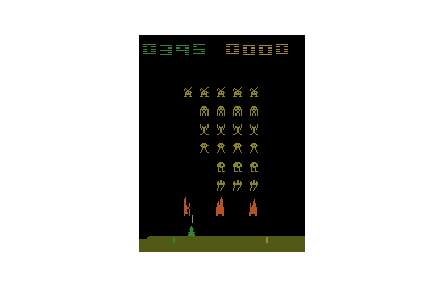
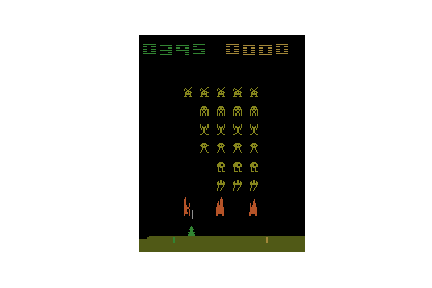
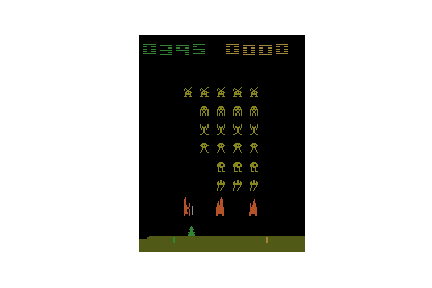
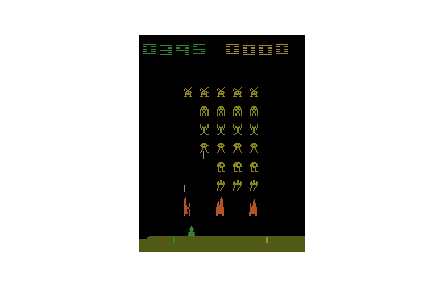
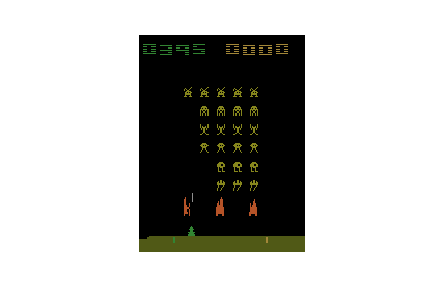
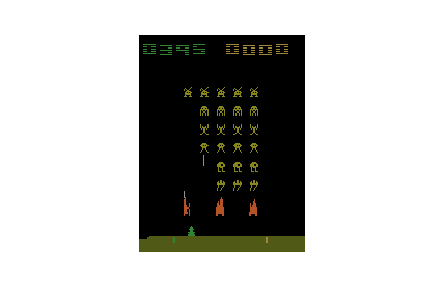
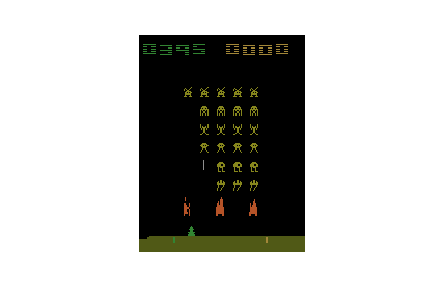
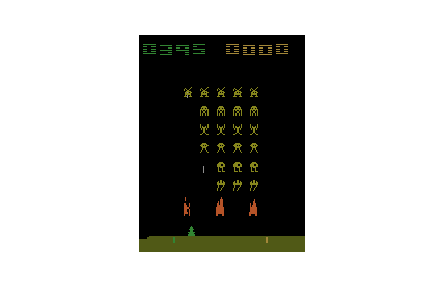
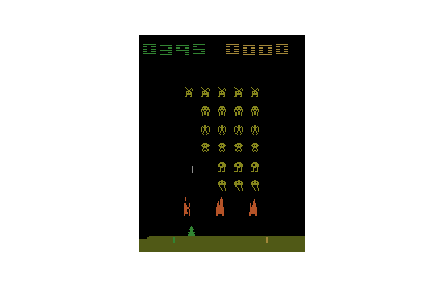
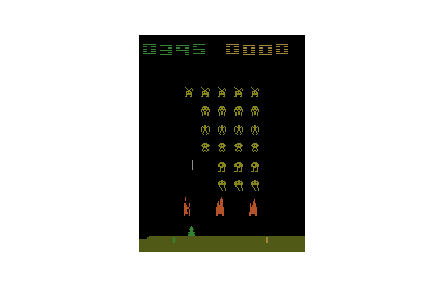
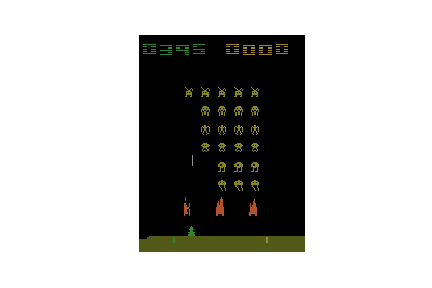
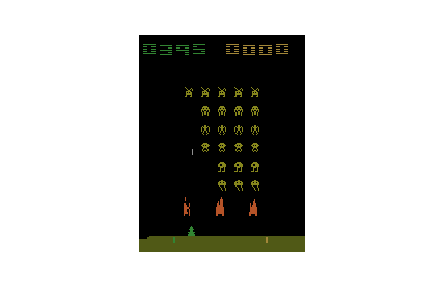
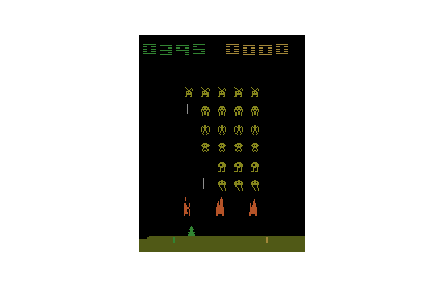
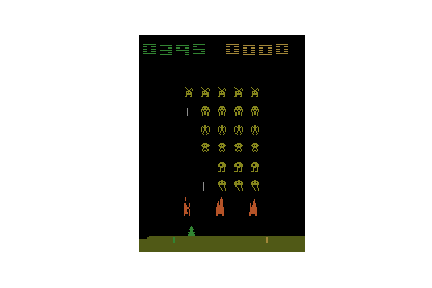
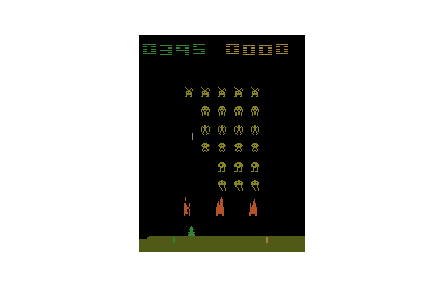
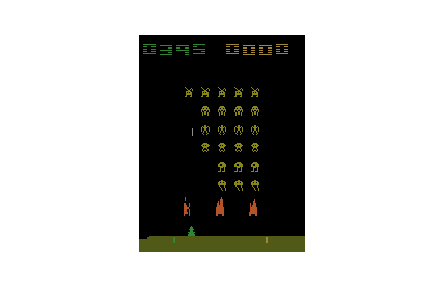
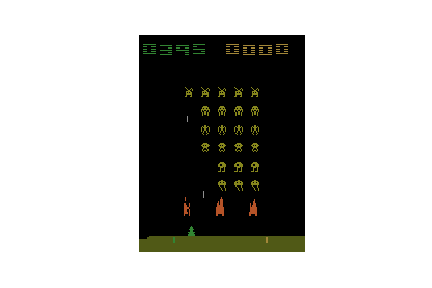
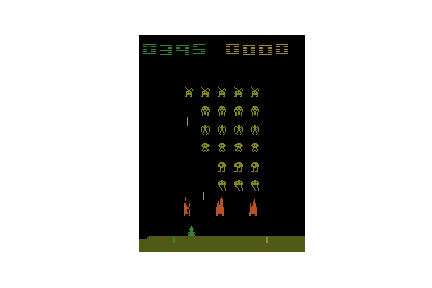
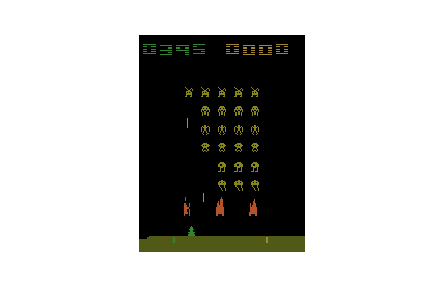
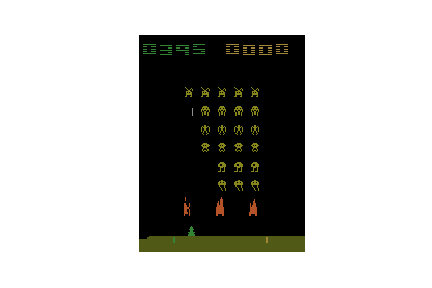
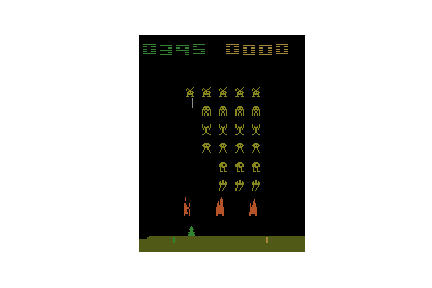
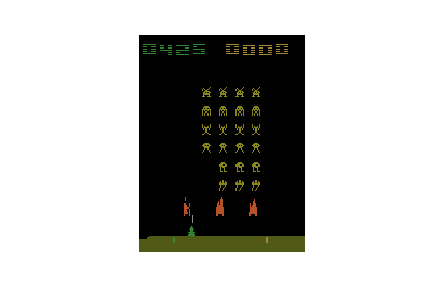
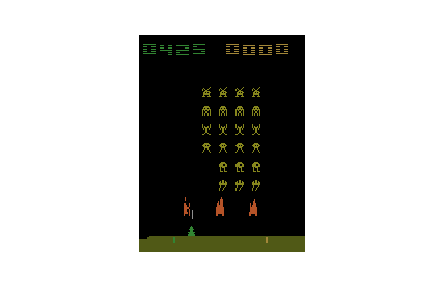
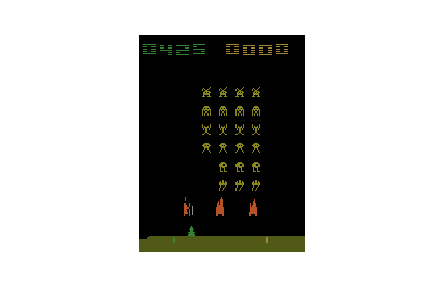
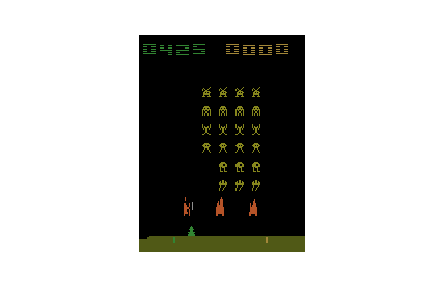
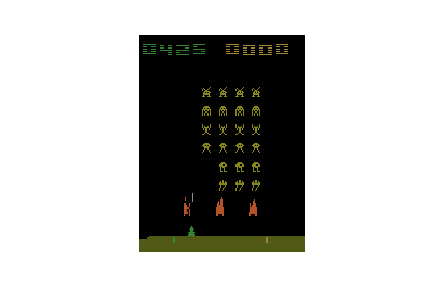
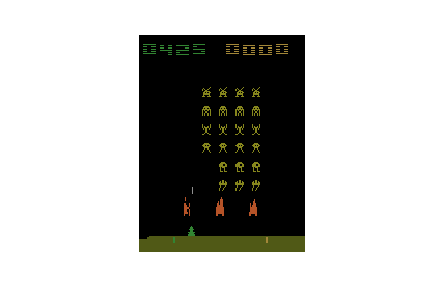
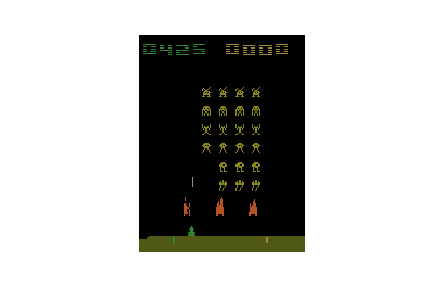
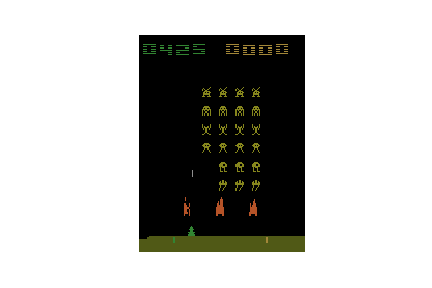
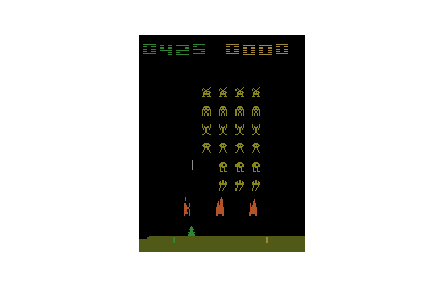
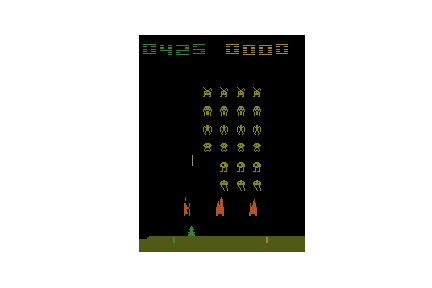
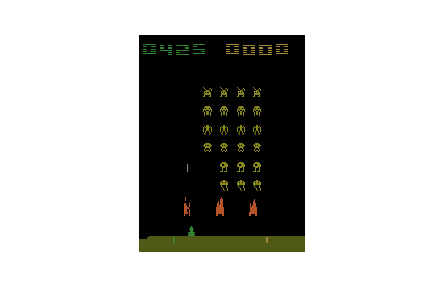
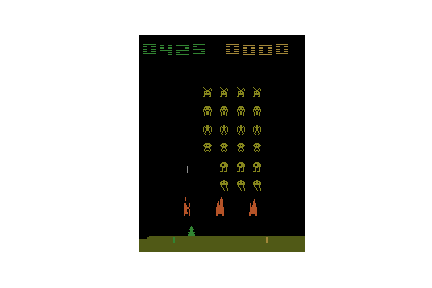
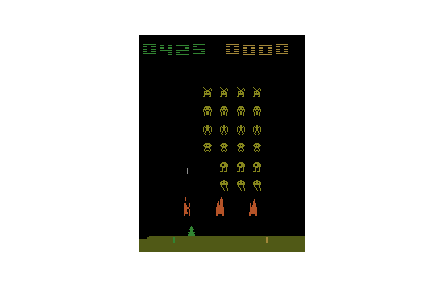
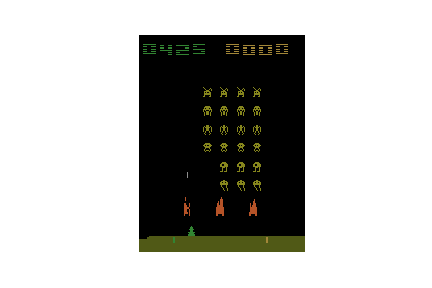
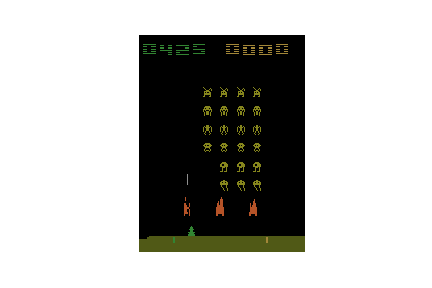
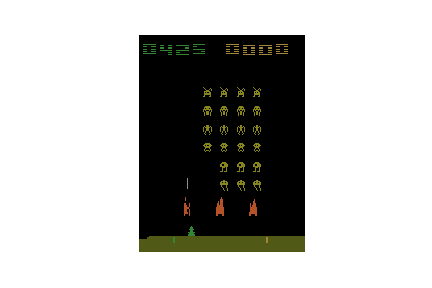
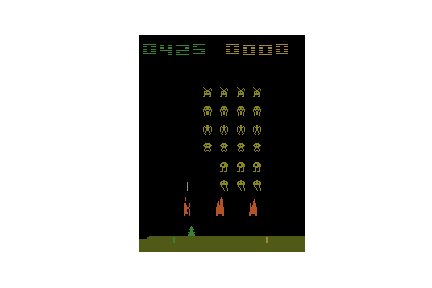
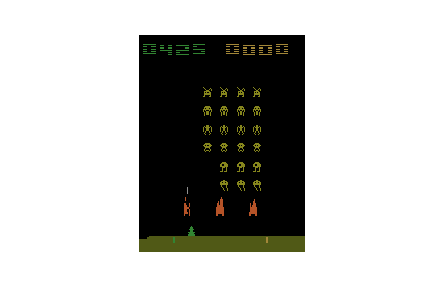
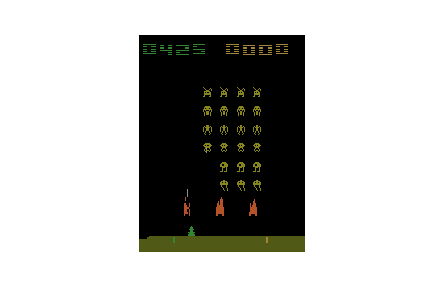
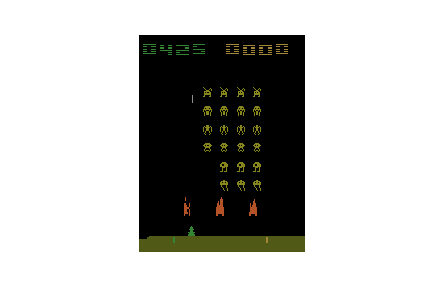
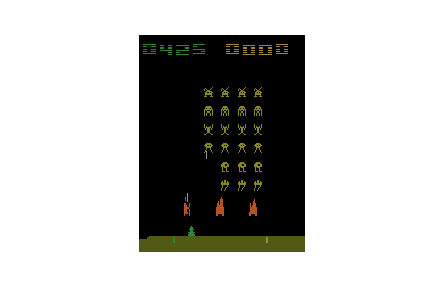
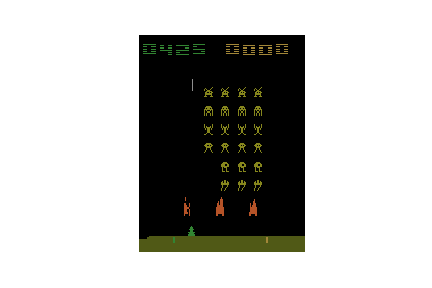
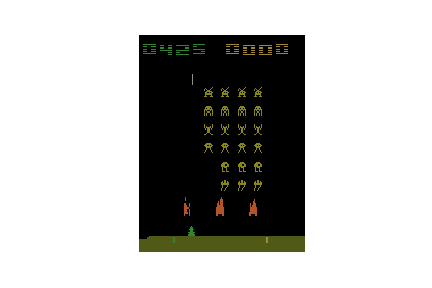
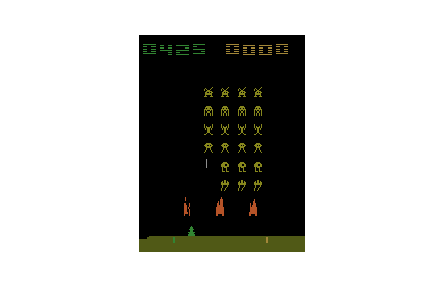
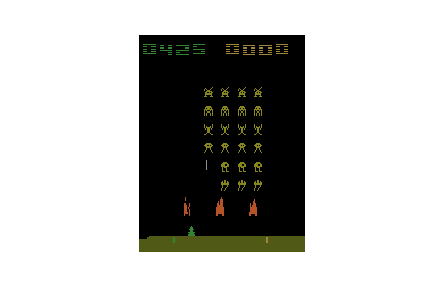
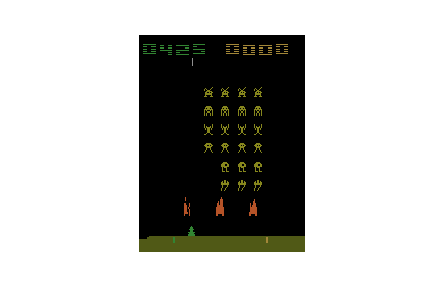
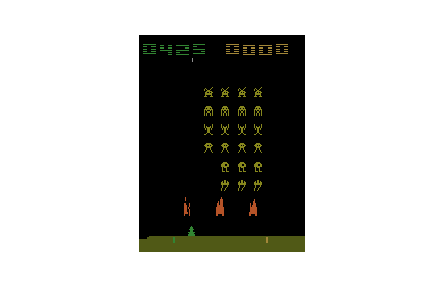
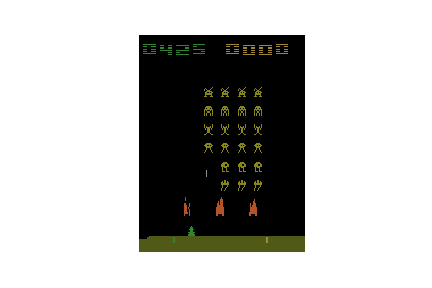
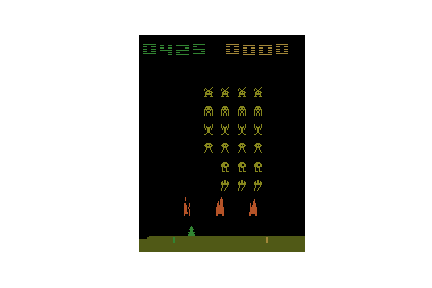
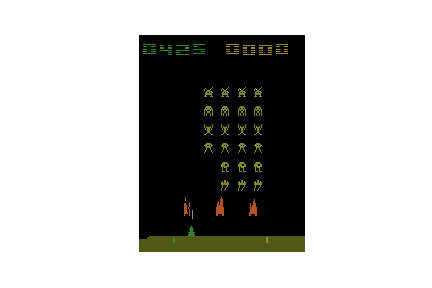
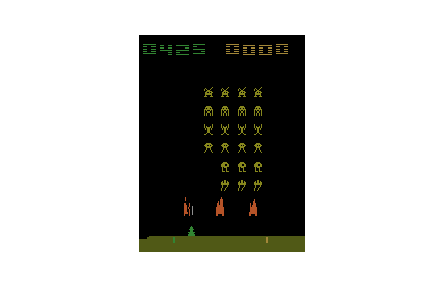
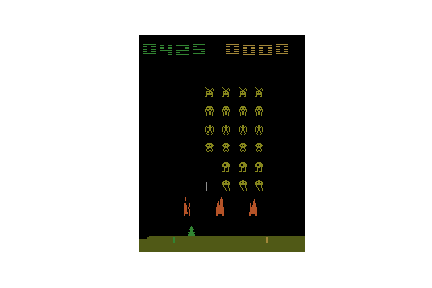
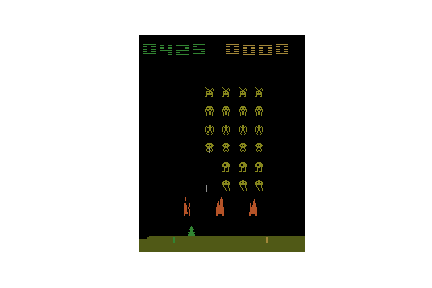
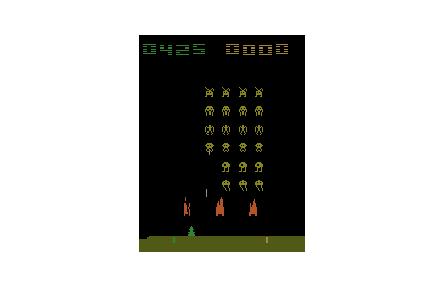
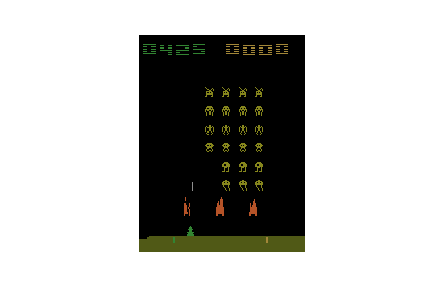
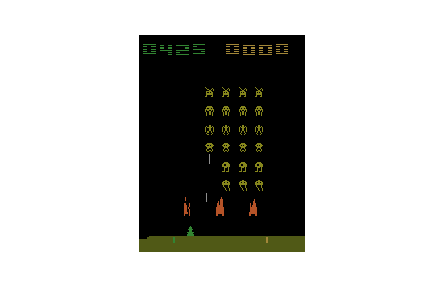
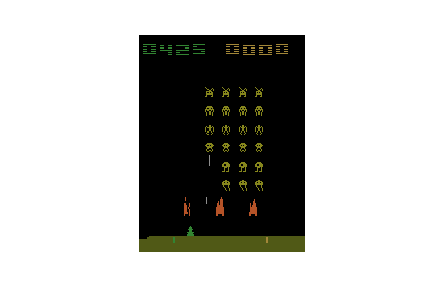
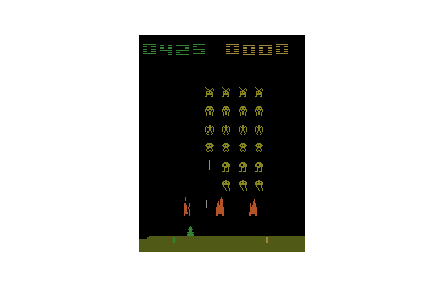
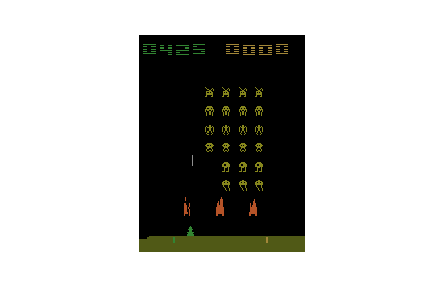
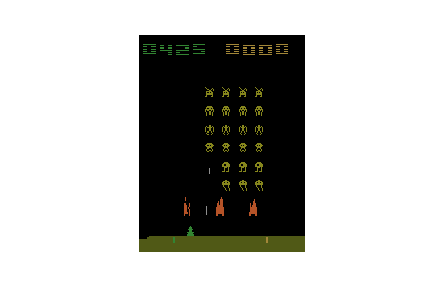
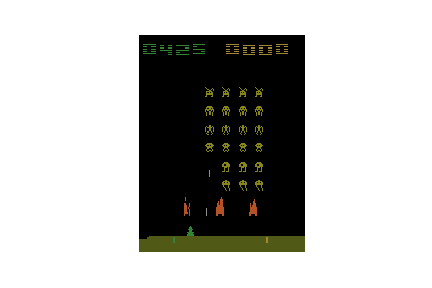
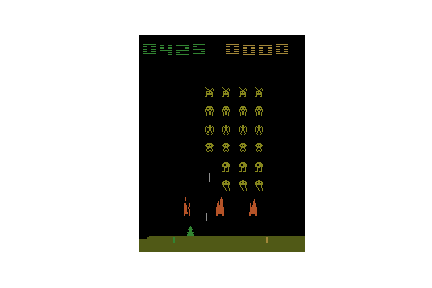
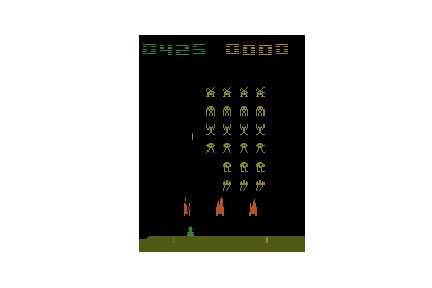
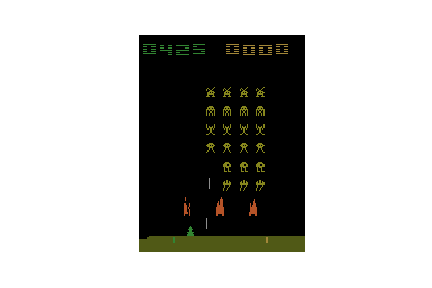
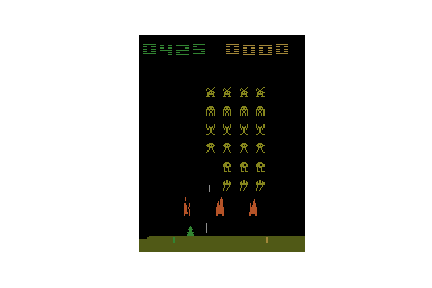
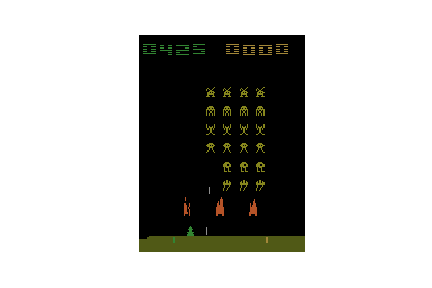
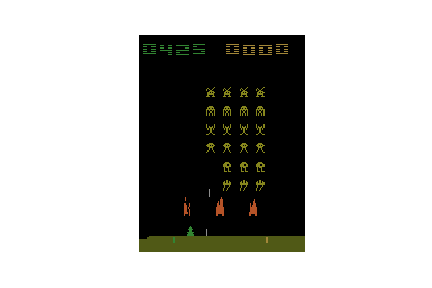
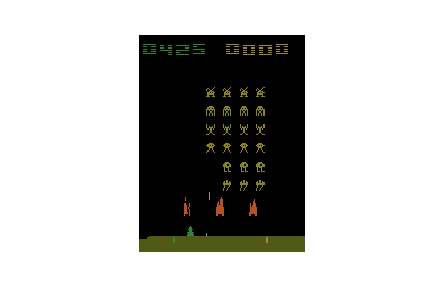
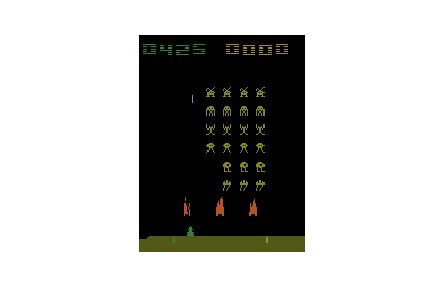
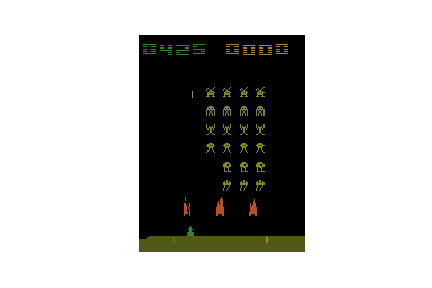
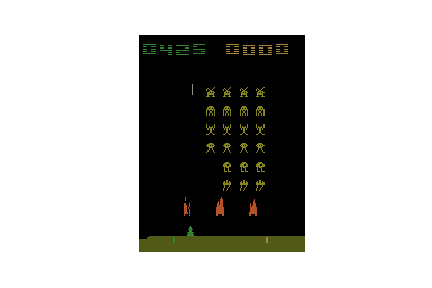
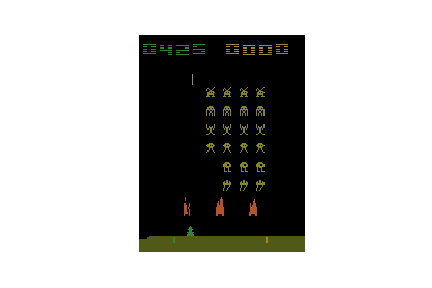
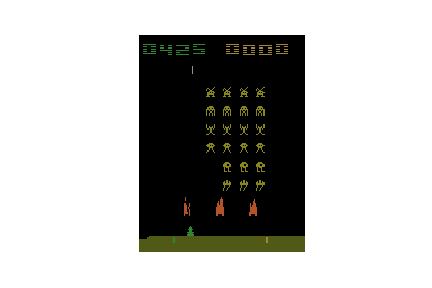
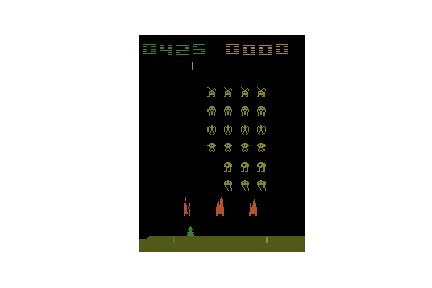
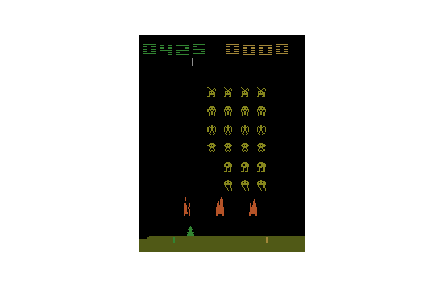
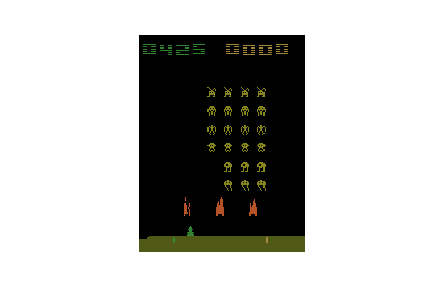
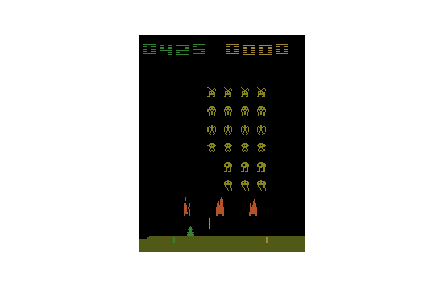
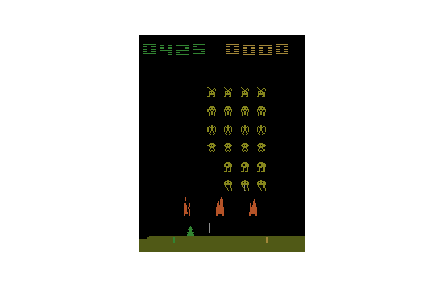
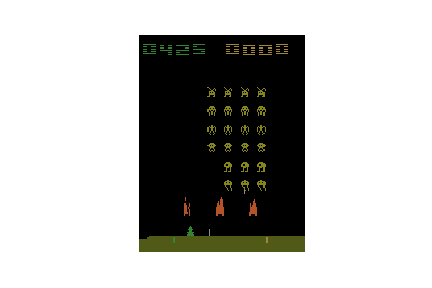
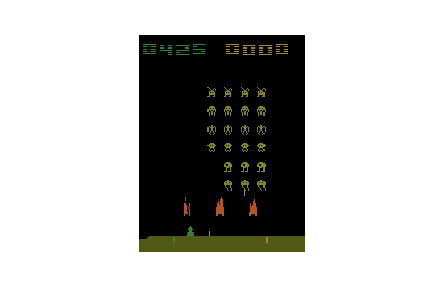
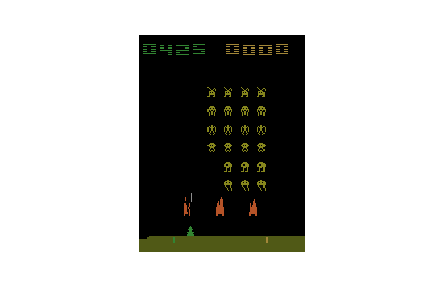
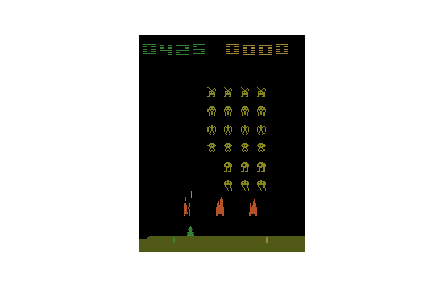
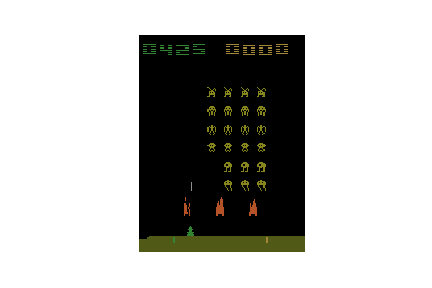
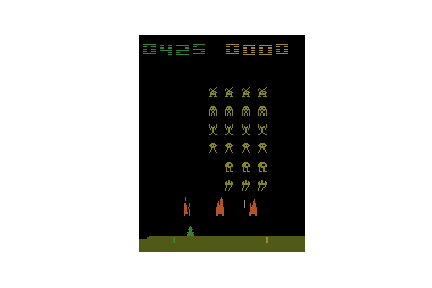
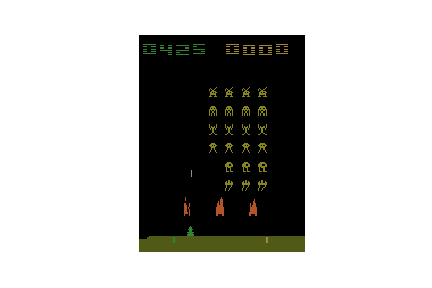
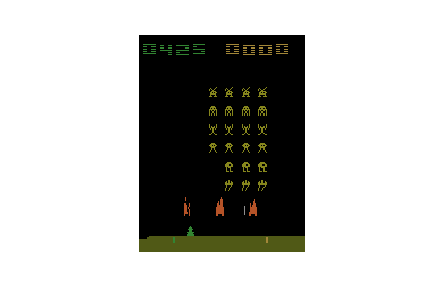
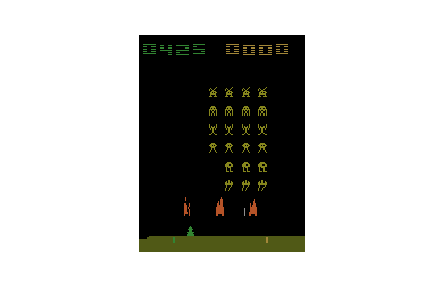
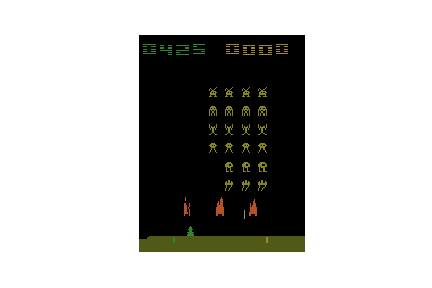
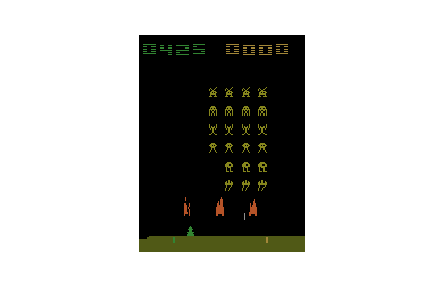
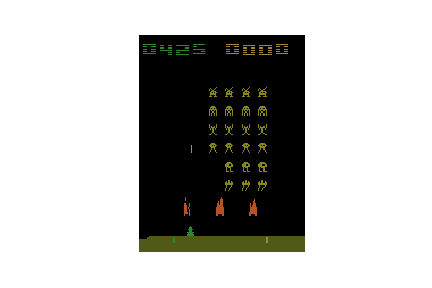
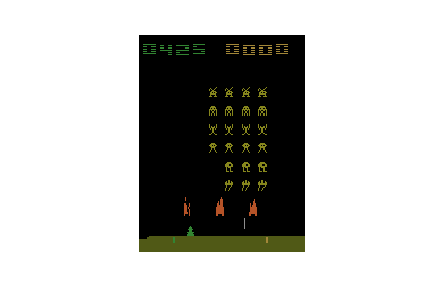
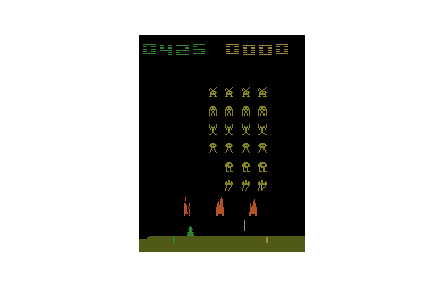
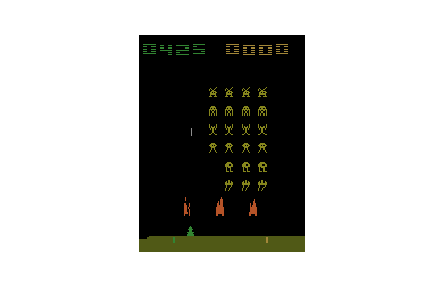
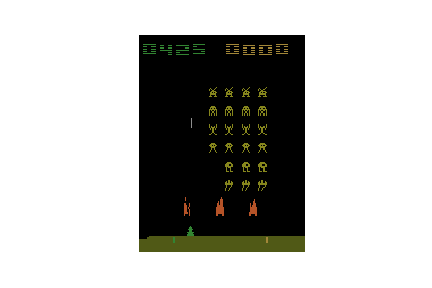
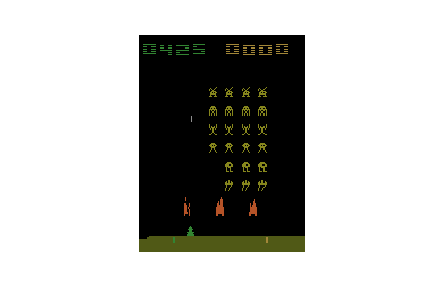
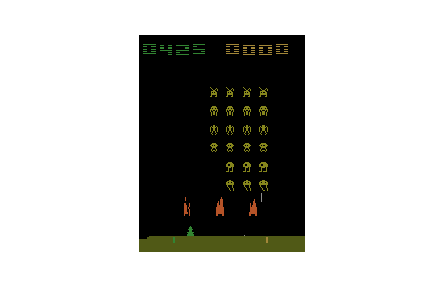
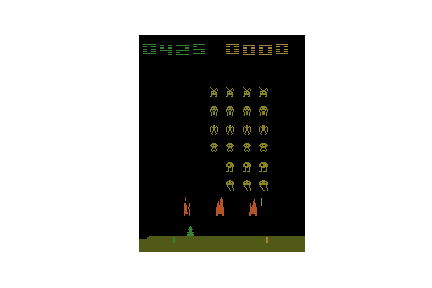
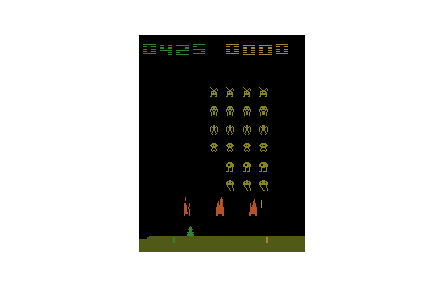
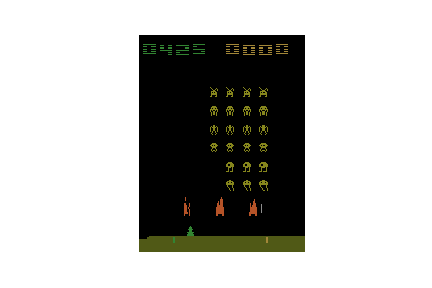
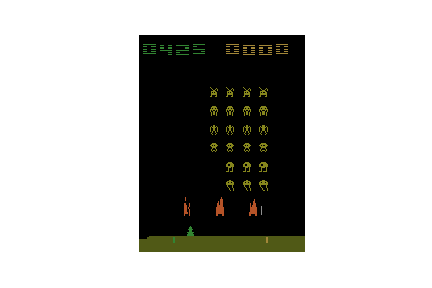
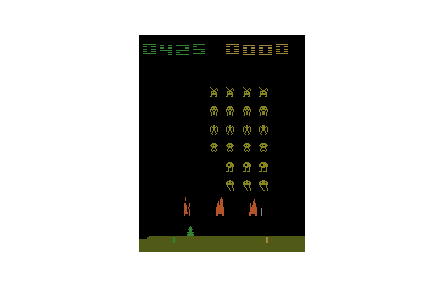
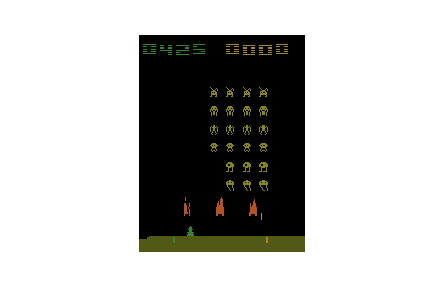
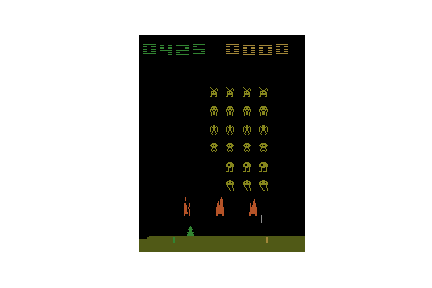
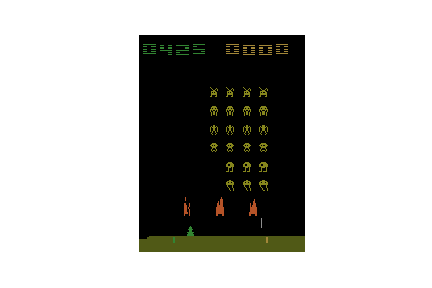
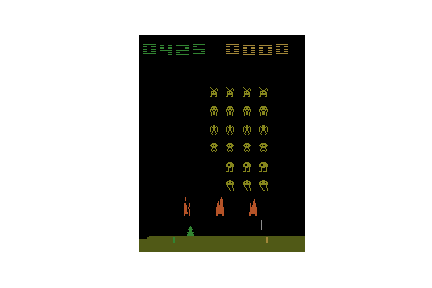
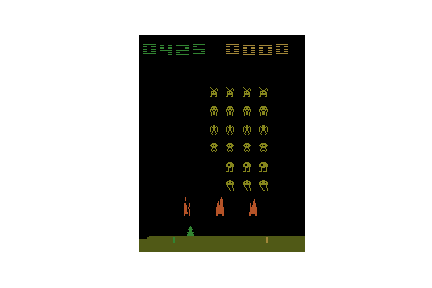
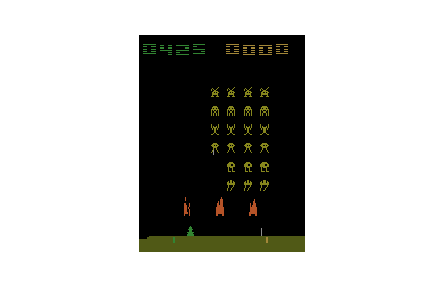
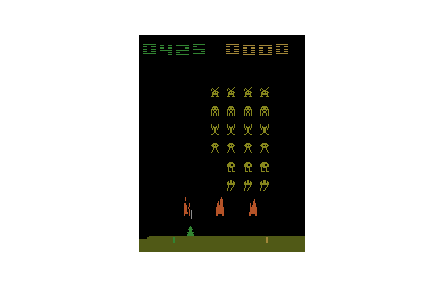
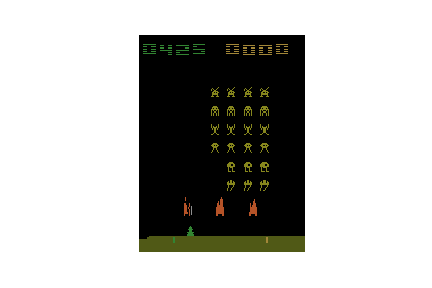
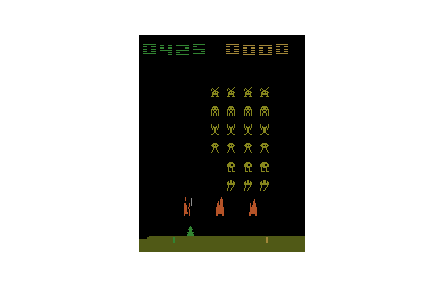
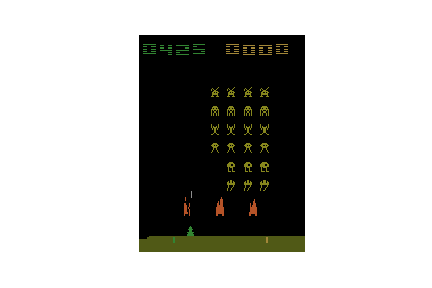
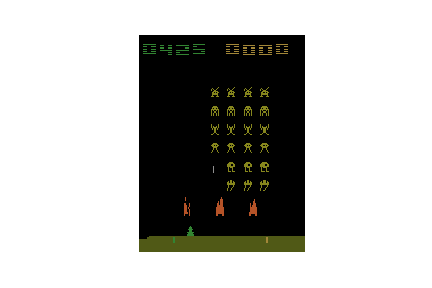
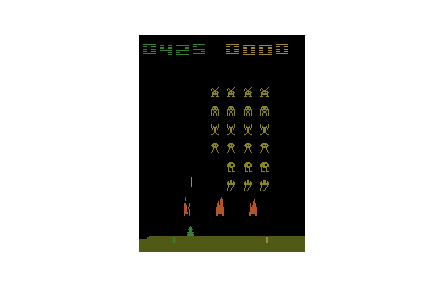
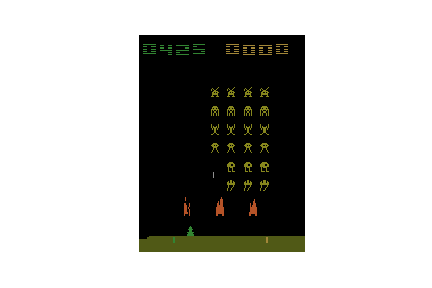
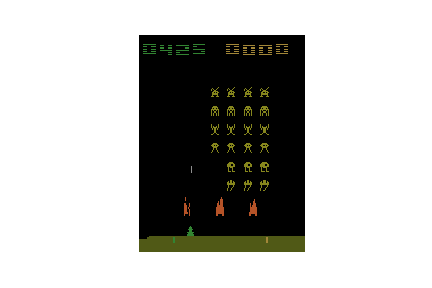
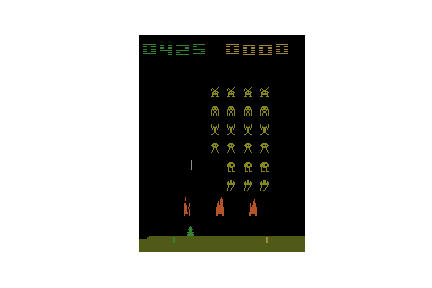
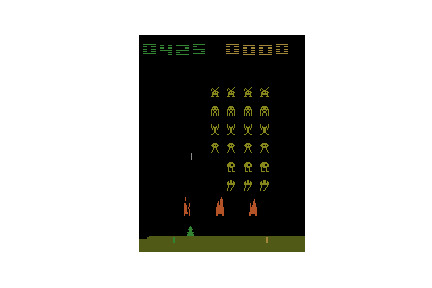
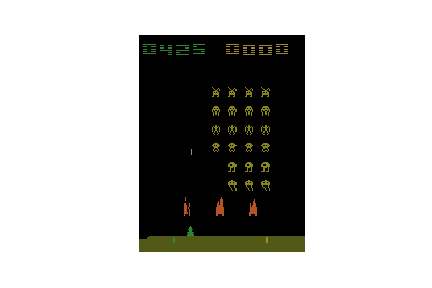
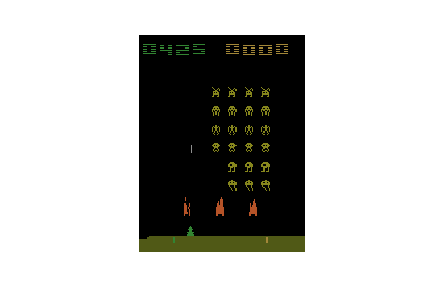
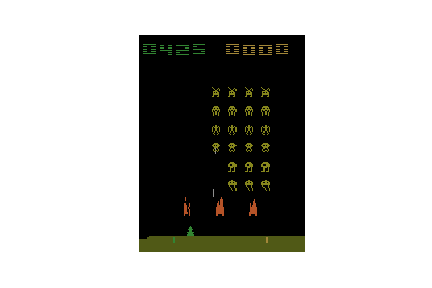
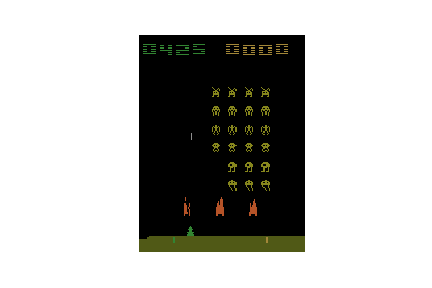
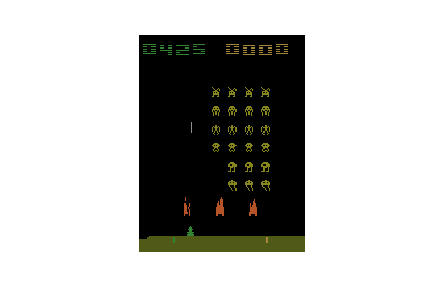
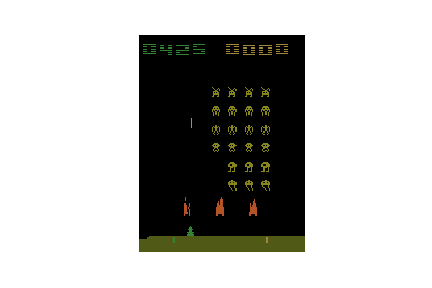
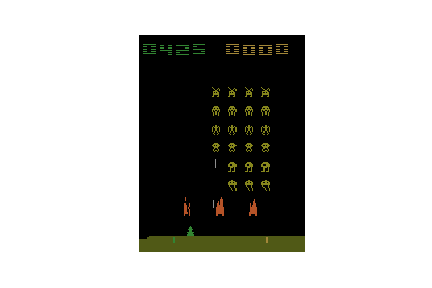
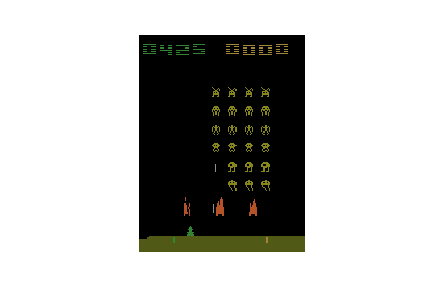
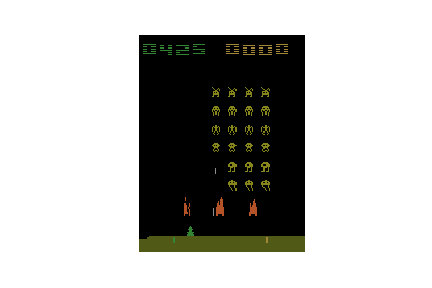
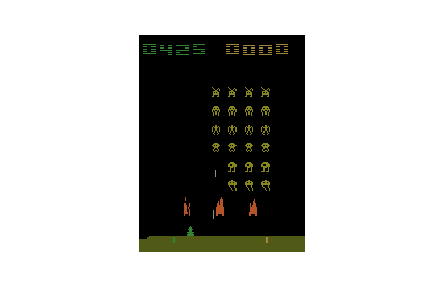
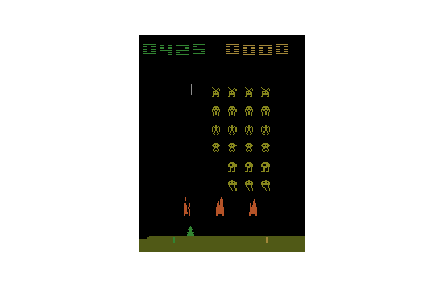
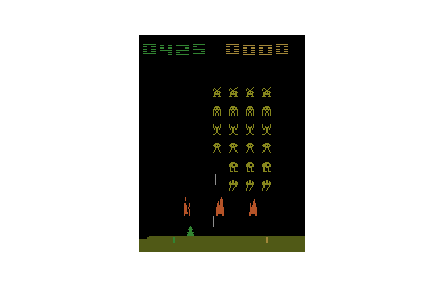
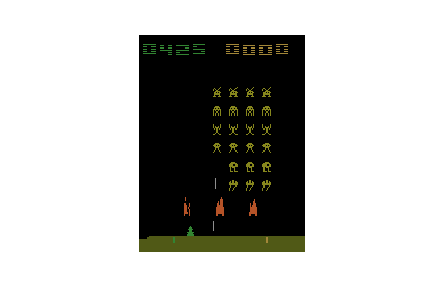
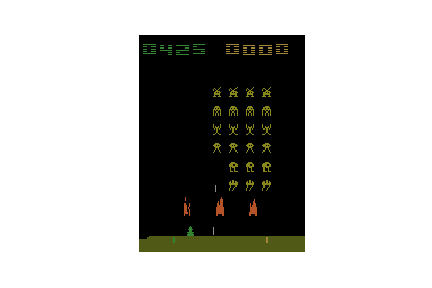
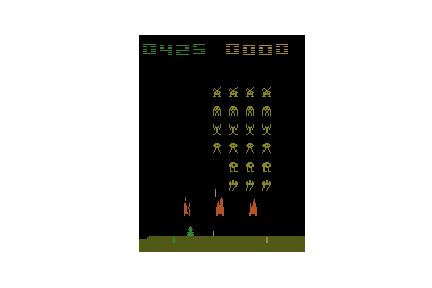
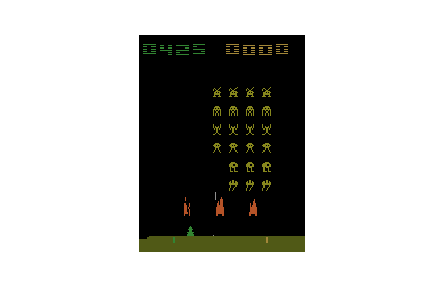
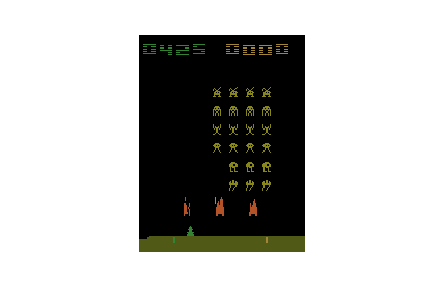
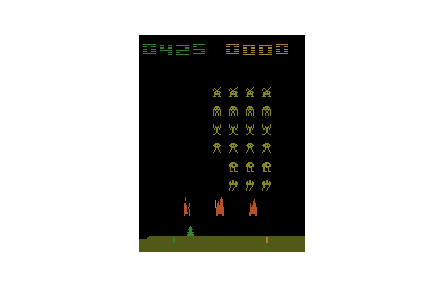
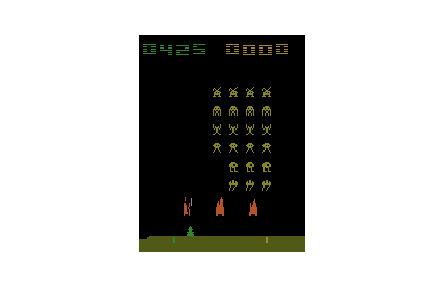
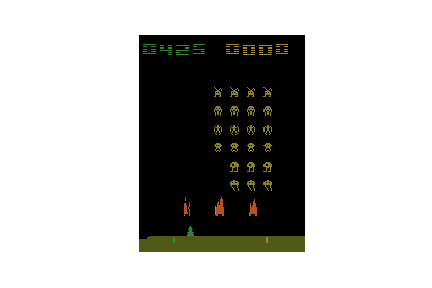
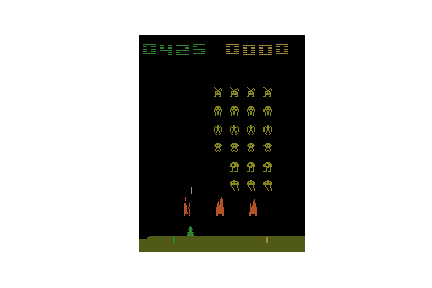
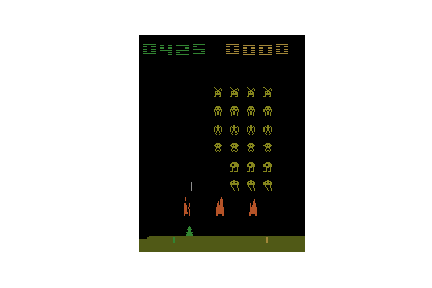
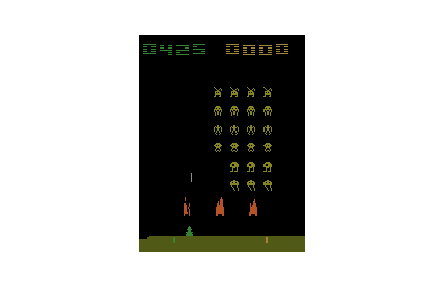
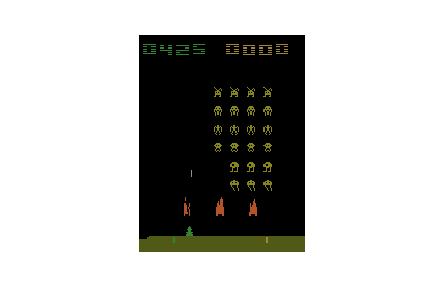
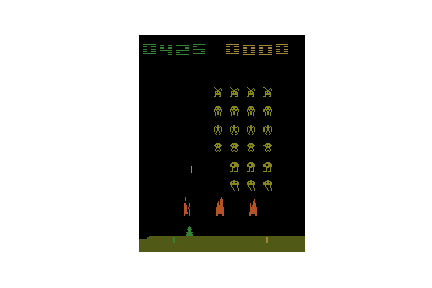
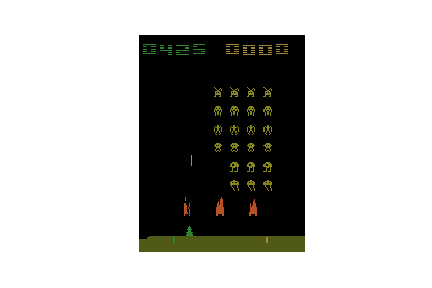
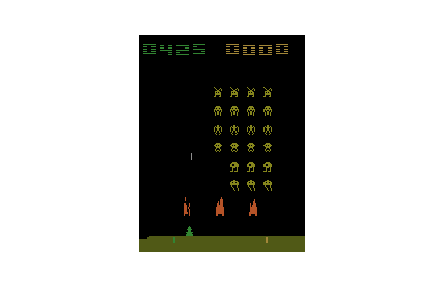
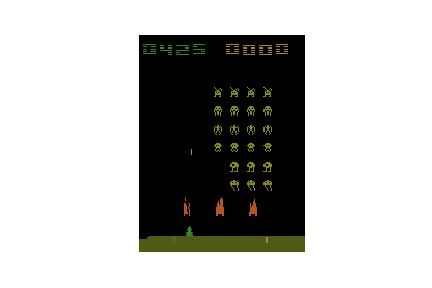
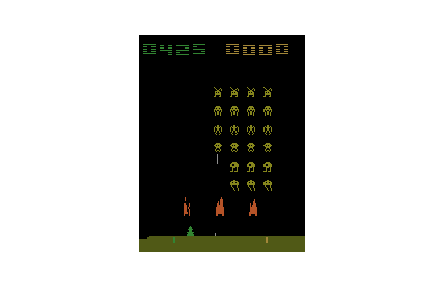
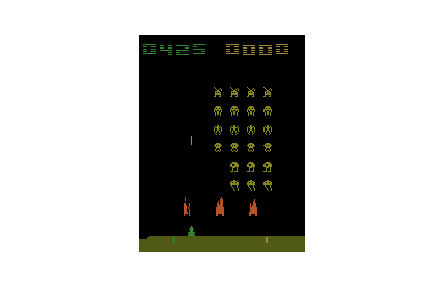
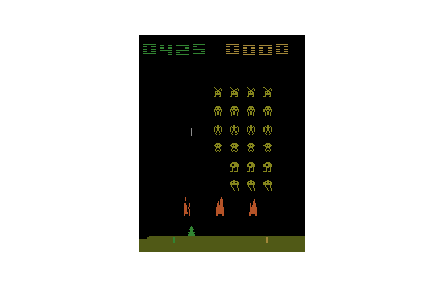
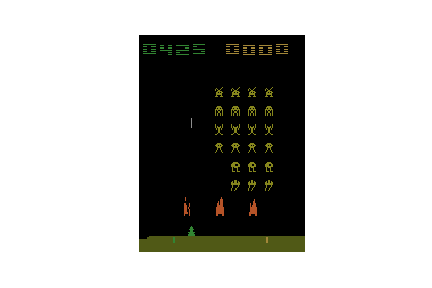
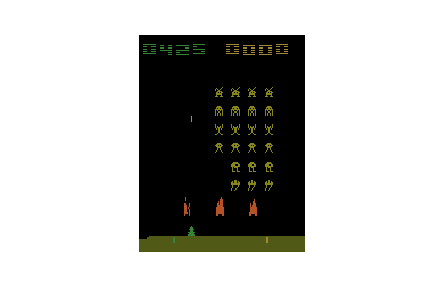
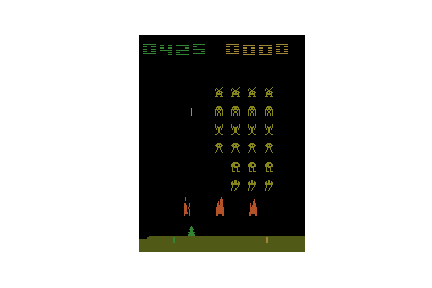
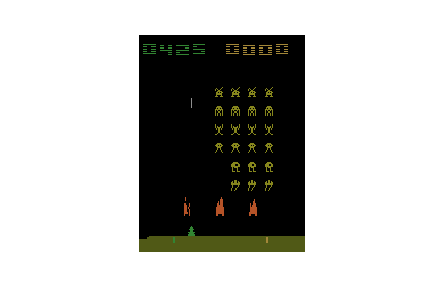
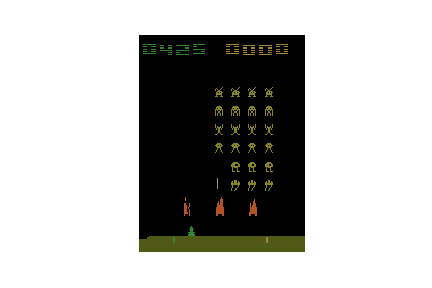
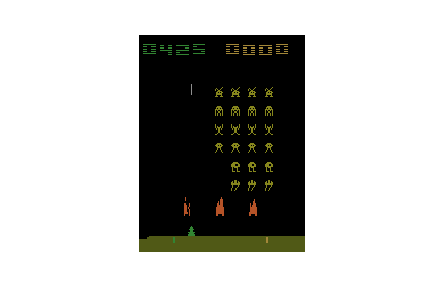
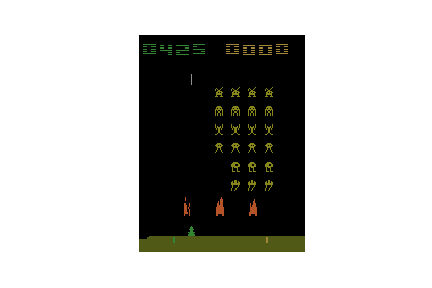
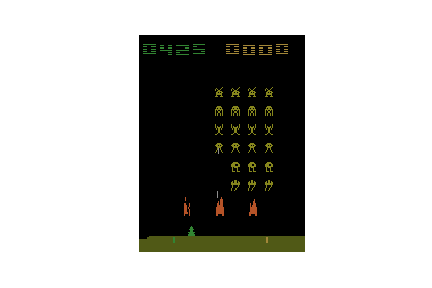
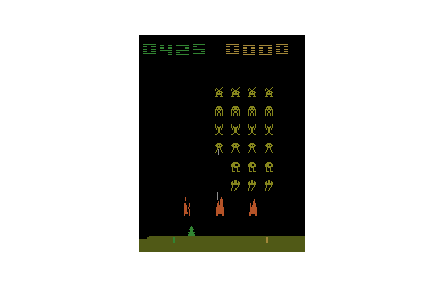
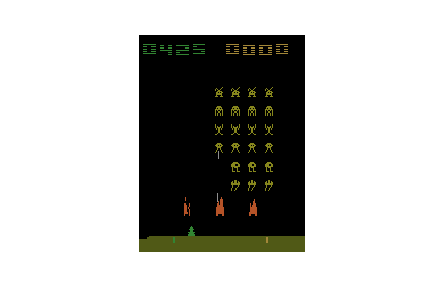
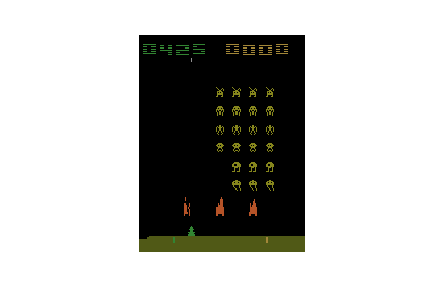
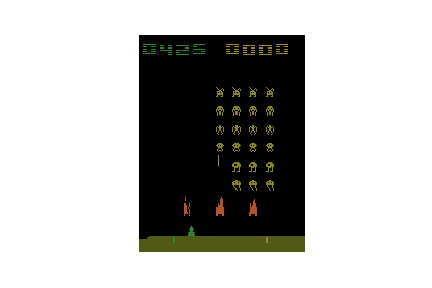
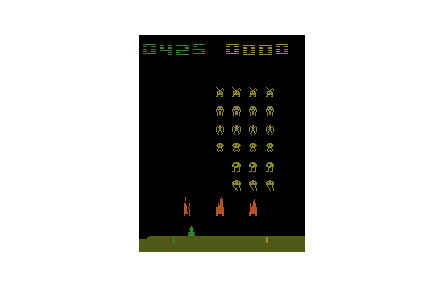
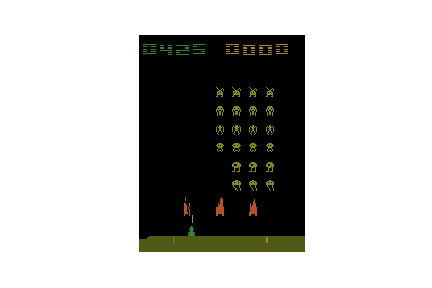
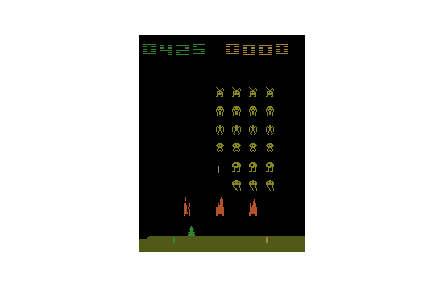
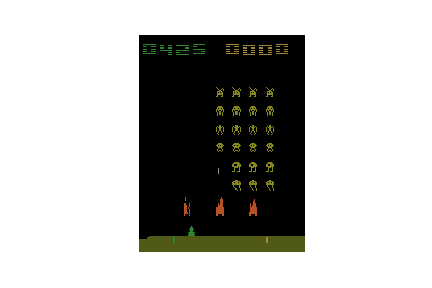
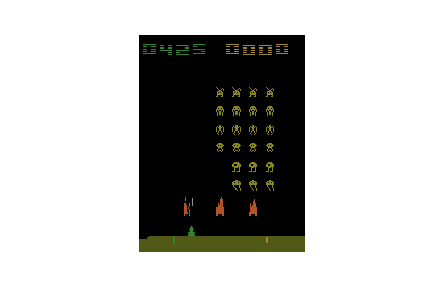
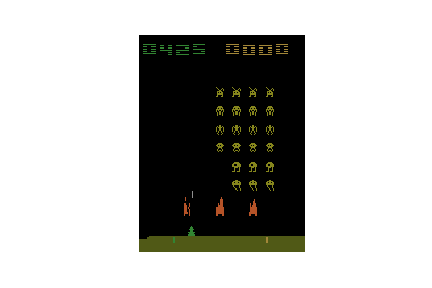
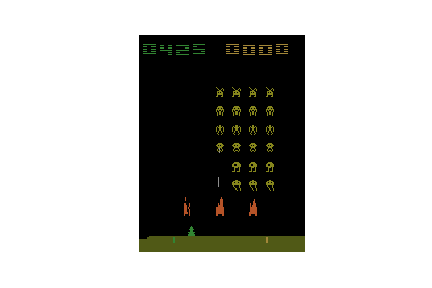
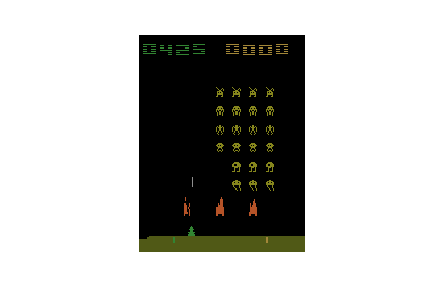
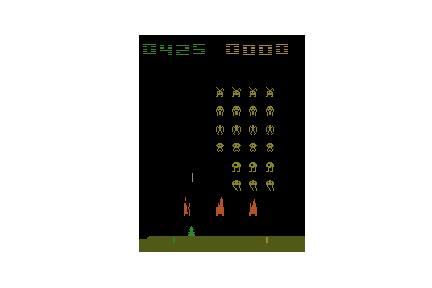
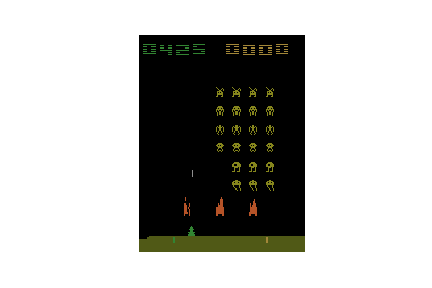
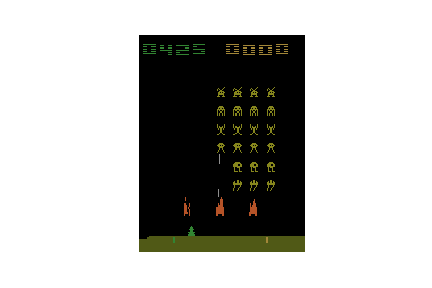
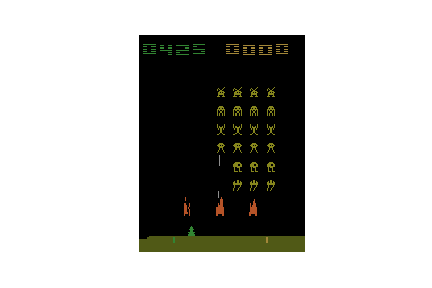
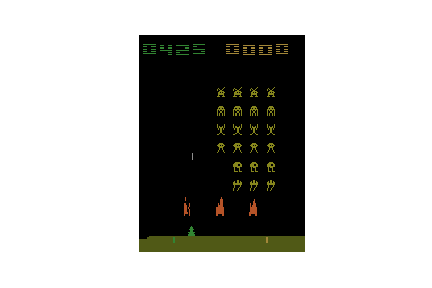
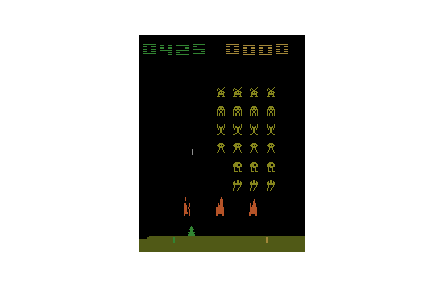
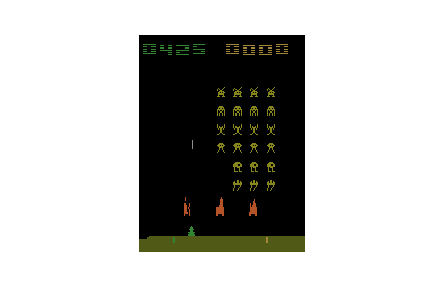
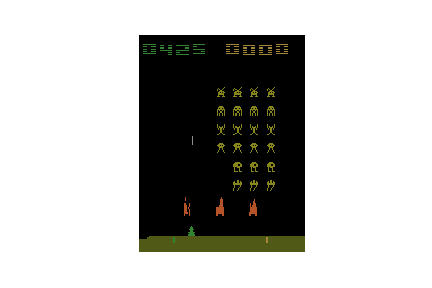
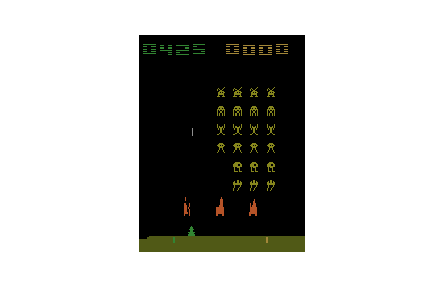
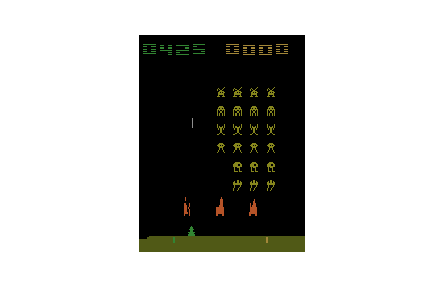
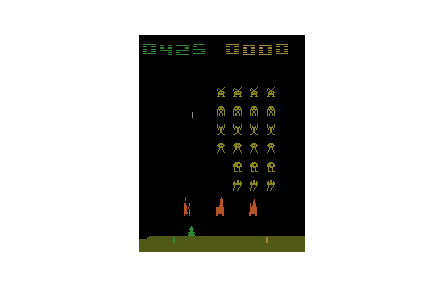
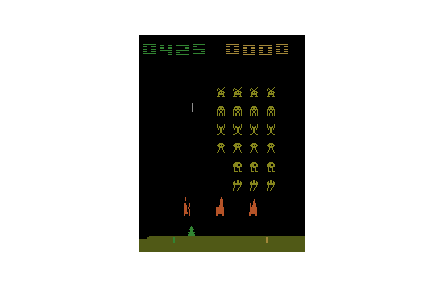
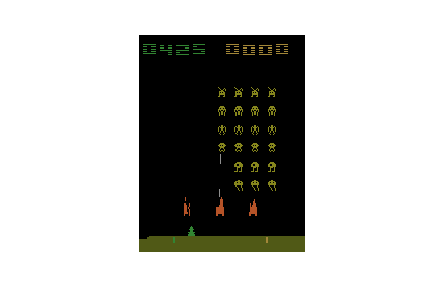
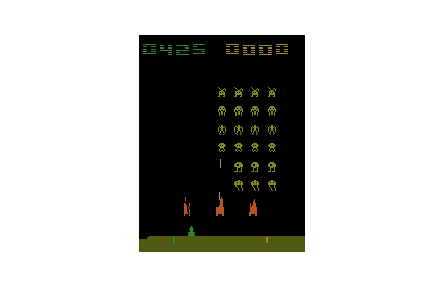
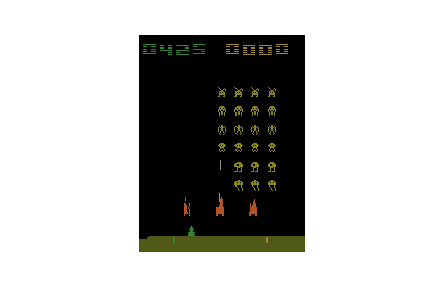
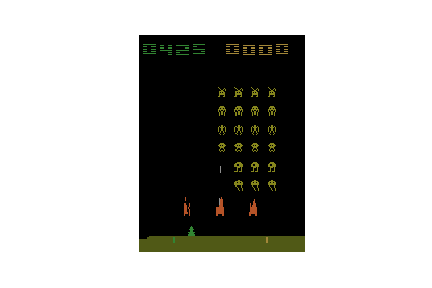
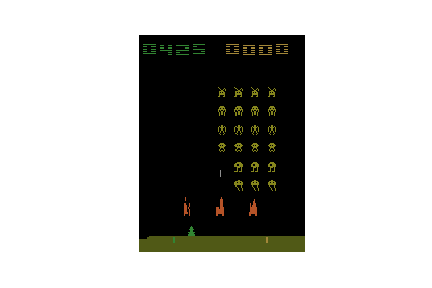
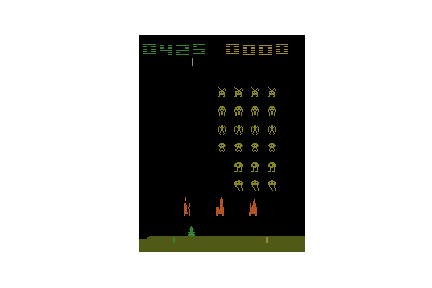
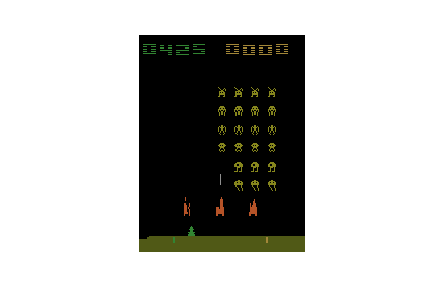
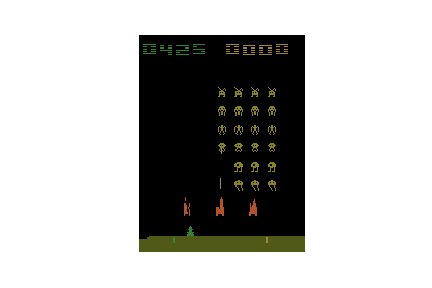
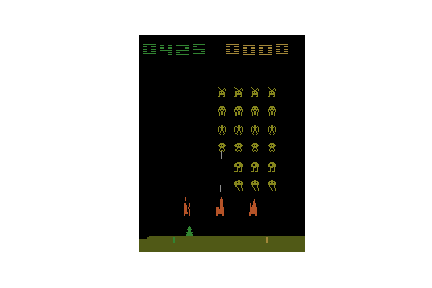
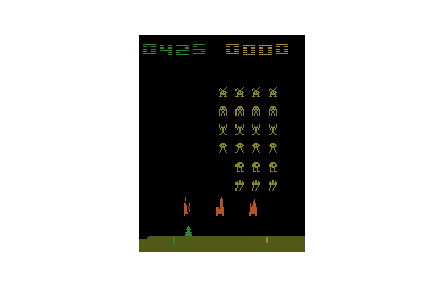
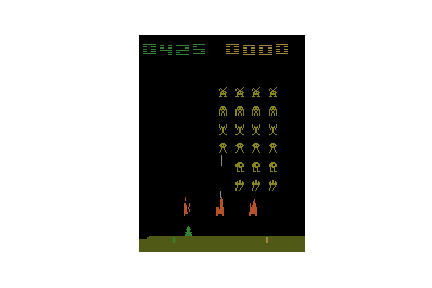
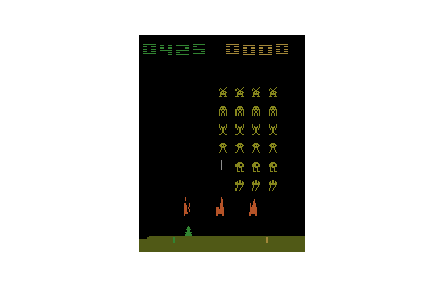
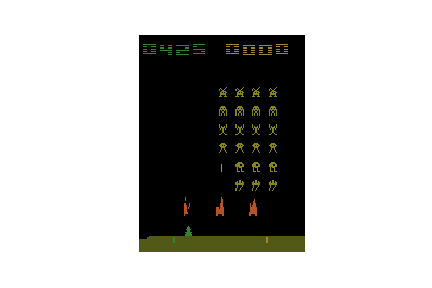
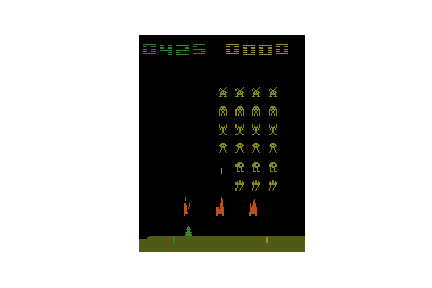
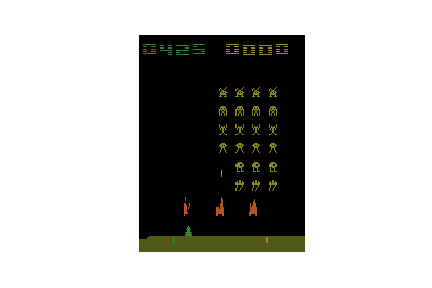
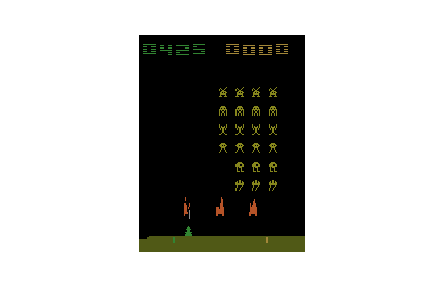
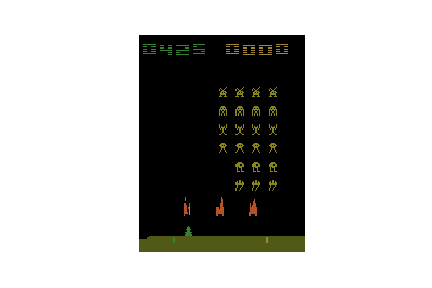
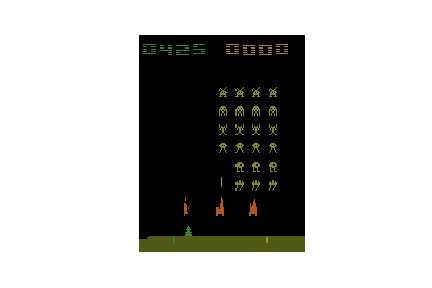
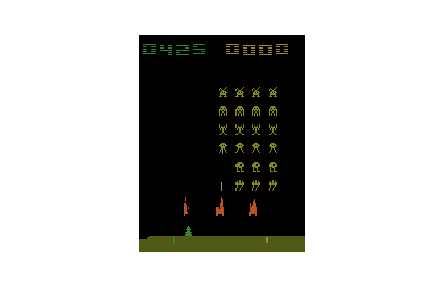
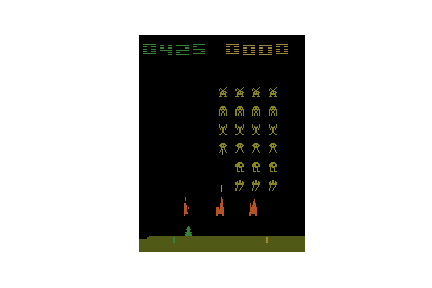
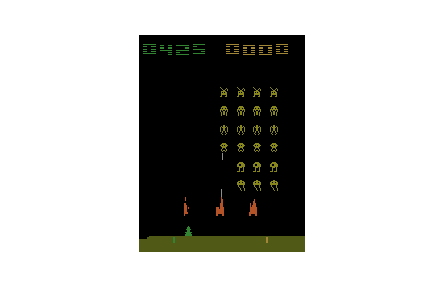
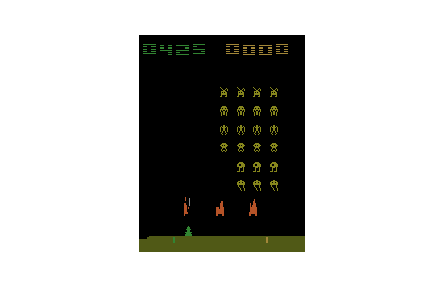
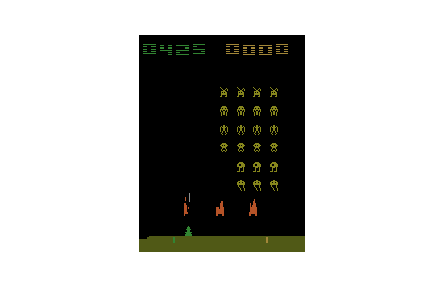
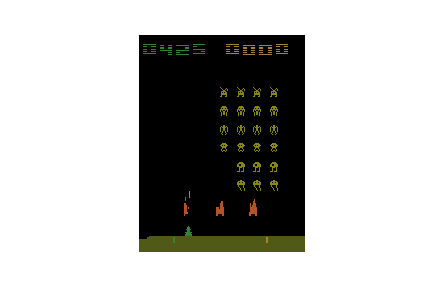
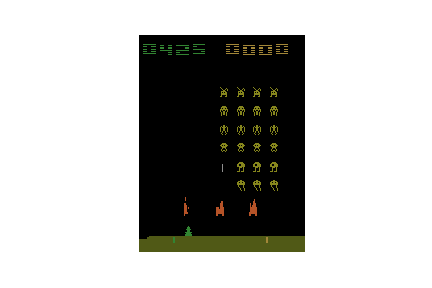
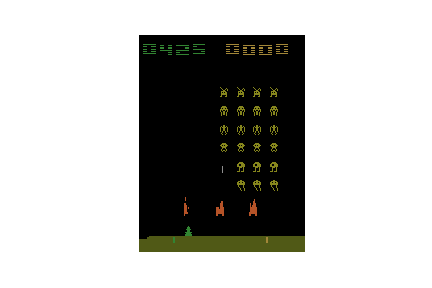
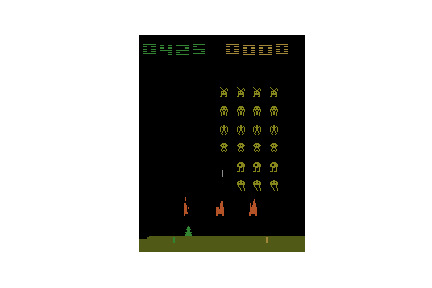
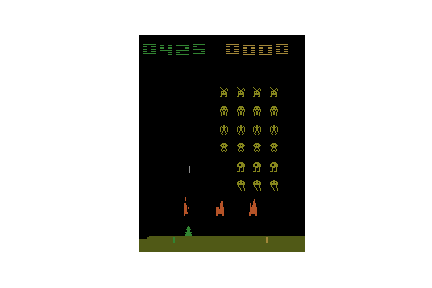
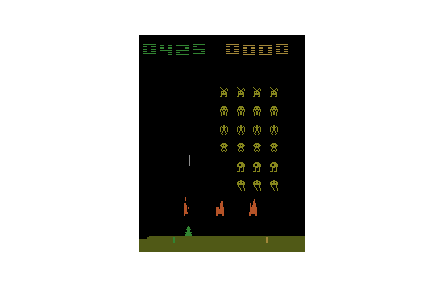
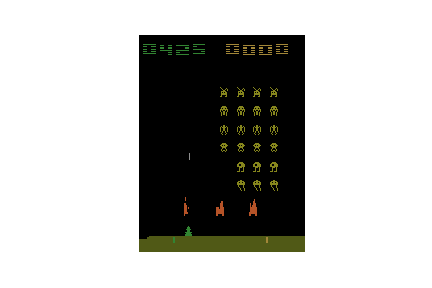
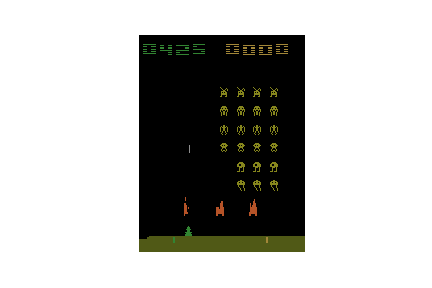
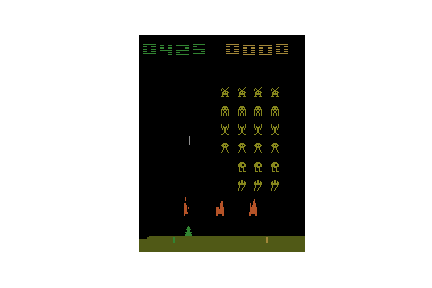
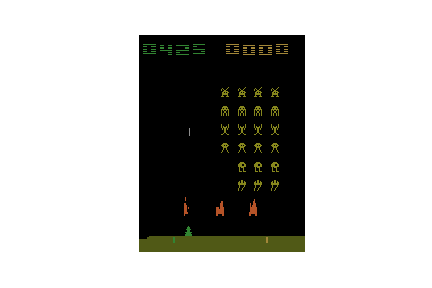
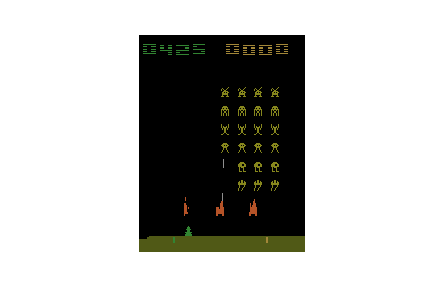
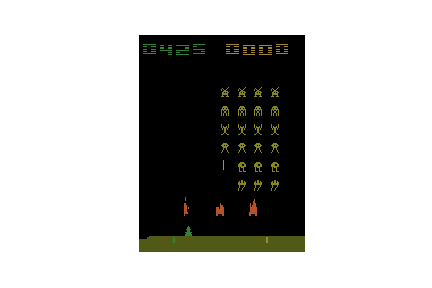
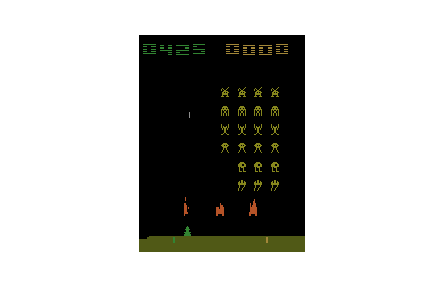
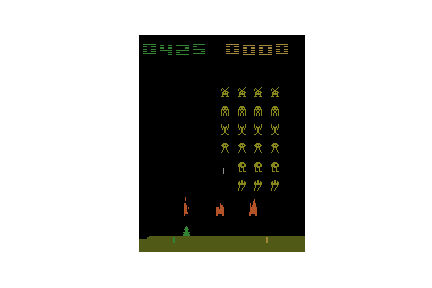
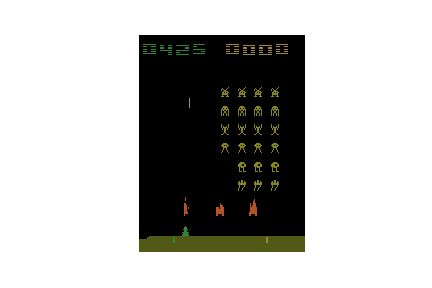
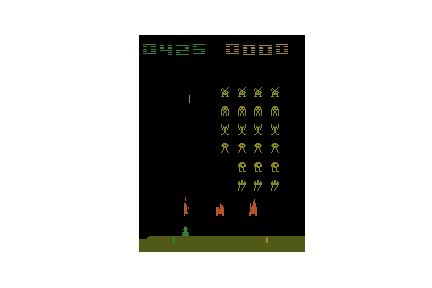
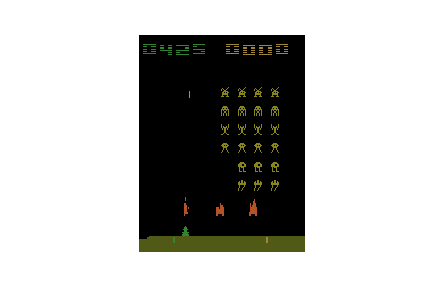
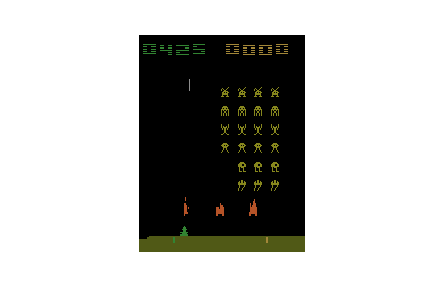
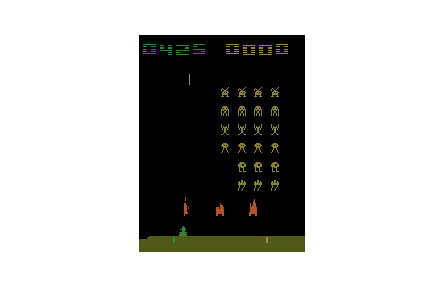
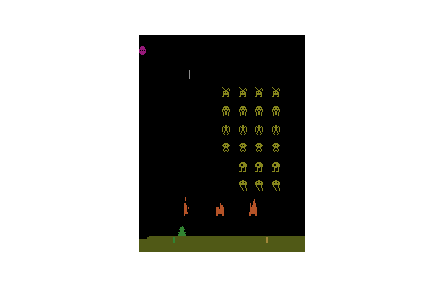
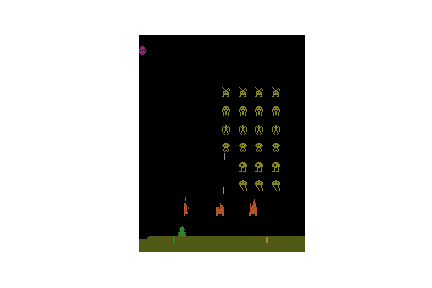
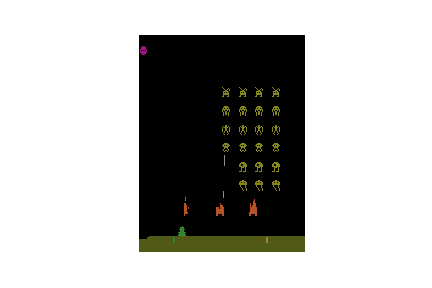
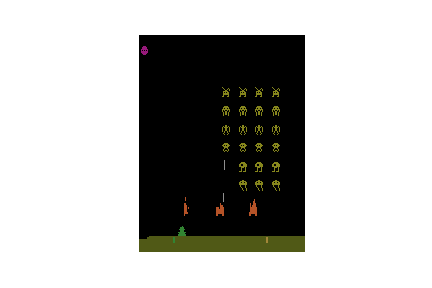
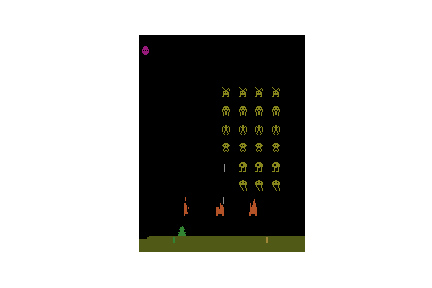
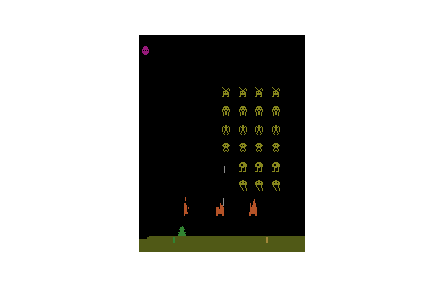
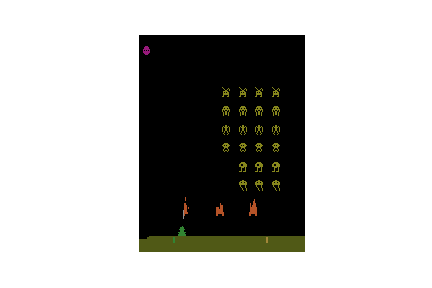
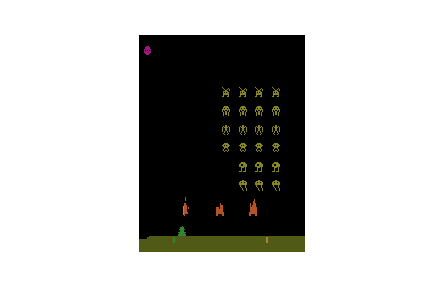
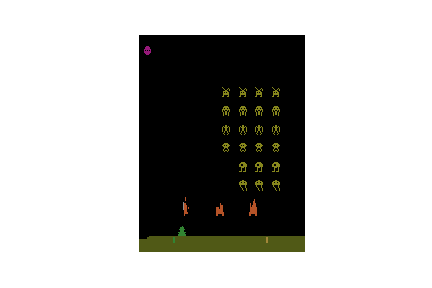
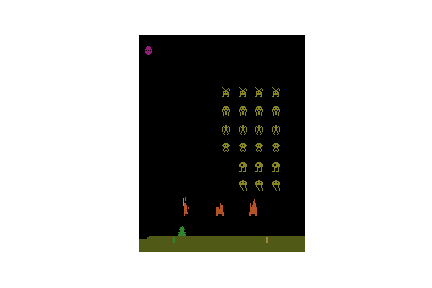
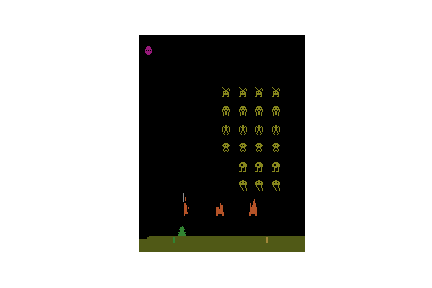
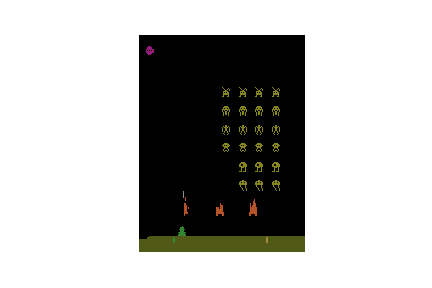
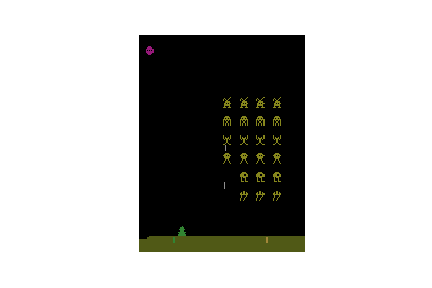
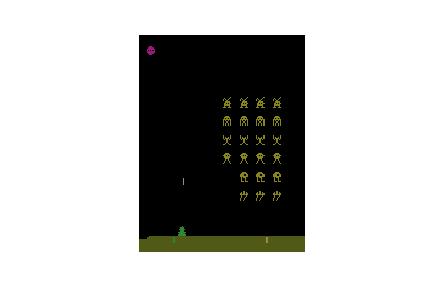
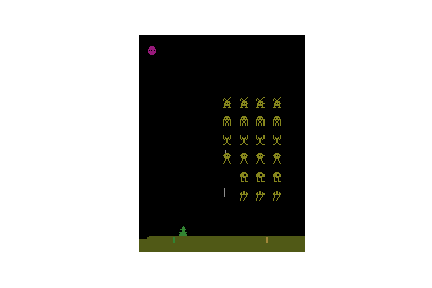
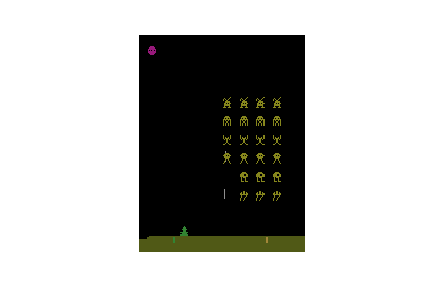
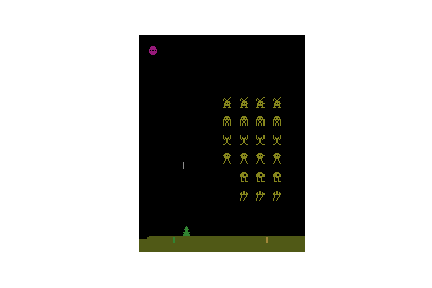
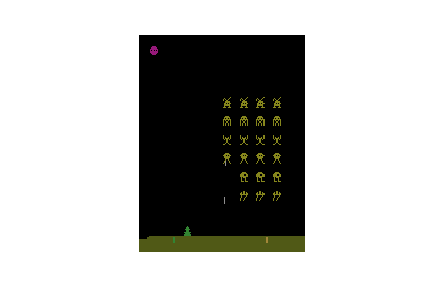
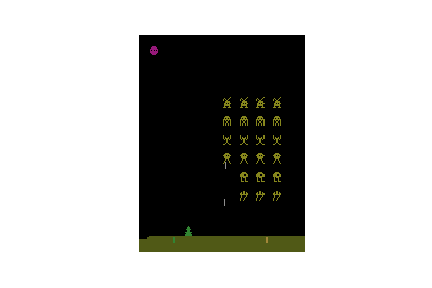
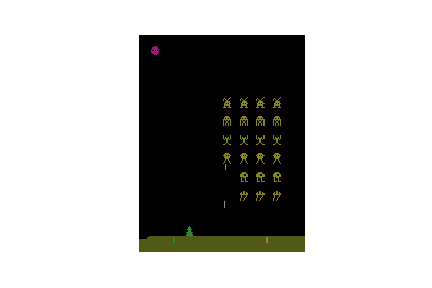
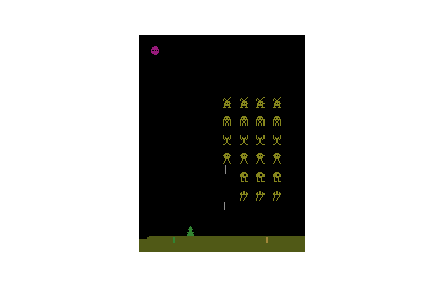
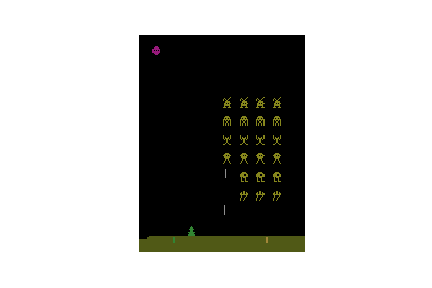
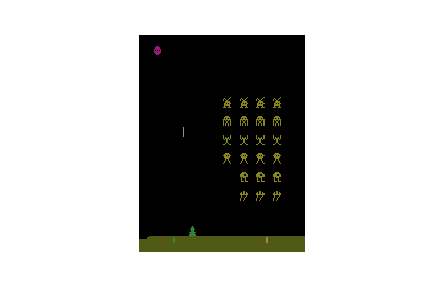
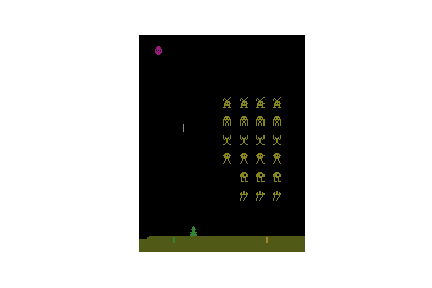
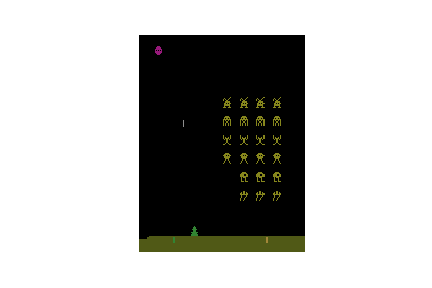
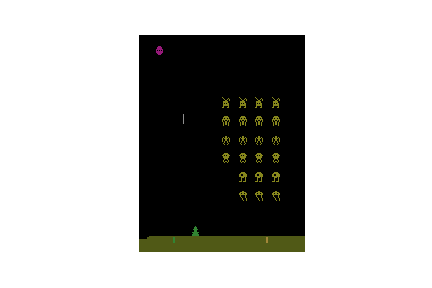
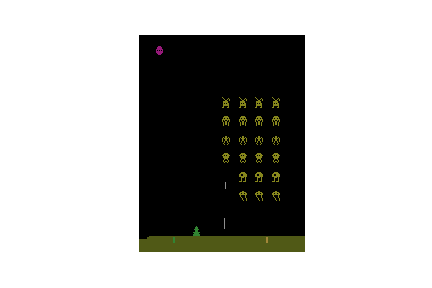
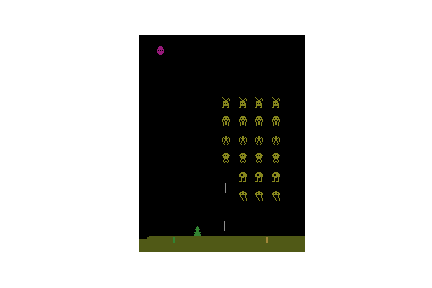
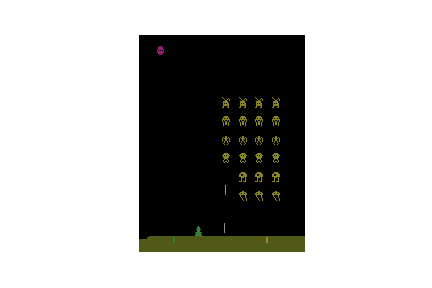
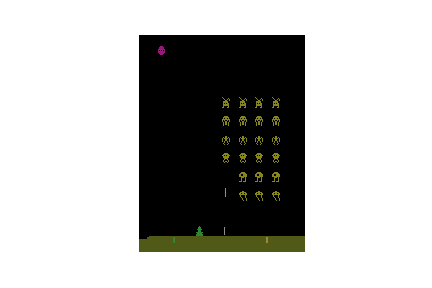
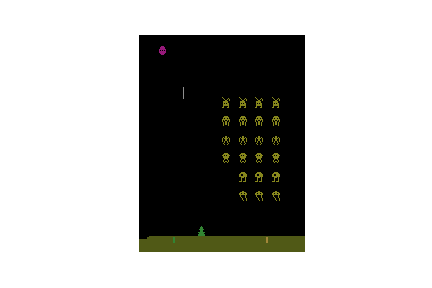
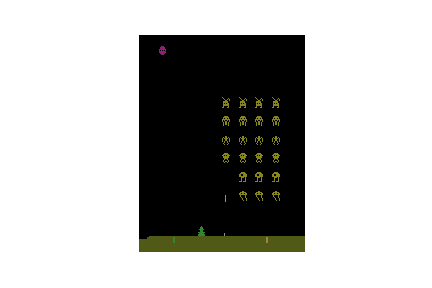
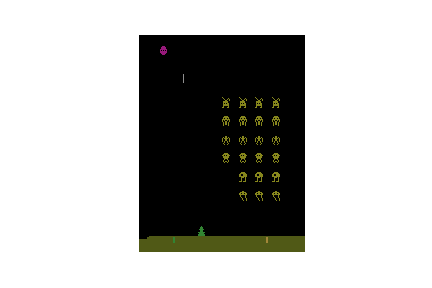
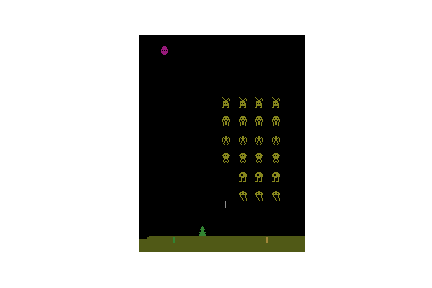
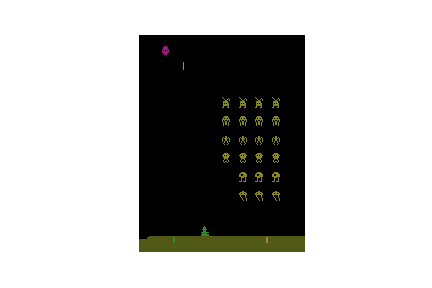
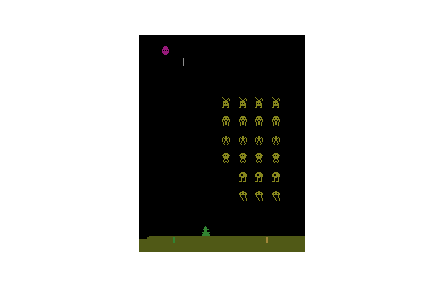
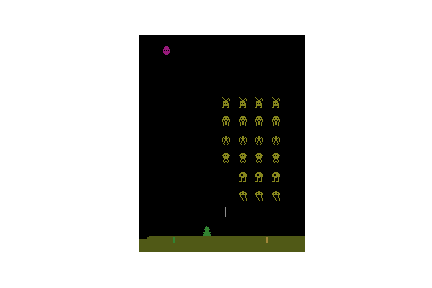
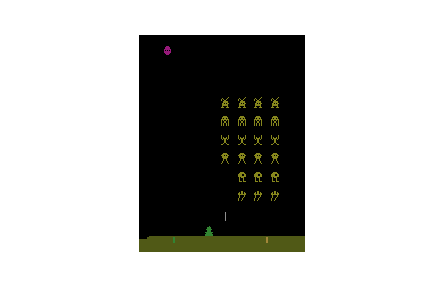
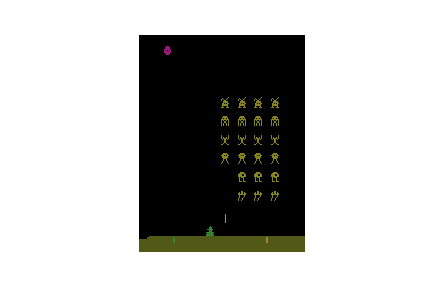
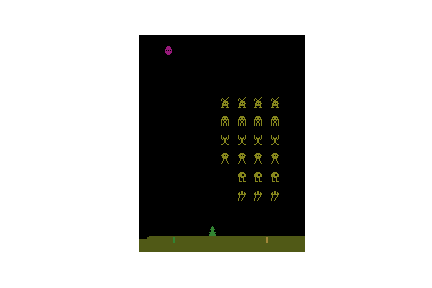
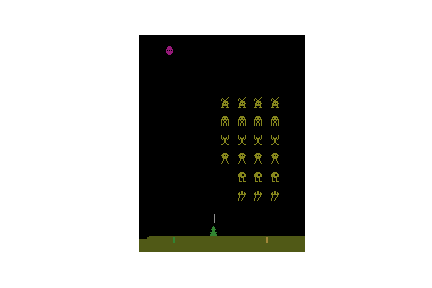
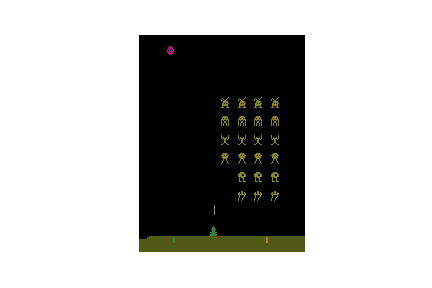
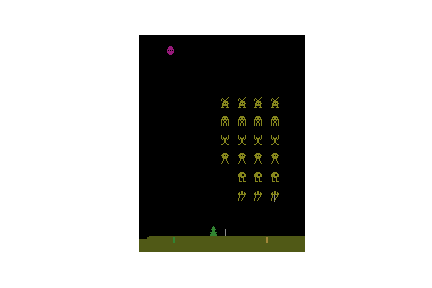
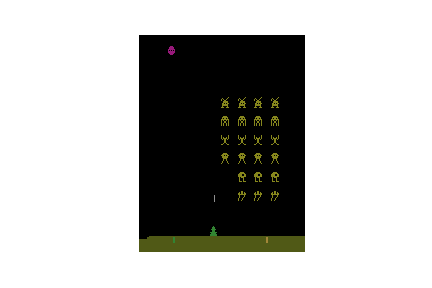
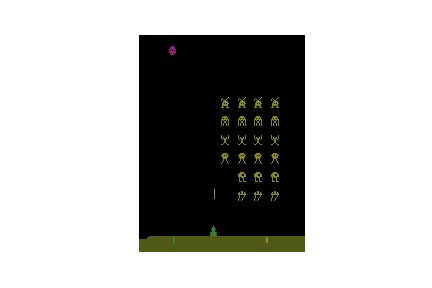
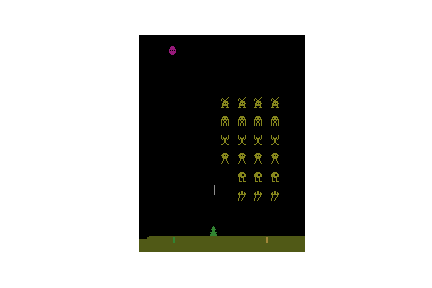
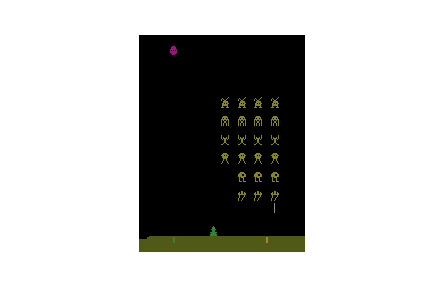
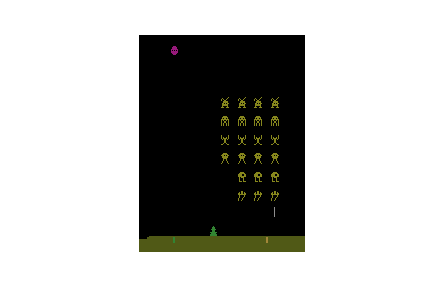
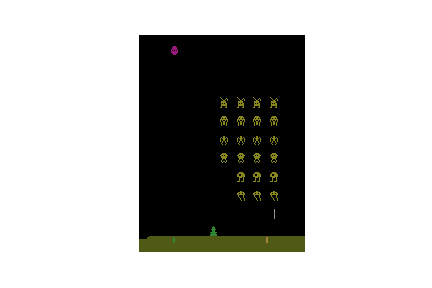
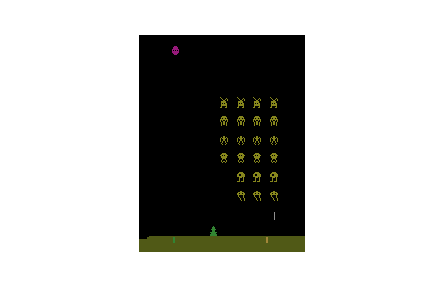
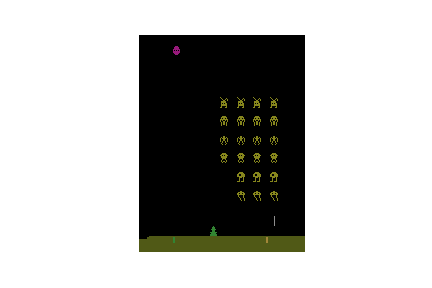
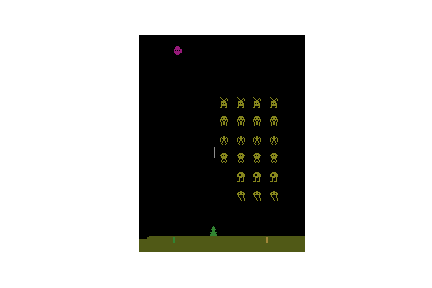
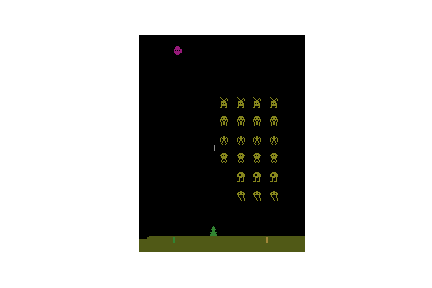
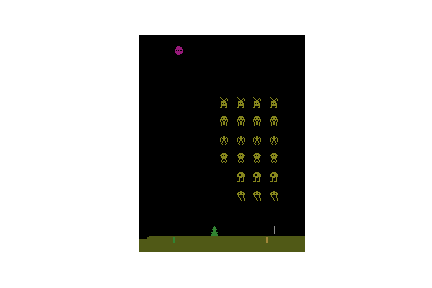
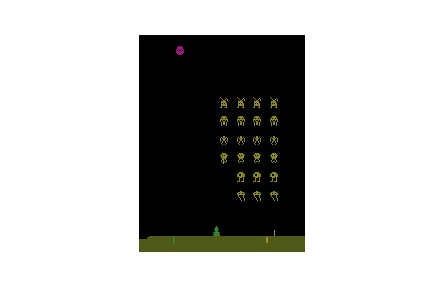
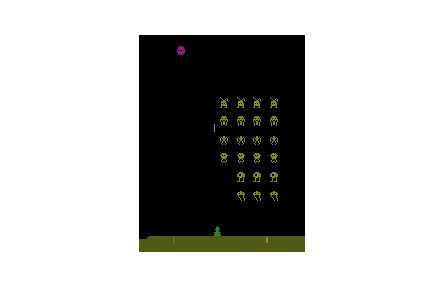
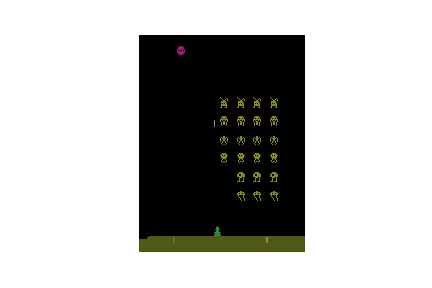
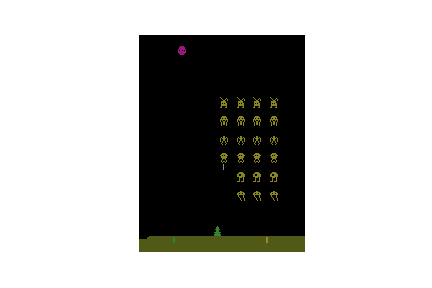
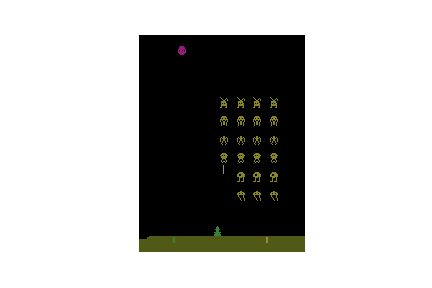
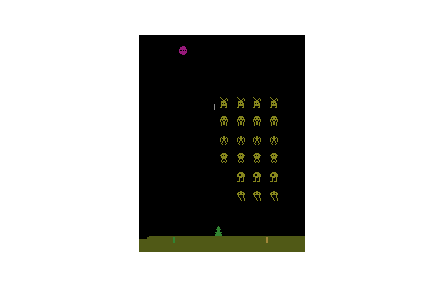
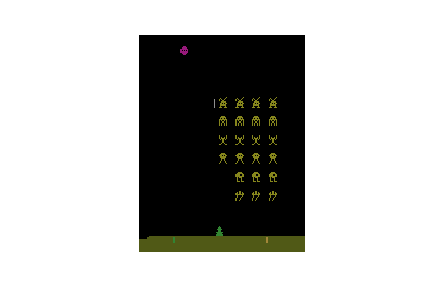
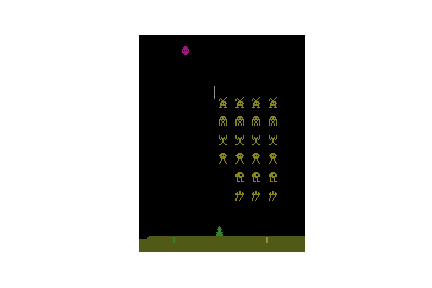
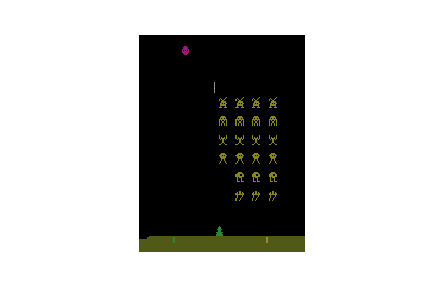
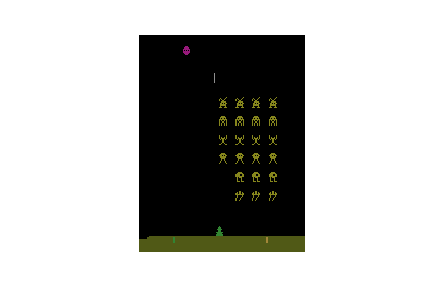
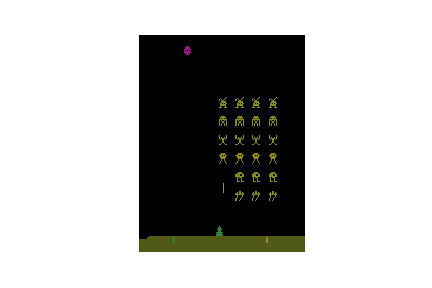
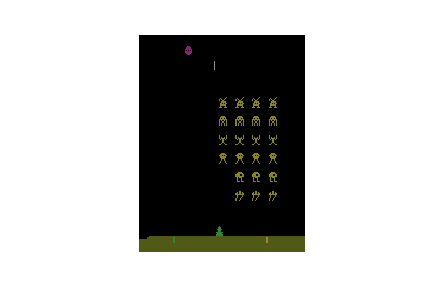
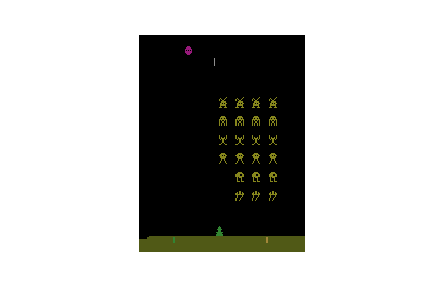
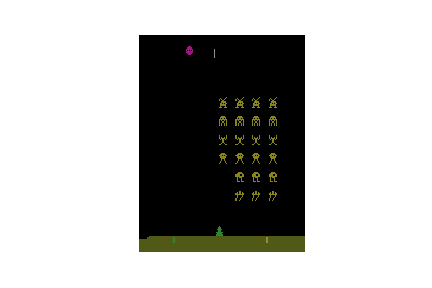
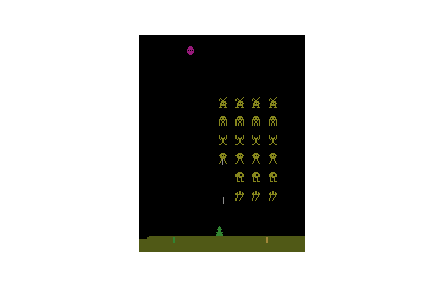
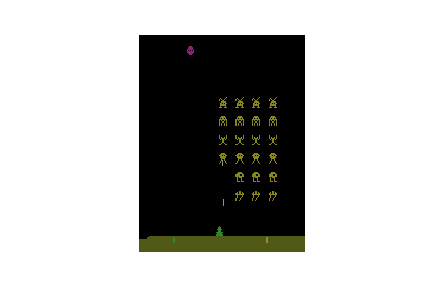
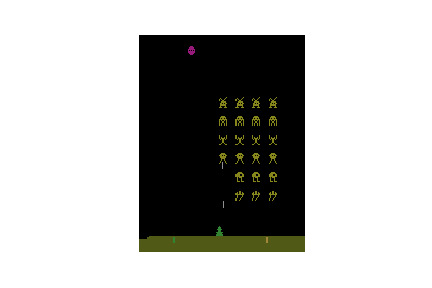
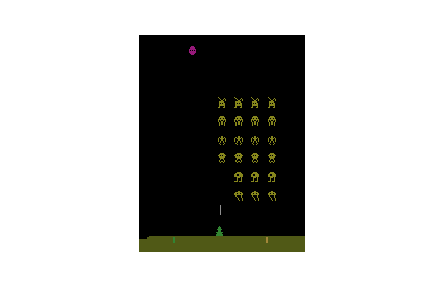
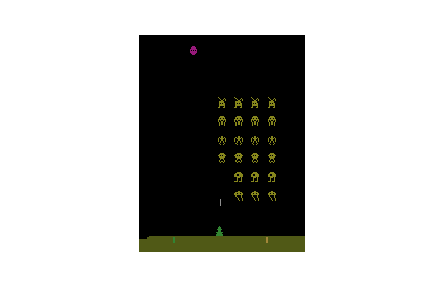
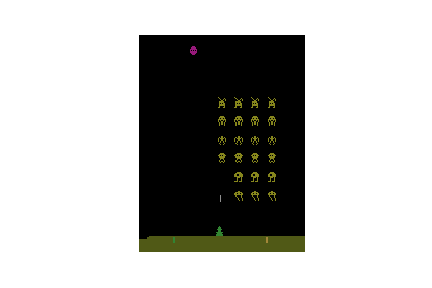
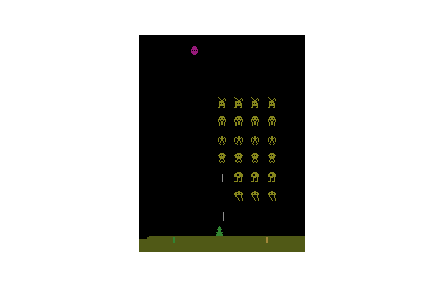
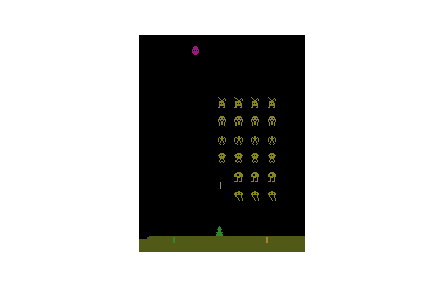
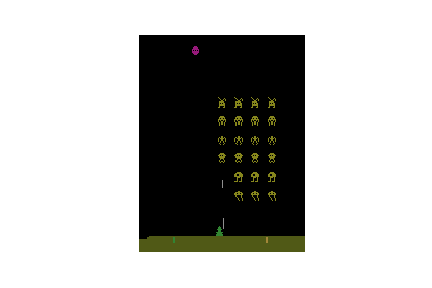
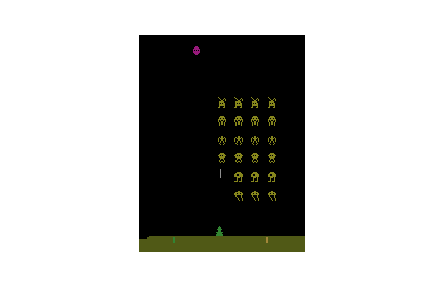
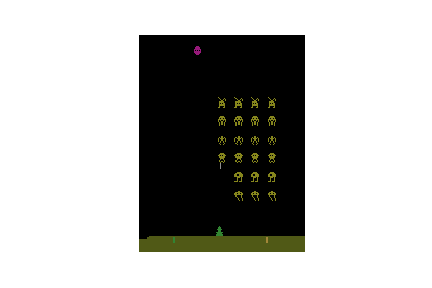
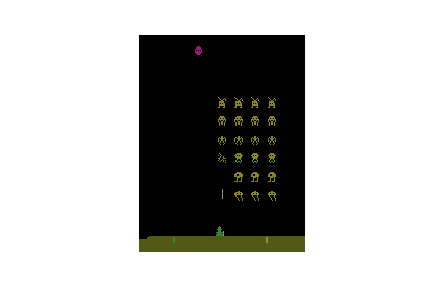
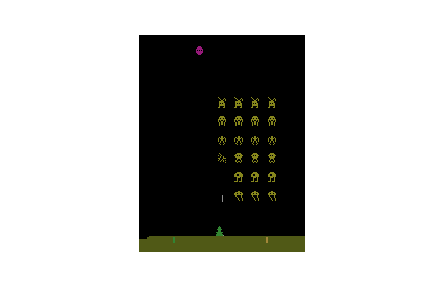
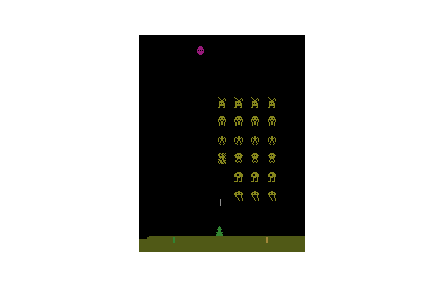
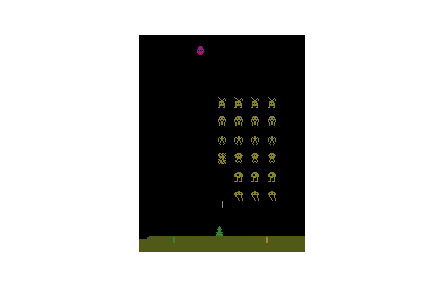
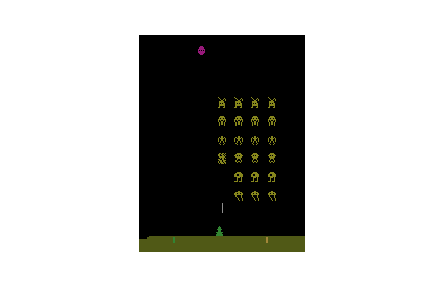
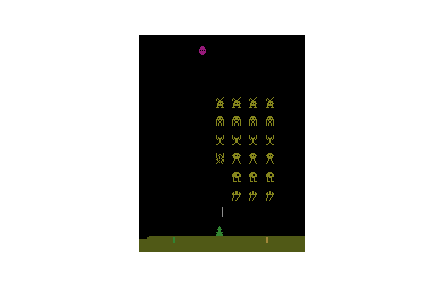
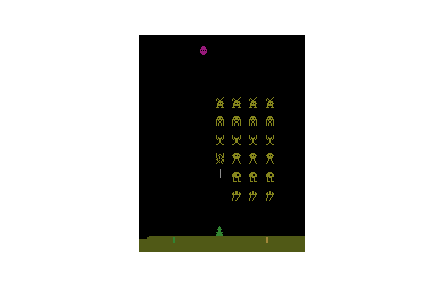
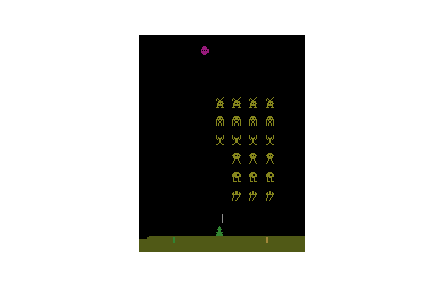
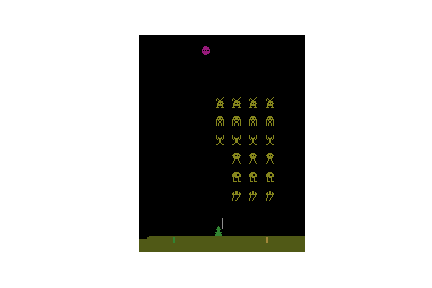
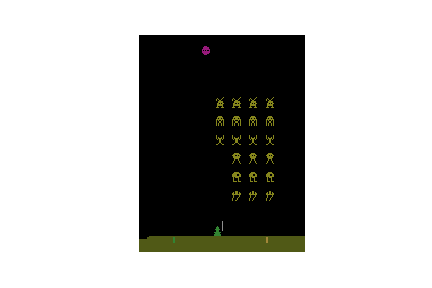
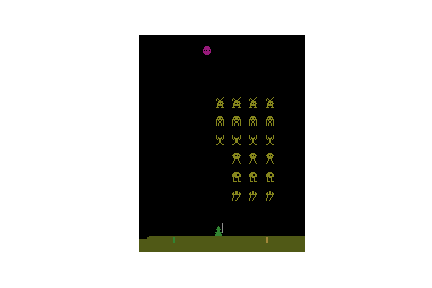
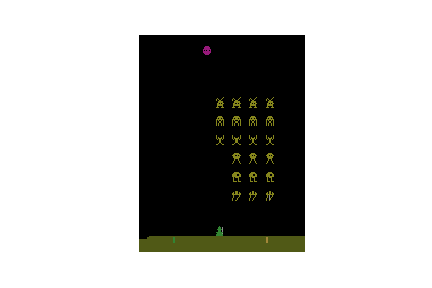
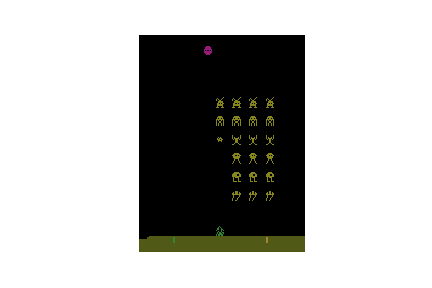
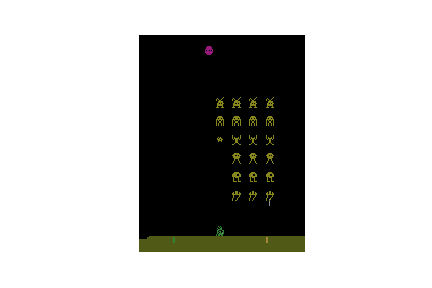
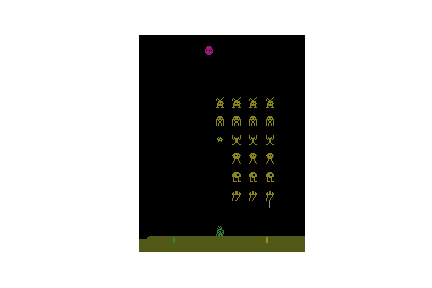
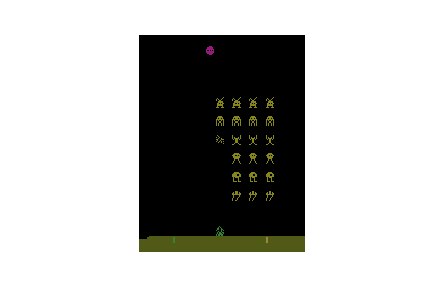
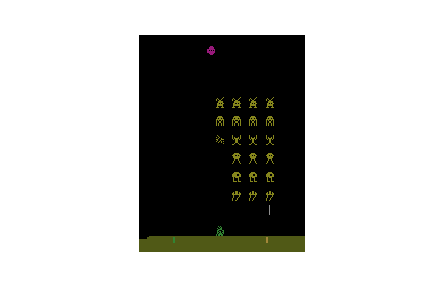
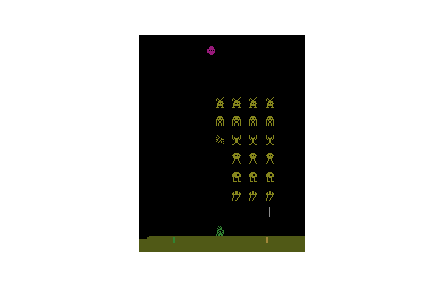
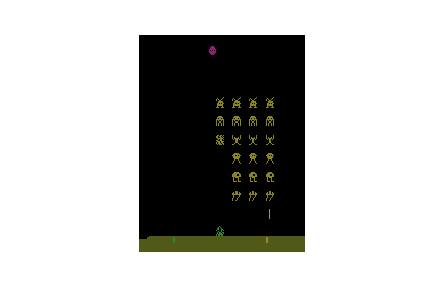
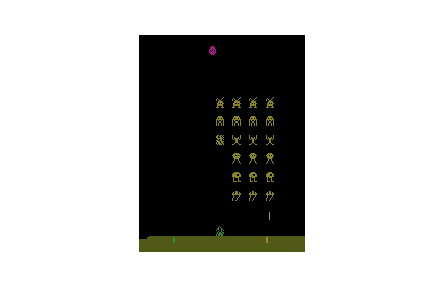
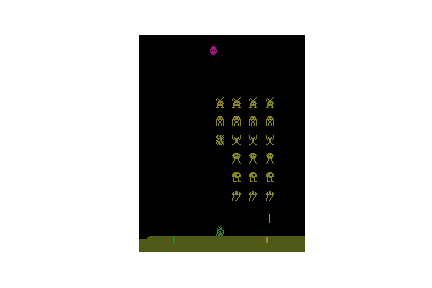
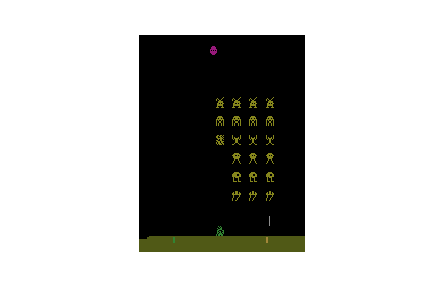
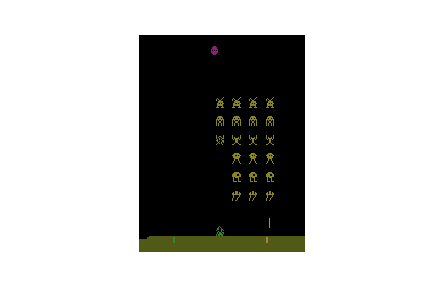
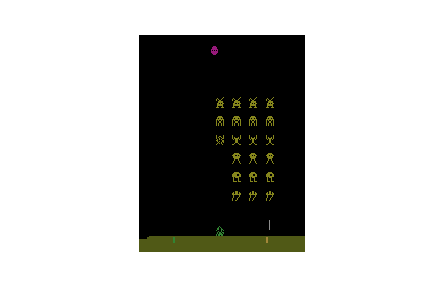
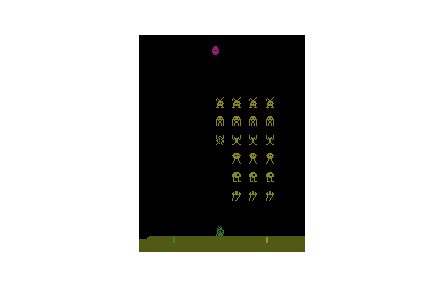
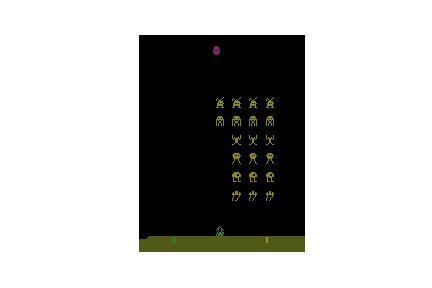
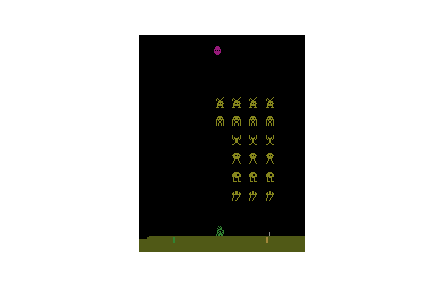
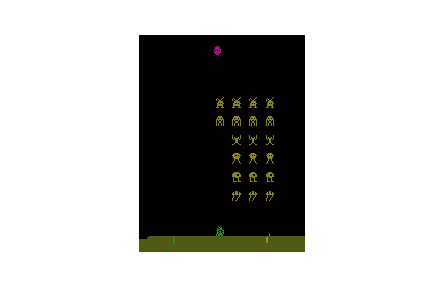
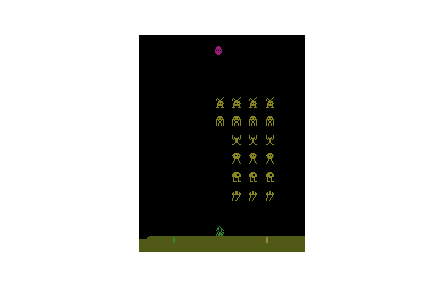
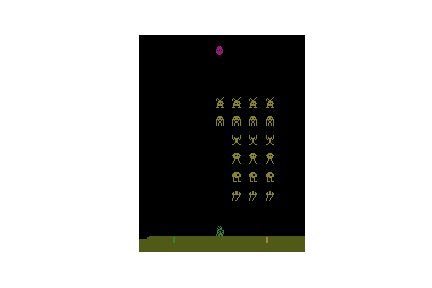
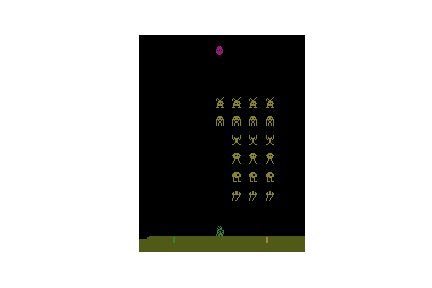
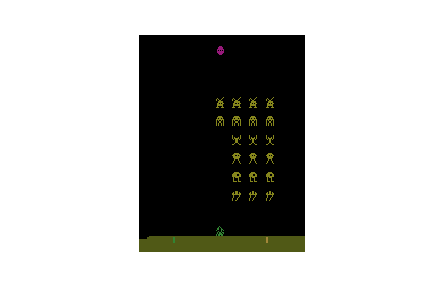
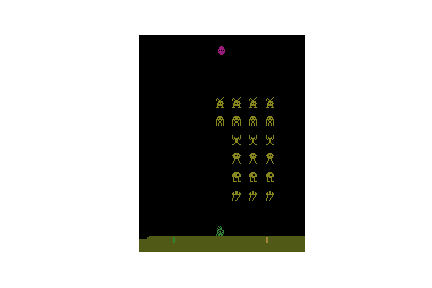
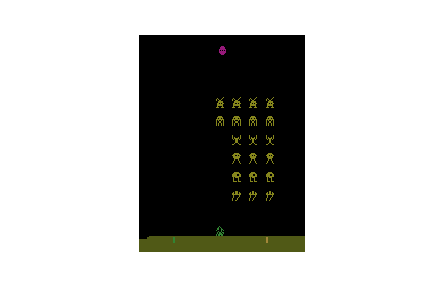
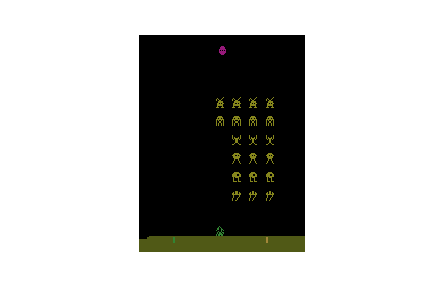
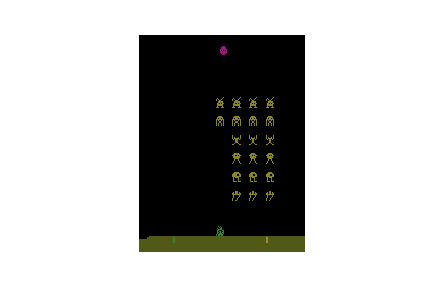
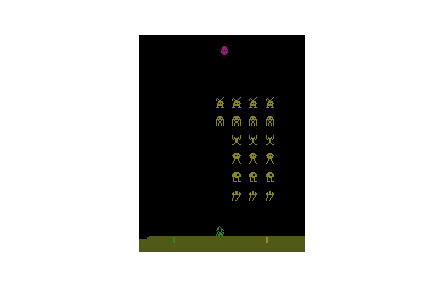
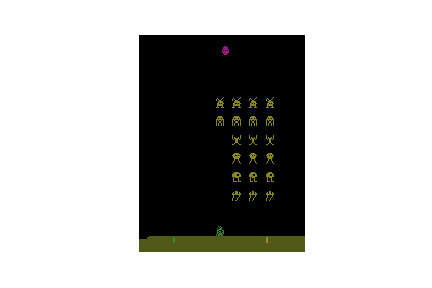
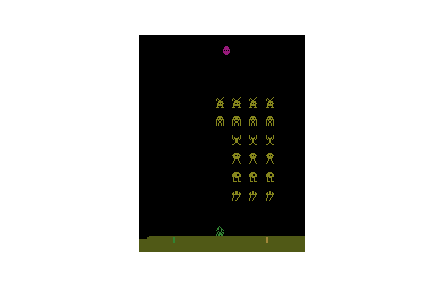
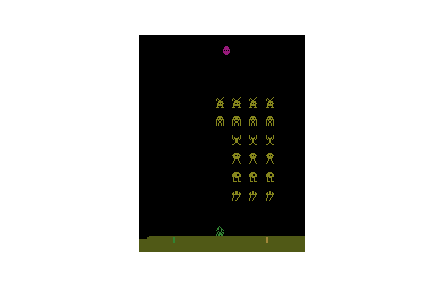
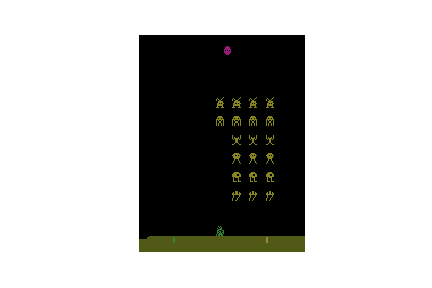
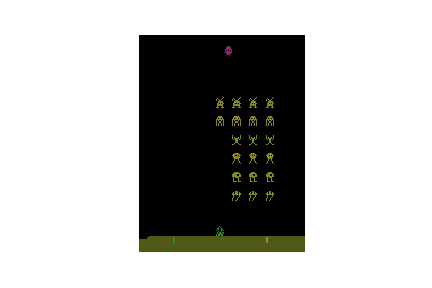
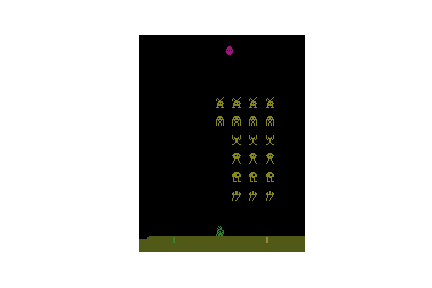
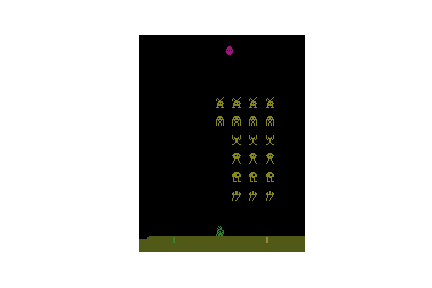
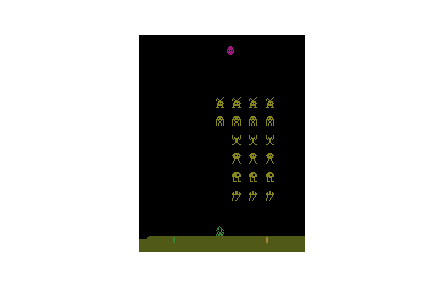
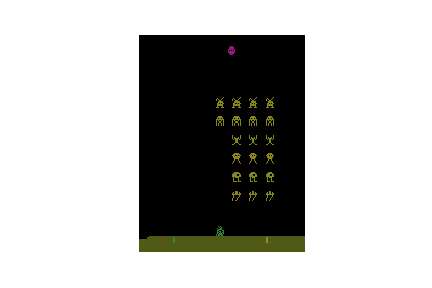
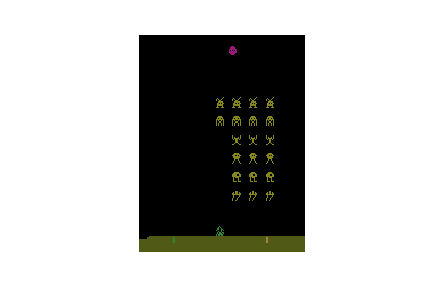
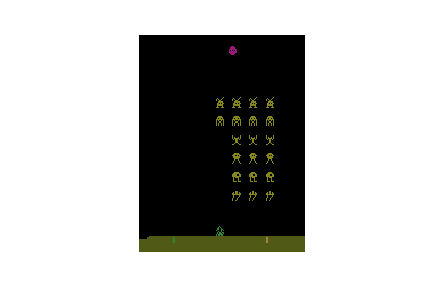
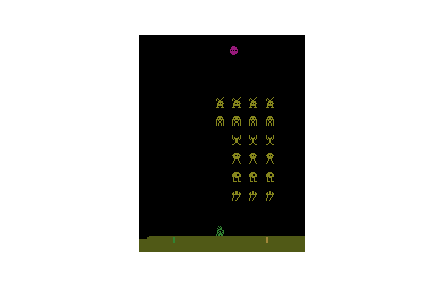
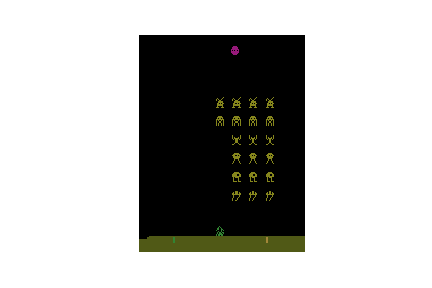
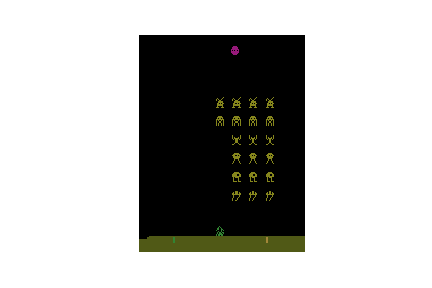
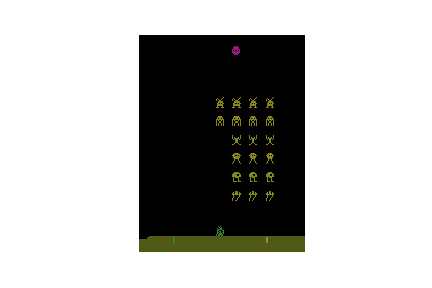
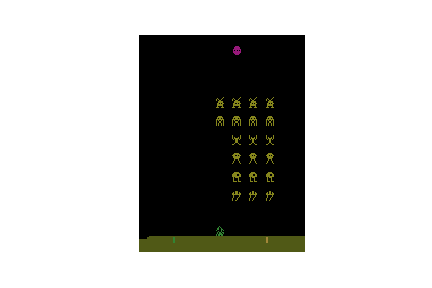
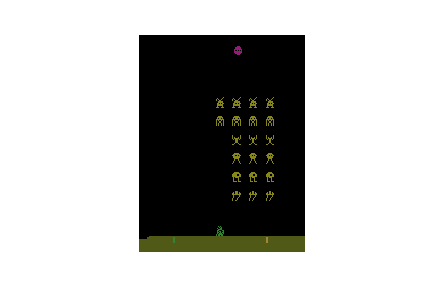
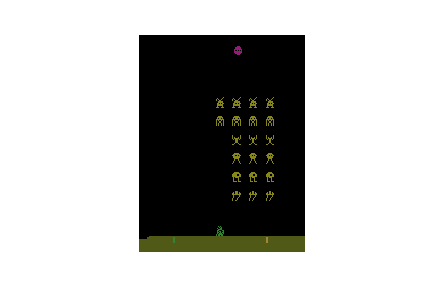
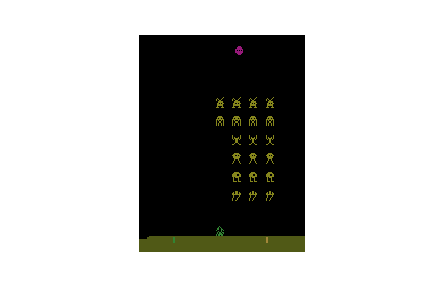
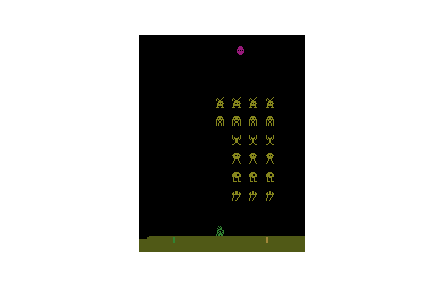

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Episode 1 ended.
	 Total Reward = 160.0



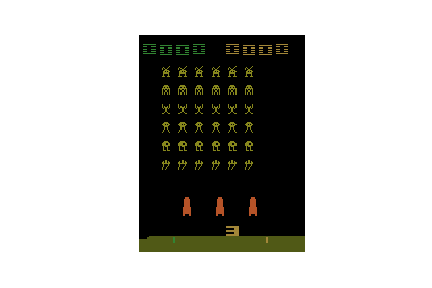
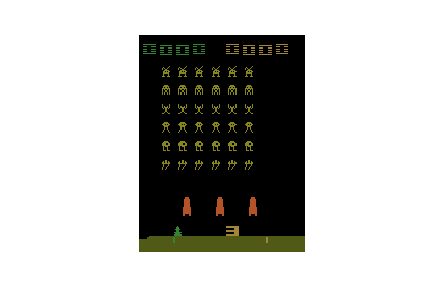
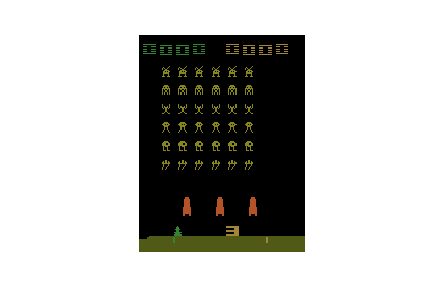
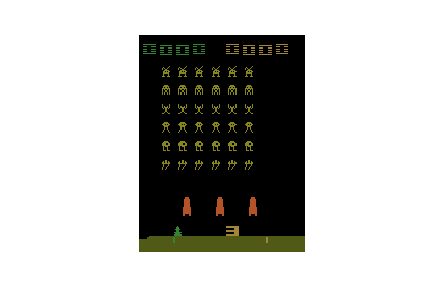
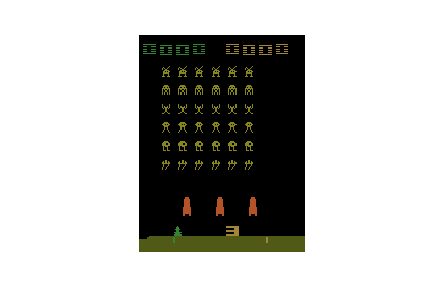
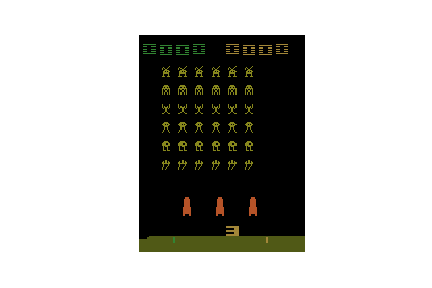
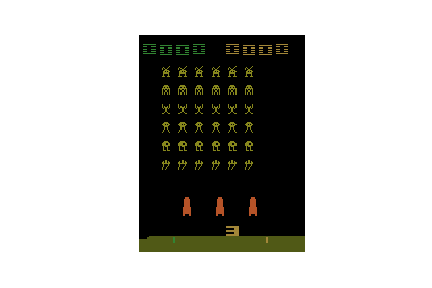
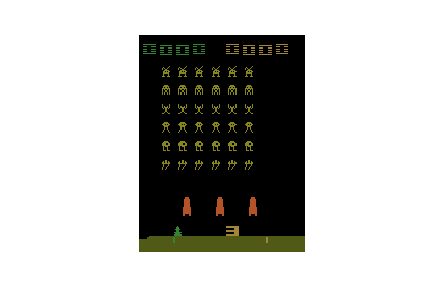
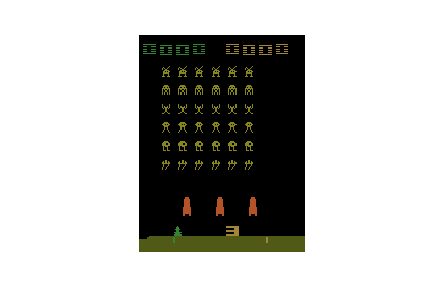
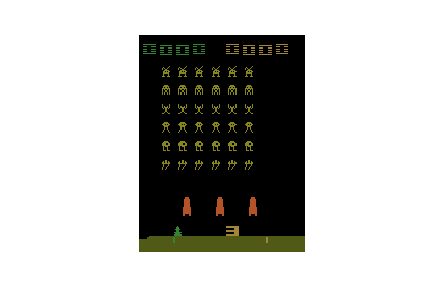
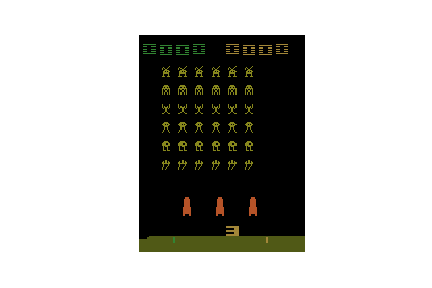
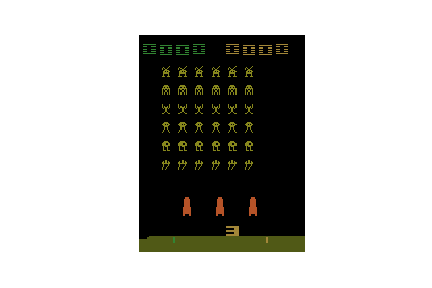
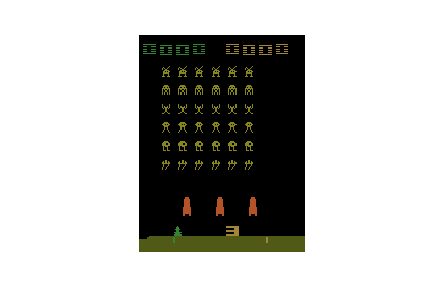
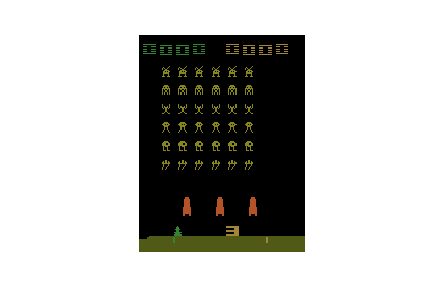
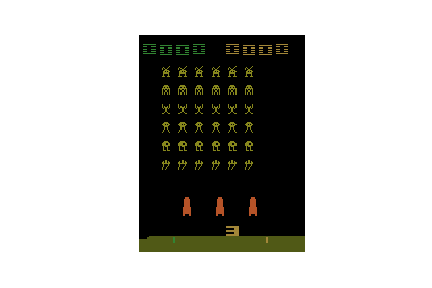
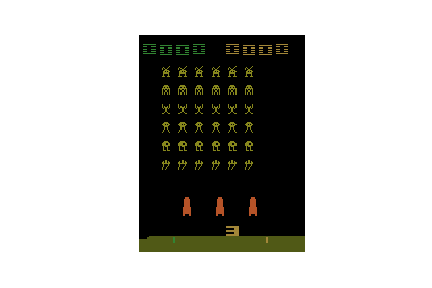
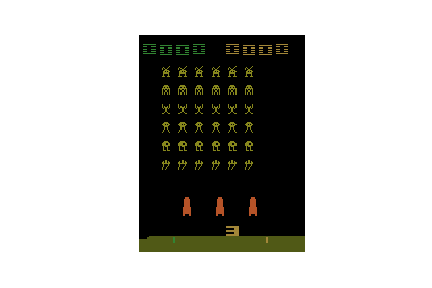
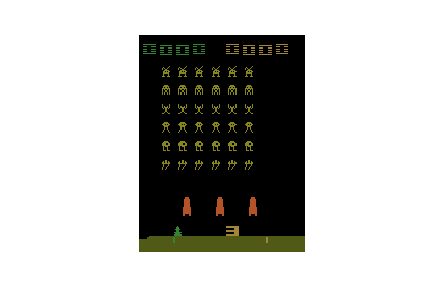
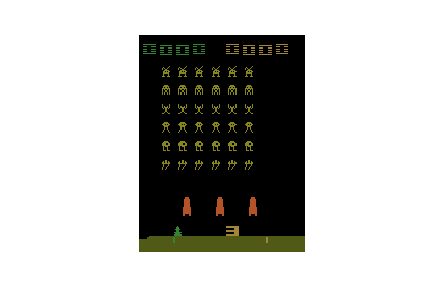
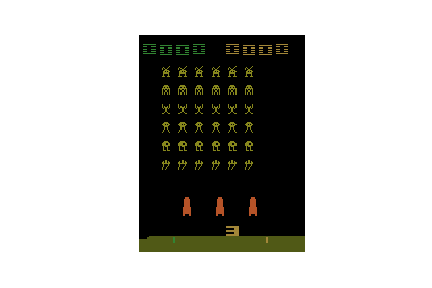
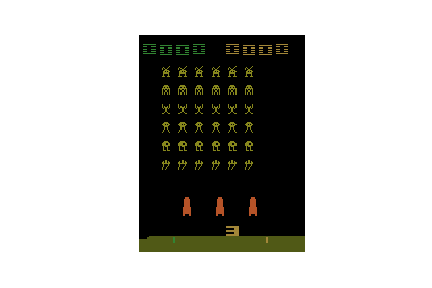
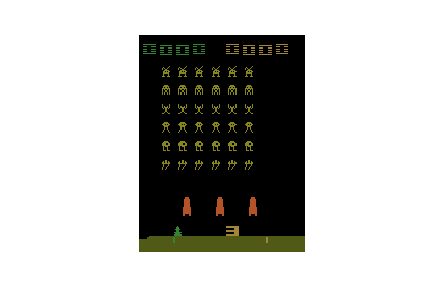
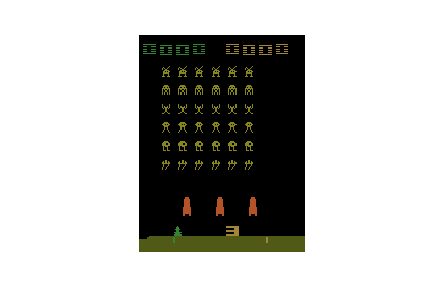
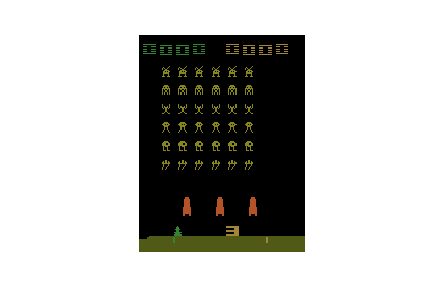
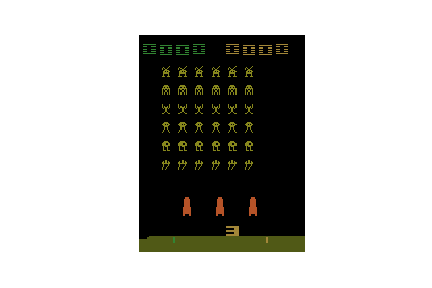
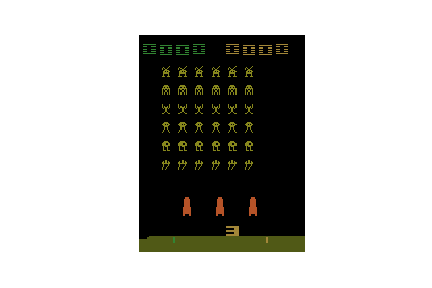
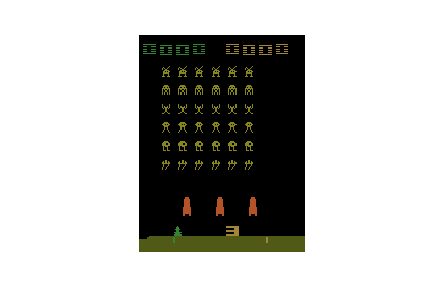
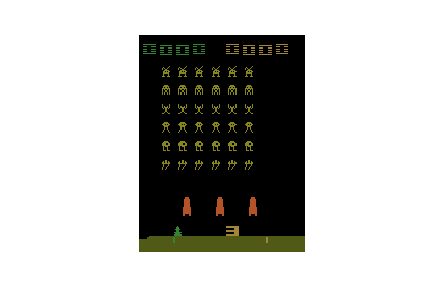
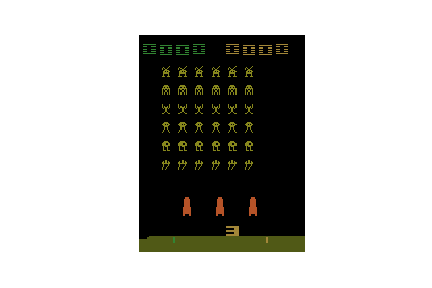
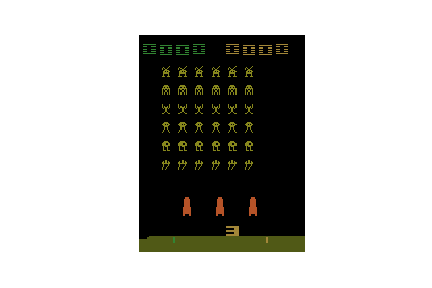
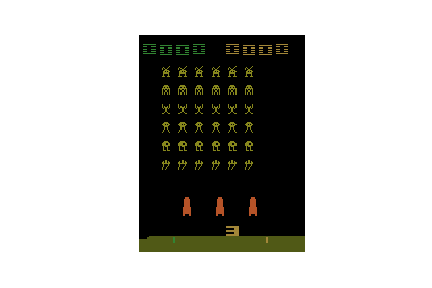
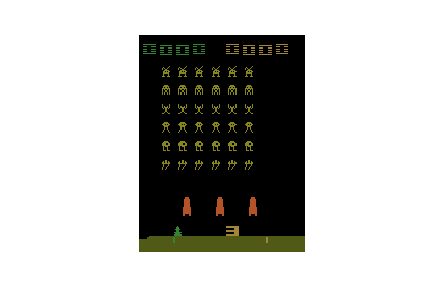
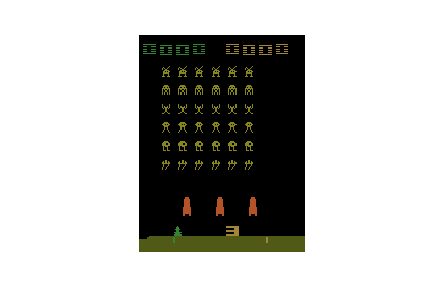
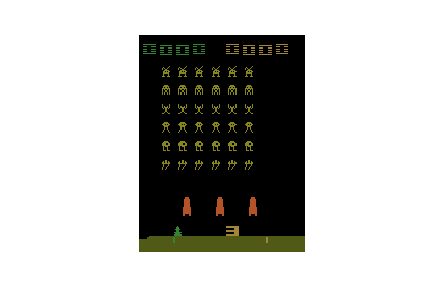
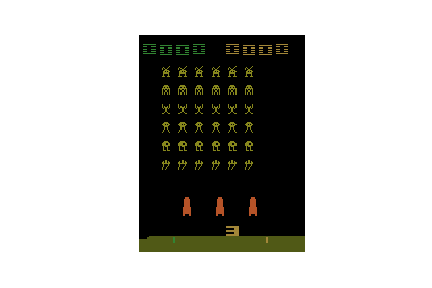
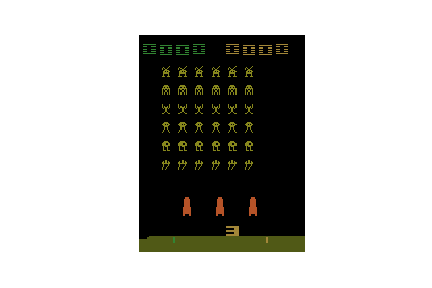
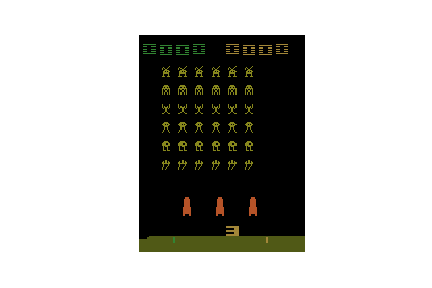
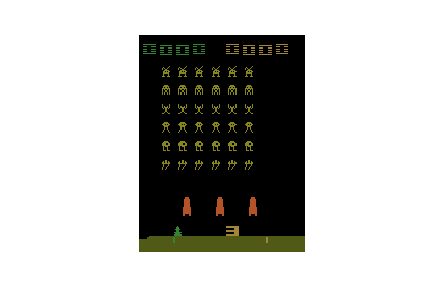
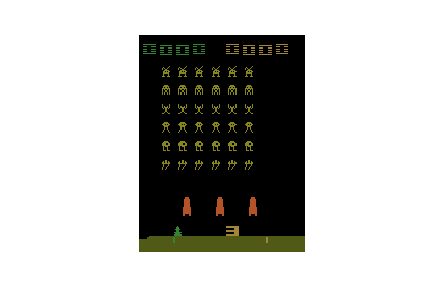
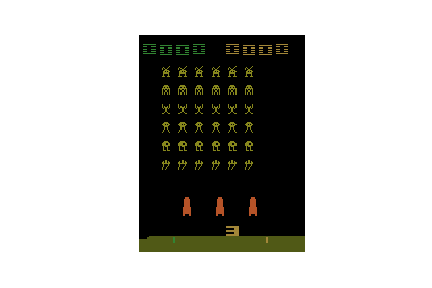
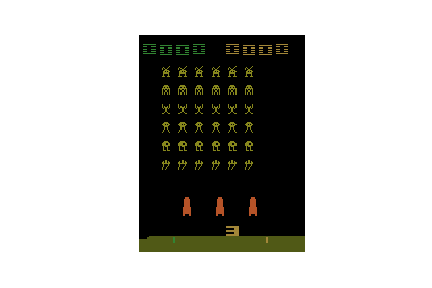
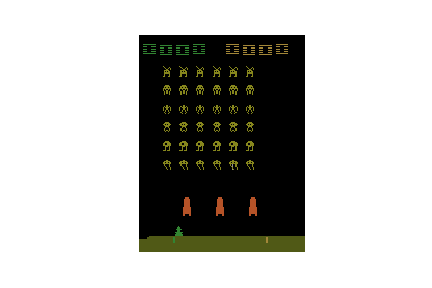
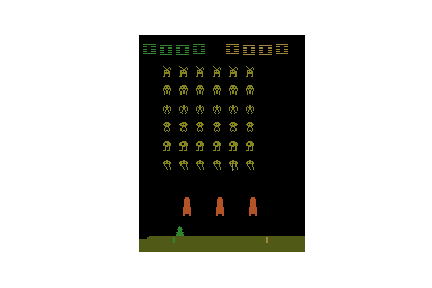
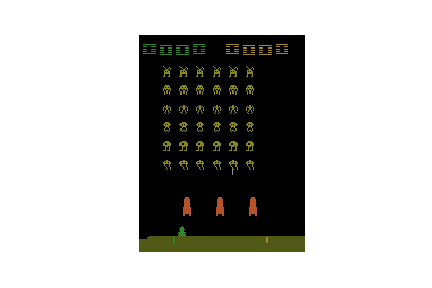
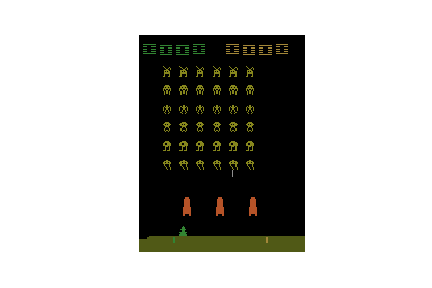
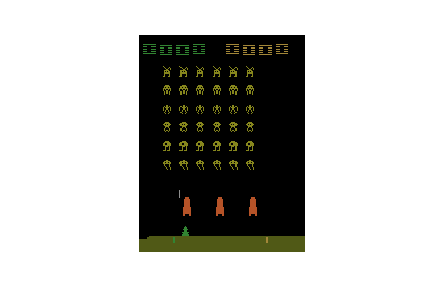
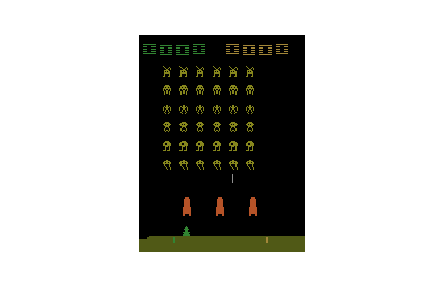
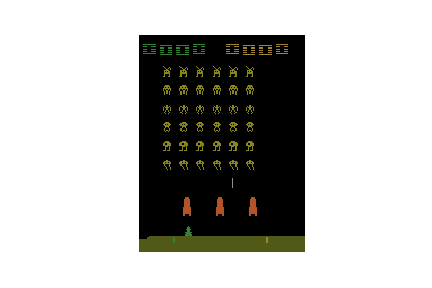
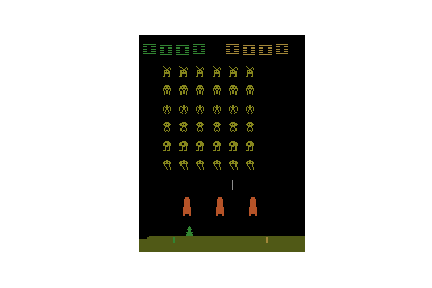
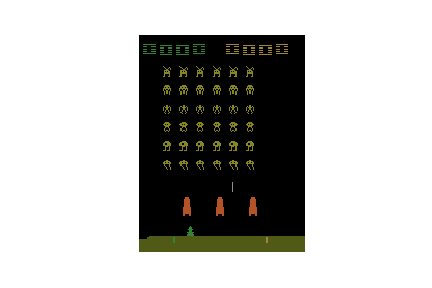
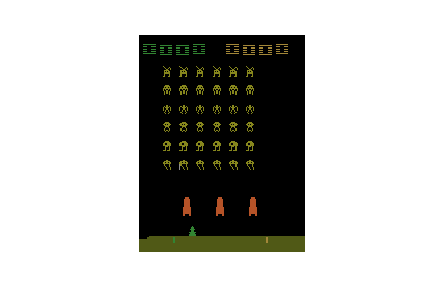
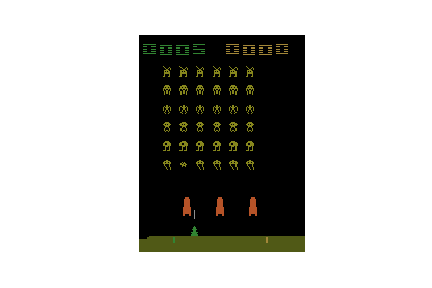
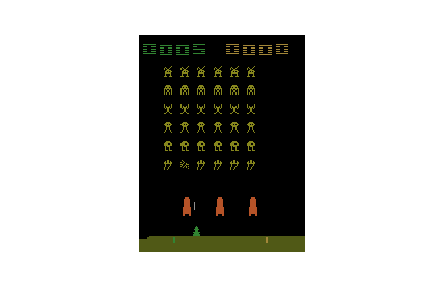
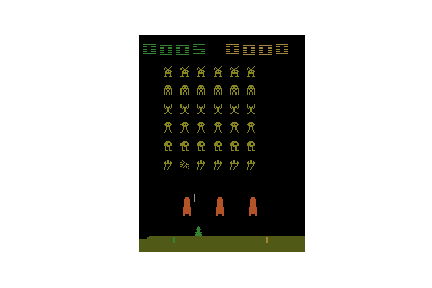
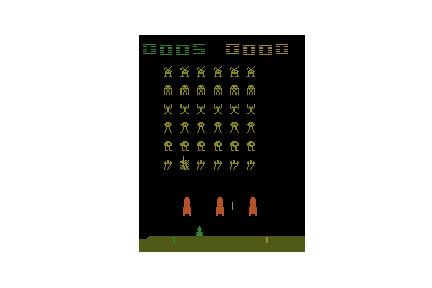
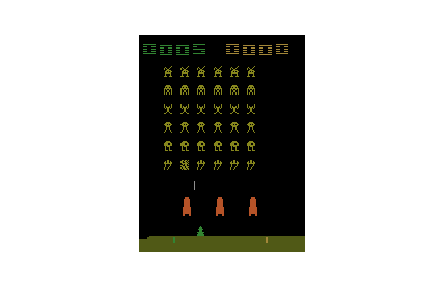
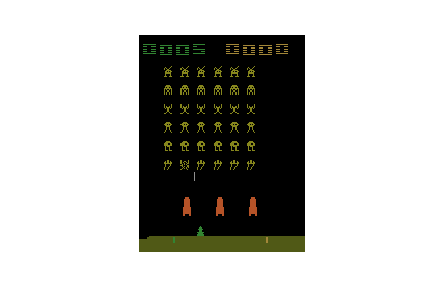
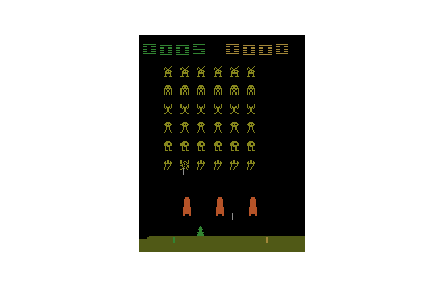
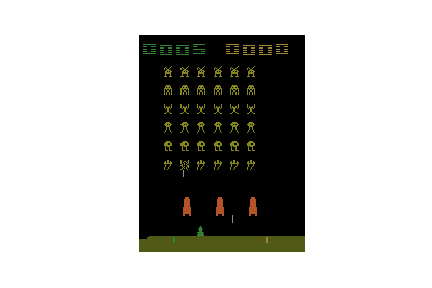
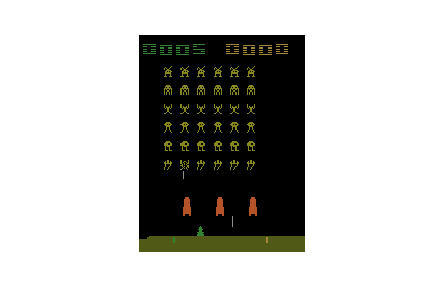
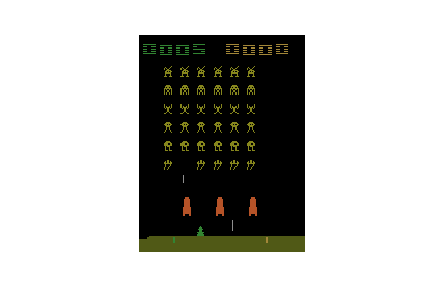
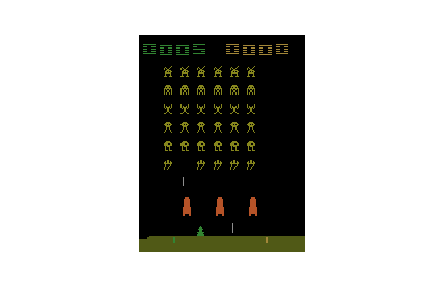
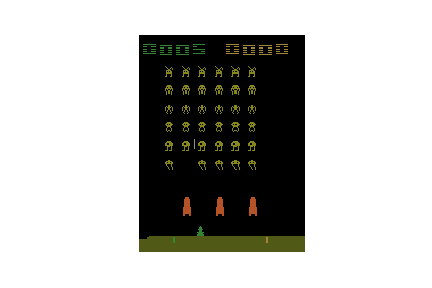
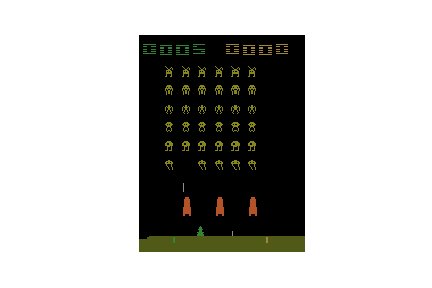
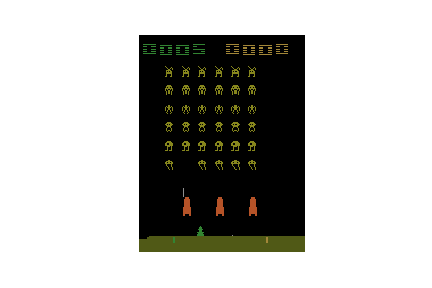
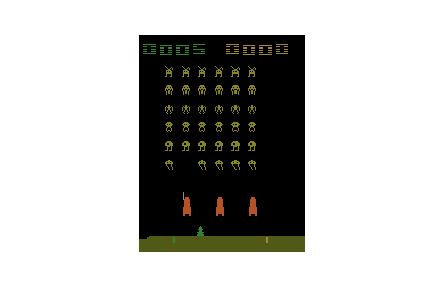
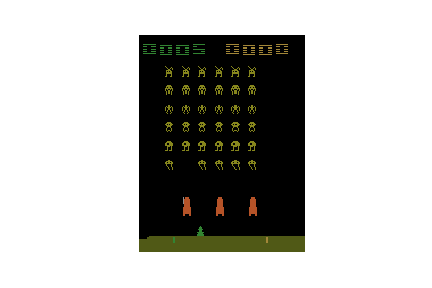
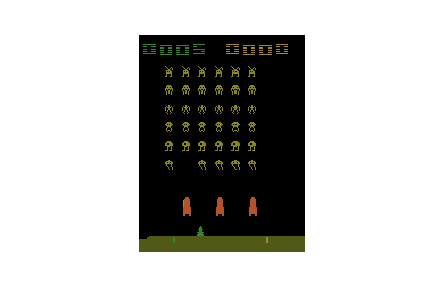
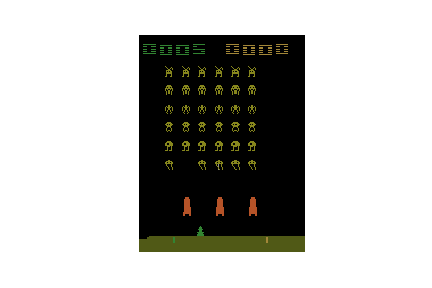
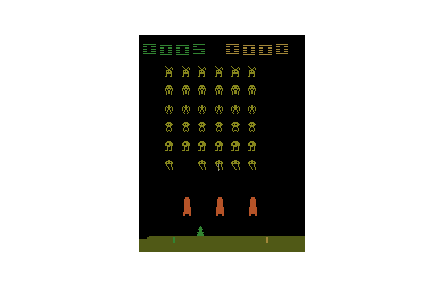
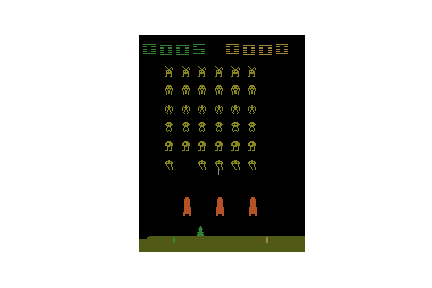
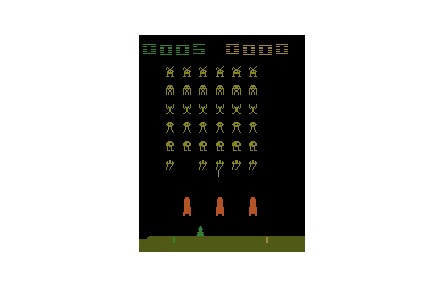
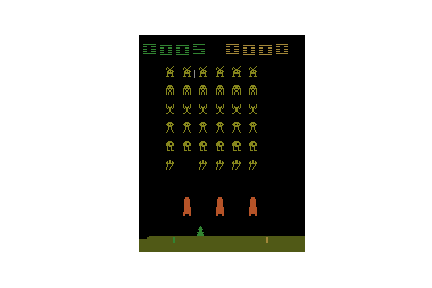
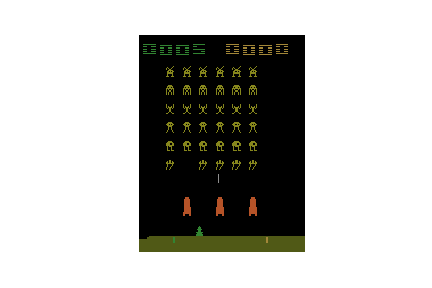
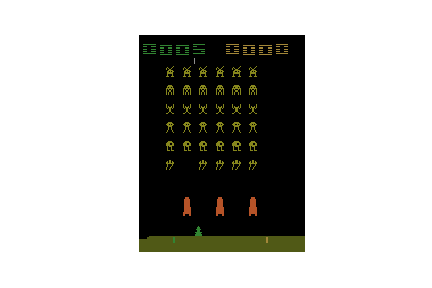
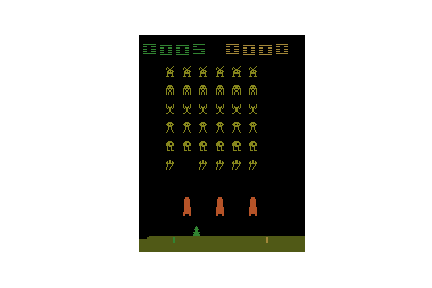
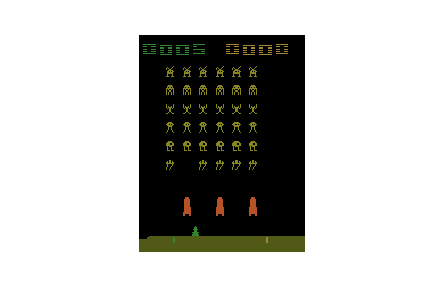
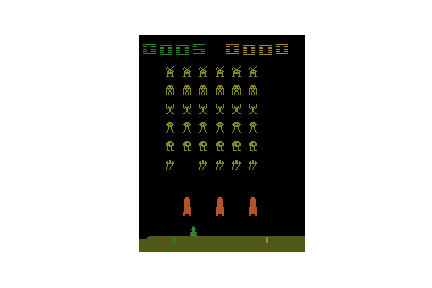
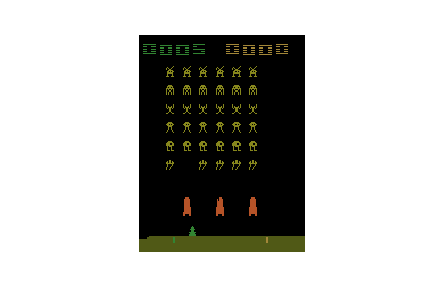
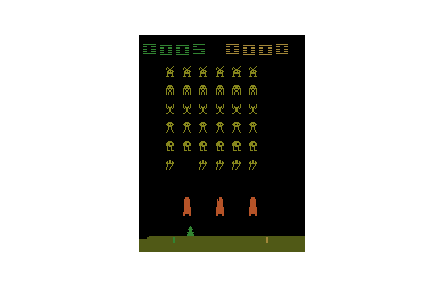
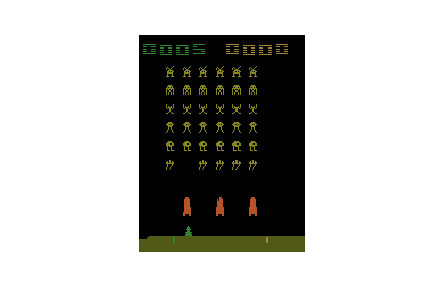
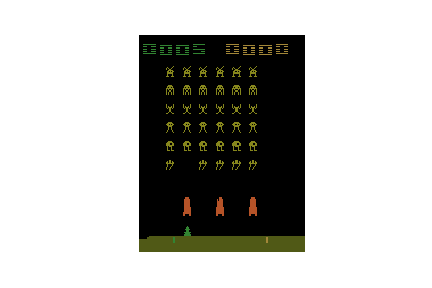
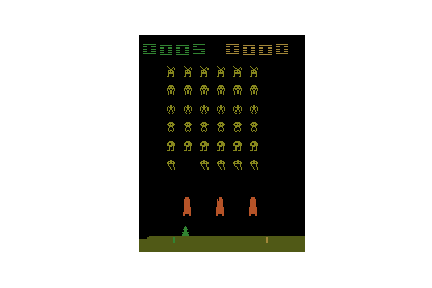
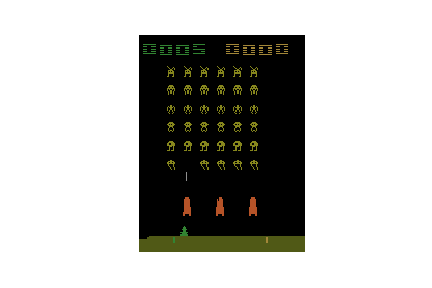
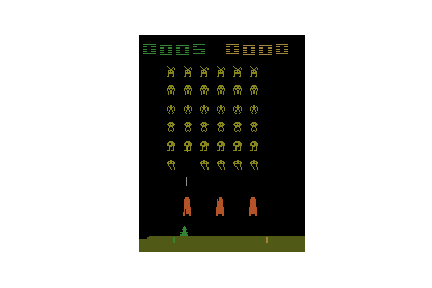
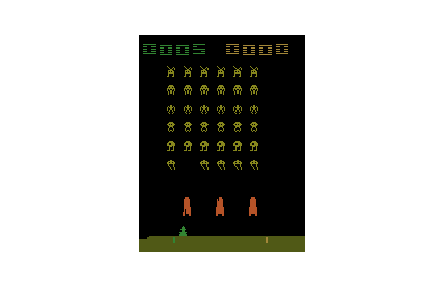
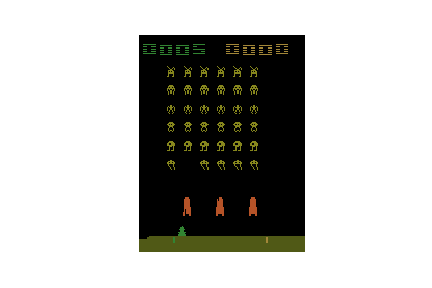
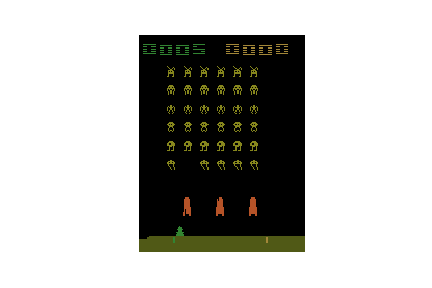
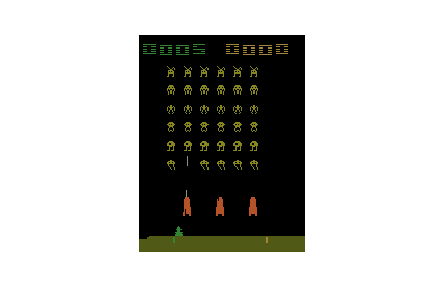
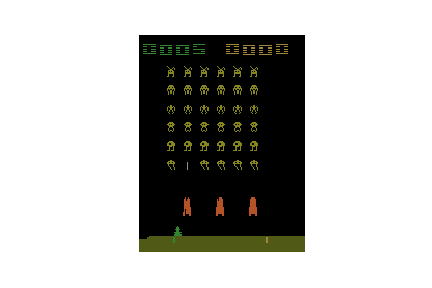
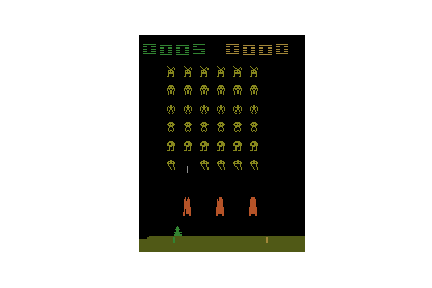
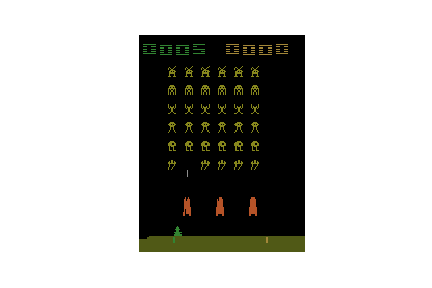
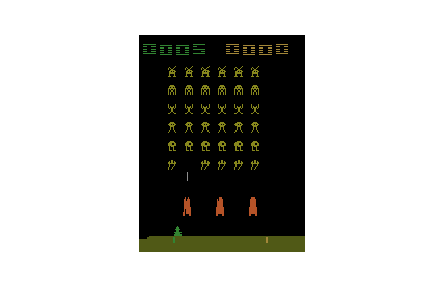
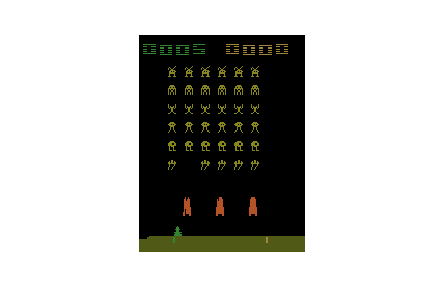
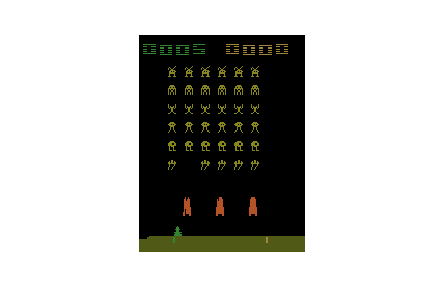
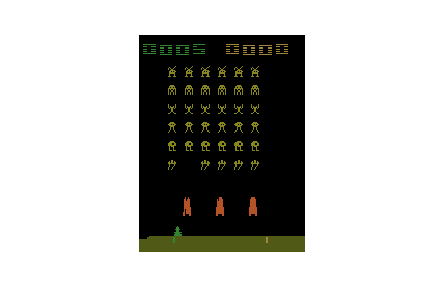
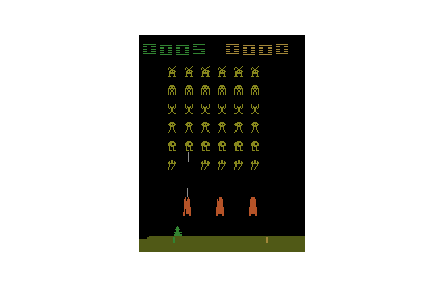
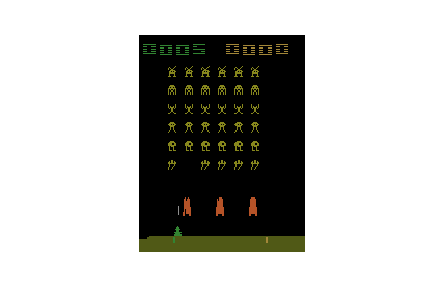
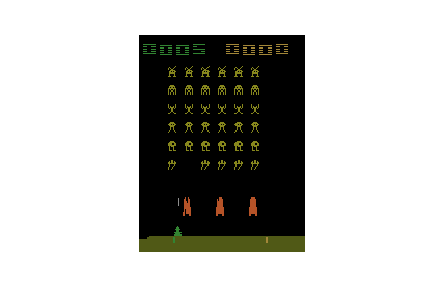
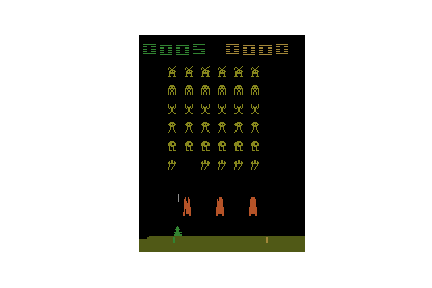
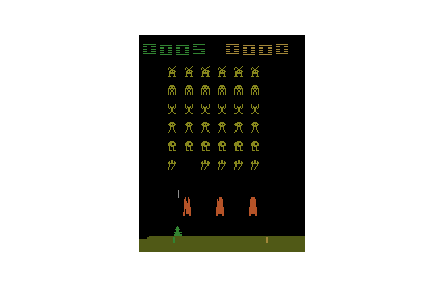
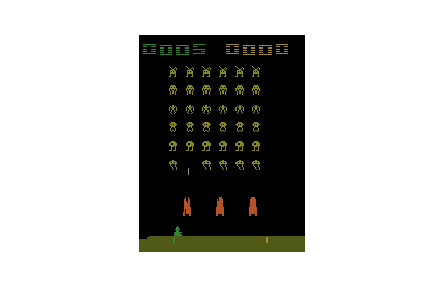
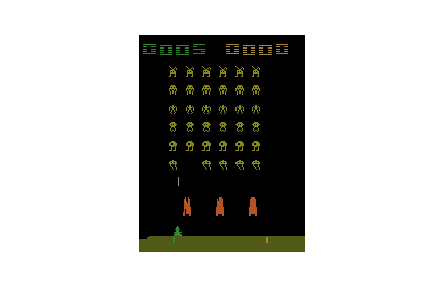
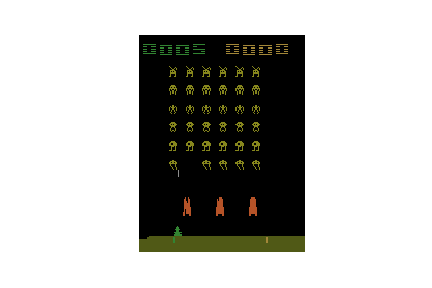
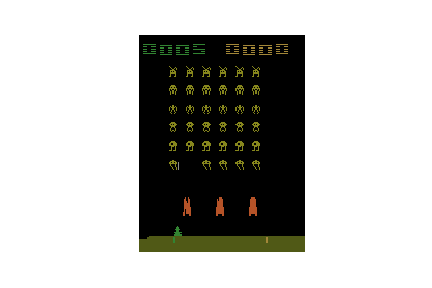
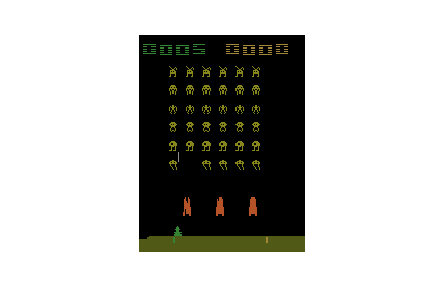
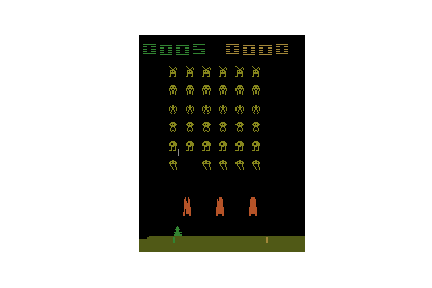
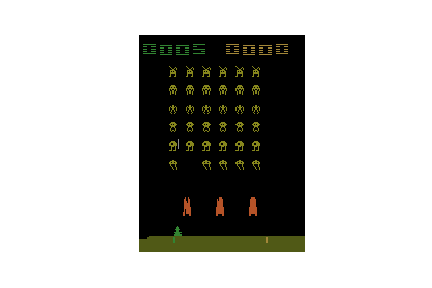
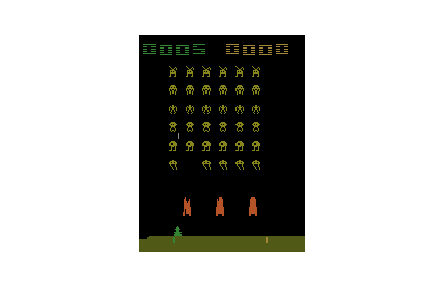
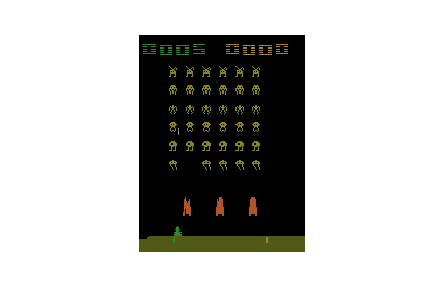
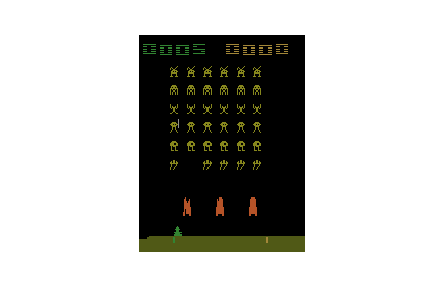
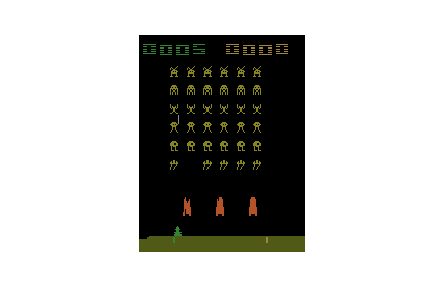
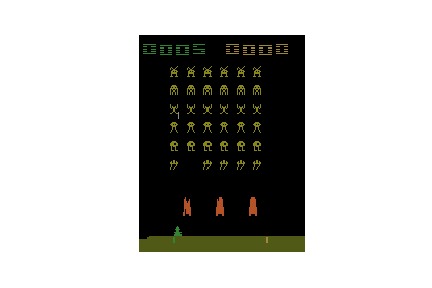
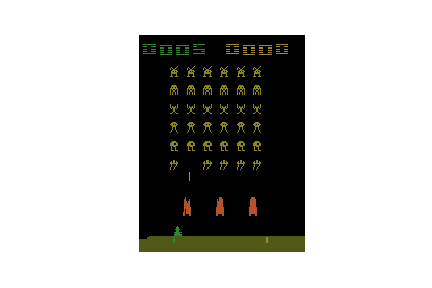
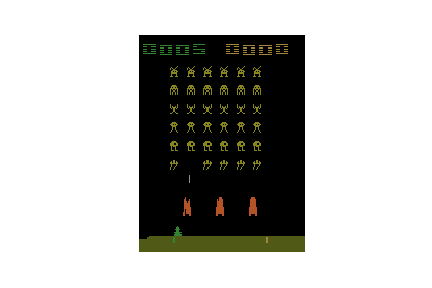
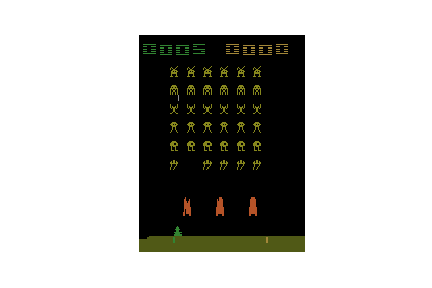
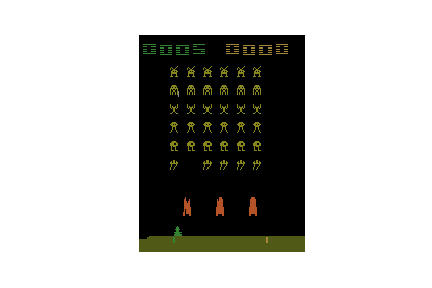
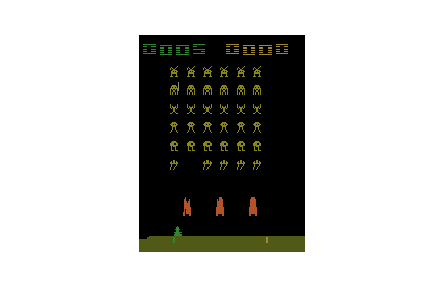
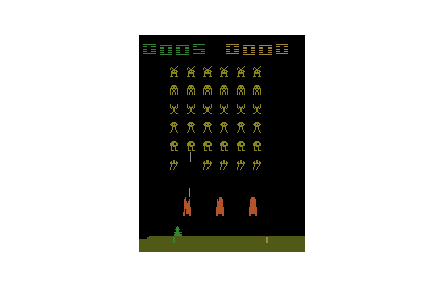
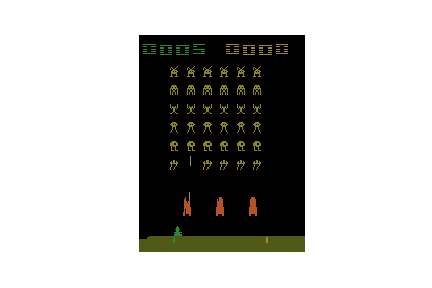
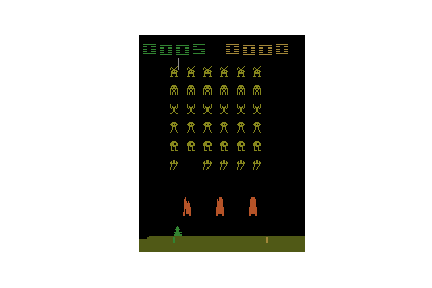
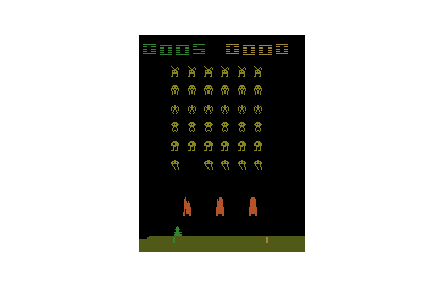
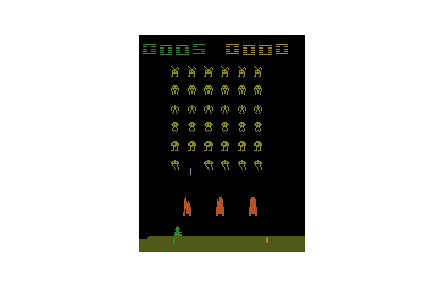
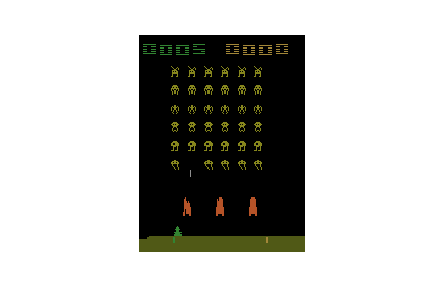
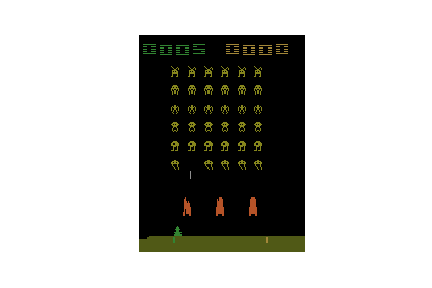
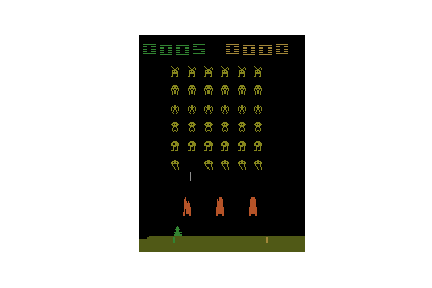
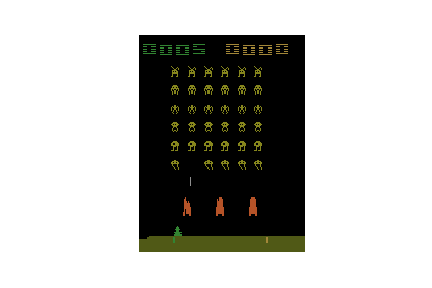
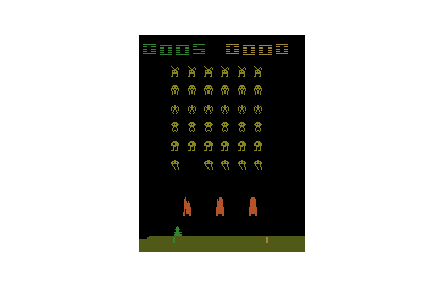
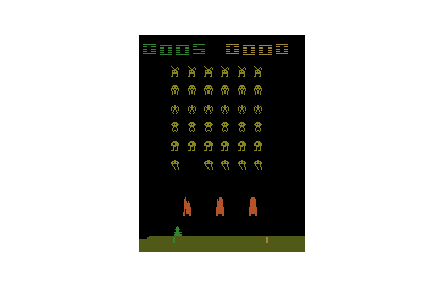
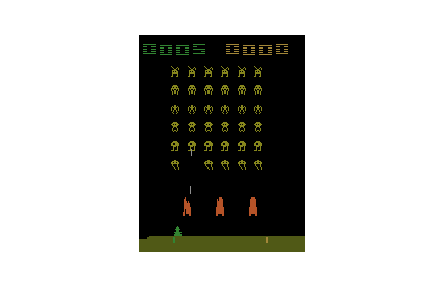
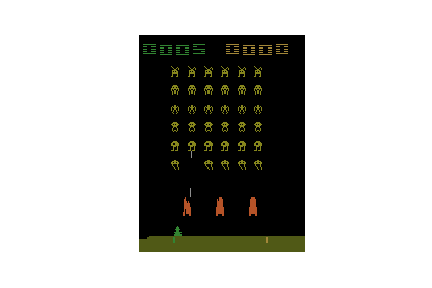
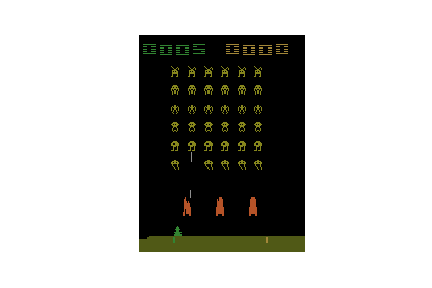
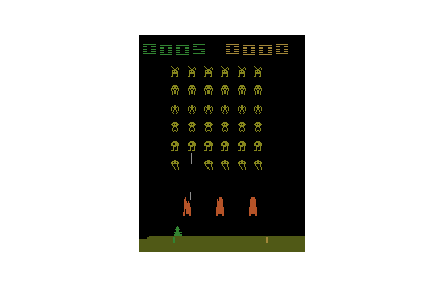
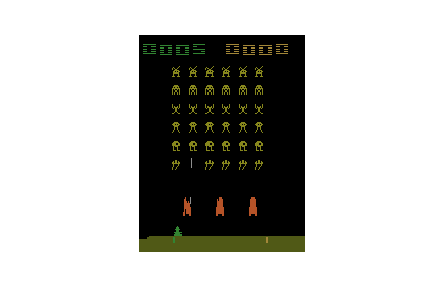
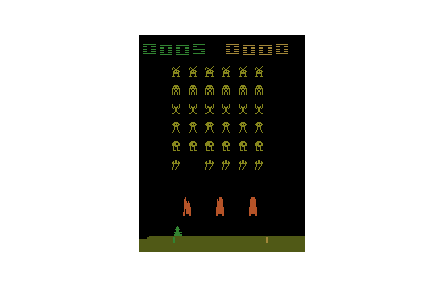
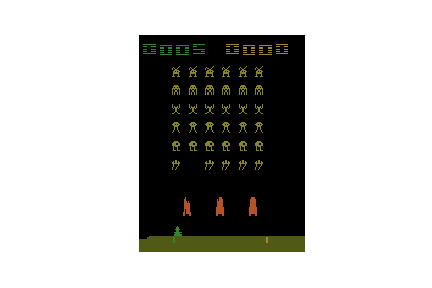
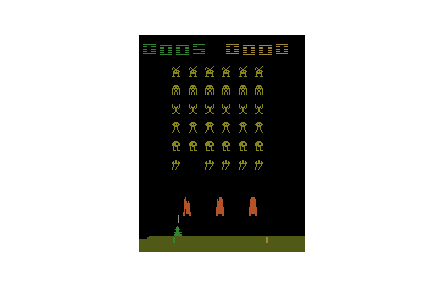
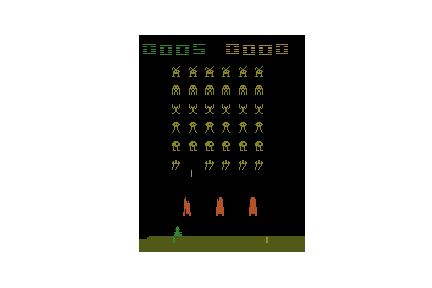
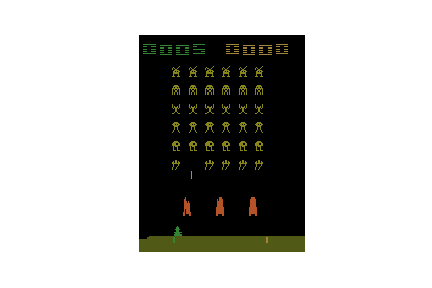
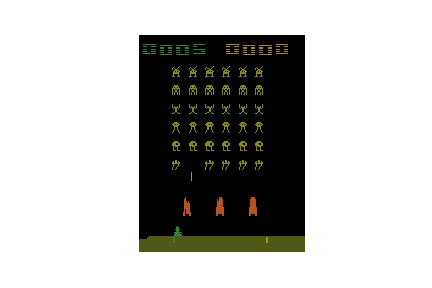
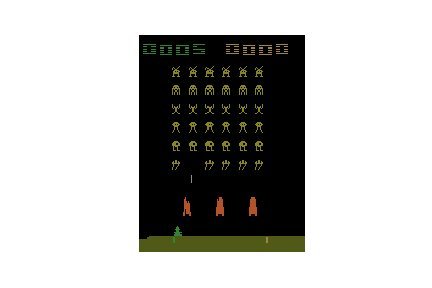
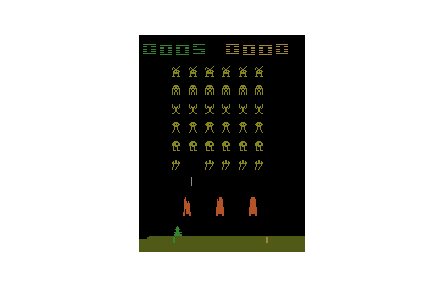
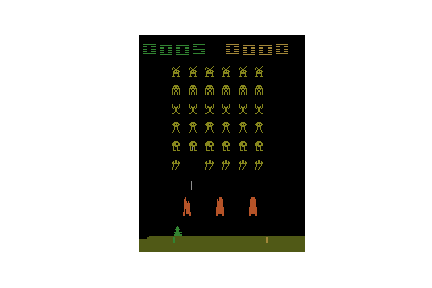
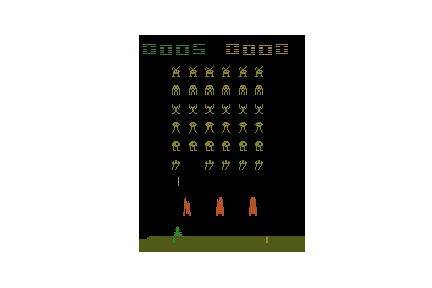
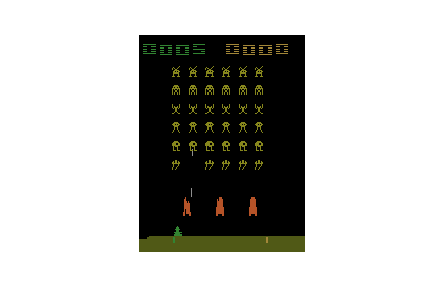
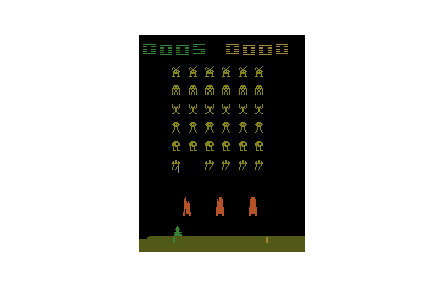
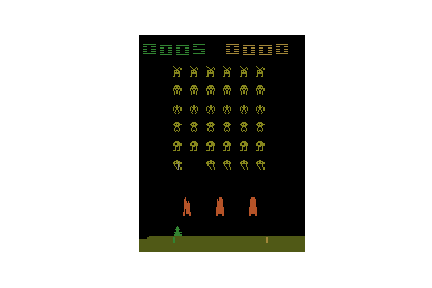
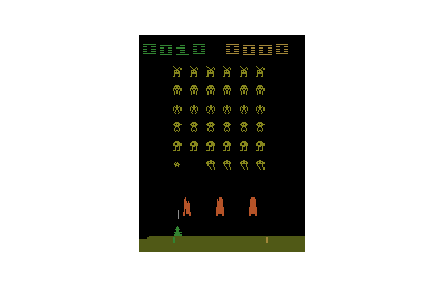
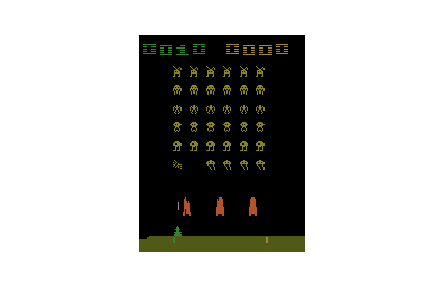
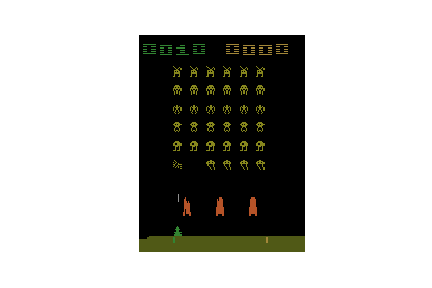
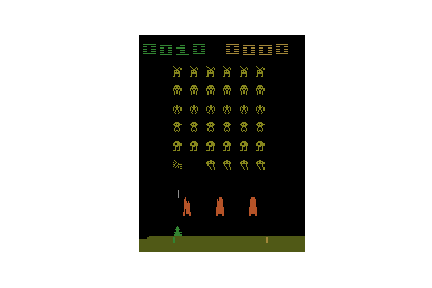
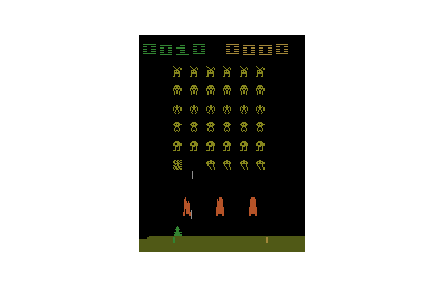
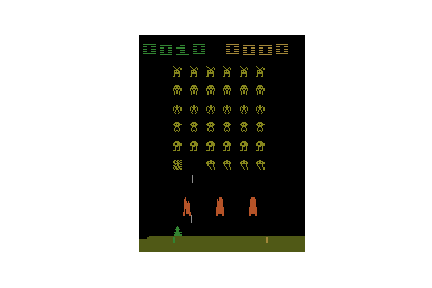
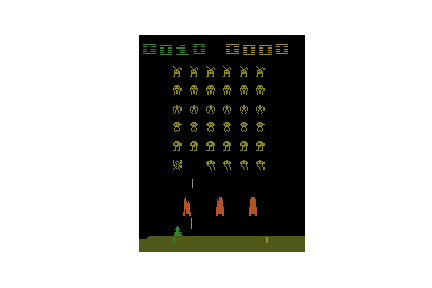
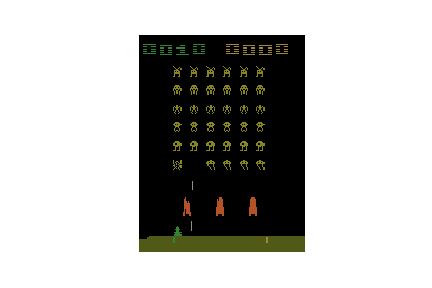
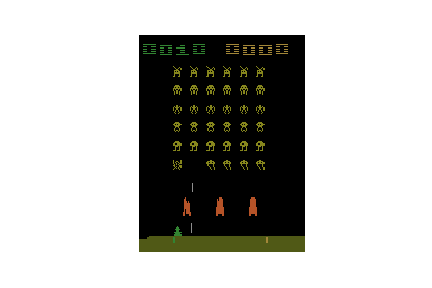
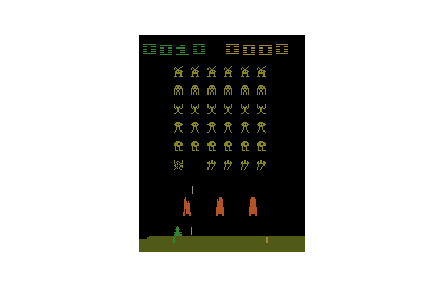
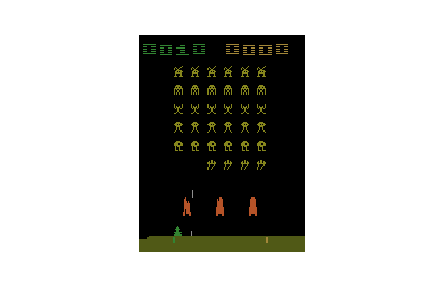
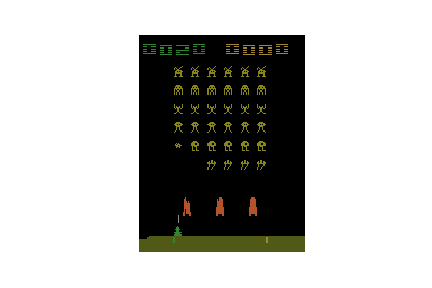
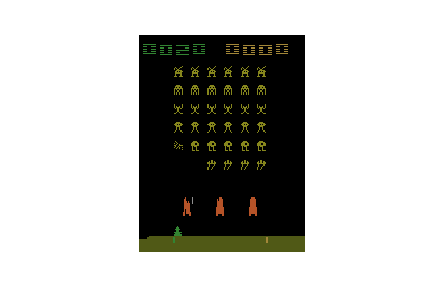
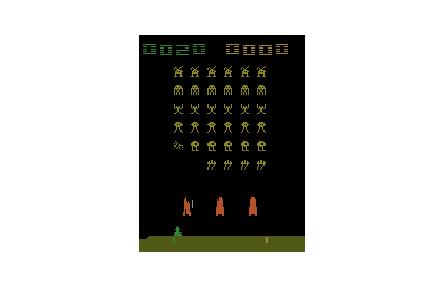
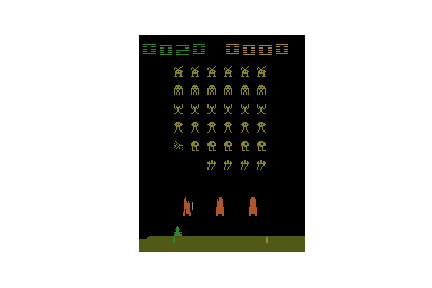
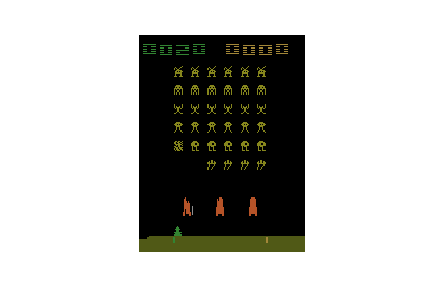
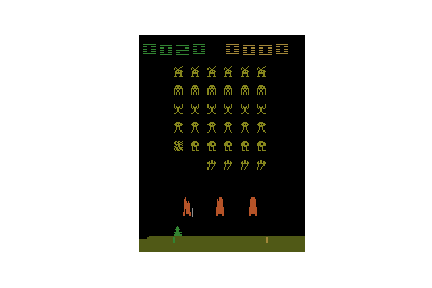
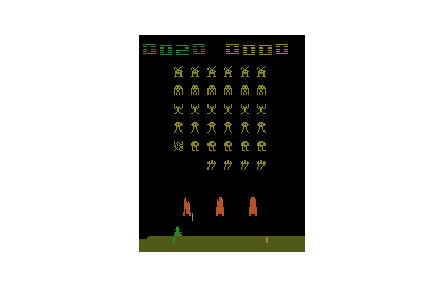
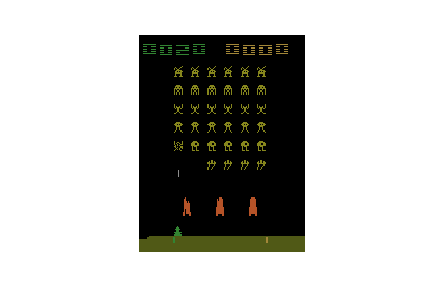
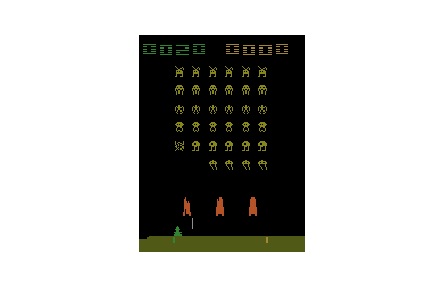
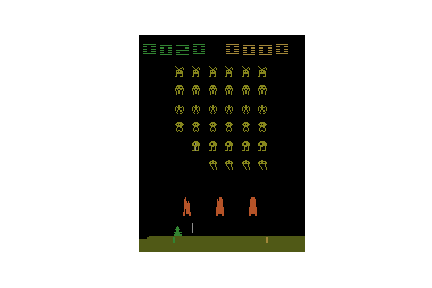
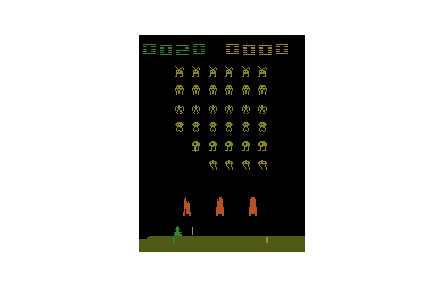
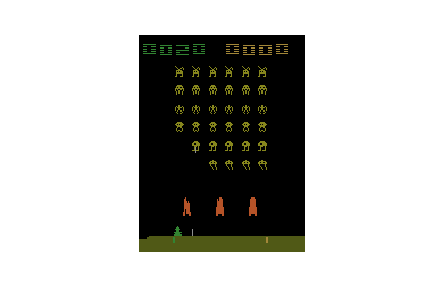
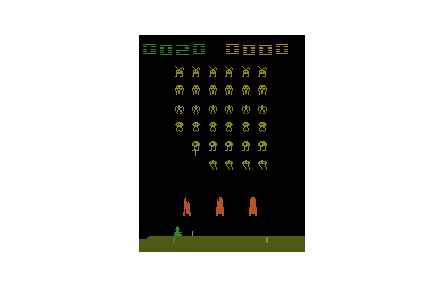
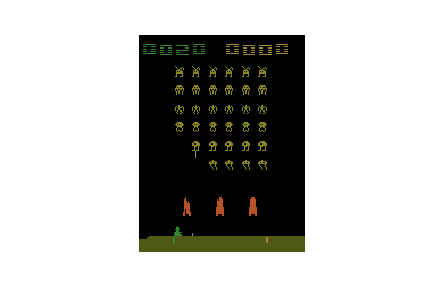
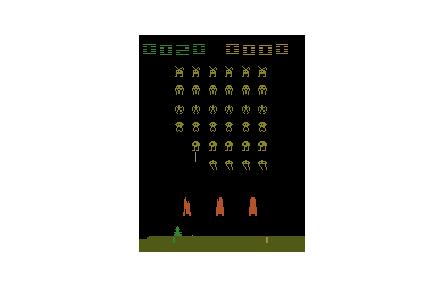
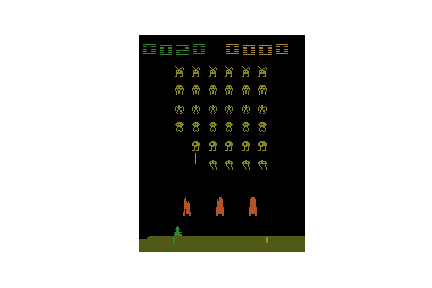
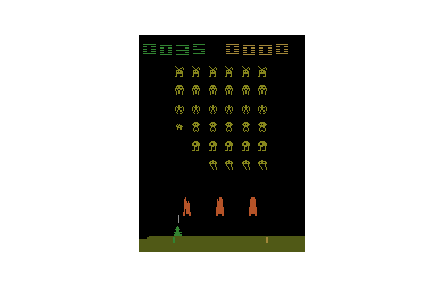
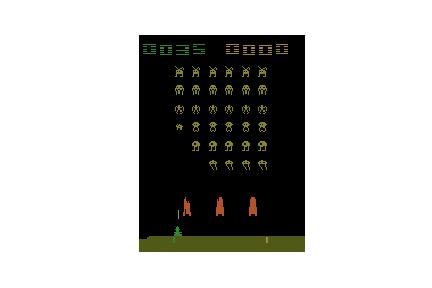
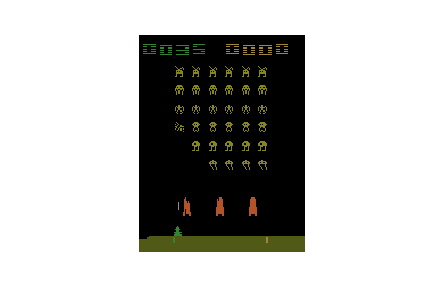
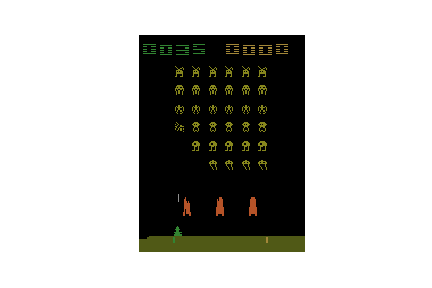
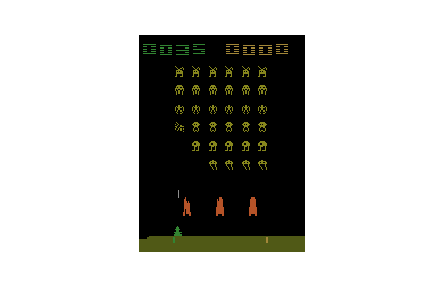
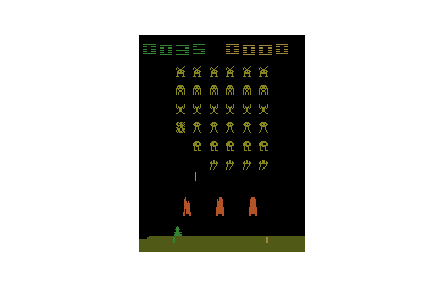
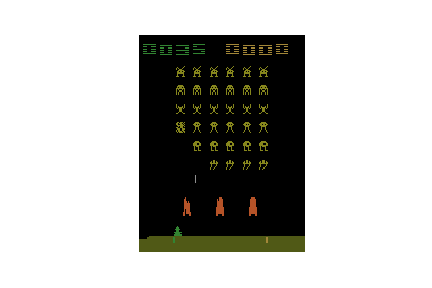
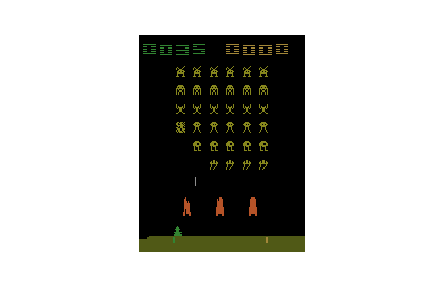
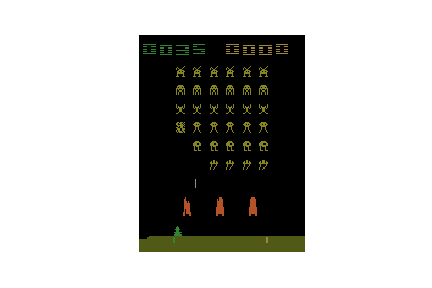
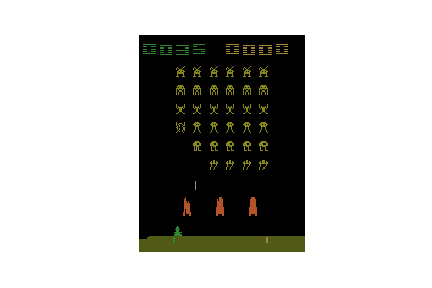
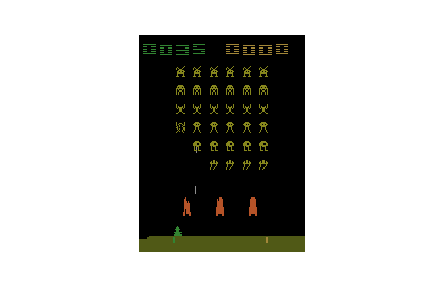
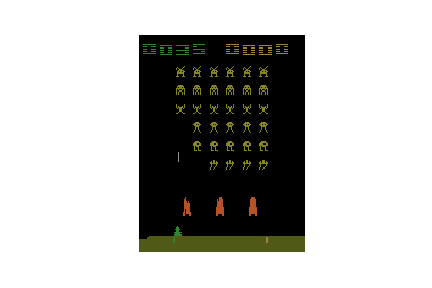
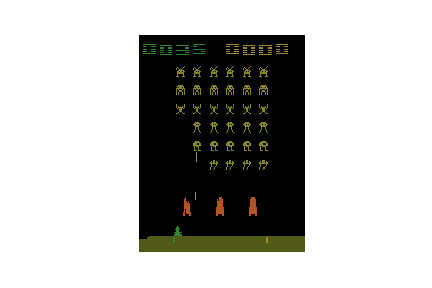
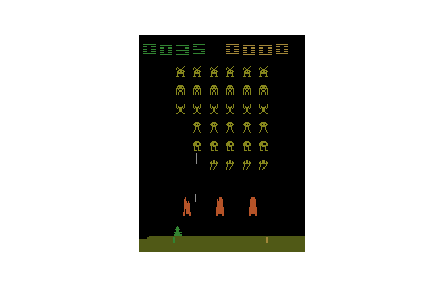
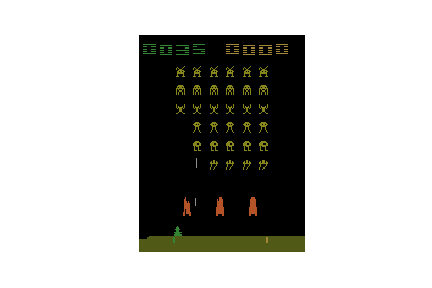
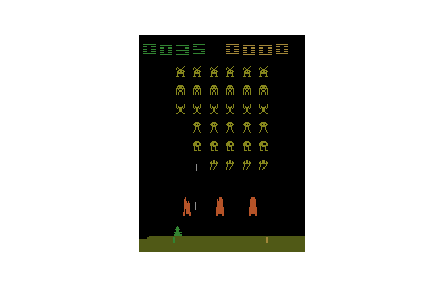
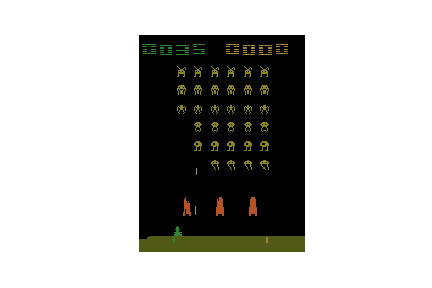
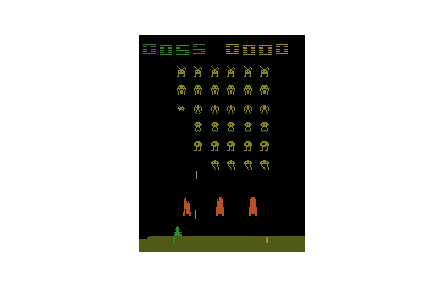
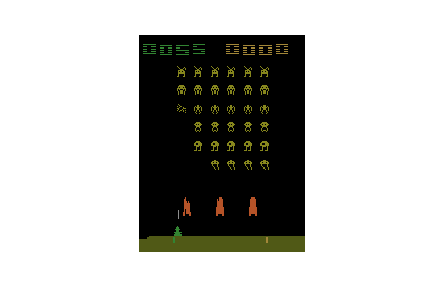
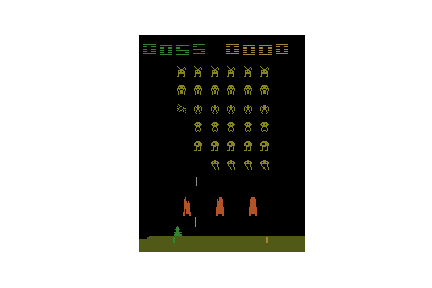
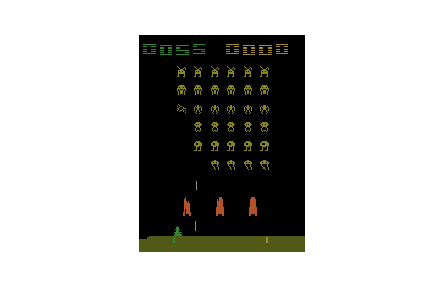
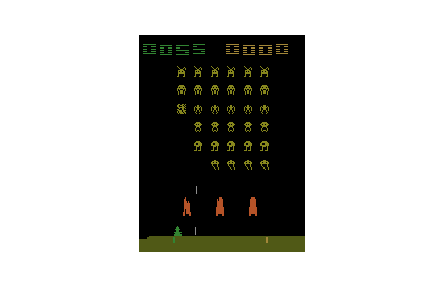
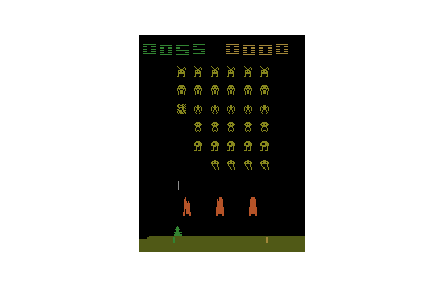
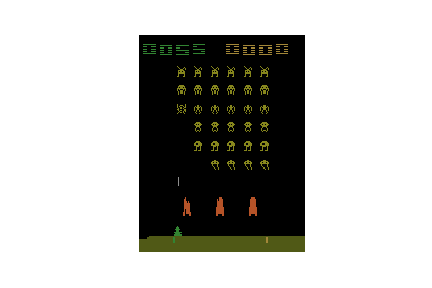
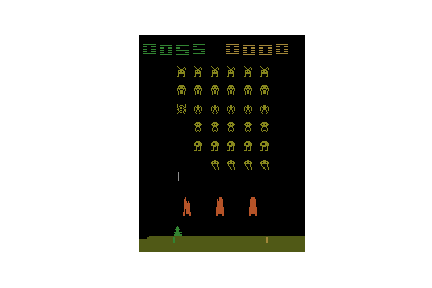
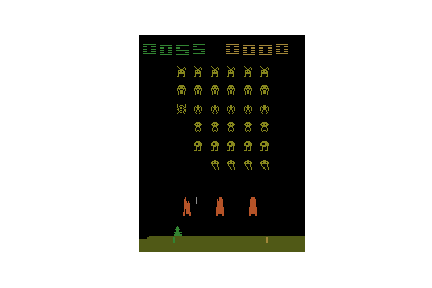
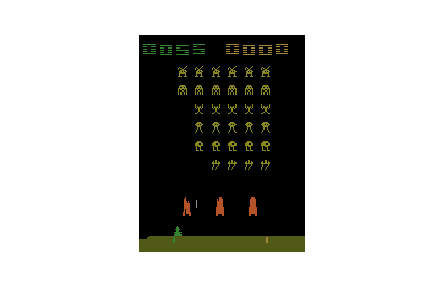
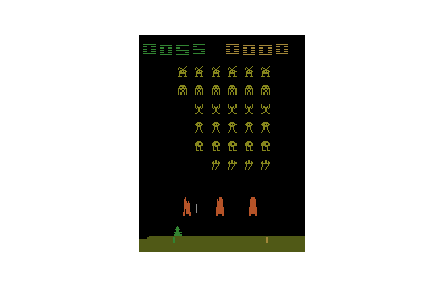
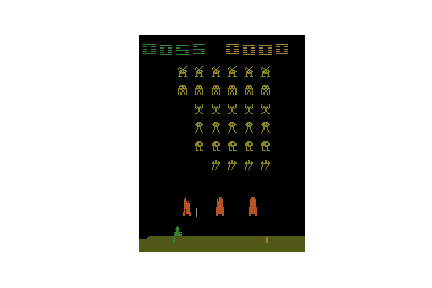
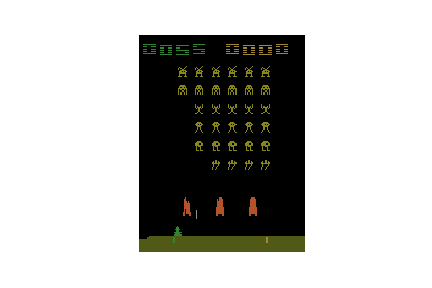
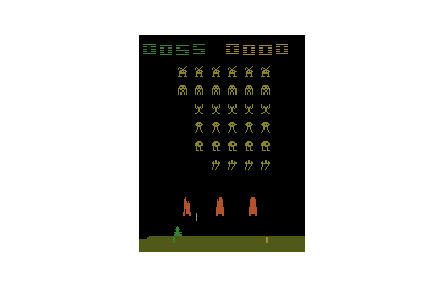
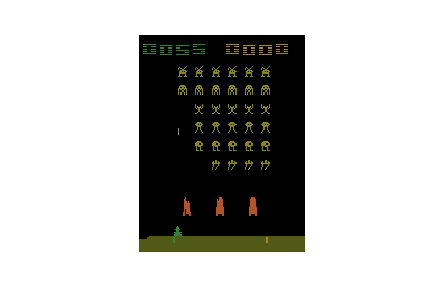
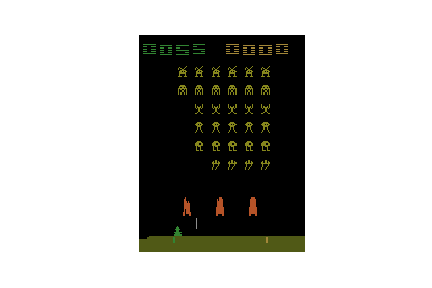
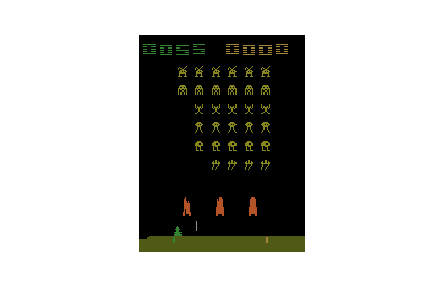
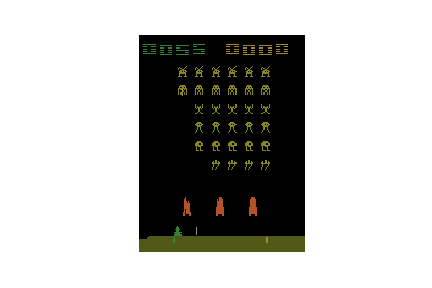
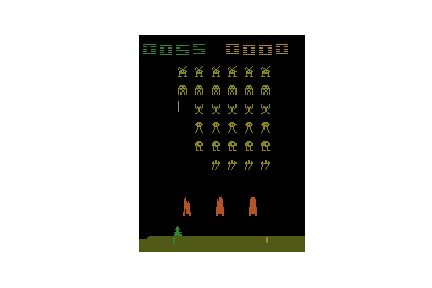
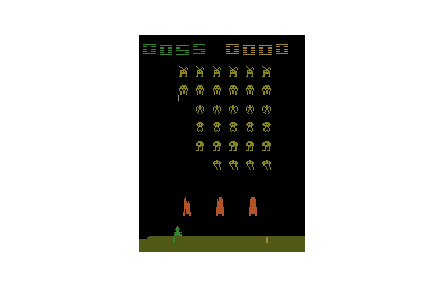
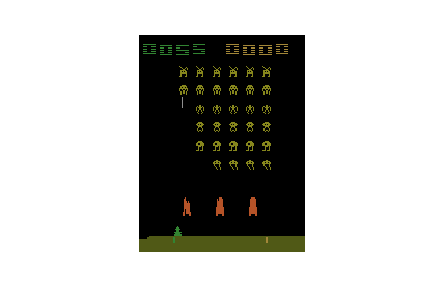
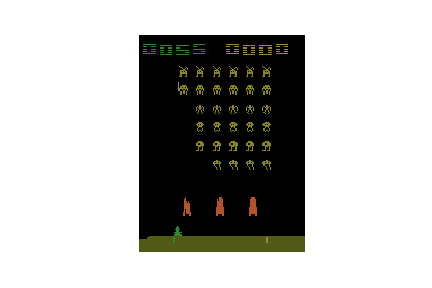
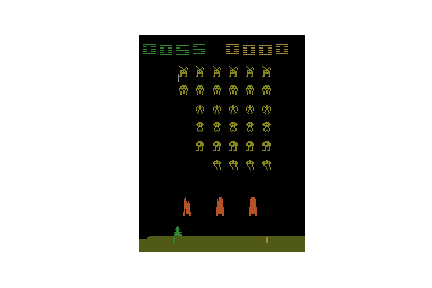
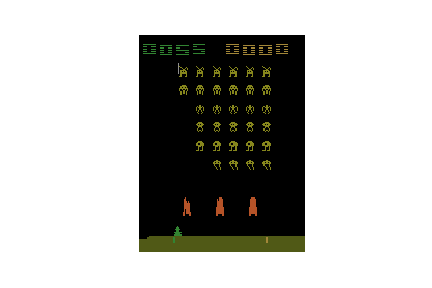
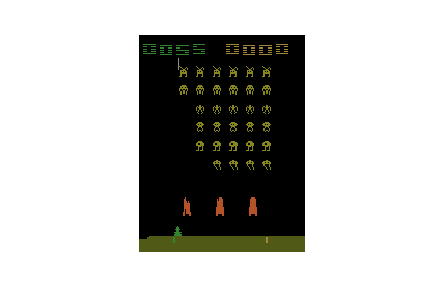
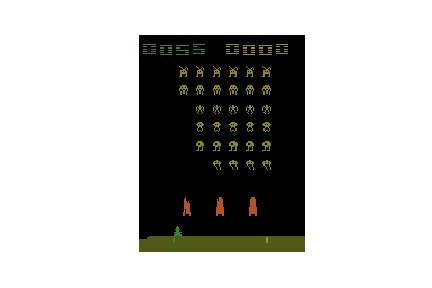
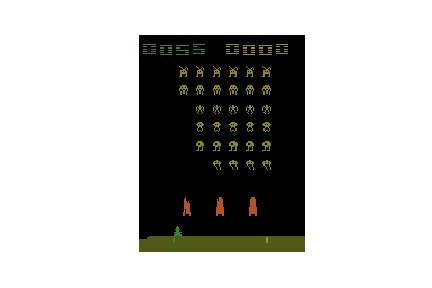
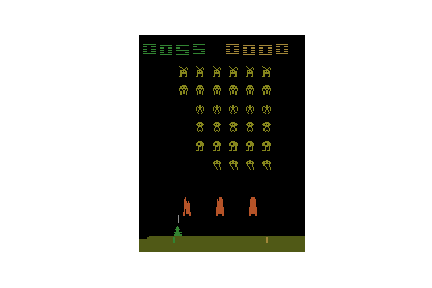
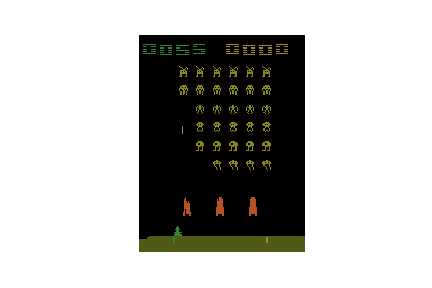
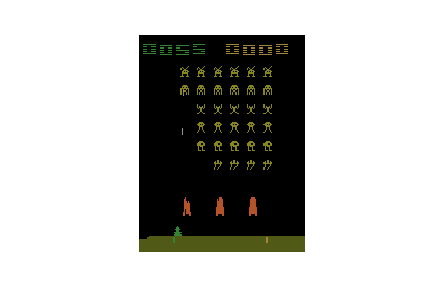
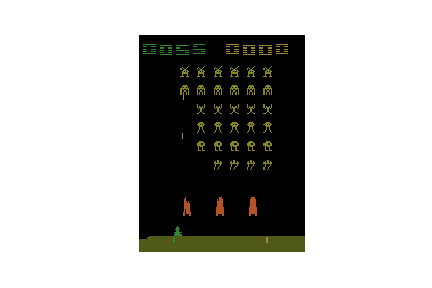
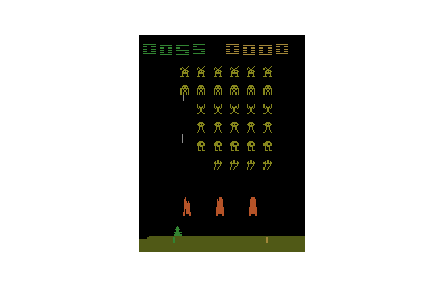
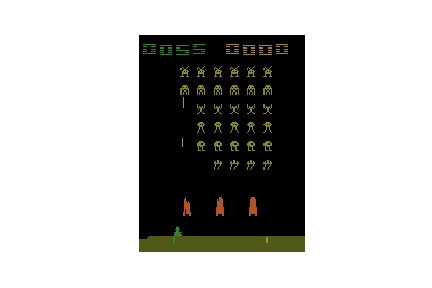
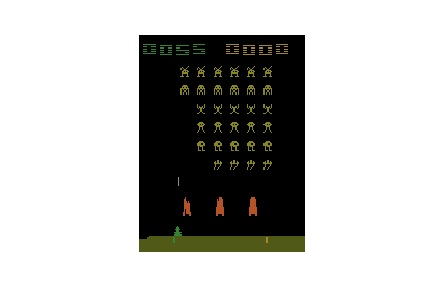
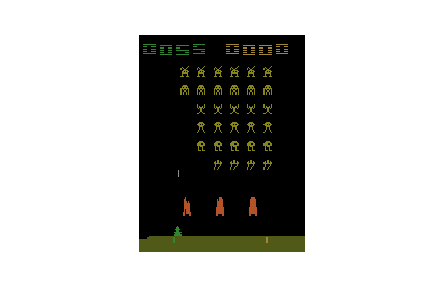
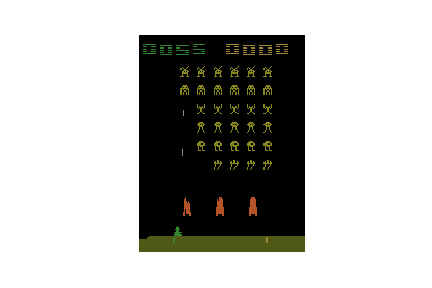
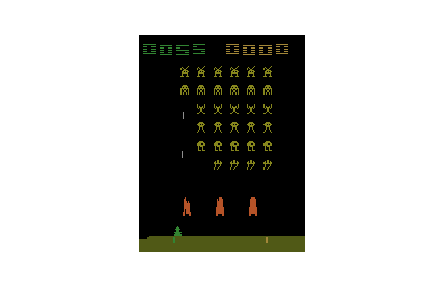
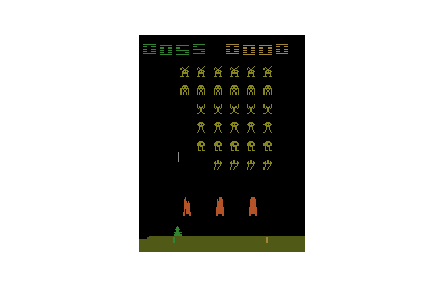
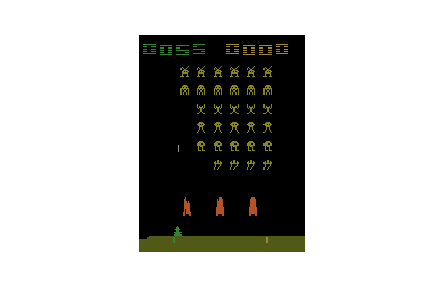
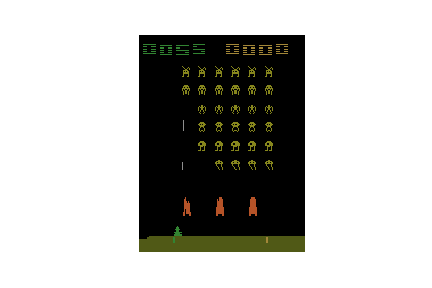
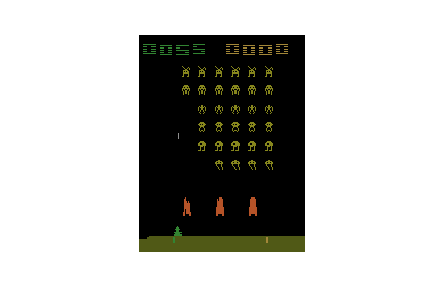
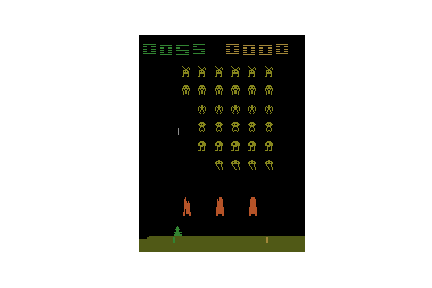
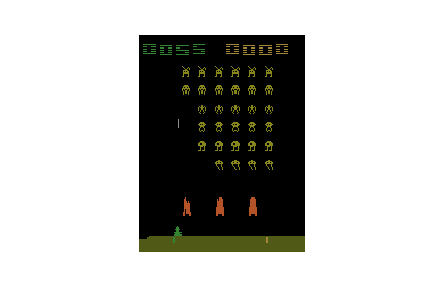
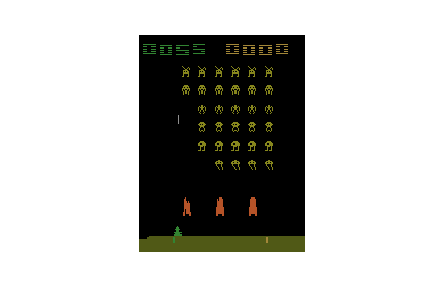
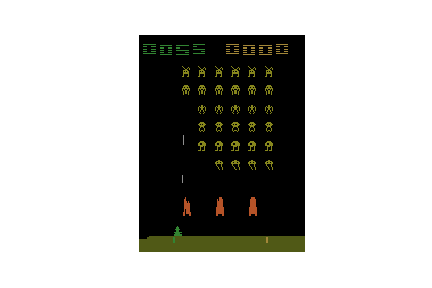
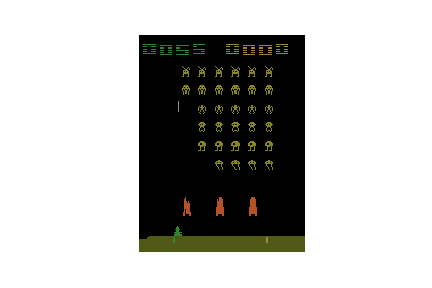
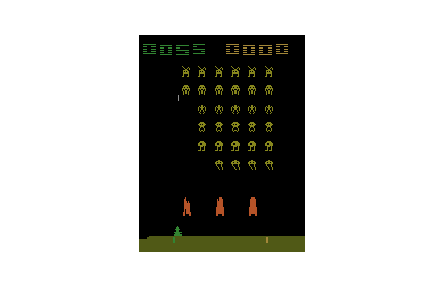
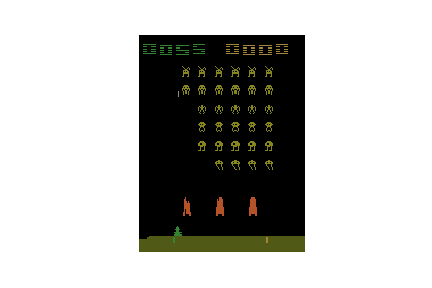
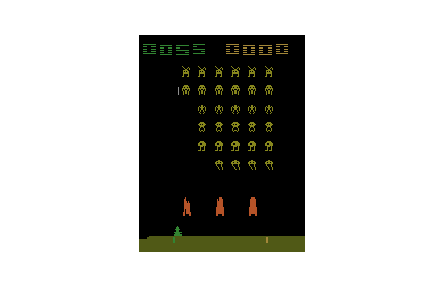
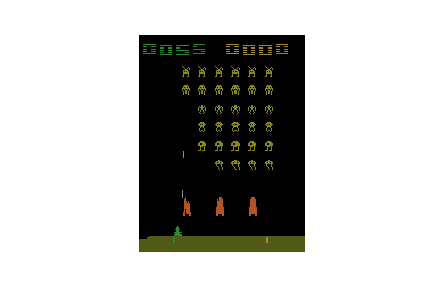
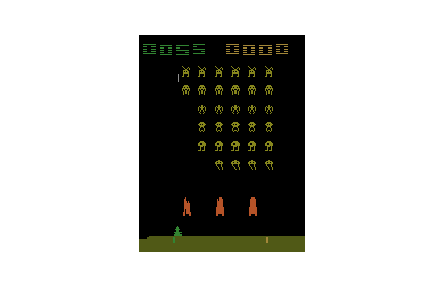
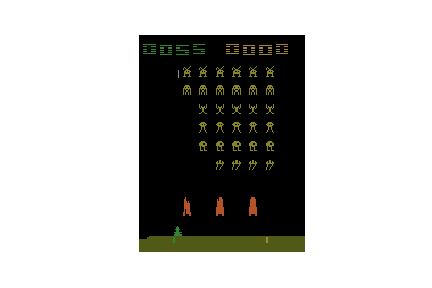
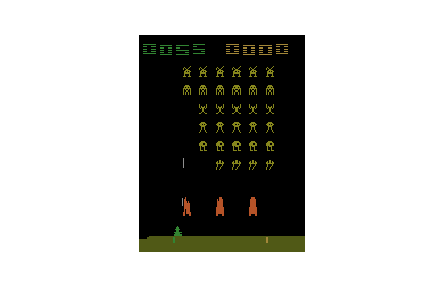
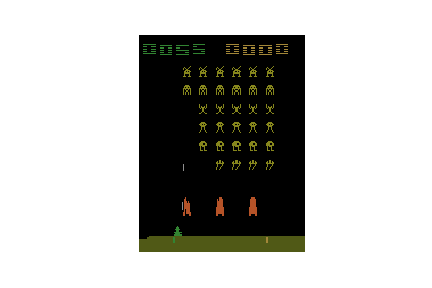
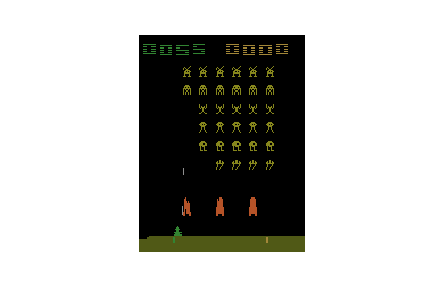
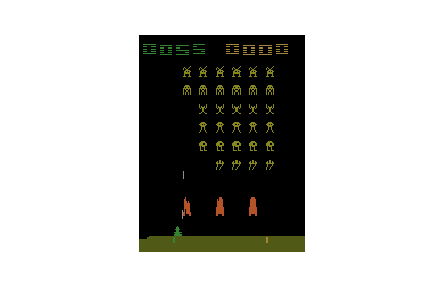
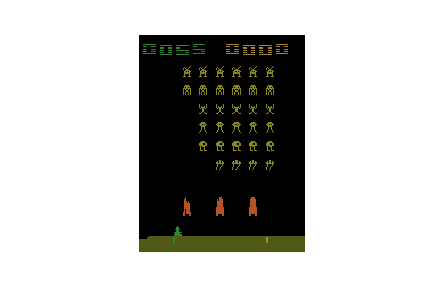
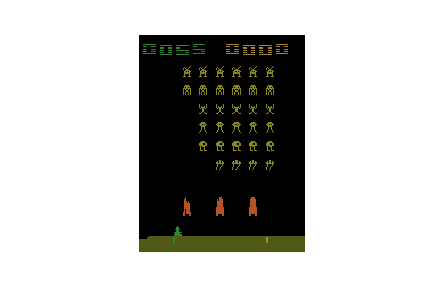
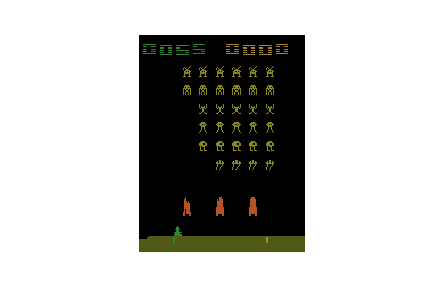
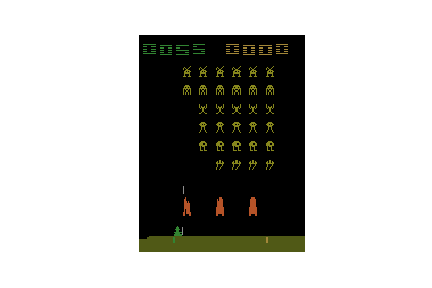
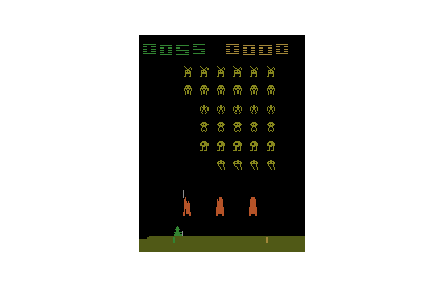
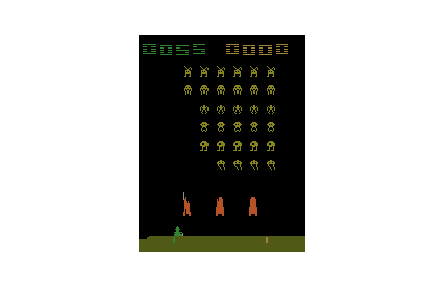
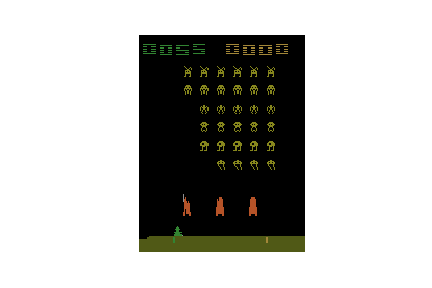
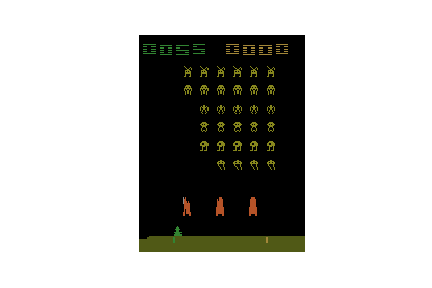
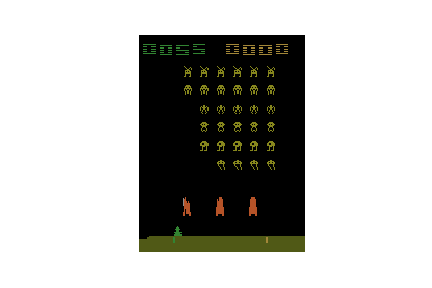
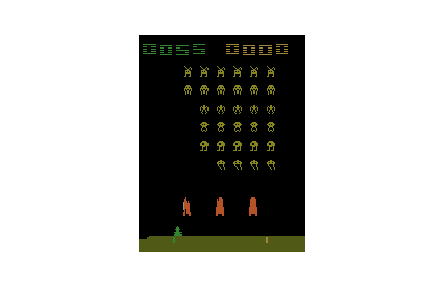
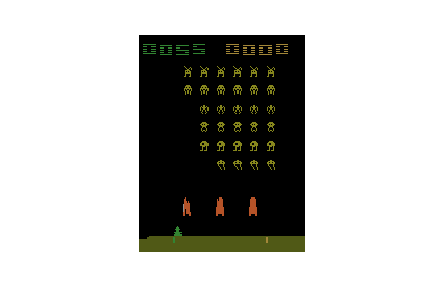
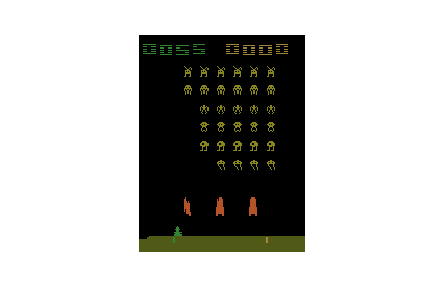
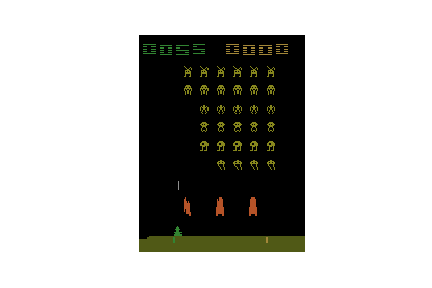
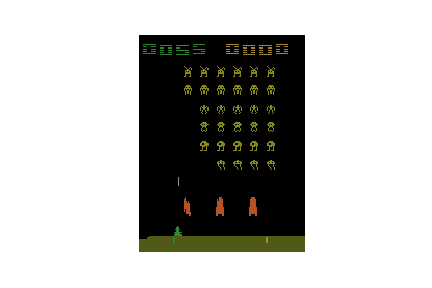
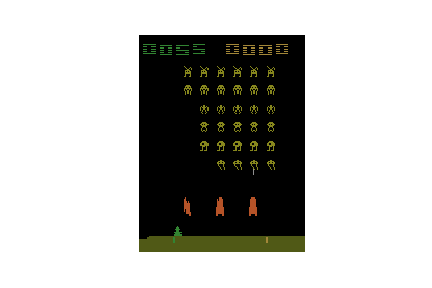
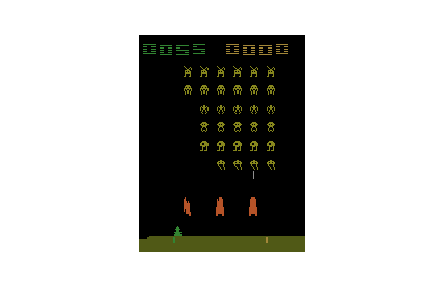
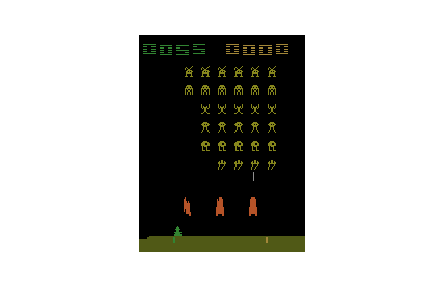
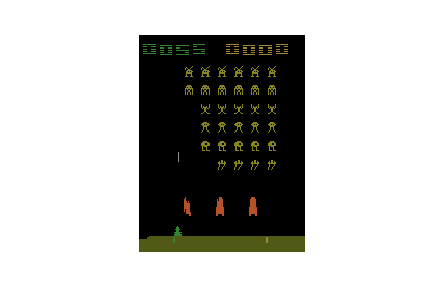
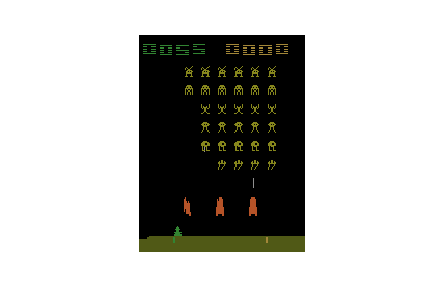
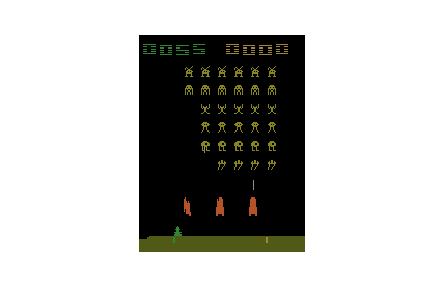
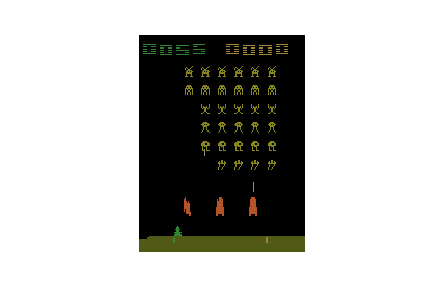
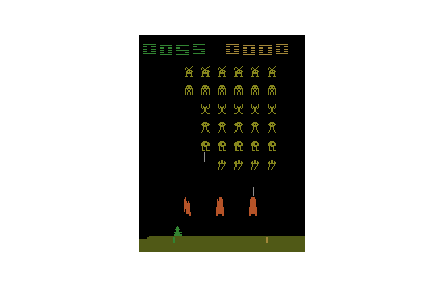
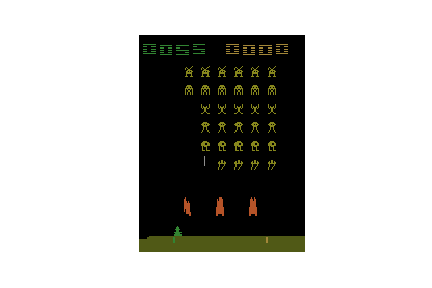
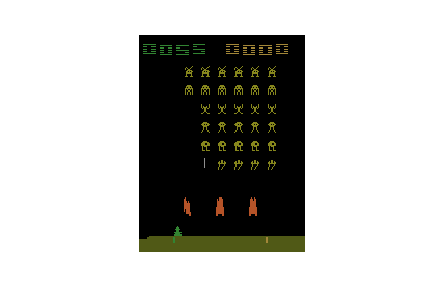
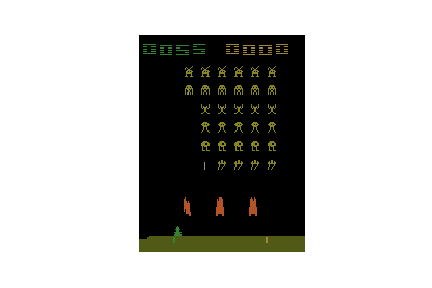
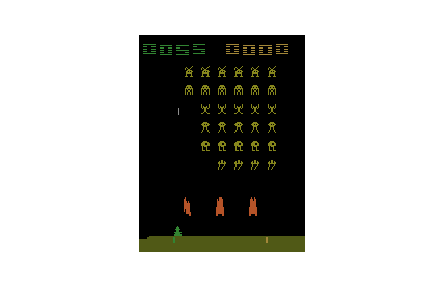
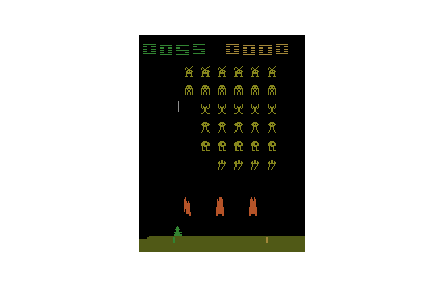
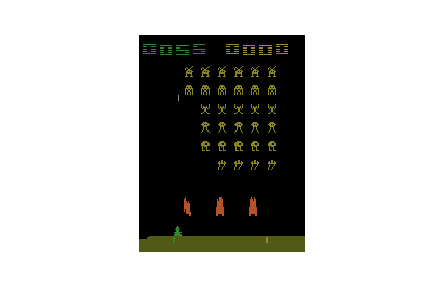
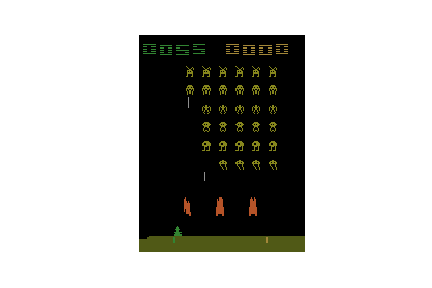
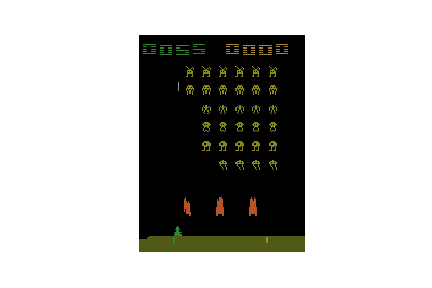
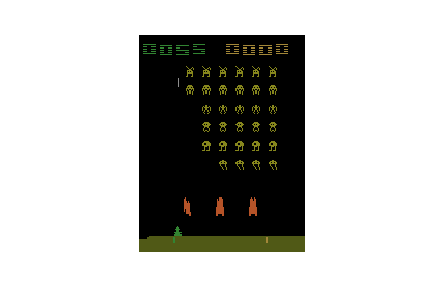
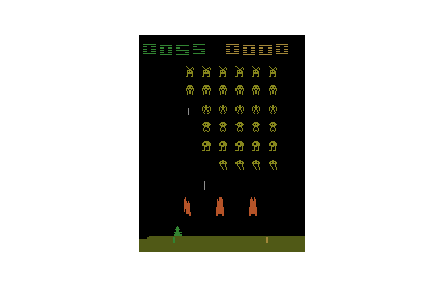
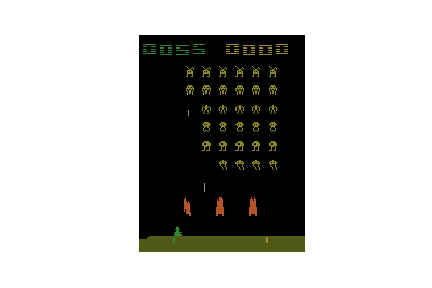
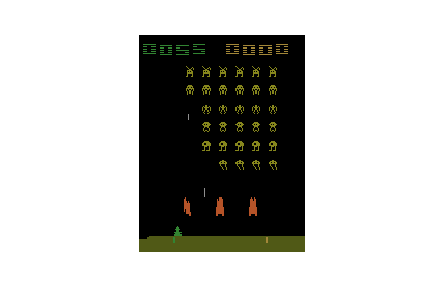
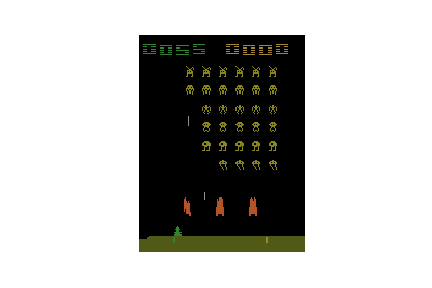
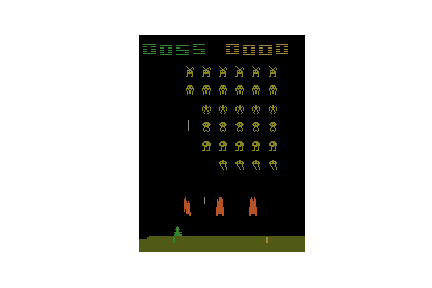
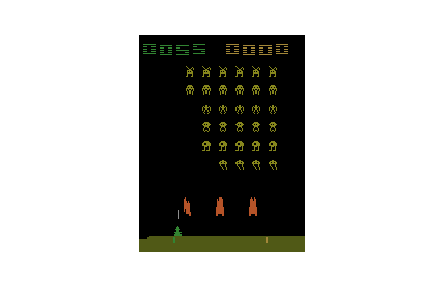
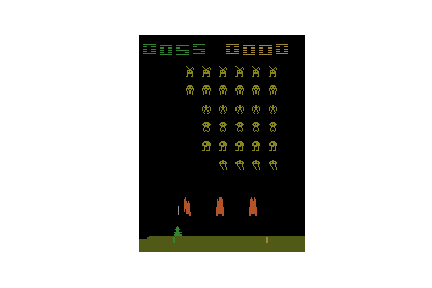
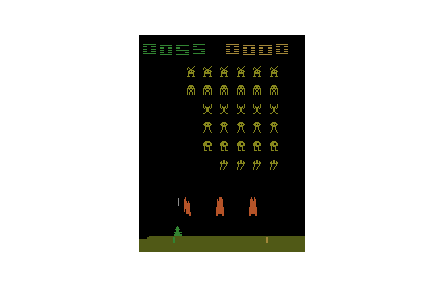
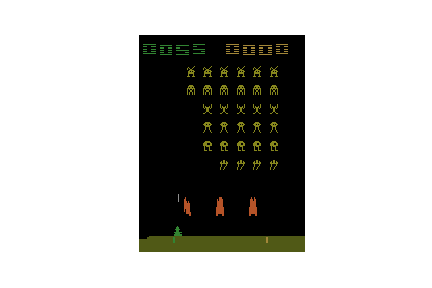
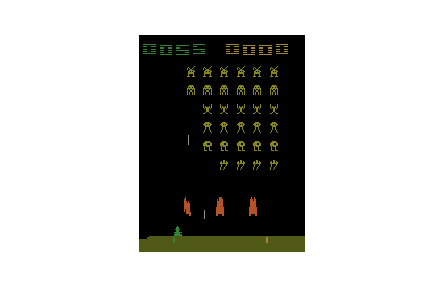
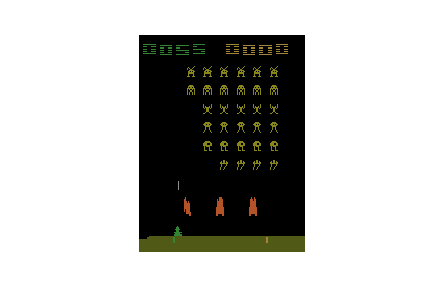
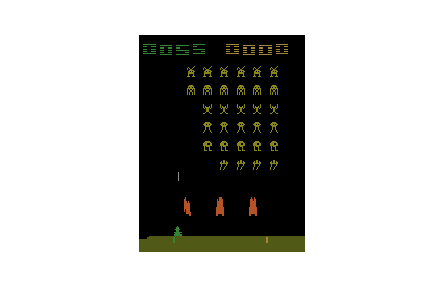
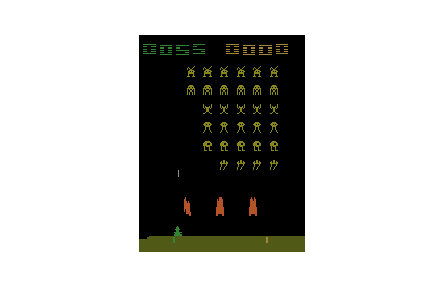
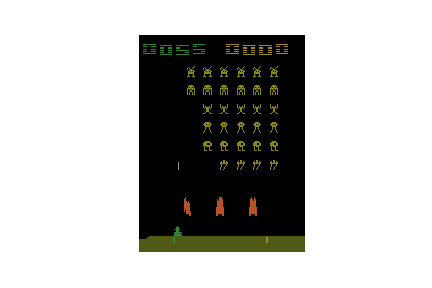
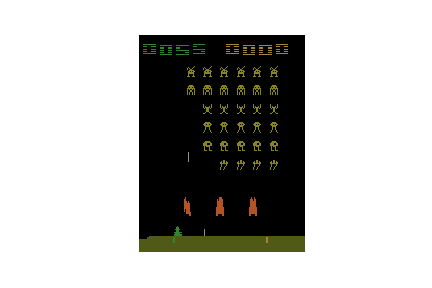
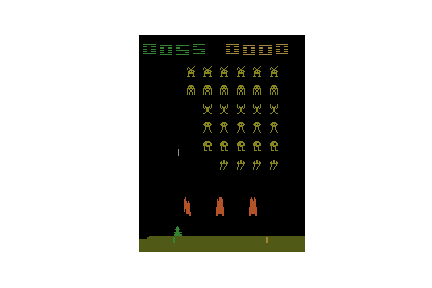
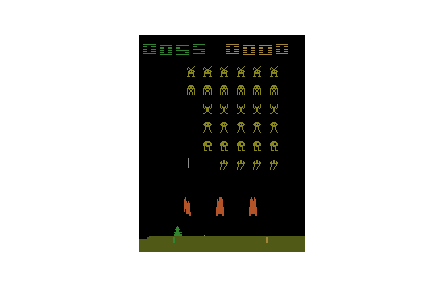
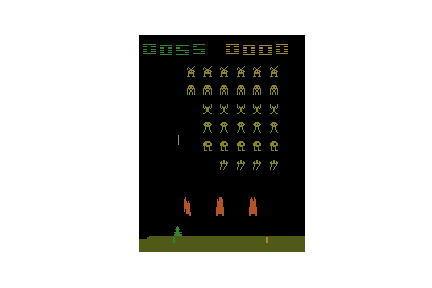
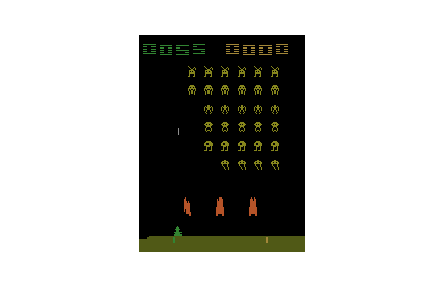
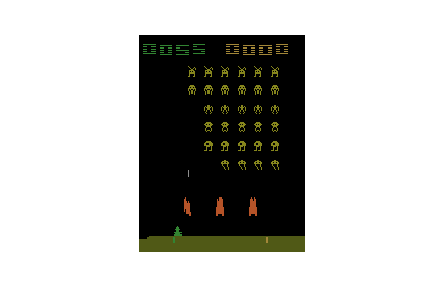
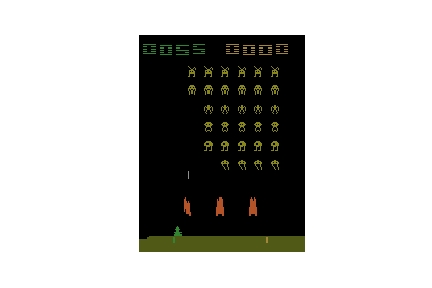
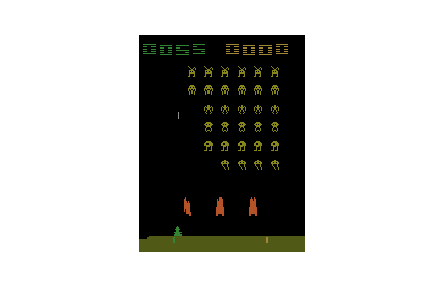
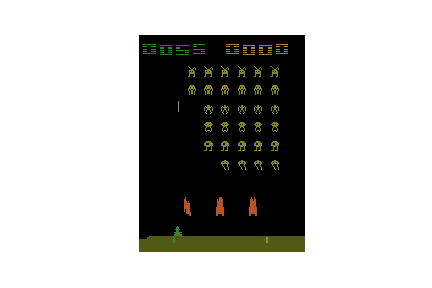
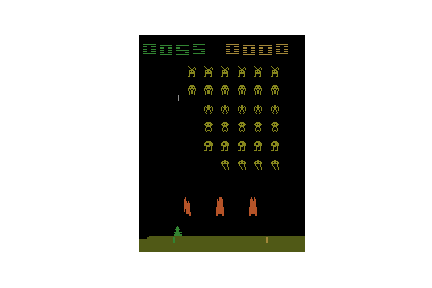
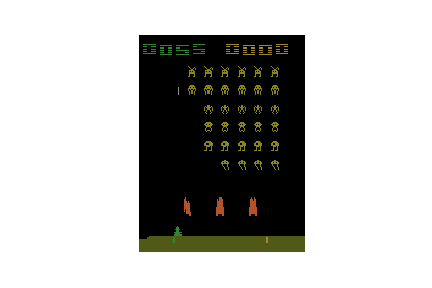
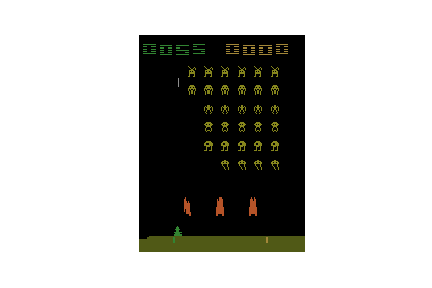
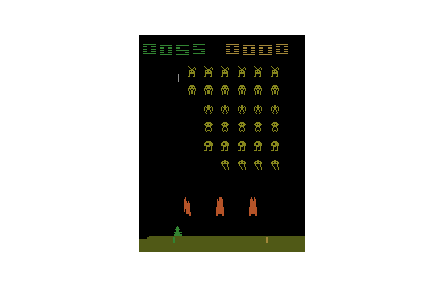
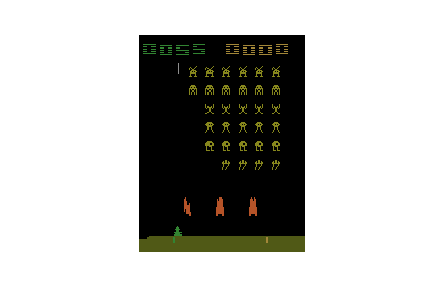
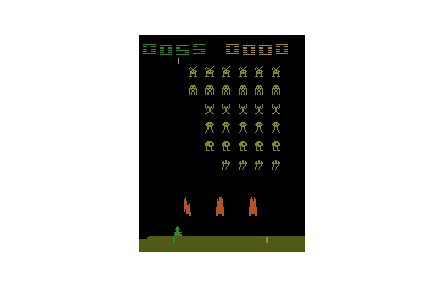
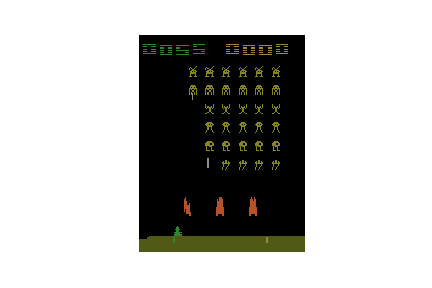
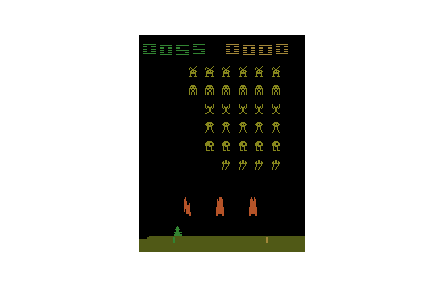
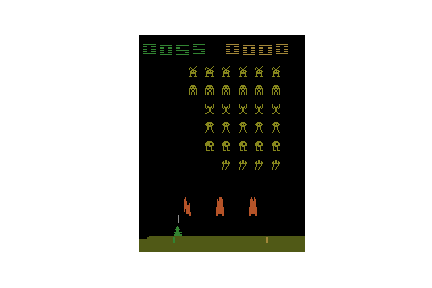
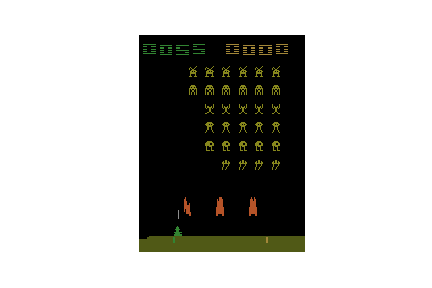
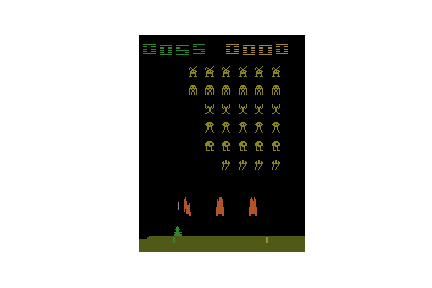
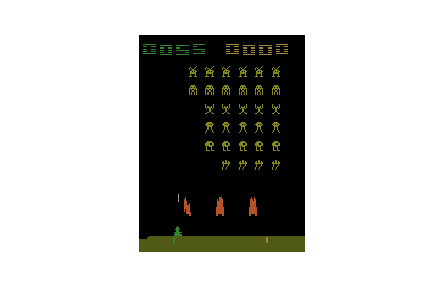
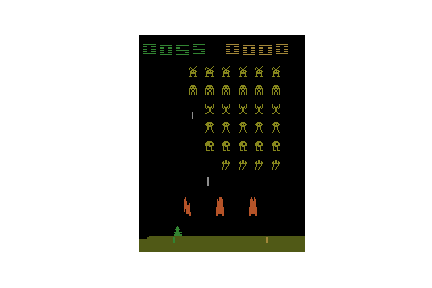
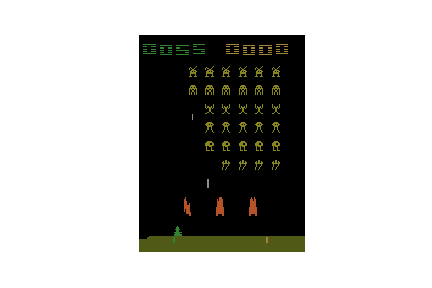
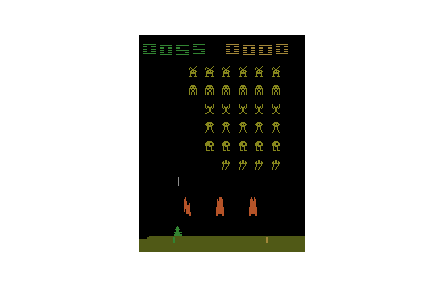
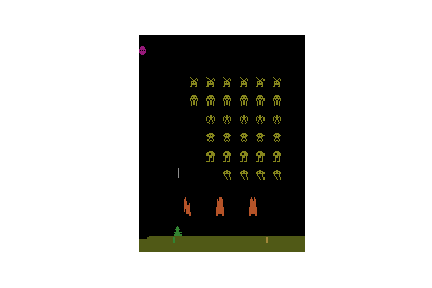
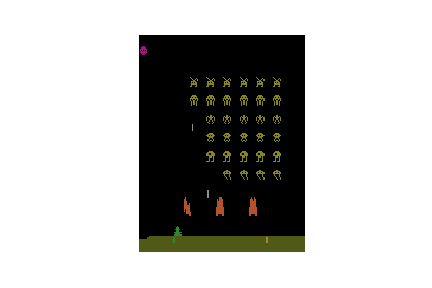
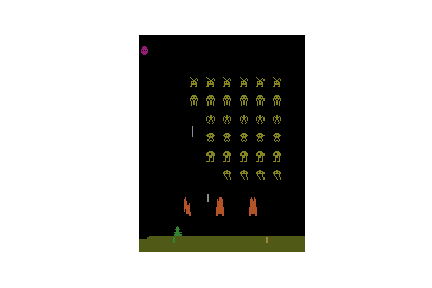
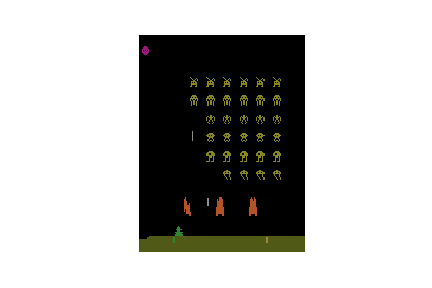
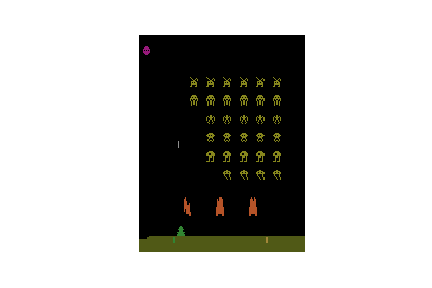
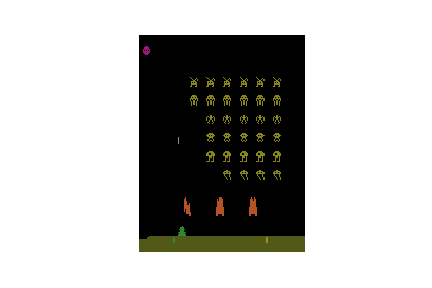
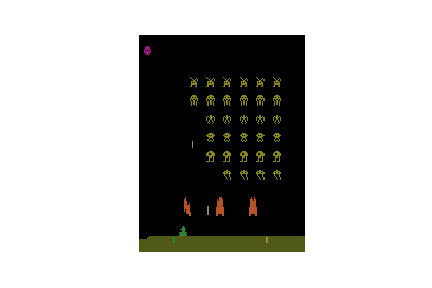
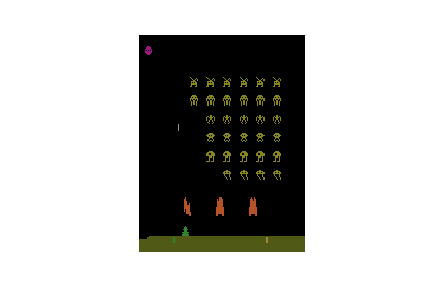
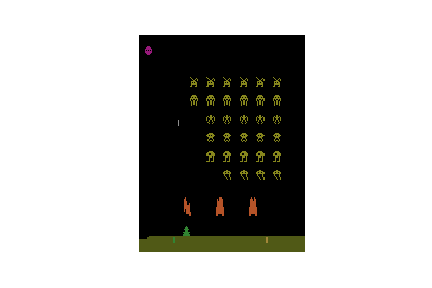
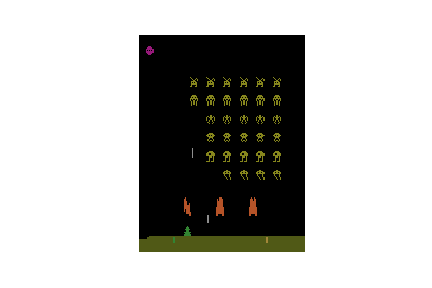
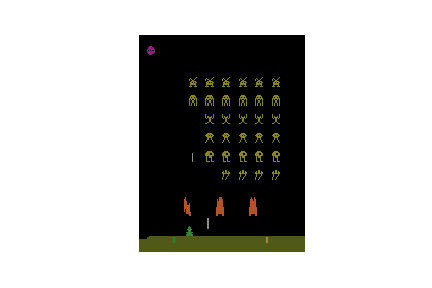
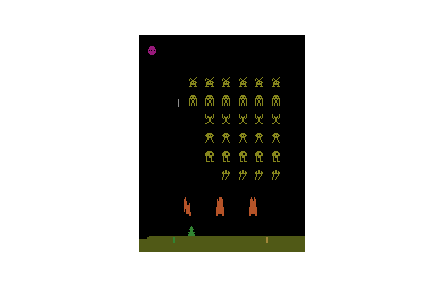
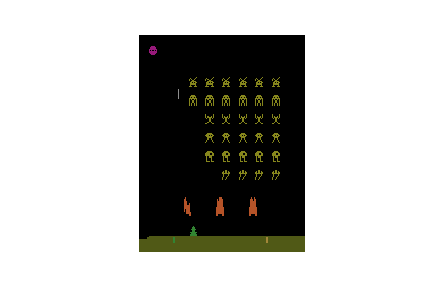
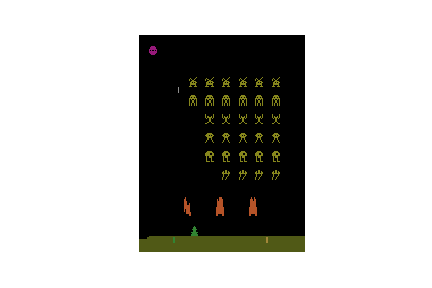
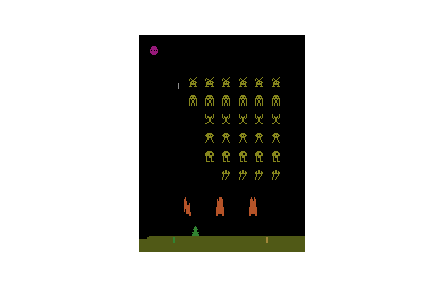
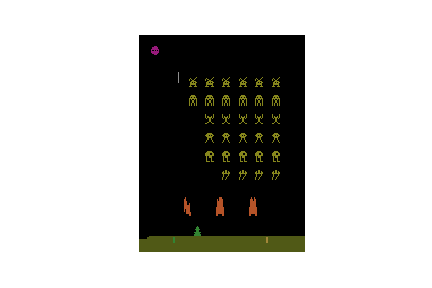
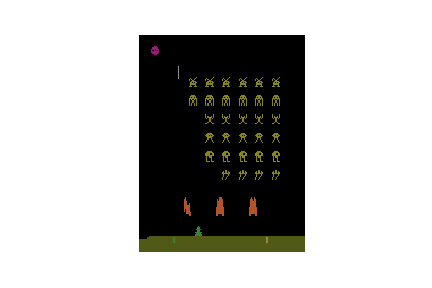
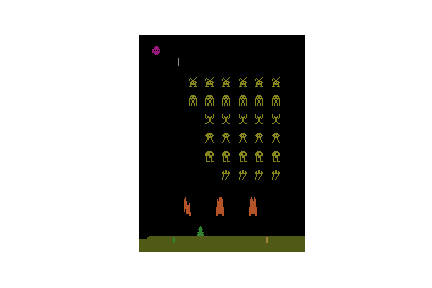
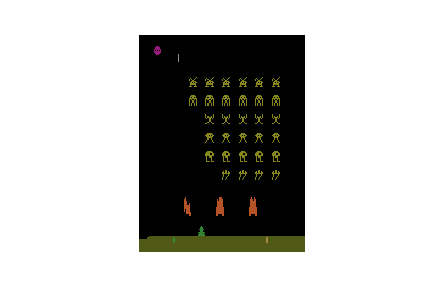
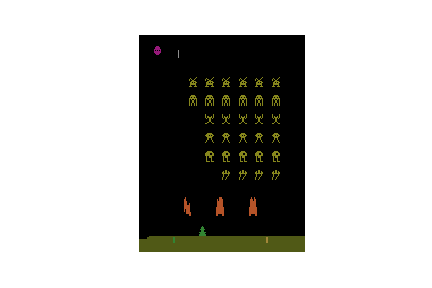
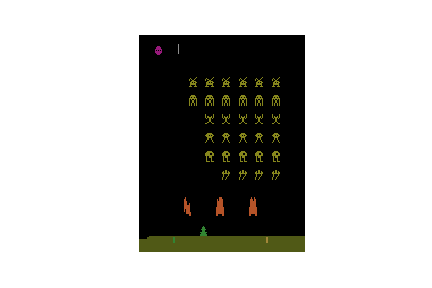
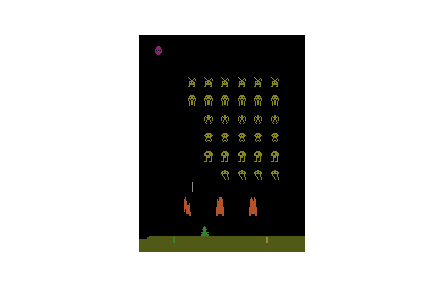
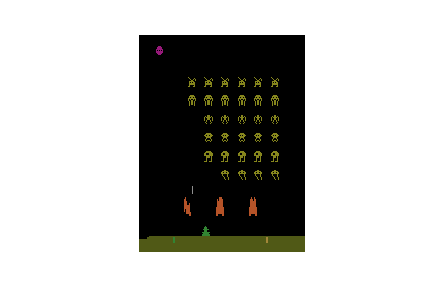
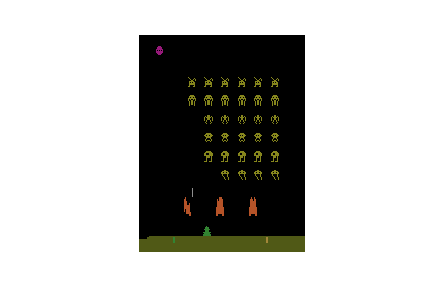
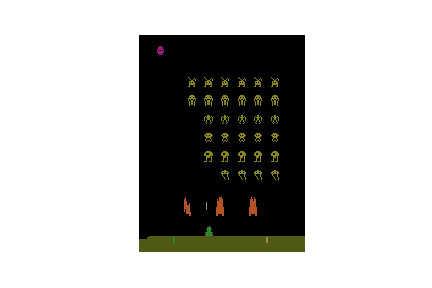
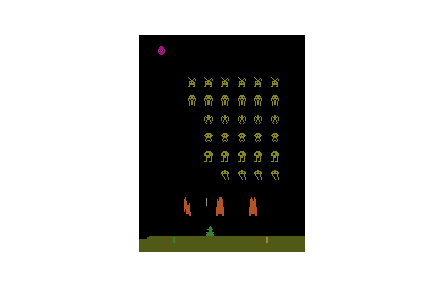
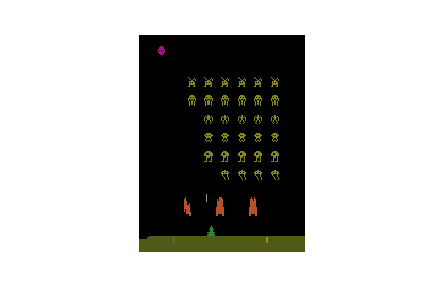
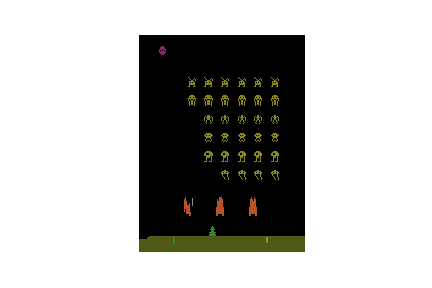
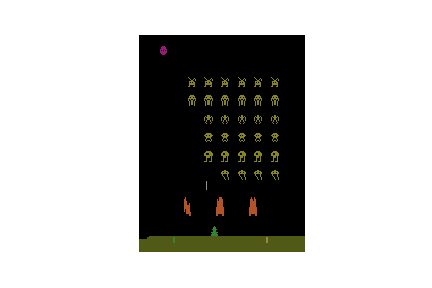
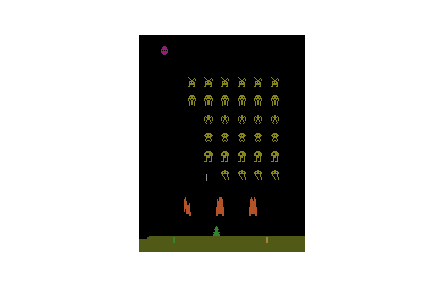
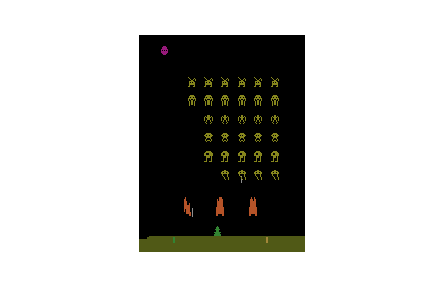
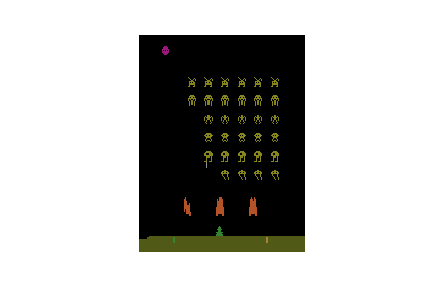
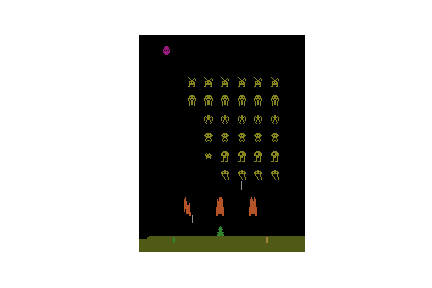
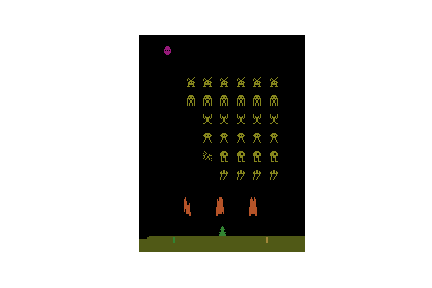
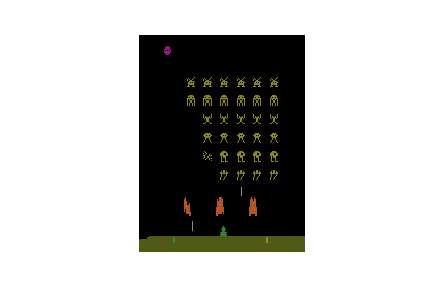
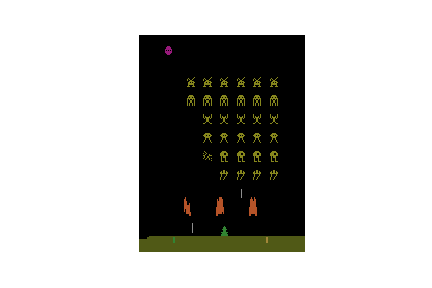
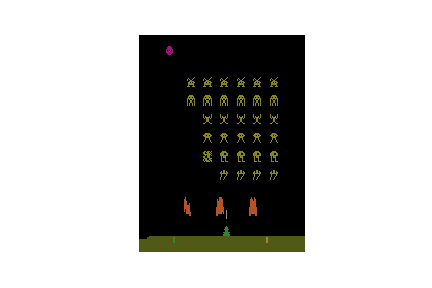
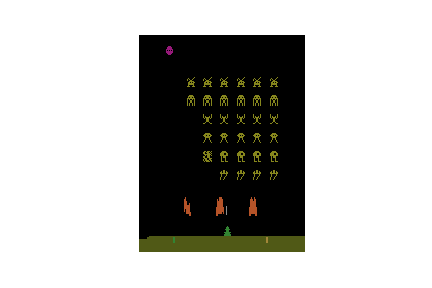
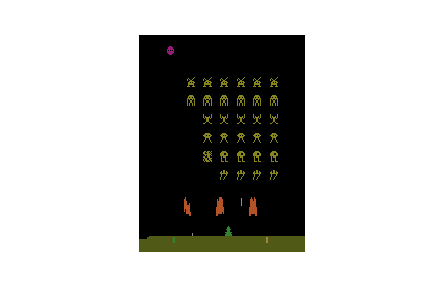
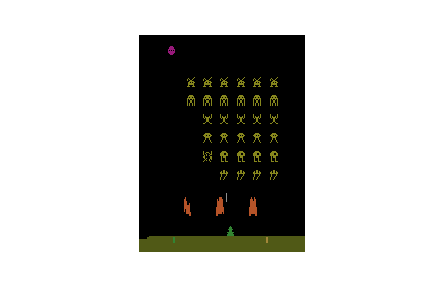
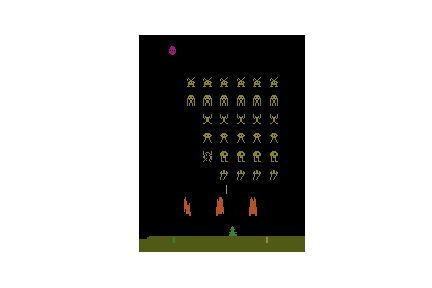
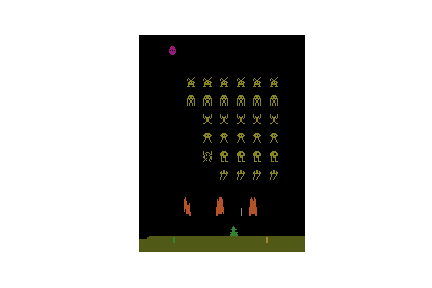
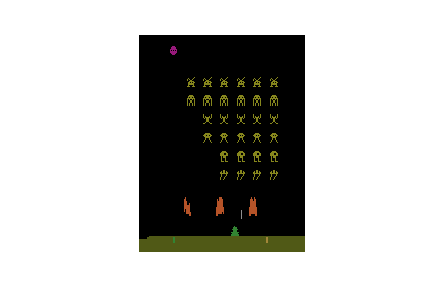
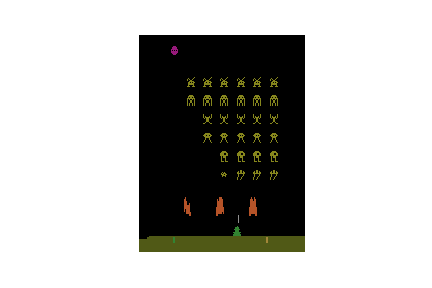
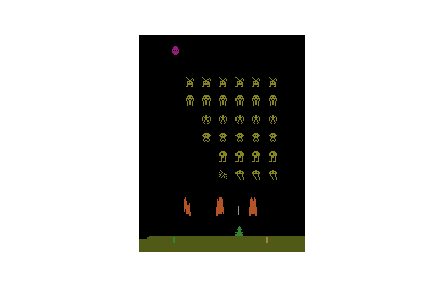
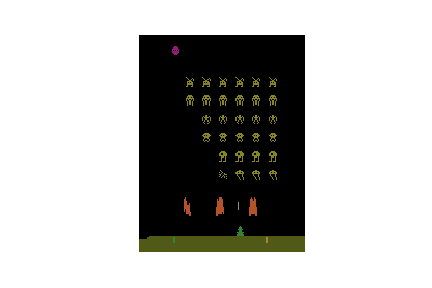
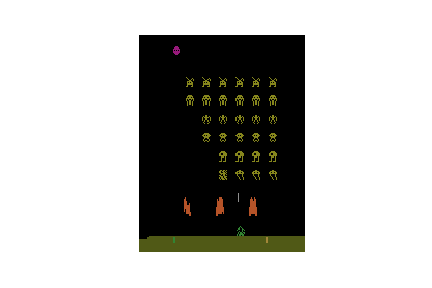
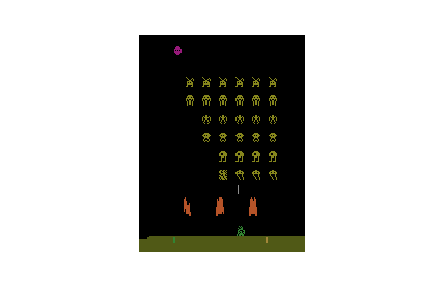
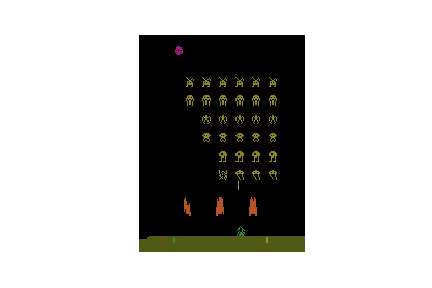
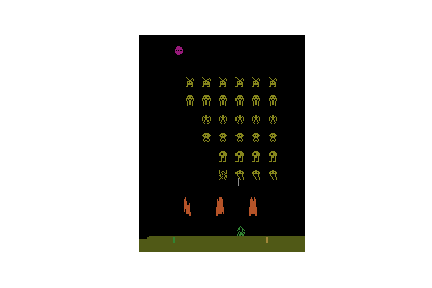
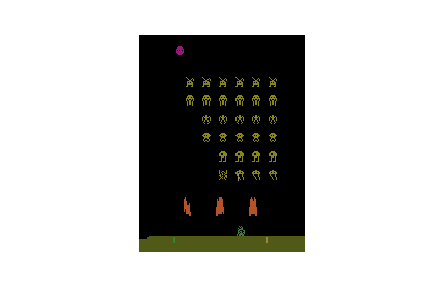
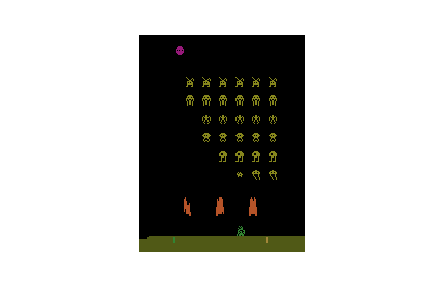
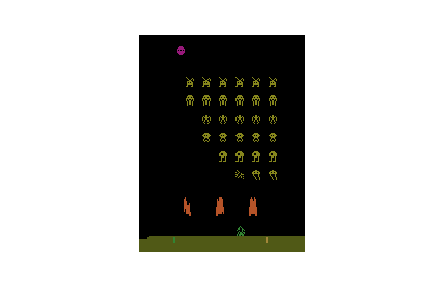
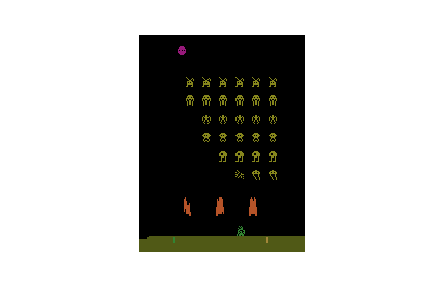
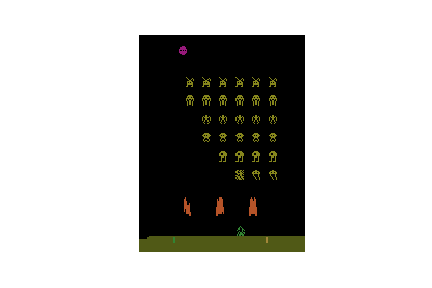
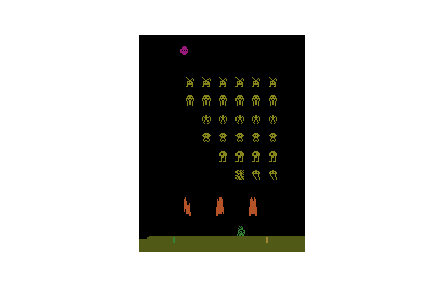
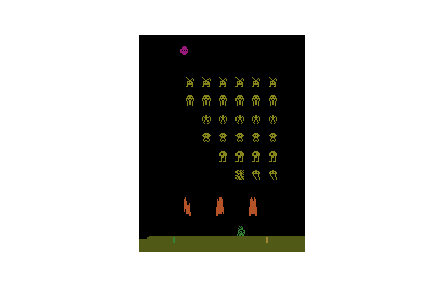
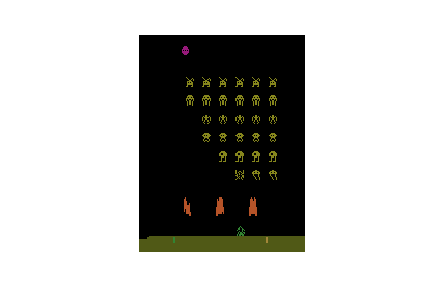
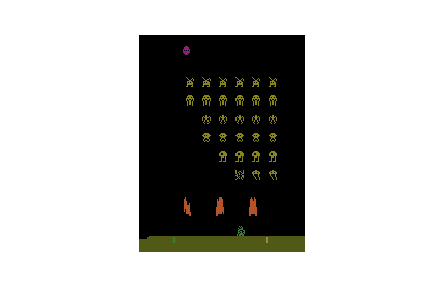
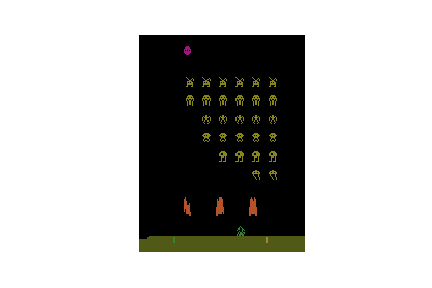
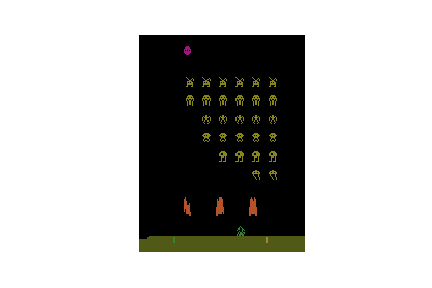
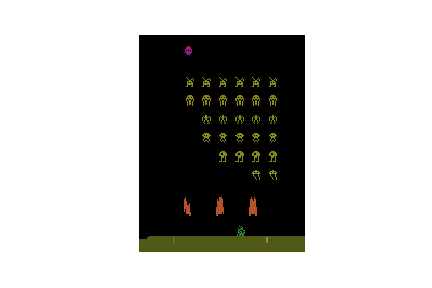
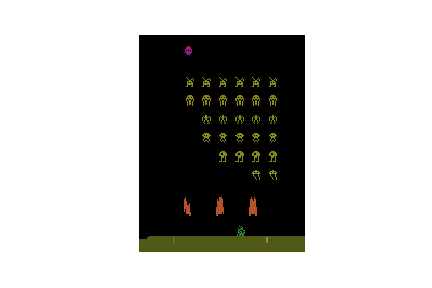
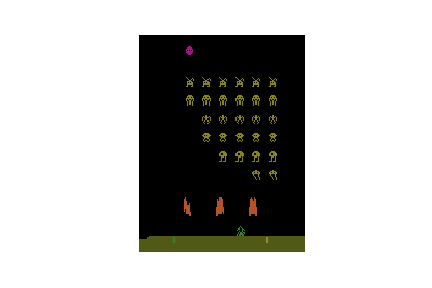
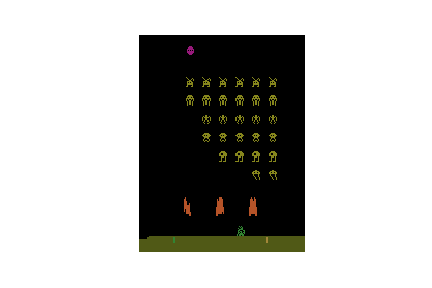
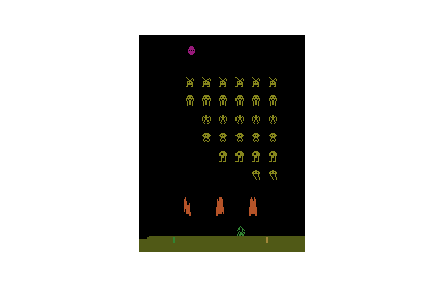
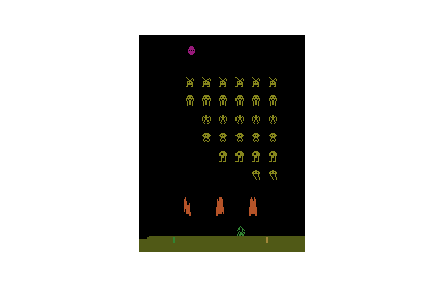
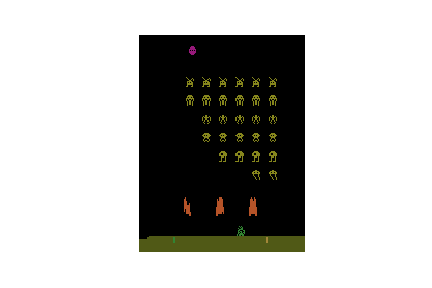
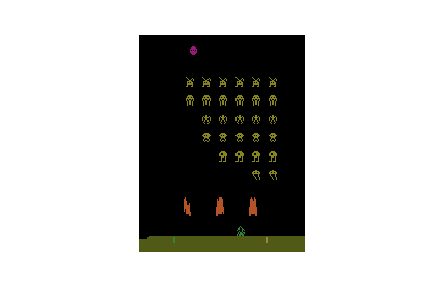
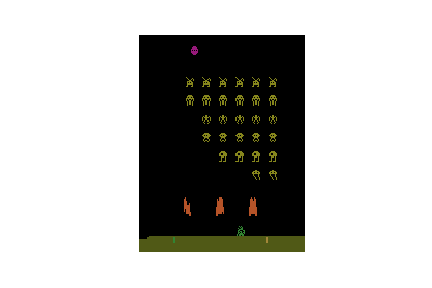
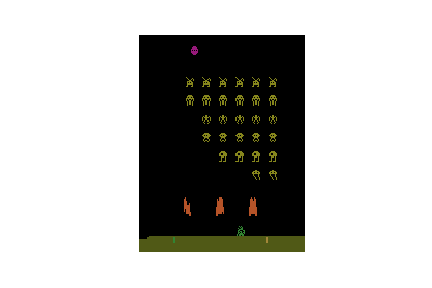
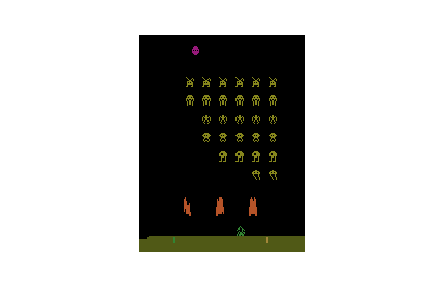
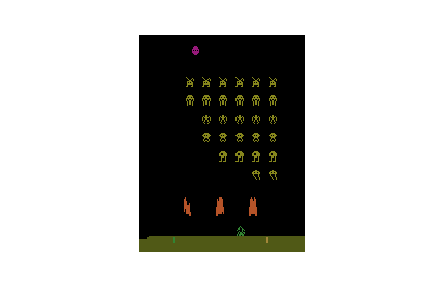
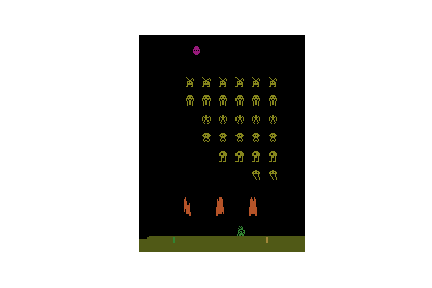
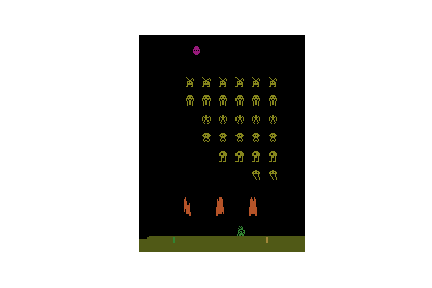
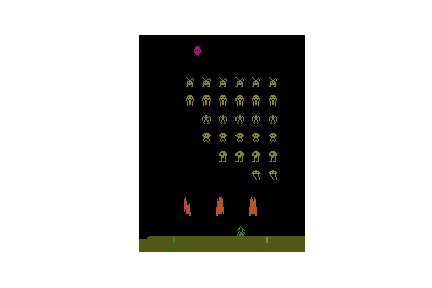
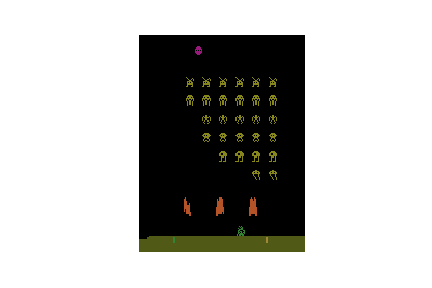
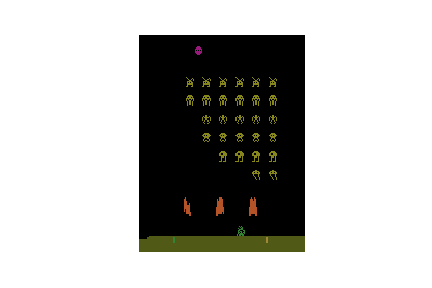
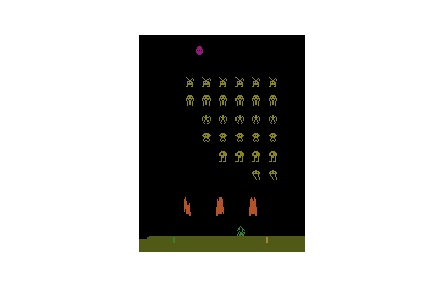
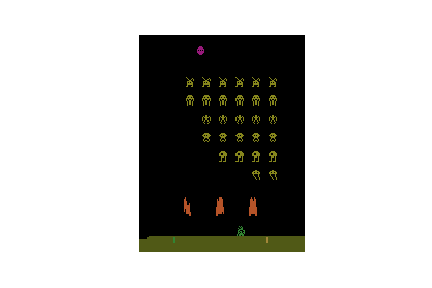
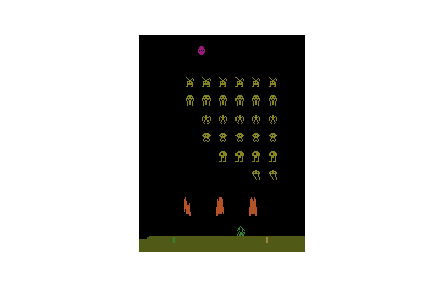
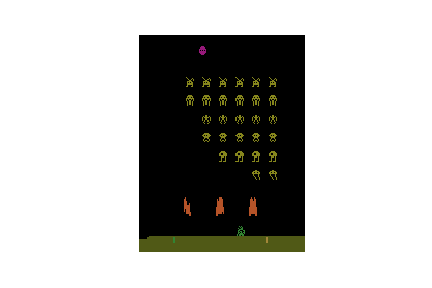
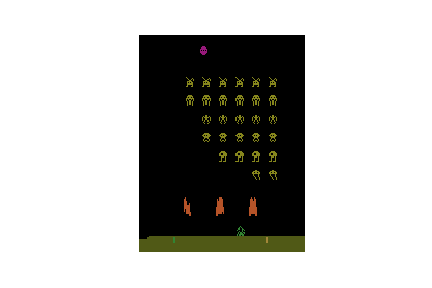
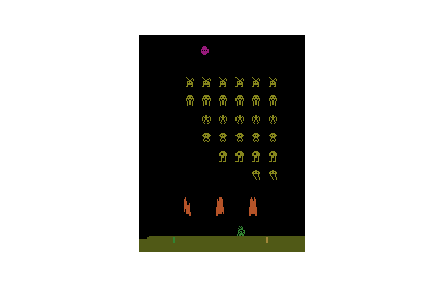
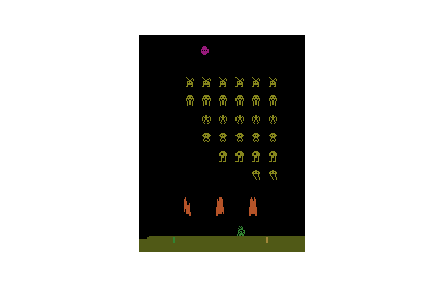
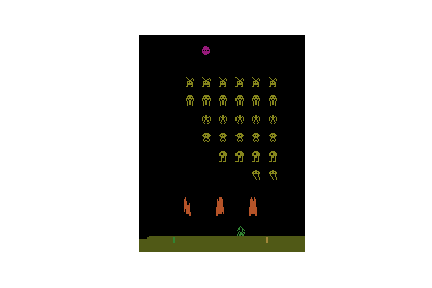
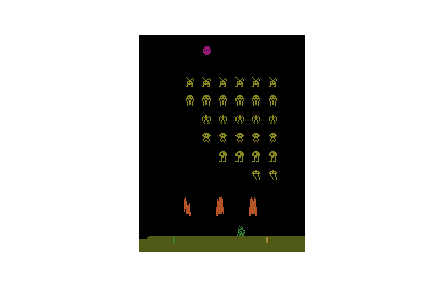
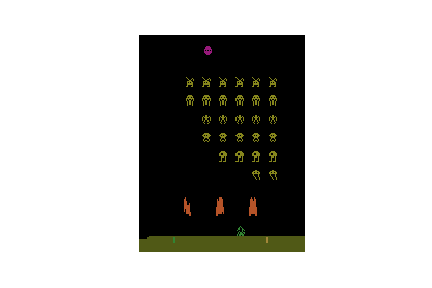
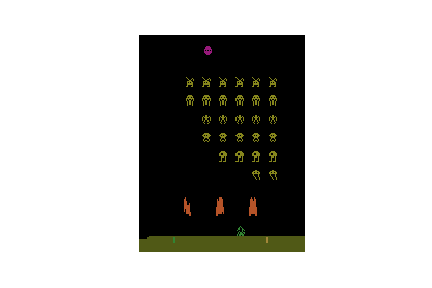
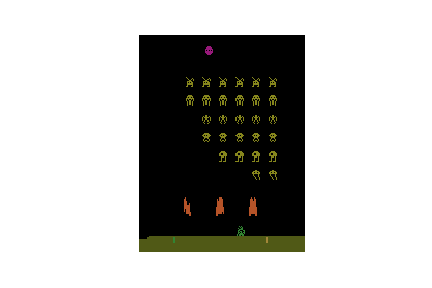
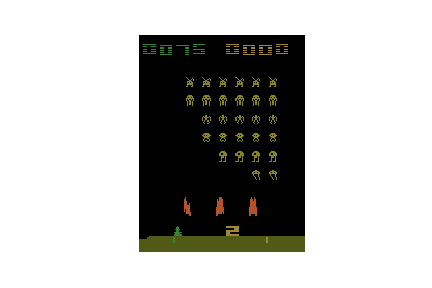
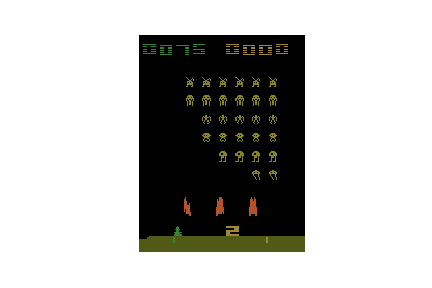
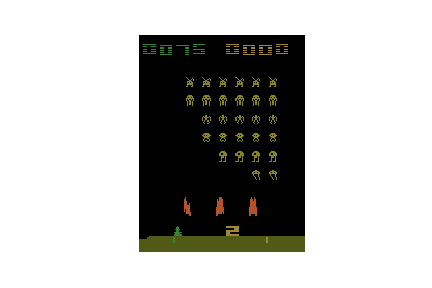
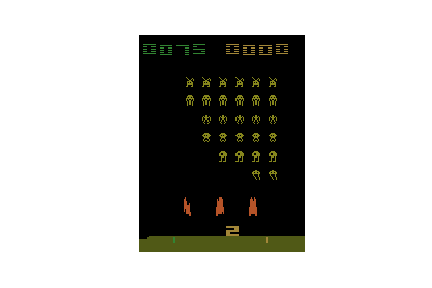
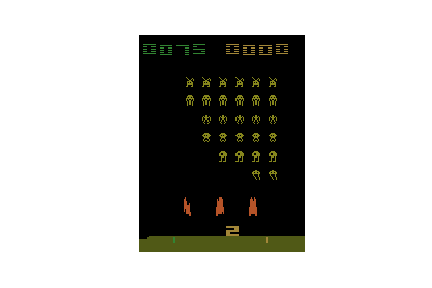
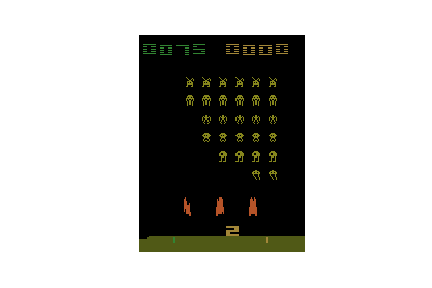
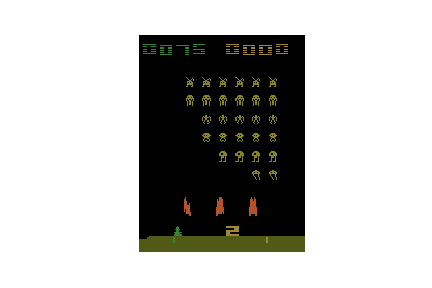
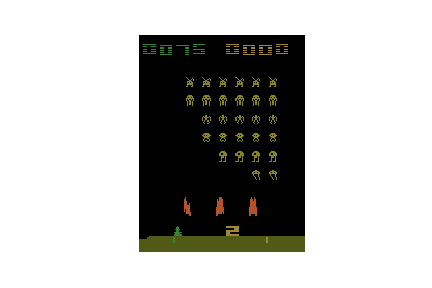
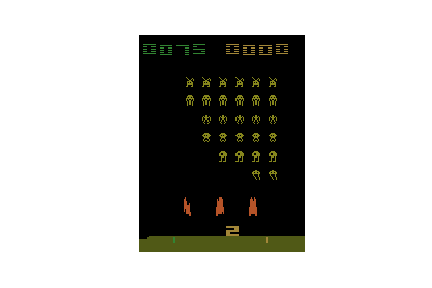
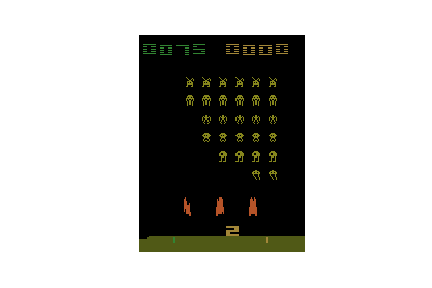
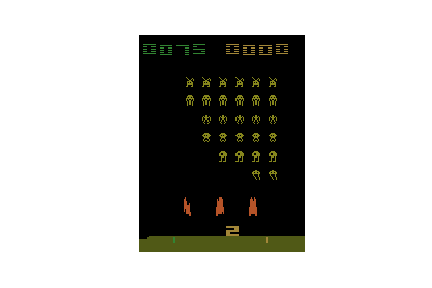
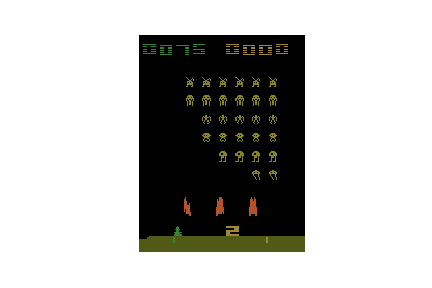
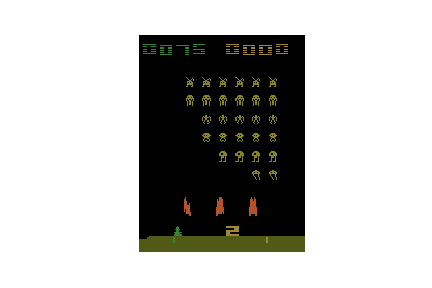
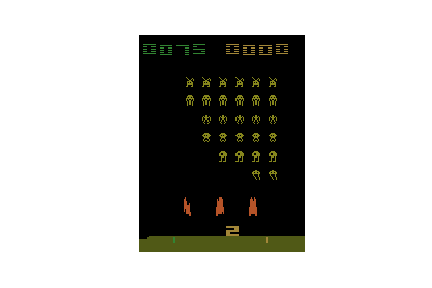
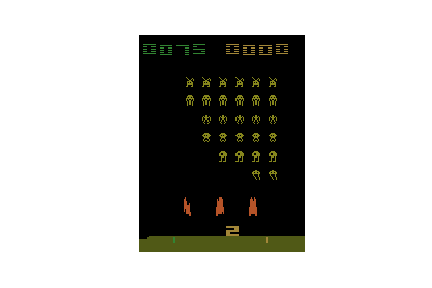
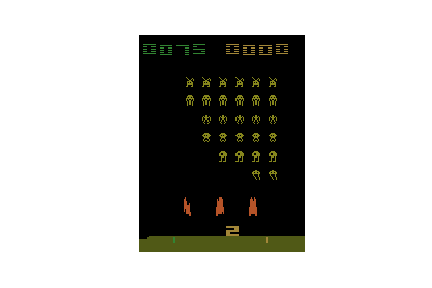
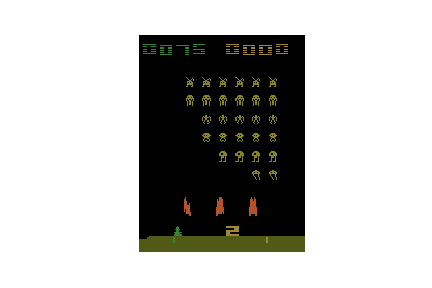
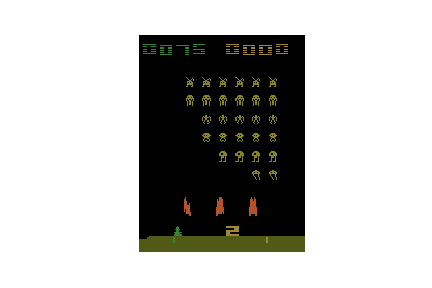
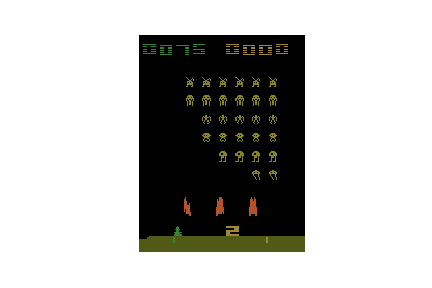
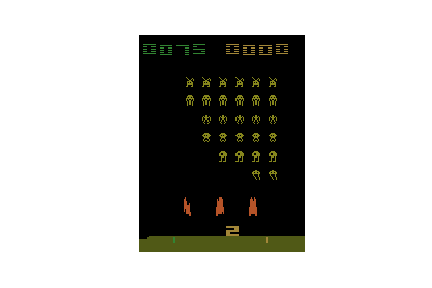
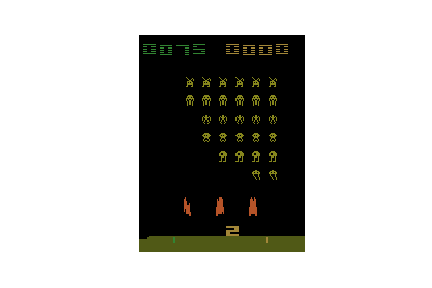
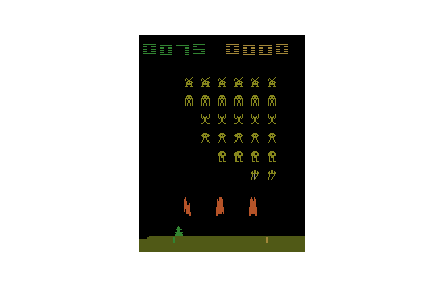
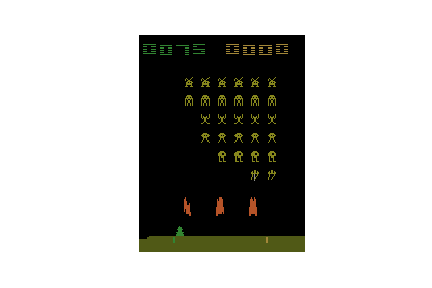
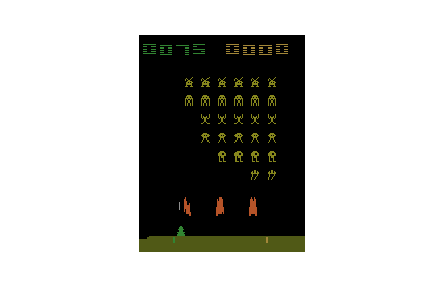
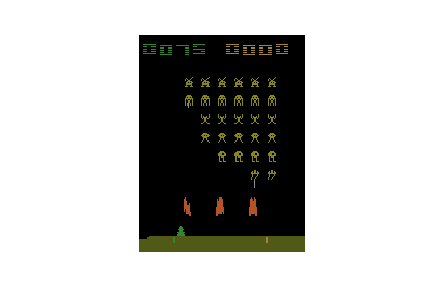
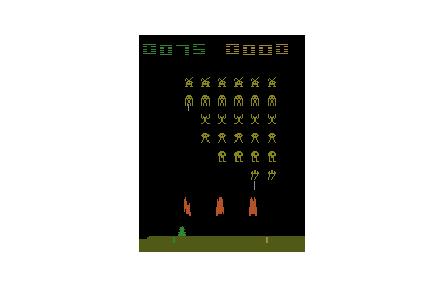
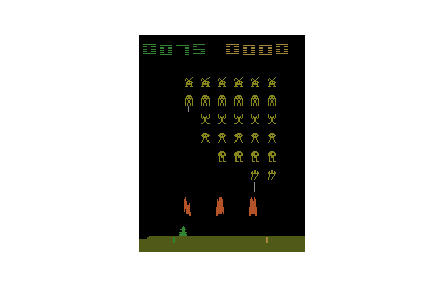
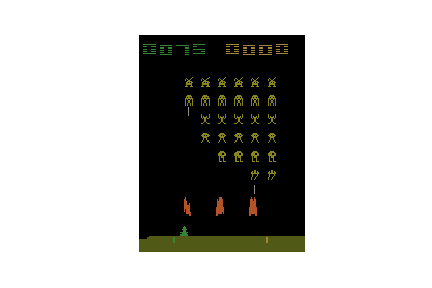
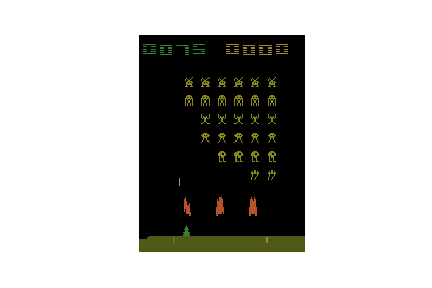
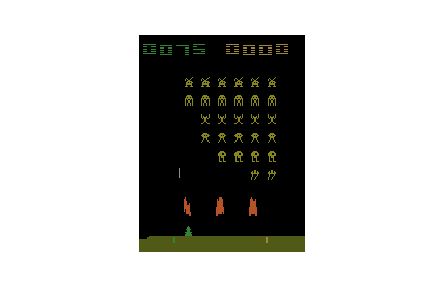
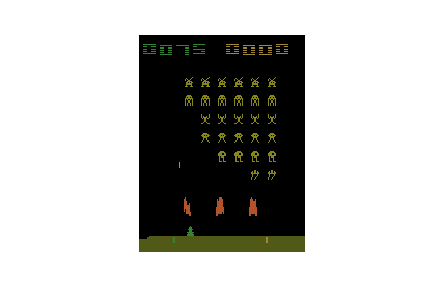
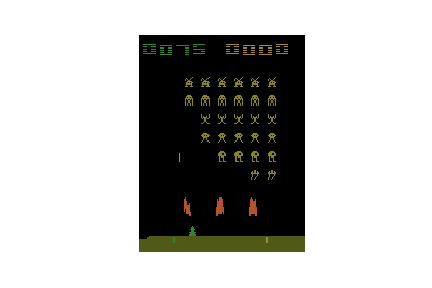
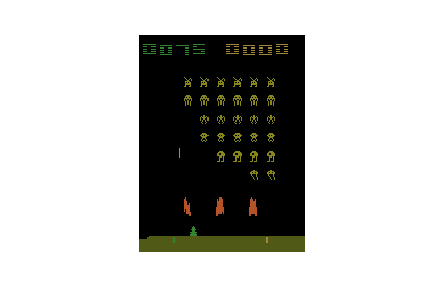
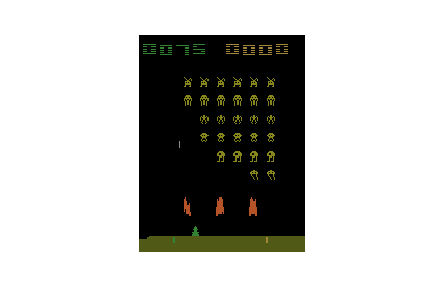
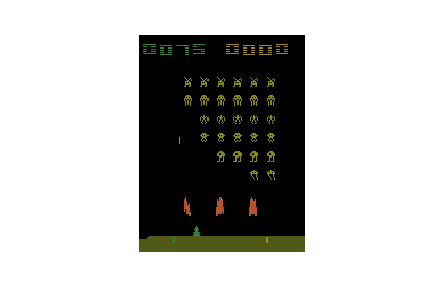
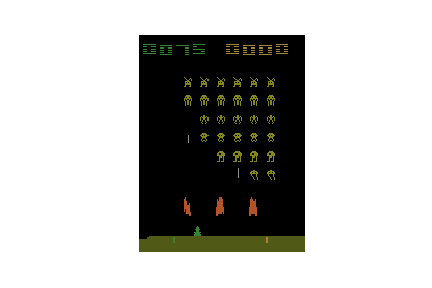
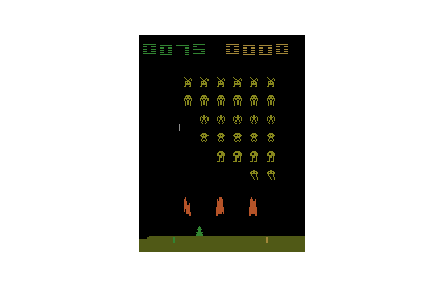
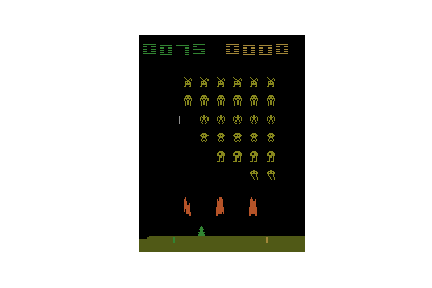
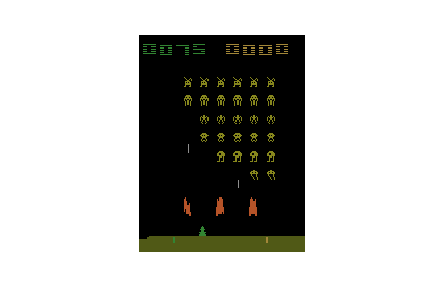
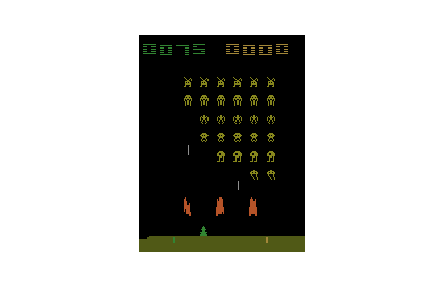
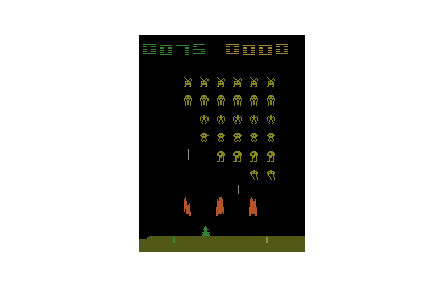
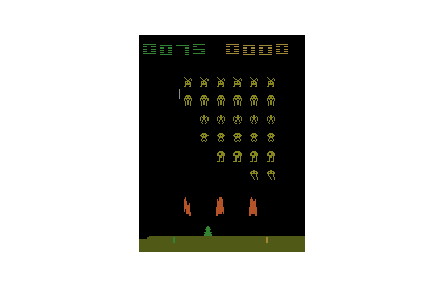
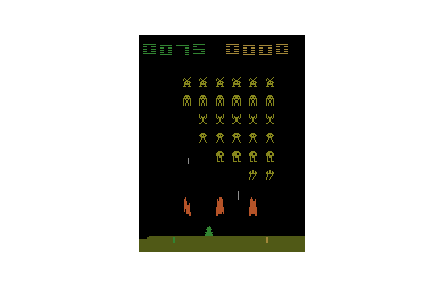
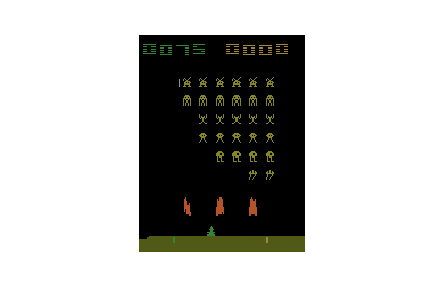
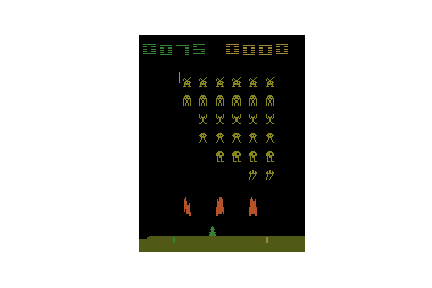
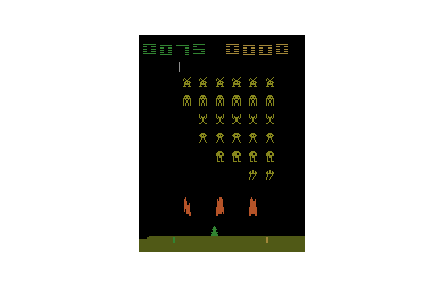
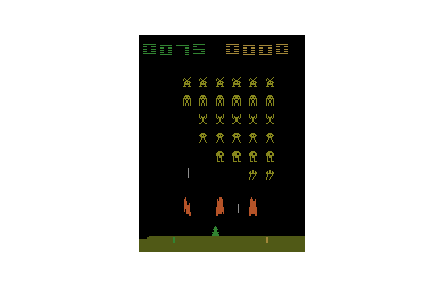
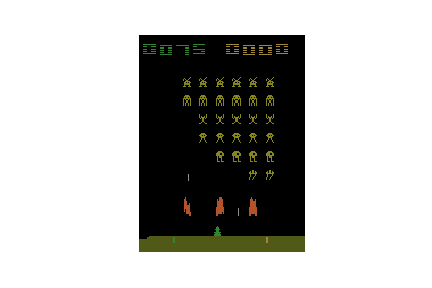
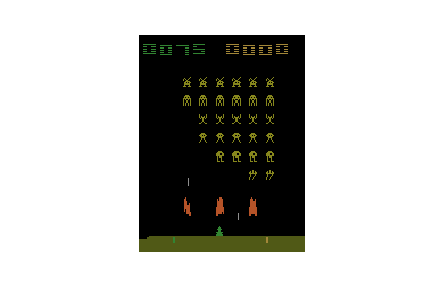
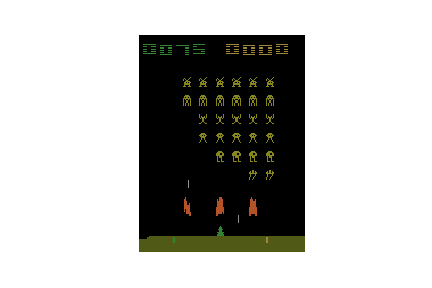
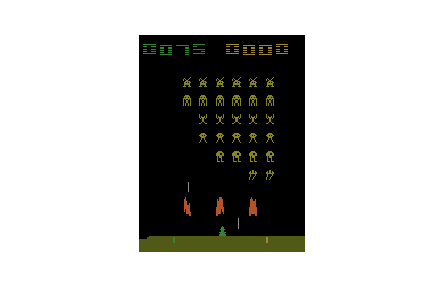
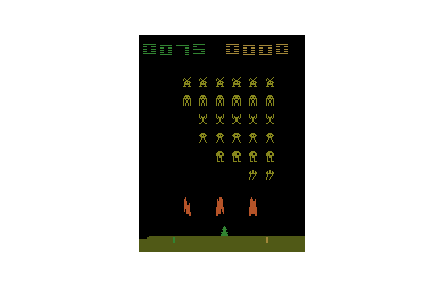
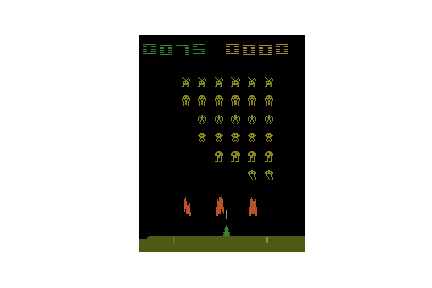
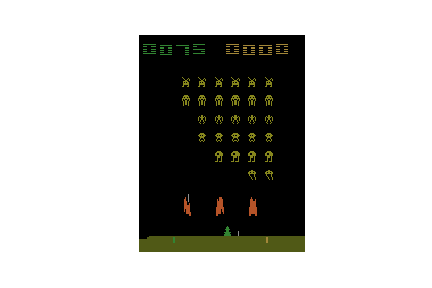
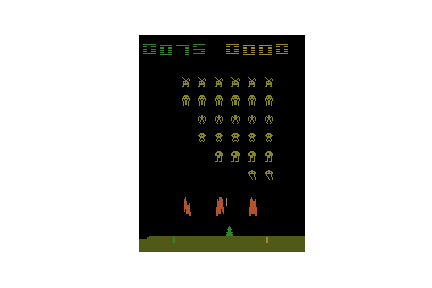
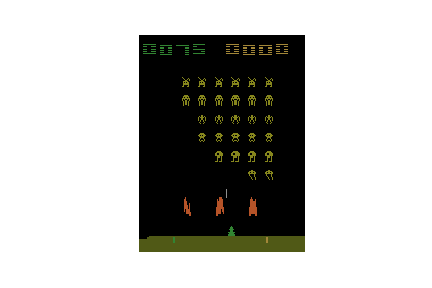
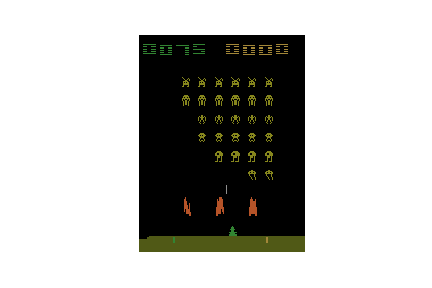
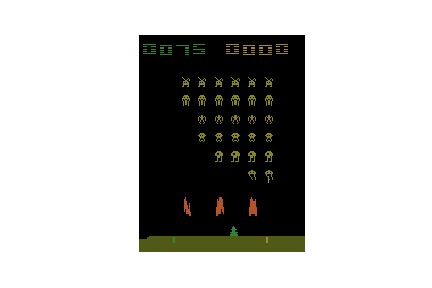
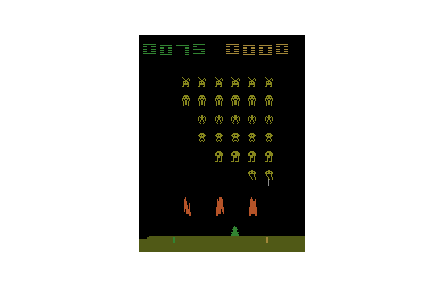
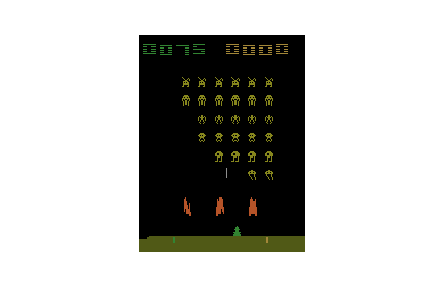
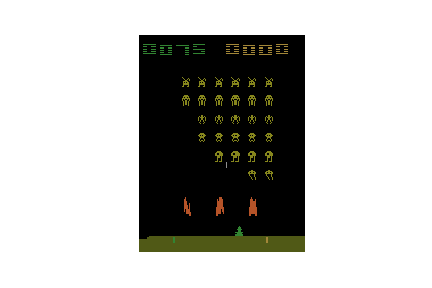
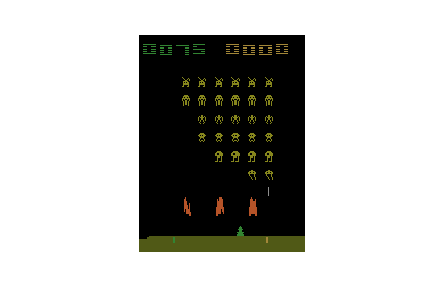
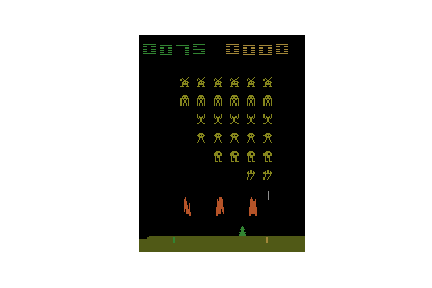
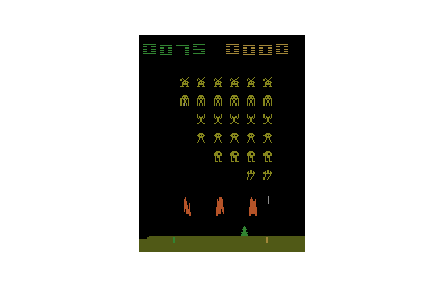
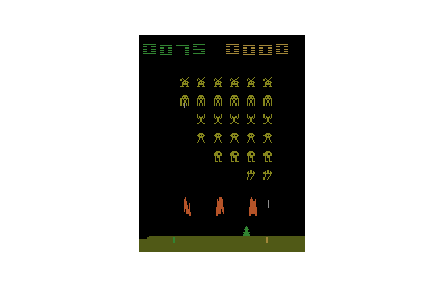
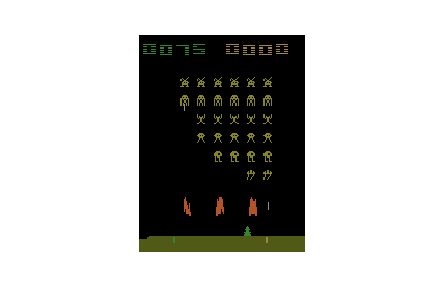
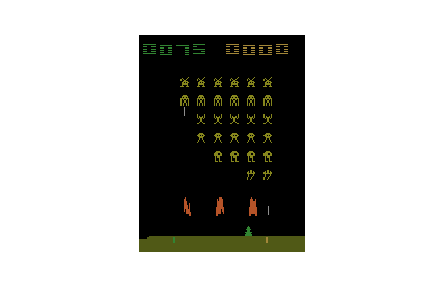
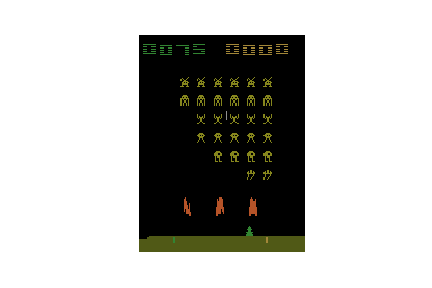
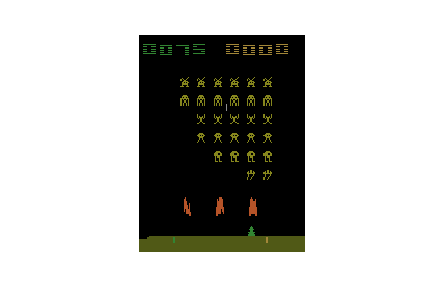
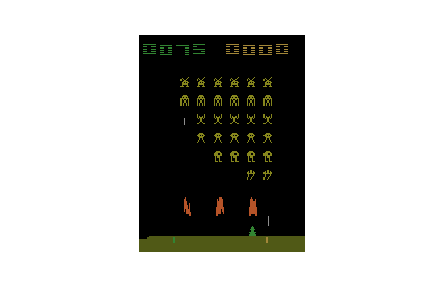
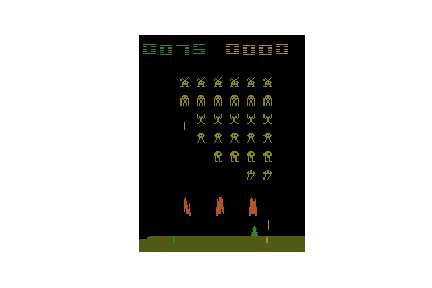
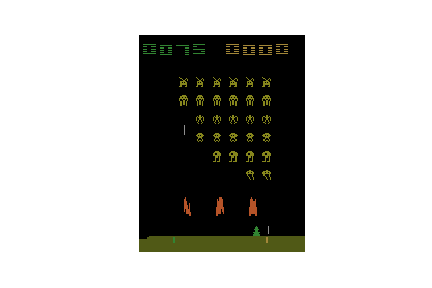
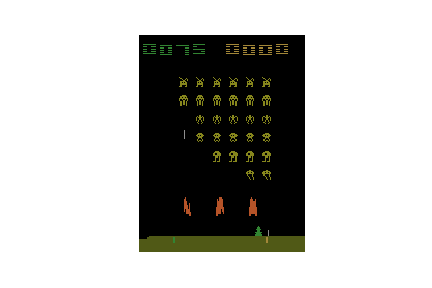
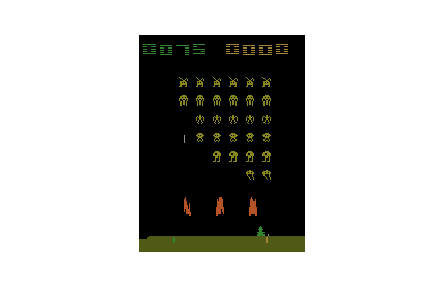
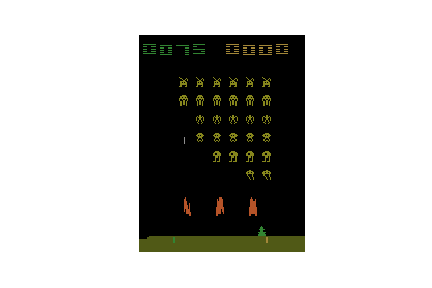
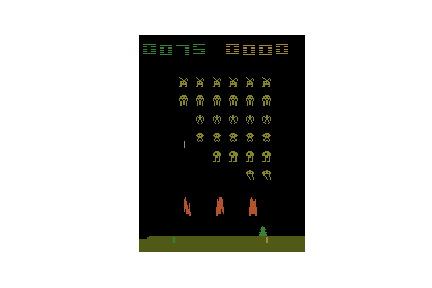
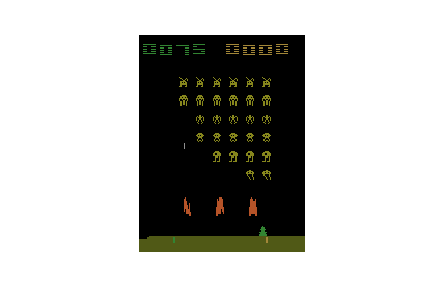
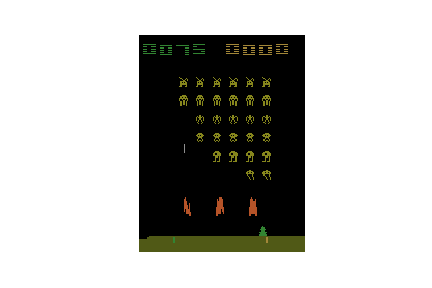
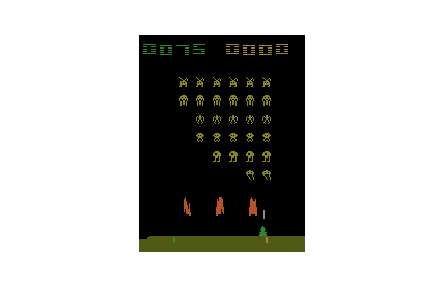
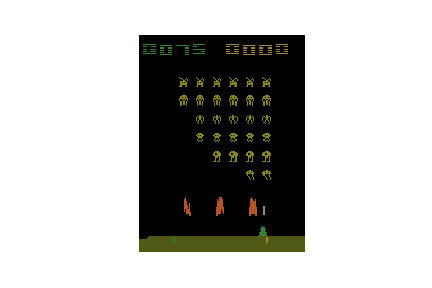
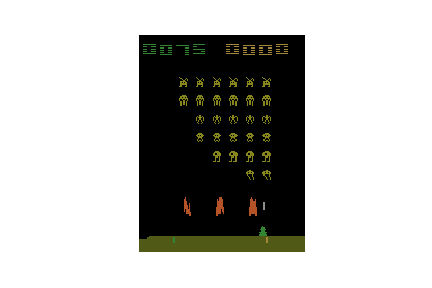
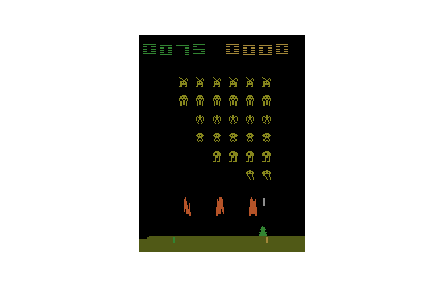
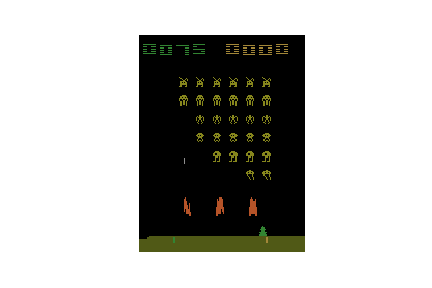
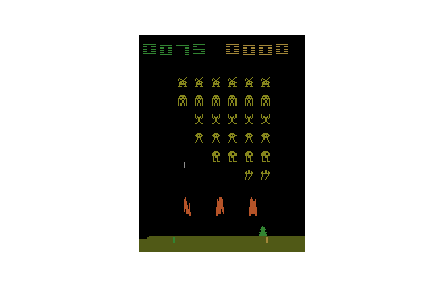
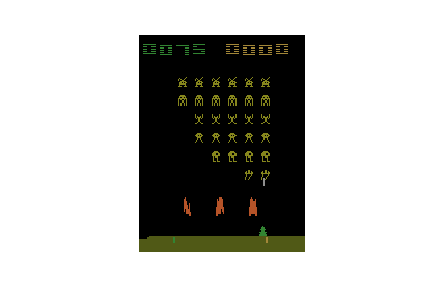
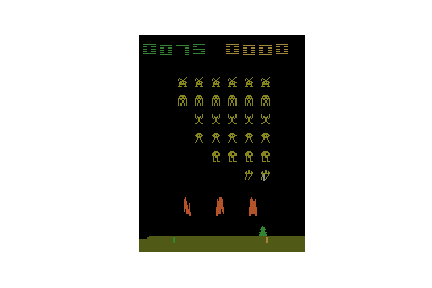
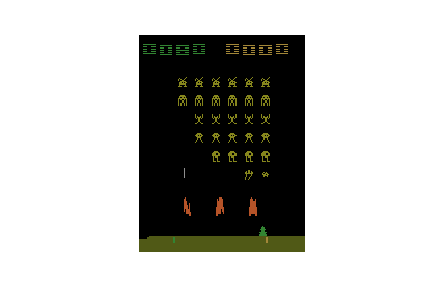
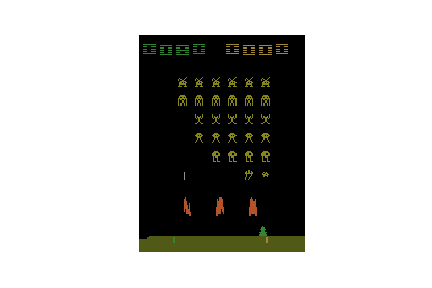
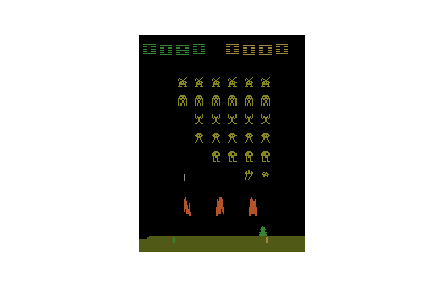
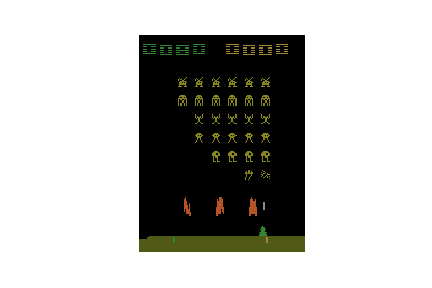
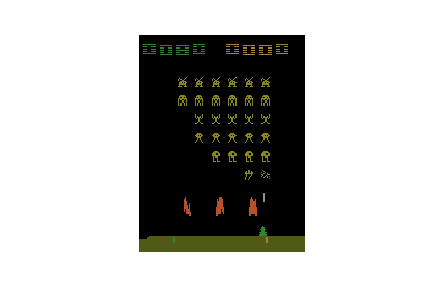
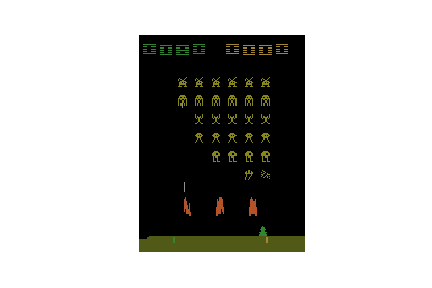
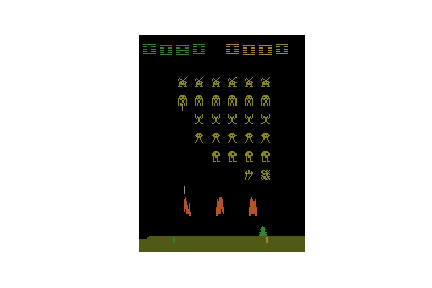
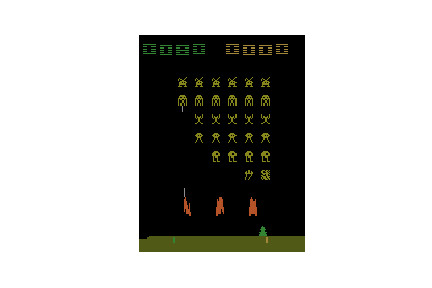
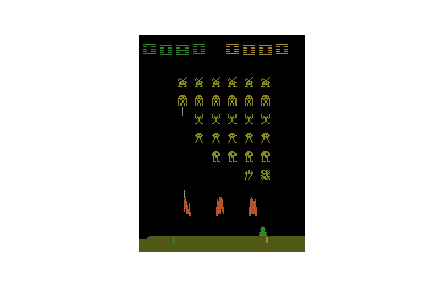
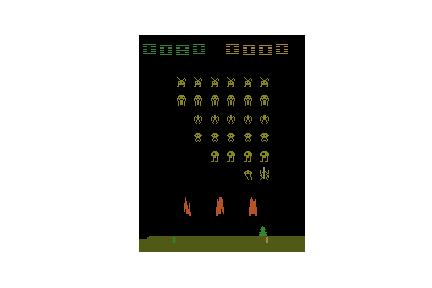
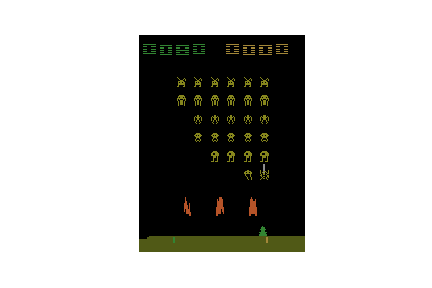
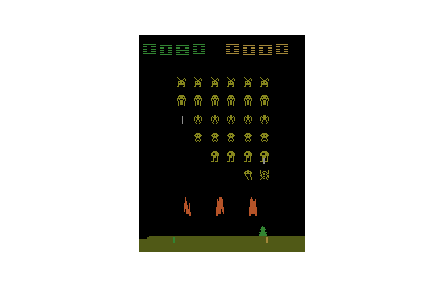
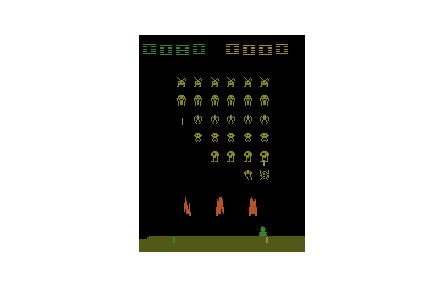
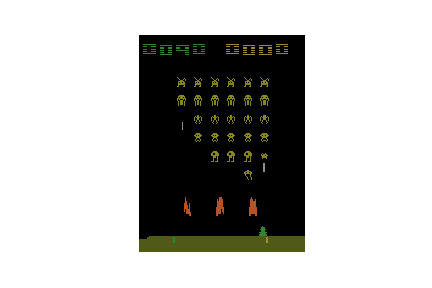
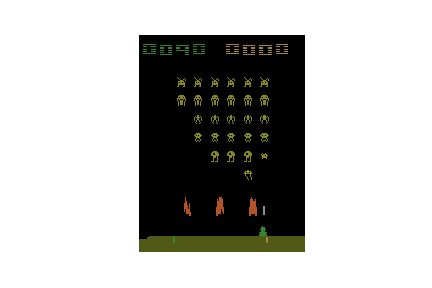
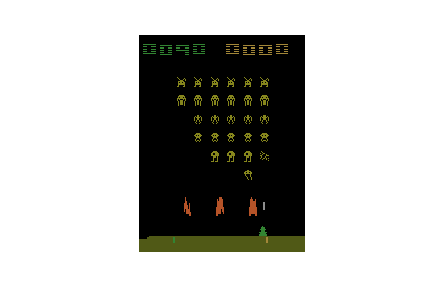
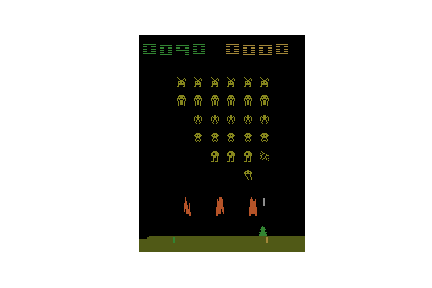
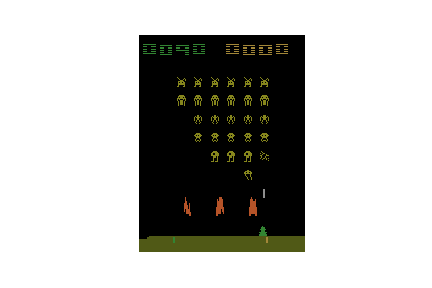
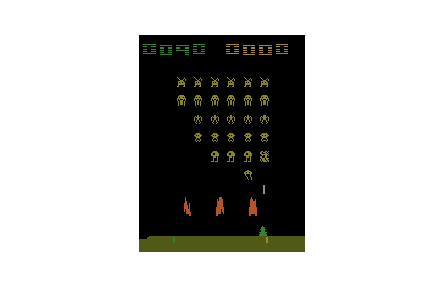
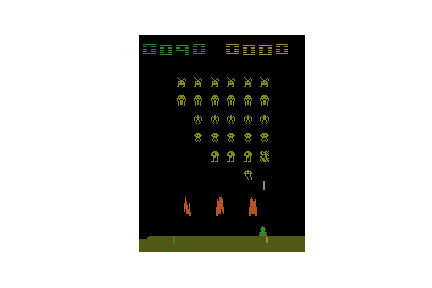
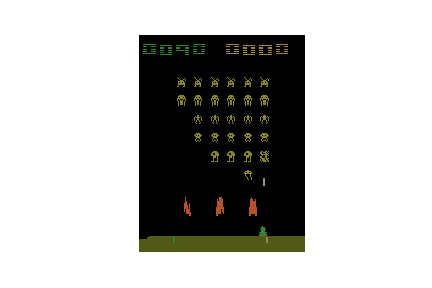
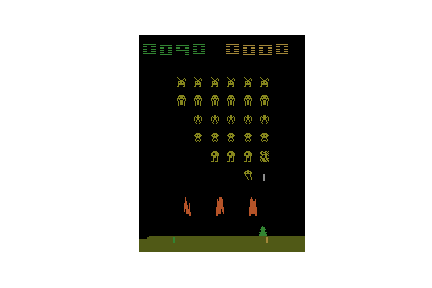
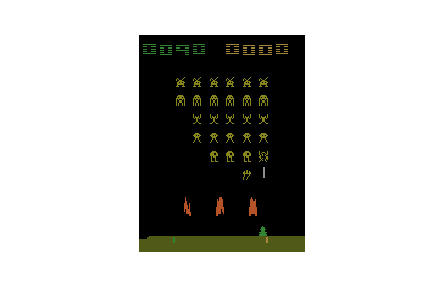
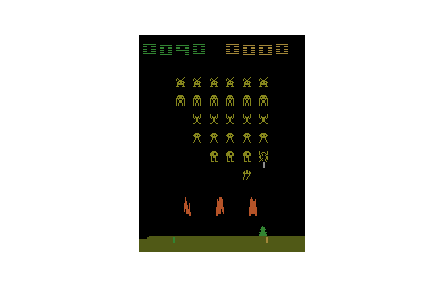
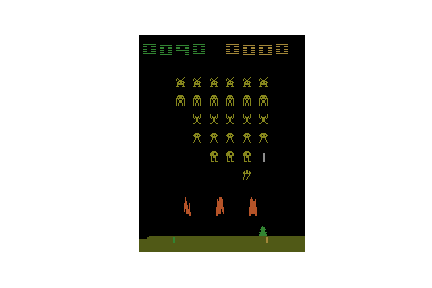
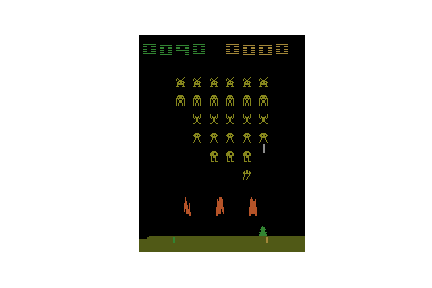
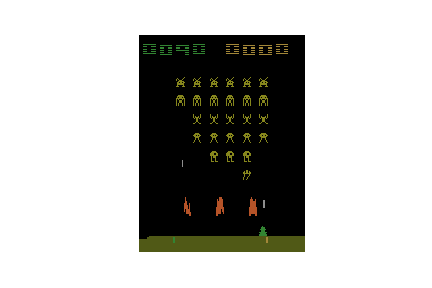
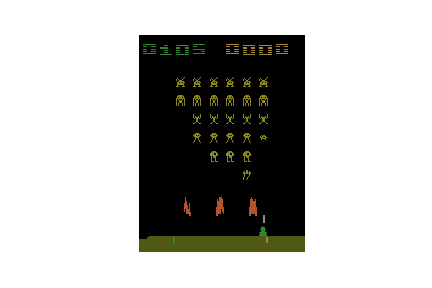
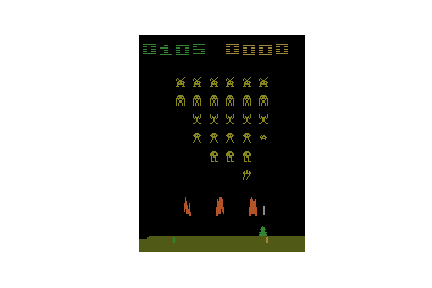
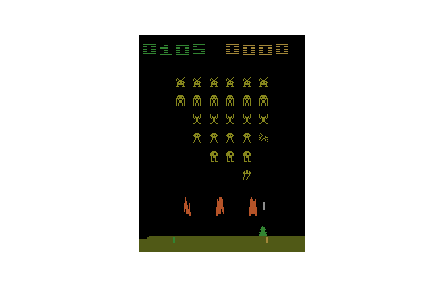
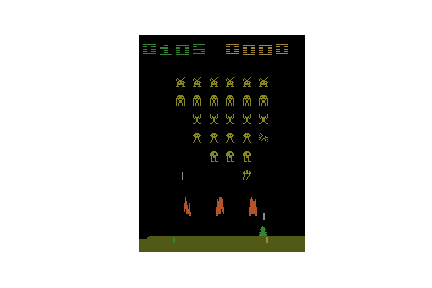
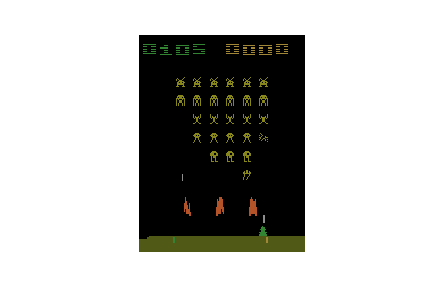
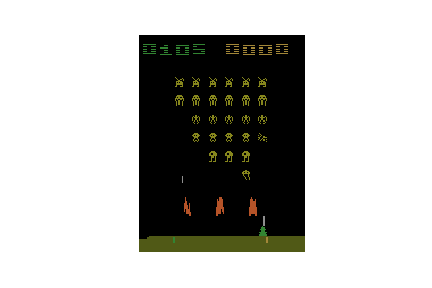
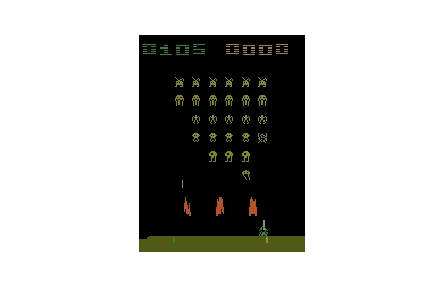
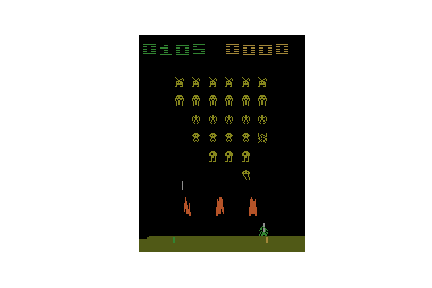
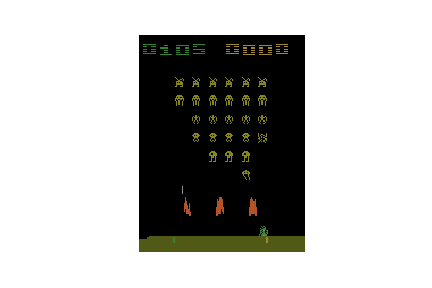
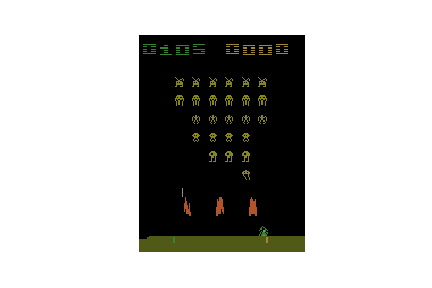
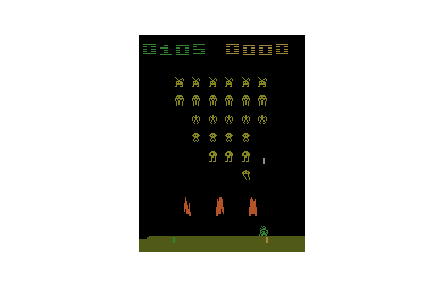
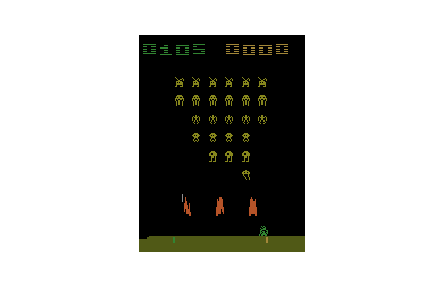
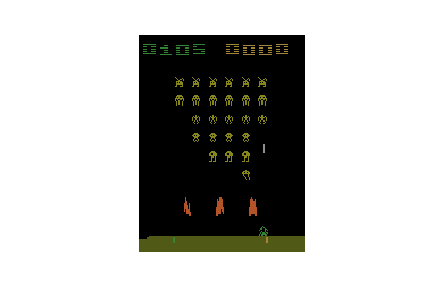
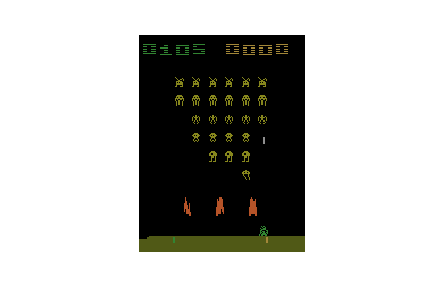
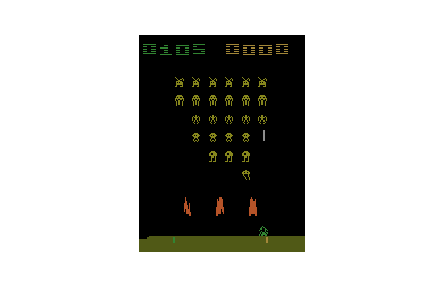
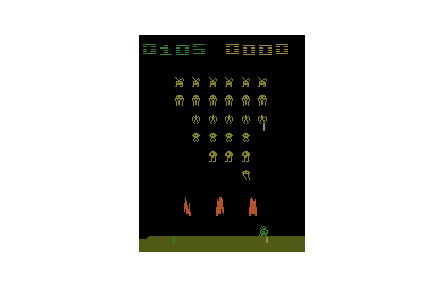
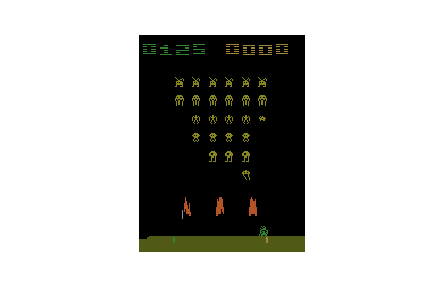
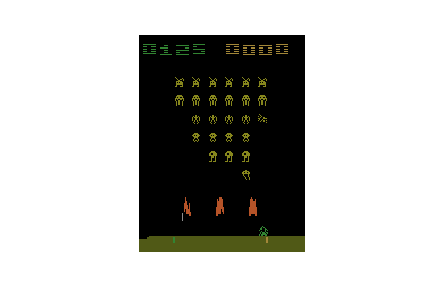
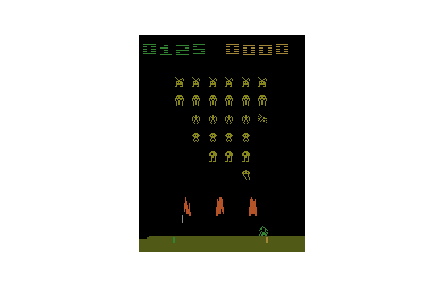
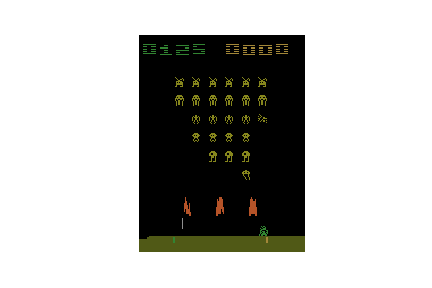
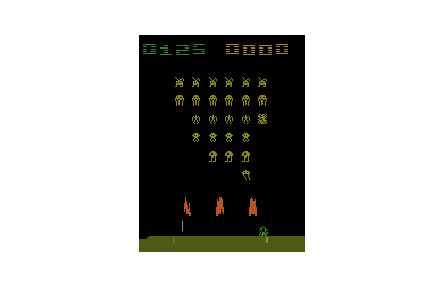
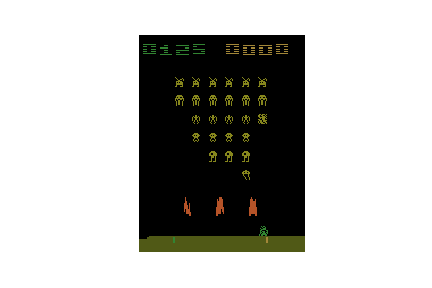
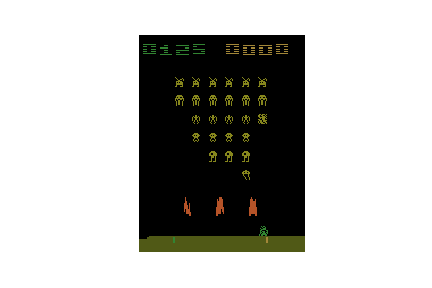
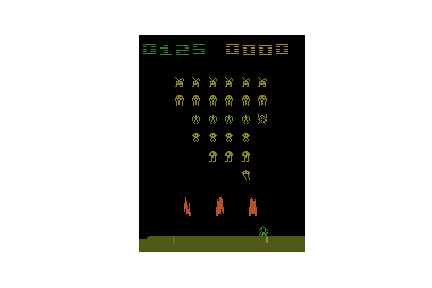
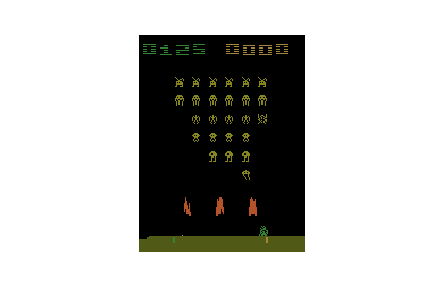
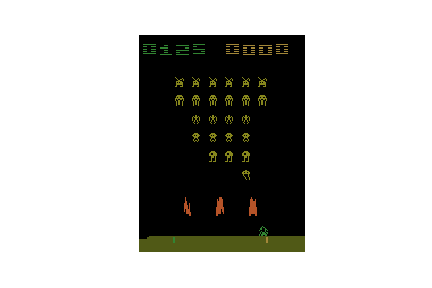
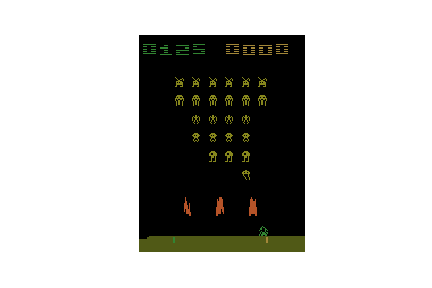
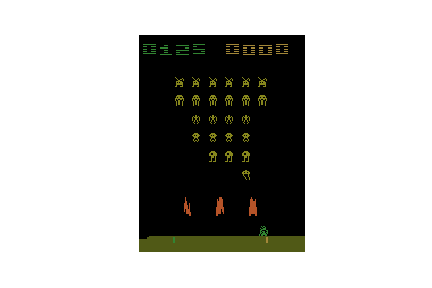
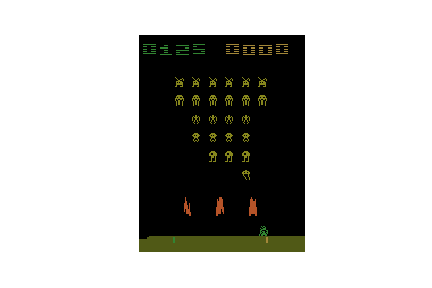
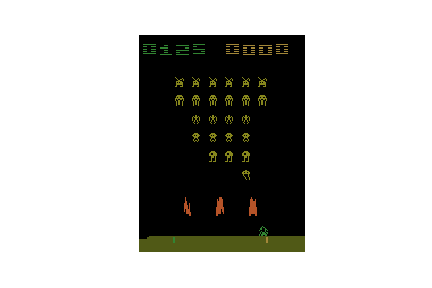
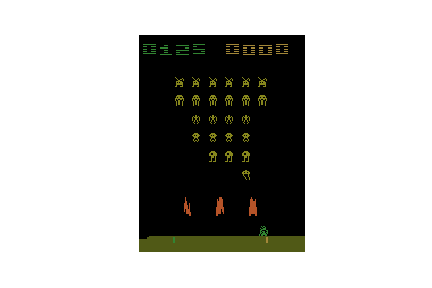
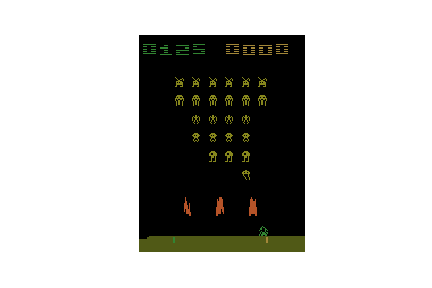
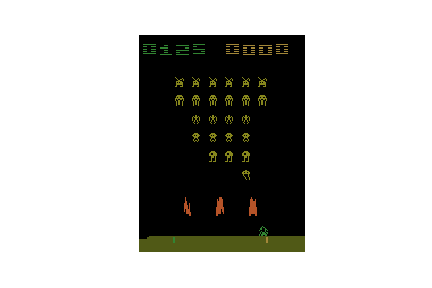
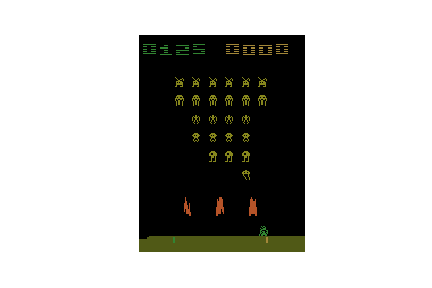
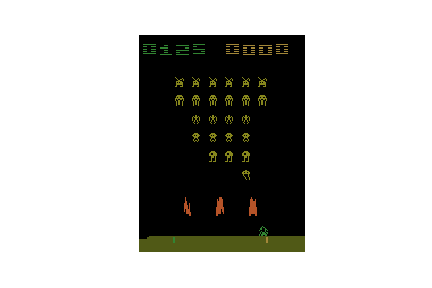
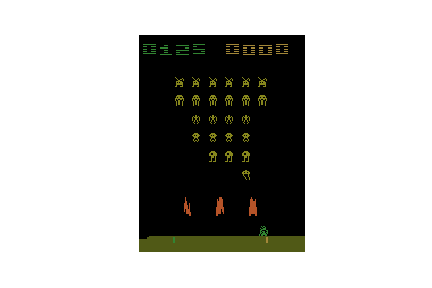
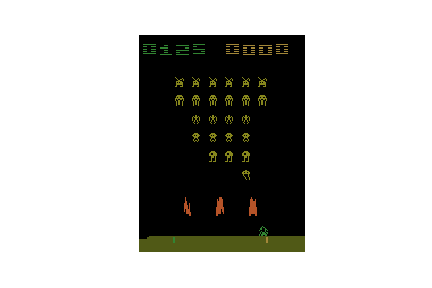
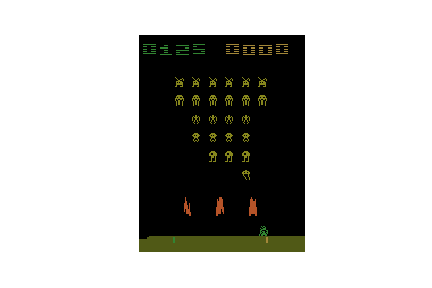
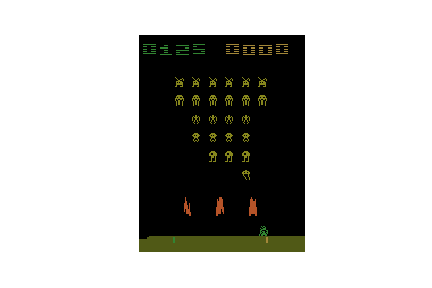
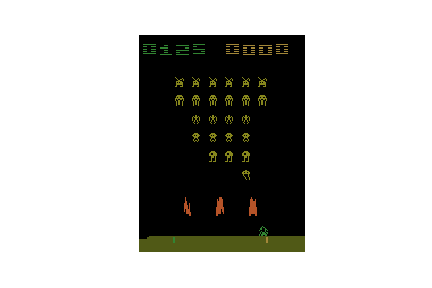
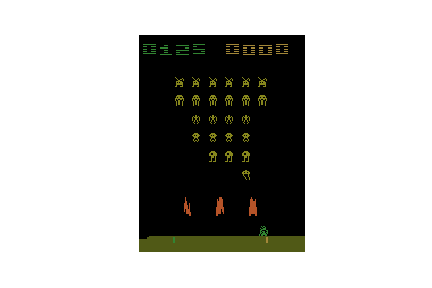
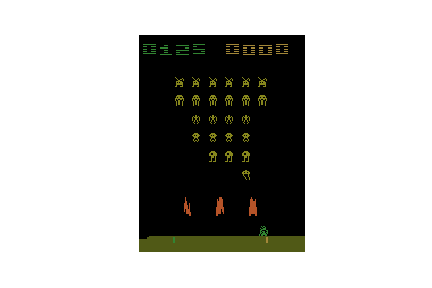
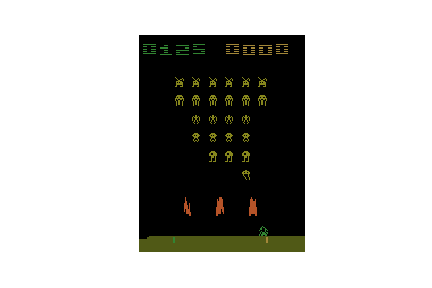
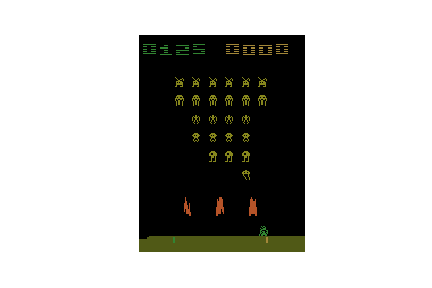
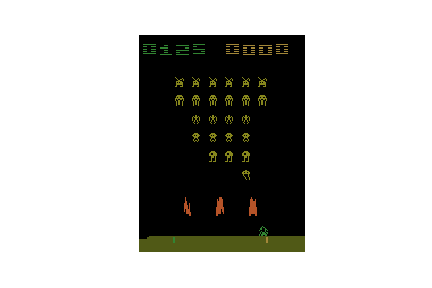
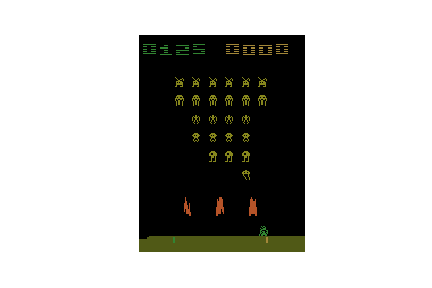
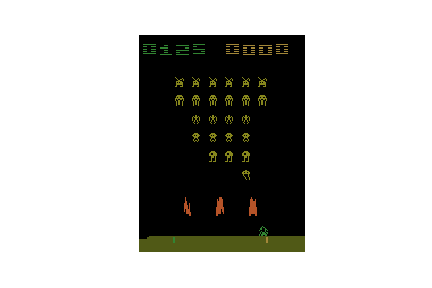
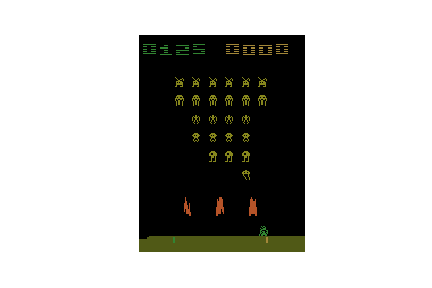
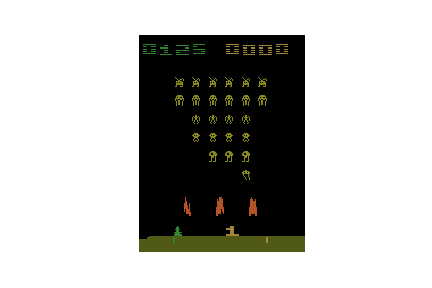
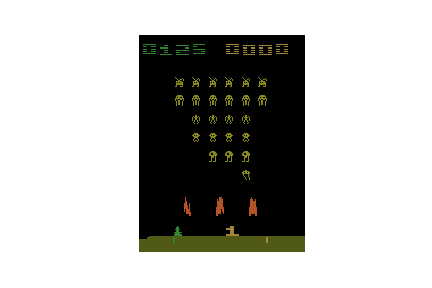
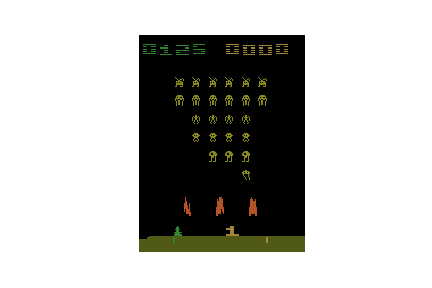
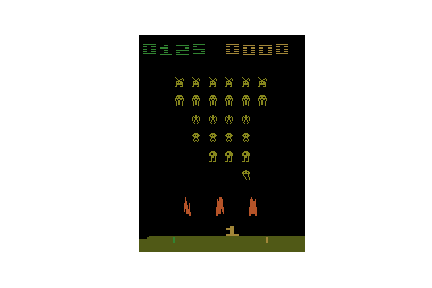
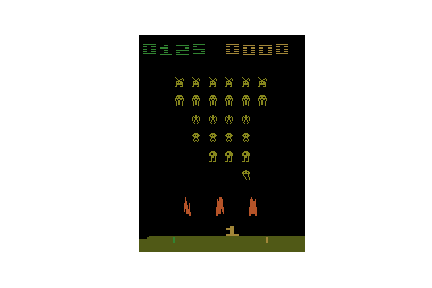
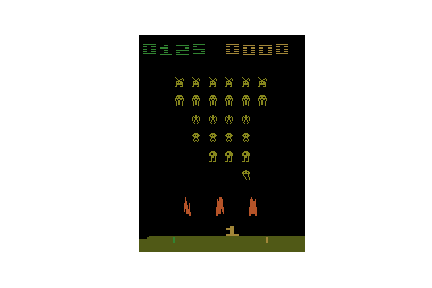
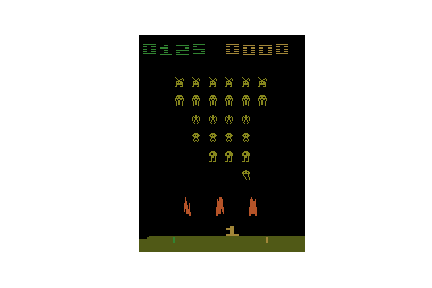
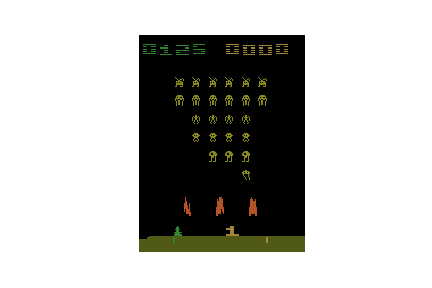
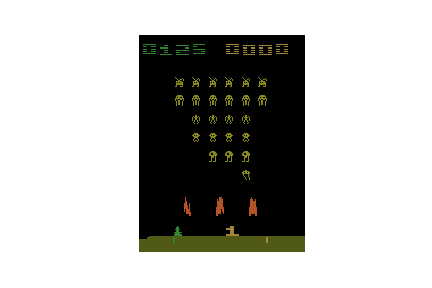
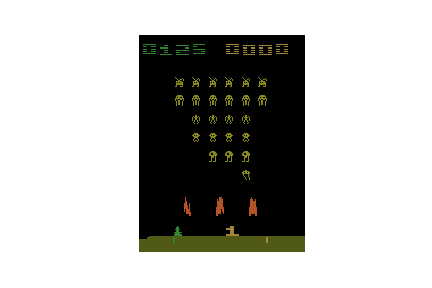
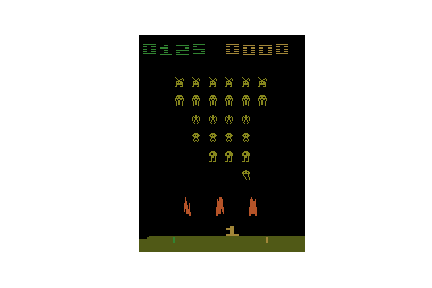
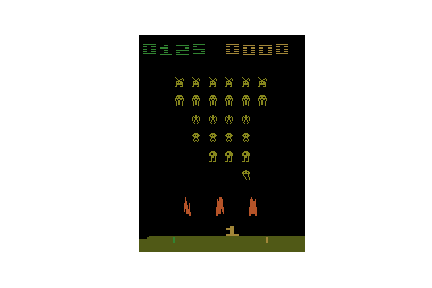
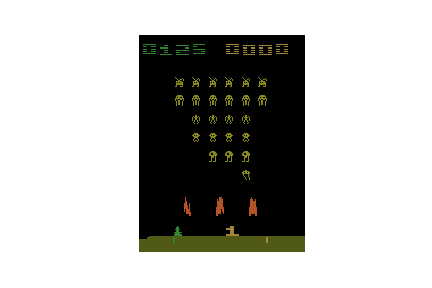
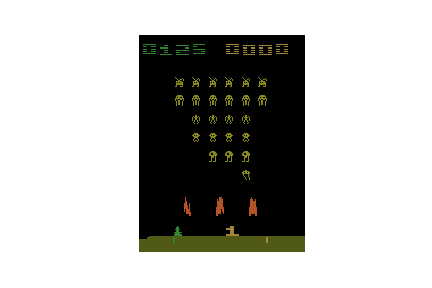
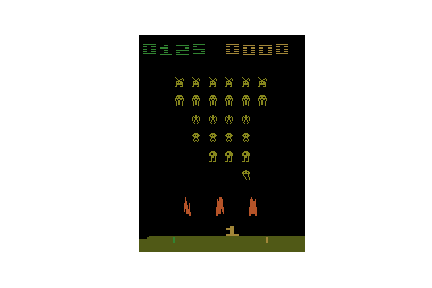
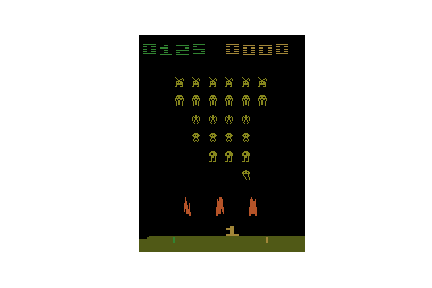
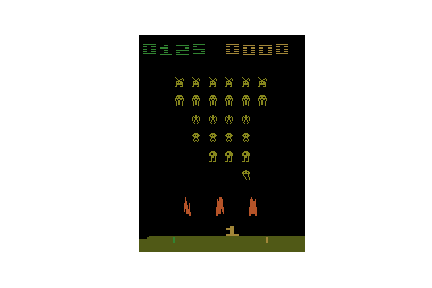
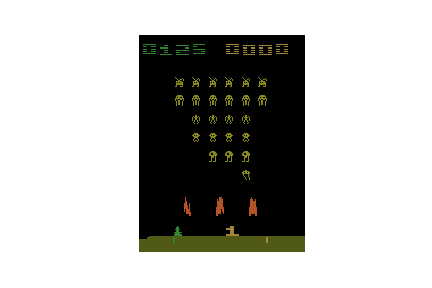
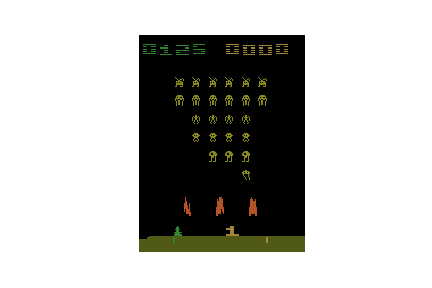
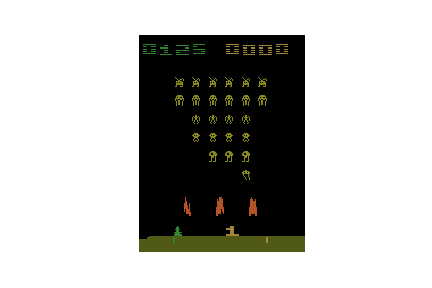
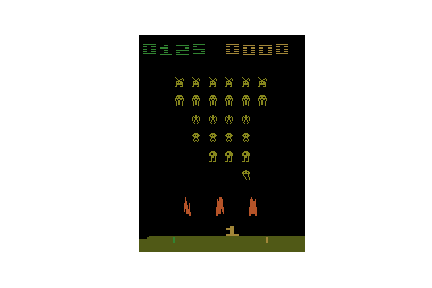
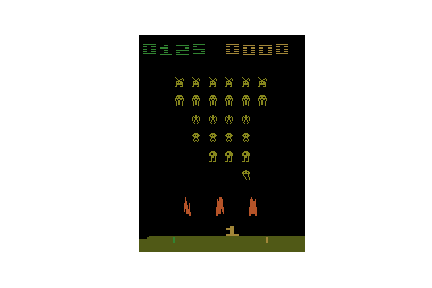
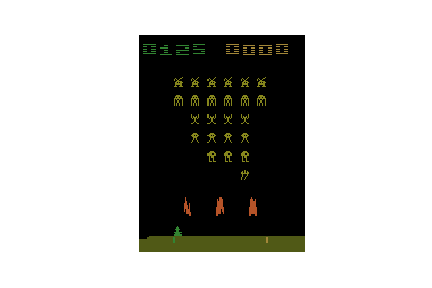
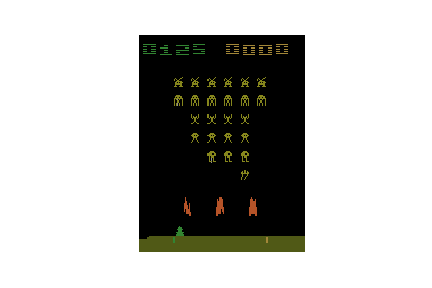
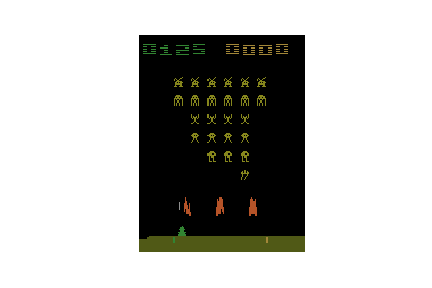
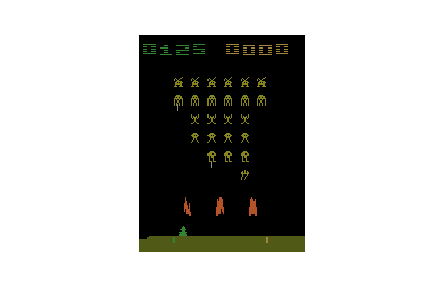
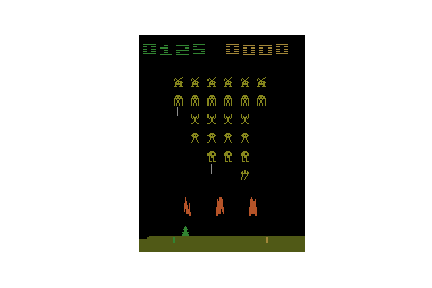
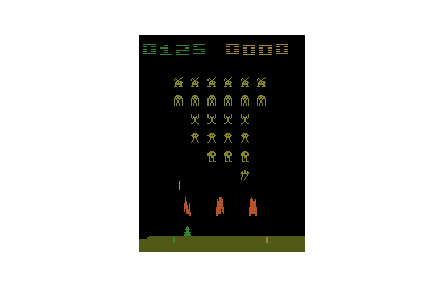
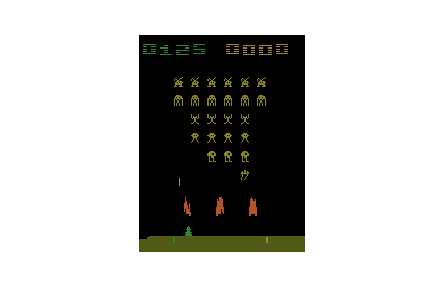
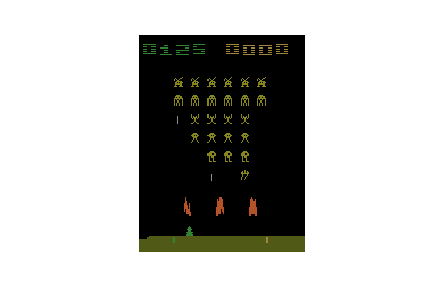
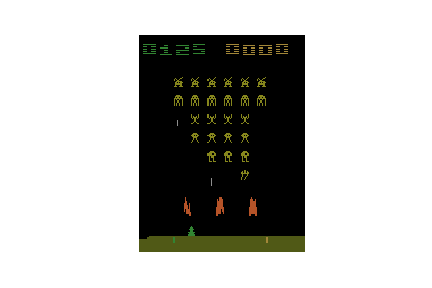
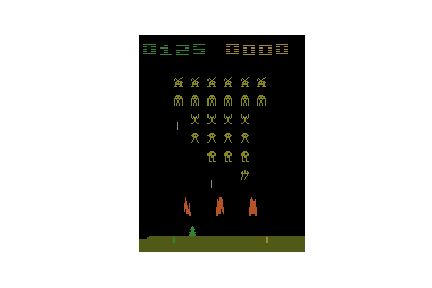
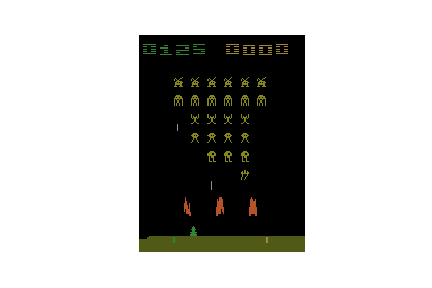
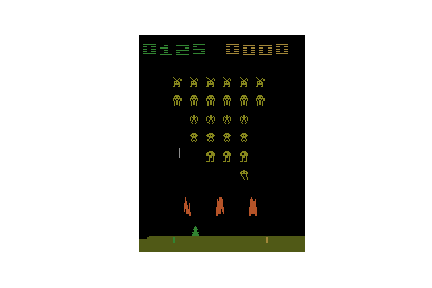
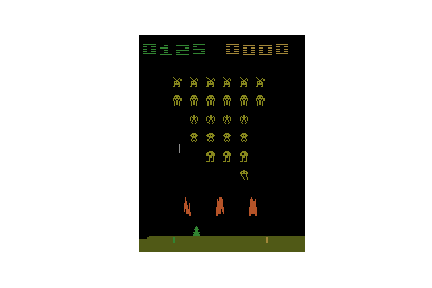
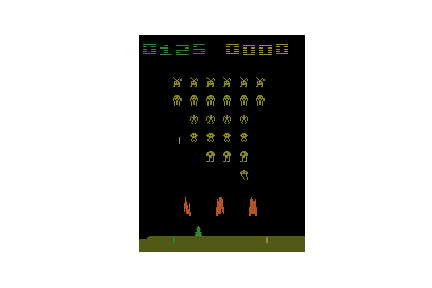
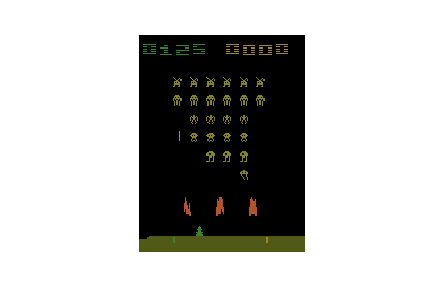
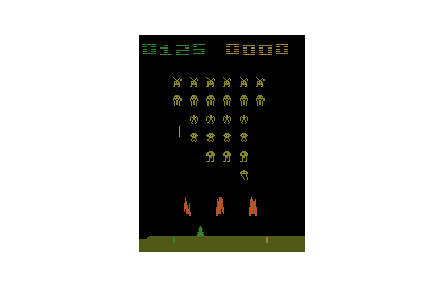
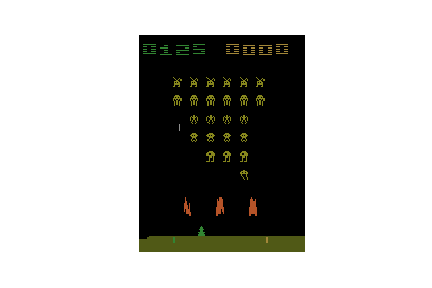
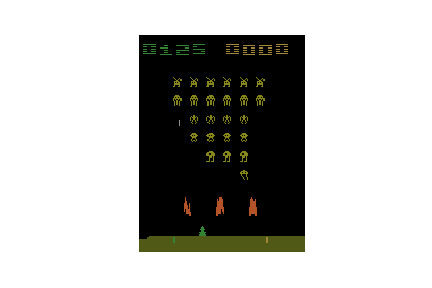
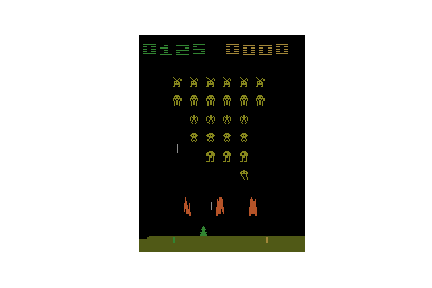
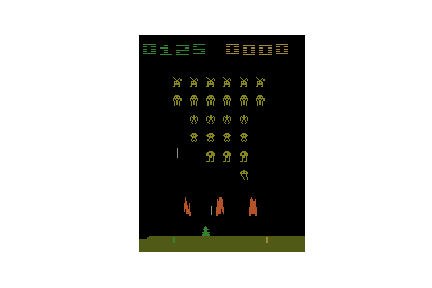
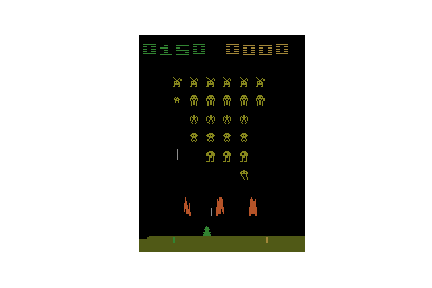
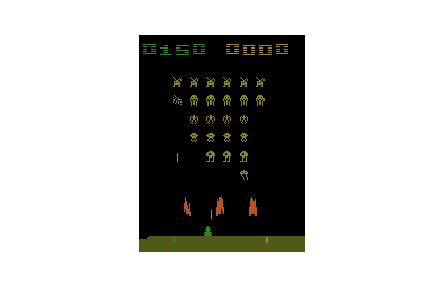
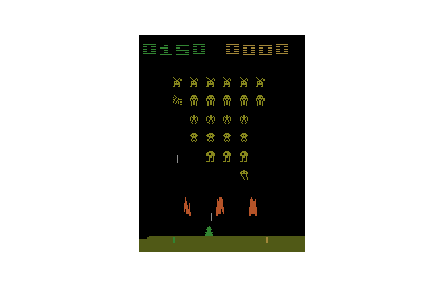
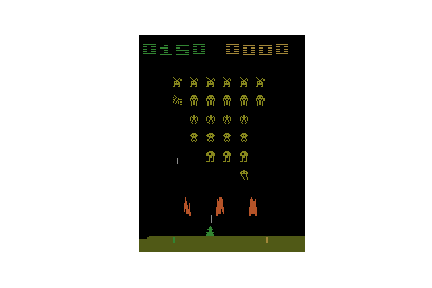
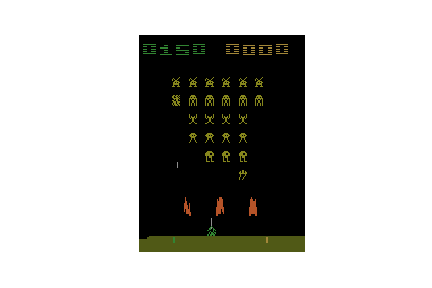
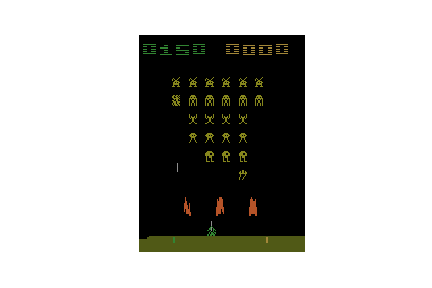
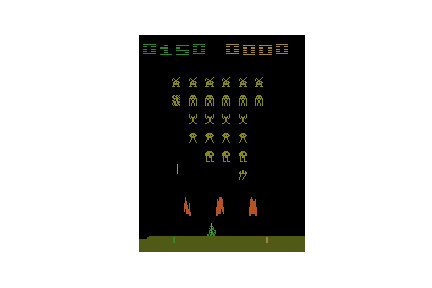
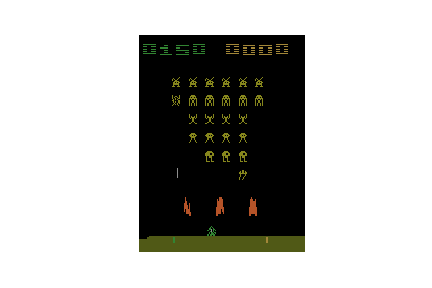
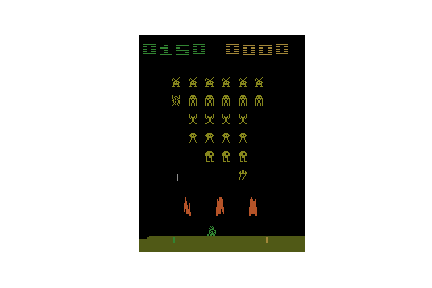
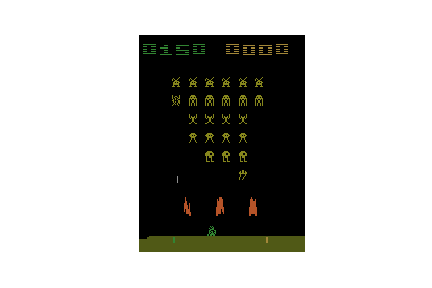
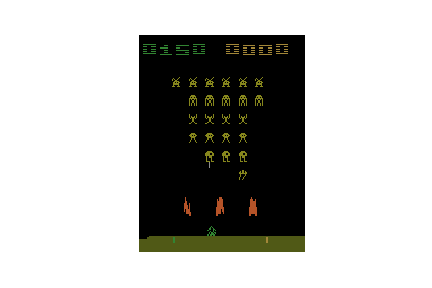
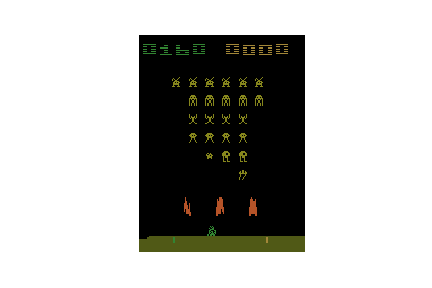
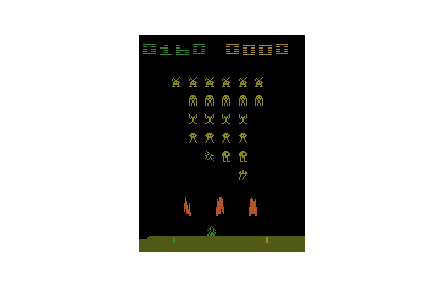
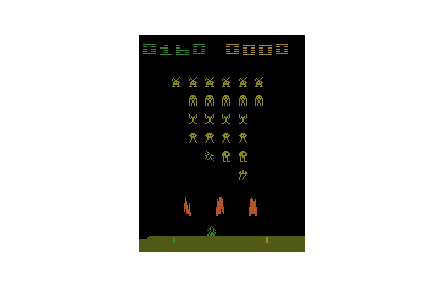
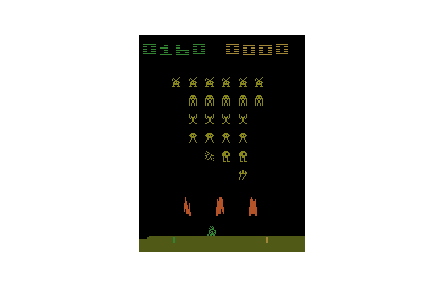
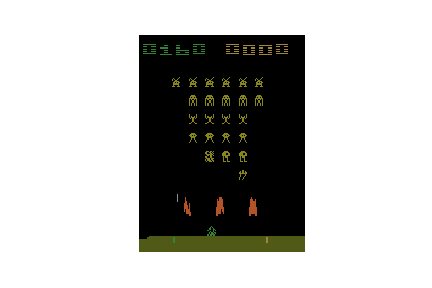
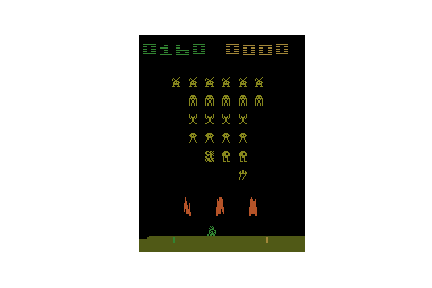
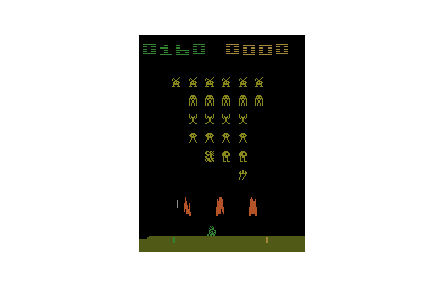
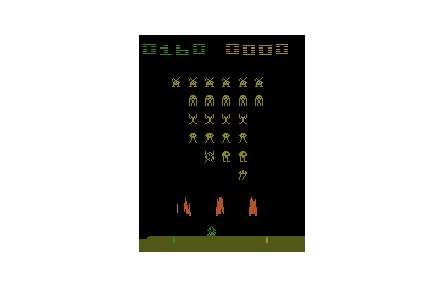
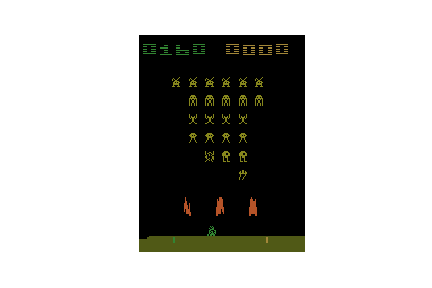
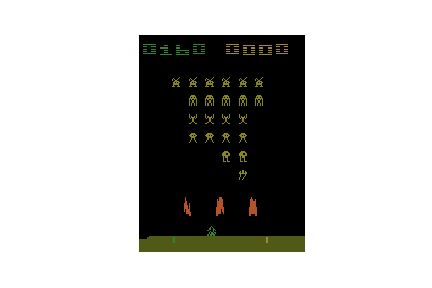
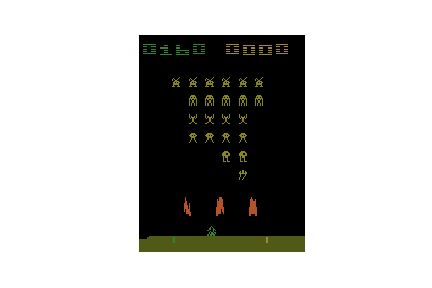
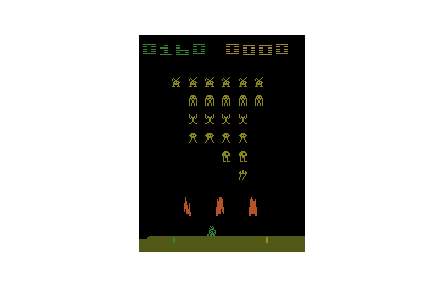
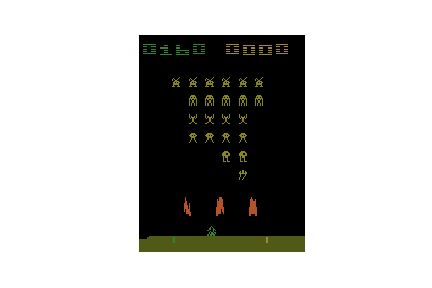
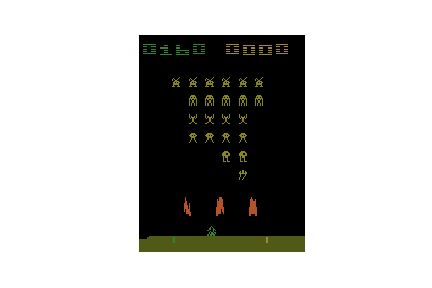
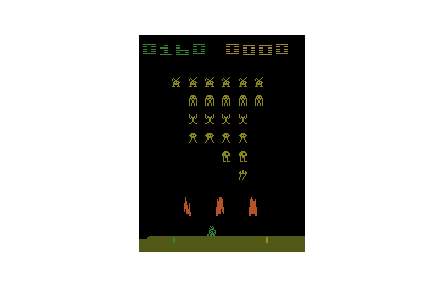
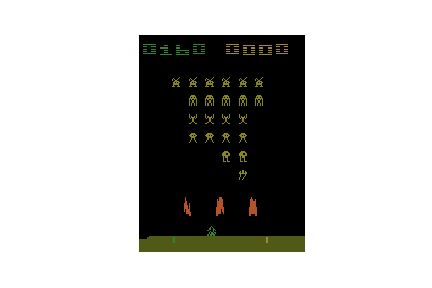
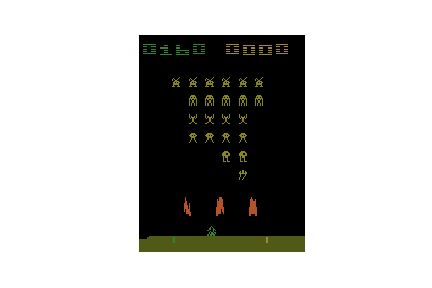
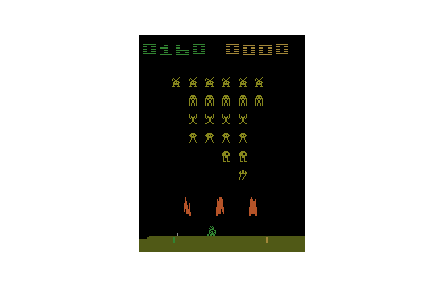
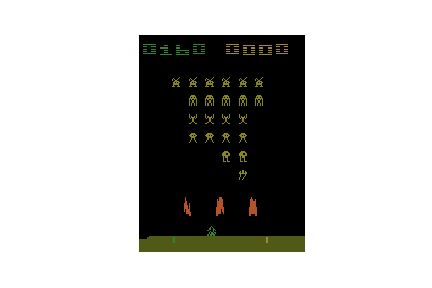
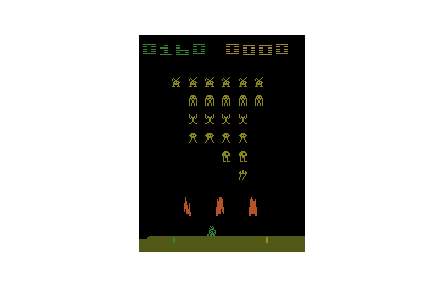
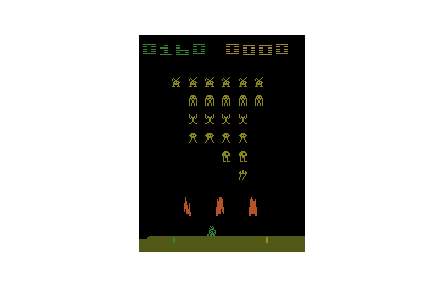
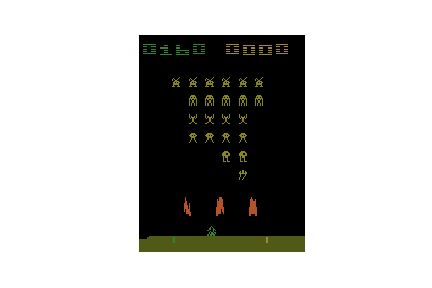
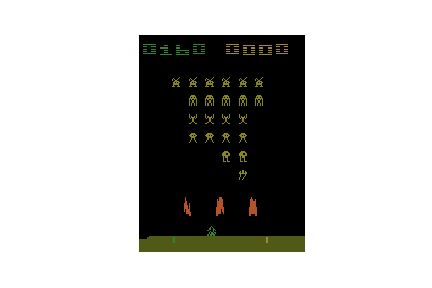
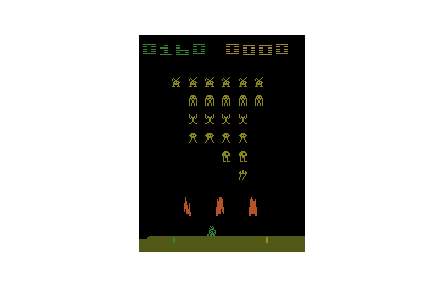
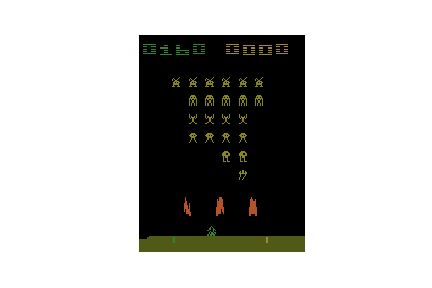
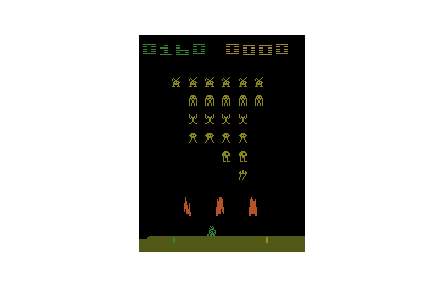
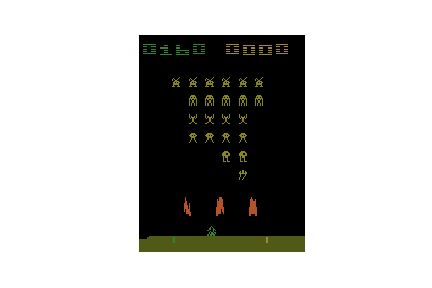
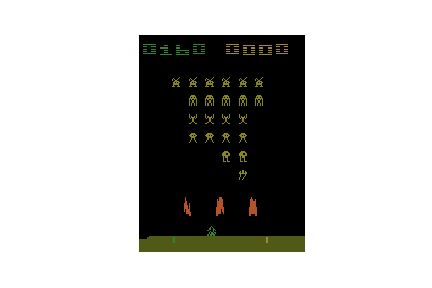
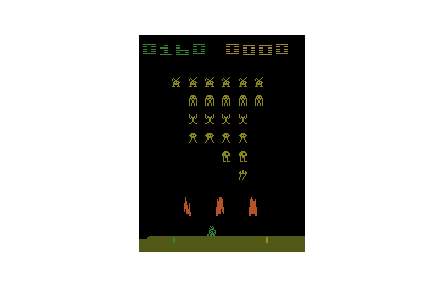
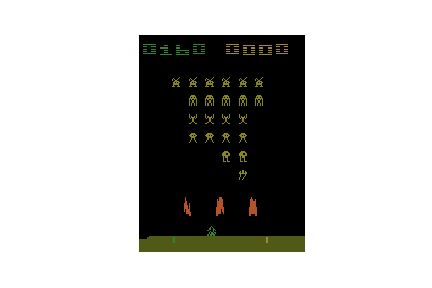
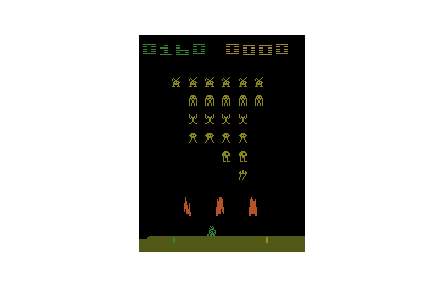
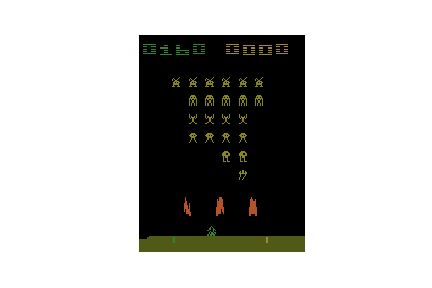
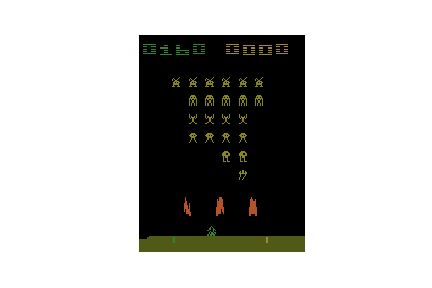
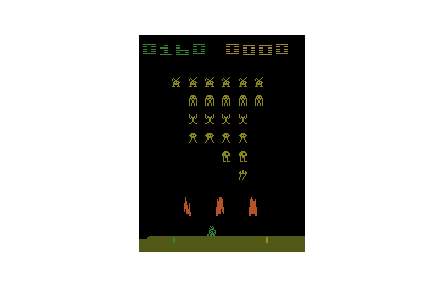
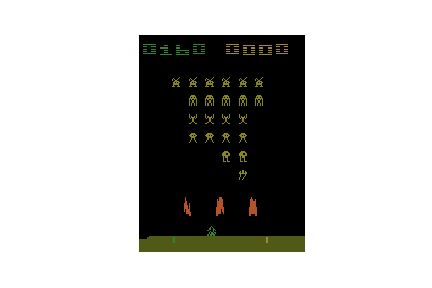
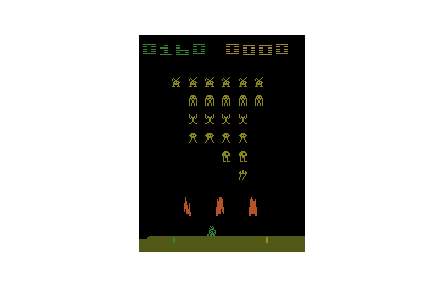

OSError: [Errno 12] Cannot allocate memory

In [22]:
num_episodes = 100
show_game = True

with tf.device("/gpu:0"):
    with tf.Session() as sess:
        saver.restore(sess,  "./models/" + model_name + ".ckpt")

        for i in range(num_episodes):
            #Reset environment and get first new observation
            s = env.reset()

            d = False
            num_actions = 0
            frames = []
            total_reward = 0

            gray_frame = preprocess_frame(s)
            for k in range(frame_buffer_size):
                StackFrame(stacked_frames, gray_frame)

            #The Q-Network
            while not d:
                num_actions+=1

    #             if show_game:
    #                 show_state(env)
                frames.append(env.render(mode = 'rgb_array'))


                #allQ = model.predict(np.vstack(c_stacked_frames).flatten())
                
                state = np.stack(stacked_frames,axis=2)
                allQ = sess.run(action_network.output,
                                            feed_dict={action_network.inputs_:state.reshape((1,*state.shape))})
                a = np.argmax(allQ)

                #Get new state and reward from environment
                s1,r,d,_ = env.step(a)

                total_reward += r

                #stack new frame
                gray_frame = preprocess_frame(s1)
                StackFrame(stacked_frames, gray_frame)

            print("Episode " + str(i) + " ended." + 
                      "\n\t Total Reward = " + str(total_reward))
            if total_reward > 300:
                display_frames_as_gif(frames, 
                                      name= str(training_id) + "_spaceinvaders_r" + str(total_reward))

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist", one_hot=True)

In [ ]:
tf.reset_default_graph()
network = DQNetwork(10,784, learning_rate=0.001)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

steps = 10000
for i in range(steps):
# Get the next batch
   input_batch, labels_batch = mnist.train.next_batch(100)
   feed_dict = {network.inputs_: input_batch, network.target_Q: labels_batch}

   # Print the current batch accuracy every 100 steps
   if i%100 == 0:
      train_accuracy = network.accuracy.eval(feed_dict=feed_dict)
      print("Step %d, training batch accuracy %g"%(i, train_accuracy))

   # Run the optimization step
   network.optimizer.run(feed_dict=feed_dict)

# Print the test accuracy once the training is over
test_images, test_labels = mnist.test.images, mnist.test.labels
print("Test accuracy: %g"%network.accuracy.eval(feed_dict={network.inputs_: test_images, network.target_Q: test_labels}))